In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

# DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Save Figure
show_fig    = True       # If True : Show the figure that are plot
save_fig    = False      # If True : Save the figure that are plot ; If show_fig == False, figure won't be save 
save_folder = 'UC3_fig'  # Folder where the figure is saved

# @param Connexion to the DB ; see SSMS to have the local connexion
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param DB / Table / Column Name   -> Should be changed if you change DB
"""
    Il faut ici récupérer tous les articles vendus dans la même transaction -> le même ticket.
    Pour ça, on va récupérer la clé primaire du ticket, contenu dans [Entete_Ticket.KEY].
    Le contenu du ticket est dans la table de détail du ticket : [Detail_Ticket.Article.KEY].
    
    Les tables détail et entête ne sont pas liés par des clés étrangère.
    Pour les liés, il faut que la date ET le numéro de ticket.
    
    Pour ne pas perdre le sens des articles dans l'analyse, on utilise leur groupement par univers.
    Ces univers sont composés de 4 niveau de précision (1 étant le moins précis avec 16 univers, 4 étant le plus précis avec 490 univers).
    Cette précision peut être modifier avec la variable @Univers_Depth.
    
    La table CONSOMMATEUR est utilisé pour filtré les clients fidélisés ou les segments de clientèle.
"""
DB            = "Archive2018_2019_prod"                                                 
TABLE_ENTETE  = "Recette_entete_ticket"                                                 
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
CONSOMMATEUR  = "Consommateur"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4         # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
"""
    Afin d'analyser sous plus d'angle, la possibilité de ne prendre que les transactions de clients fidélisé est données.
    Dans la DB Archive2018_2019_prod, les tickets de clients fidélisés commencent à partir de la clé 16.000.000.
    Pour mixer les données fidéliser et non fidélisées, il vaut mieux commencer à sécectionner les tickets à partir de cette bornes.
    Pour n'obtenir que des tickets non-fidélisé, il suffit de mettre take_only_fid = False, start_fid_key = 0 et nbr_ticket_max < 16.000.000.
"""
take_only_fid  = False     # If true, only transactions with fidelised cunsommer will be select
start_fid_key  = 16000000  # Key of TABLE_ENTETE where begin to mix fidelised and unfidelised cunsummer
nbr_ticket_max = 5000000   # MAX = 26.671.566 for Archive2018_2019_prod. Try to not select more thant 10.000.000 ticket

# @param Permet de faire varier l'analyse
"""
    Tout ces paramètres servent à faire l'analyse du support et de confidence pour l'Apriori Algorithm.
    Le choix final de min_support et min_confidence est assez subjectif, donc tester dans différentes valeurs peut être intéressant.
    La fonction Analyse fera ça selon les paramètre ci-dessous.
"""
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif - Apriori Algorithm
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 1/3       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

# @param effectuer l'analyse sur les magasins ou pas
do_shop              = True

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# DEFINITION DES FONCTIONS

### Prétraitements des données

In [4]:
"""
    Les Articles sont regroupés en univers.
    Les Univers possèdent 4 niveau de profondeur/précision.
    Plus la profondeur est élevés, plus il y a d'univers et plus c'est précis.
        Univers_Depth = 1 => #Univers = 16
        Univers_Depth = 4 => #Univers = 490
    
    Deux univers sont commun à N niveau près si leur N premier libellé sont commun.
    Pour obtenir les univers d'une ceraines profondeurs, on regarde alors les libellés distincts.
    
    
        @ Input : 
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où aller
        
        @ Ouput : 
            - Univers Correspondance [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Dictionnaire permettant de savoir quel univers correspond à un autre pour un certain degré de profondeur.
                L'univers Univers_Key devient Univers_Key_Correspondance pour une profondeur Univers_Depth
        
"""
def get_univers_correspondance(Univers_Depth):
    #SQL Request to select Key + 4 level of libelle of the table Dim_Univers
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''

    #Connexion to DB and load DataFrame
    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    #Variable to return
    univers_correspondance = {}
    #Stocks Univers key which is deleted.
    deleted = set()
    
    """
        Double boucle, on vérifie pour l'univers 1 si il existe des univers commun,
        puis sur l'univers 2 si il n'est pas supprimé, 
        puis sur le 3, etc.
    """
    for item in df_univers.values:
        if item[0] in deleted:
            continue
        for cor in df_univers.values: 
            if item[0] != cor[0]:
                # If libelle 1 to Univers_Depth of both univers are the same, they are the same
                if (
                    item[1] == cor[1] and
                    (item[2] == cor[2] or Univers_Depth < 2) and
                    (item[3] == cor[3] or Univers_Depth < 3) and
                    (item[4] == cor[4] or Univers_Depth < 4)
                ):
                    univers_correspondance[cor[0]] = item[0]
                    deleted.add(cor[0])
    return univers_correspondance

univers_correspondance = get_univers_correspondance(Univers_Depth)

In [5]:
"""
    Charge les transactions en les groupant de trois manière :
        - Toutes les transactions chargées par la DB de manière générale;
        - Toutes les transactions chargées par la DB groupée par magasin;
        - Toutes les transactions chargées par la DB groupée par article, 
            avec en plus le CA de l'article et le CA en dehors de l'articles chargés pour chaque transactions;
            
    Pour charger les transactions, on crée juste une nouvelle transactiosn dès que la clé du ticket est différentes.
    
        @ Input : 
            - dataframe [pd.DataFrame] | column = ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
                Contient toutes les données des tickets
                Les colonnes doivent être gardés dance cette ordre (ou la fonction doit être changé)
            - univ_cor [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Correspondance des univers en fonction de la profondeur utilisée.
                output de la fonction get_univers_correspondance(Univers_Depth)
            - all_mag_key [set]
                Contient toutes les clés de magasin présente dans le dataframe
            - all_univ_key [set]
                Contient toutes les clés d'univers présente dans le dataframe
                
        @ Output : 
            - transactions [list[tupple]]
                Contient la liste du contenu de toutes les transactions
            - all_mag_tra [dict] = {(Magasin_Key : list(tupple))}
                Contient pour chaque magasin la liste du contenu de toutes les transactions de ce magasin
            - univ_transactions = {(Univers_Key : list(tupple))}
                Contient pour chaque univers la liste du contenu de toutes les transactions de cet univers
            - univ_CA
                Contient pour chaque univers le CA produit par cette univers
            - univ_CA_sans_univ
                Contient pour chaque univers le CA produit par les transctions qui contenaient l'univers moins le CA produit par l'univers
"""
def load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key):
    start = time()

    # Initialisation of output variable
    transactions      = []
    
    all_mag_tra = {mag_key:[] for mag_key in all_mag_key}
    
    univ_transactions = {univ_key:[] for univ_key in all_univ_key}
    univ_CA           = {univ_key:0  for univ_key in all_univ_key}
    univ_CA_sans_univ = {univ_key:0  for univ_key in all_univ_key}
    
    # Variable for the loop initialisation
    actual_key_ticket = -1
    CA_trans   = {}
    
    for item in dataframe.values:
        # Get variable of dataframe -> Column have to be ["Univers.KEY","Entete_Ticket.KEY", "Detail_Ticket.CA", "Magasin.KEY"]
        key_univ = item[0]
        key_tic  = item[1]
        rec_lig  = item[2]
        key_mag  = item[3]
        
        # When key ticket change, we save the transaction and reinisialize the data
        if actual_key_ticket != key_tic:
            # if ticket == -1 (or len(CA_trans) == 0), we don't save the data
            if actual_key_ticket != -1:
                transactions.append(tuple(l))
                all_mag_tra[key_mag].append(tuple(l))
            
            for k in CA_trans.keys():
                univ_transactions[k].append(tuple(l))
                univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]

            # Reinitialize the loop variable
            actual_key_ticket = key_tic
            CA_trans   = {}
            l = []

        # Get univers_correspondance of univ_key
        if key_univ in univ_cor.keys():
            key_univ = univ_cor[key_univ]
        # Add key to the transaction
        l.append(int(key_univ))
        
        # Save the CA of the line
        if not key_univ in CA_trans.keys():
            CA_trans[key_univ] = 0
        CA_trans[key_univ] += rec_lig
        univ_CA[key_univ] += rec_lig
        
    # When leave the loop, save a last time the data
    all_mag_tra[key_mag].append(tuple(l))
    transactions.append(tuple(l))

    for k in CA_trans.keys():
        univ_transactions[k].append(tuple(l))
        univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
    
    # environ 10s * #tickets / 2.000.000.
    print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    
    return transactions, all_mag_tra, univ_transactions, univ_CA, univ_CA_sans_univ

### Analyses des données

In [6]:
"""
    Analyse les valeurs de seuil de support et de confidence pour l'Apriori Algorithm.
    La fonction va run l'Apriori Algorithm pour toutes les valeurs de support entre min_sup et max_sup et de confidence entre min_conf et max_conf.
    Il regarde ensuite le nombre de règles créé et le temps de run de l'algo.
    
    Une alternative plus rapide à l'algorithme ci-dessous peut être faite : 
        run l'algorithm pour max_sup et min_conf et l'Apriori Algorithm sort les stats de support et confidence pour chaque règle
        On traite chacune des règles et on regarde les stats
    Cette alternative ne permet cependant pas de ressortir les temps de runs.
    
        @ Input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_sup [float] = [0.0;1.0]
                Minimum support qui sera testé
            - max_sup [float] = [0.0;1.0]
                Maximum support qui sera testé
            - sup_iter [int] >= 0
                Nombre-1 de seuil de support qui sera testé
            - min_conf [float] = [0.0;1.0]
                Minimum confidence qui sera testé
            - max_conf [float] = [0.0;1.0]
                Maximum confidence qui sera testé
            - conf_iter [int] >= 0
                Nombre-1 de seuil de confidence qui sera testé
                
        @ Output :
            - df_rules [pd.DataFrame]
                Support en index, confidence en column, nombre de règle en value
            - df_time [pd.DataFrame]
                Support en index, confidence en column, temps de run en value

"""
def Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter):
    # initialization of output
    data_rules = {}
    data_time  = {}
    
    # Double loop to run algo on all min_sup / max_sup
    for i_support in range(sup_iter+1):
        # Setting value of min_supp
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter
        min_support = min(min_support, 1)
        
        # Algorithm can't run for min_support <= 0 ->
        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            # Setting value of min_conf
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter
            min_confidence = min(min_confidence, 1)

            print(min_confidence, end = '... ')

            #running Apriori Algorithm
            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")

    #change output to dataframe
    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)
    
    return df_rules, df_time

In [7]:
"""
    Pour un ensemble de transactions, va charger un dictionnaire contenant la fréquence à laquelle des univers apparaissent.
    Ex: Si l'univers 299 apparait dans 50% des transactions, l'output va contenir l'objet : (299:0.5)
    
    La fonction va également plot un graphique en barre des plus grande fréquence d'univers.
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - show_plot [boolean]
                True : affiche le plot
            - nbr_to_plt [int] >= 0
                Top X des fréquences qui seront plot si show_plot = True
                
        @output :
            - rec_article [dict] = {(univ_key:frequency)}
                Pour chaque univers, la fréquence à laquelle l'article apparait dans les transactions
            - nbr_univ [int]
                Nombre totale d'univers distinct dans les transactions
"""
def load_recurence(transactions, show_plot = True, nbr_to_plt = 20):
    start = time()
    rec_article = {}

    # Recup for every univers the récurence
    for t in transactions:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1

    # Divide recurence by the number of transaction
    N = len(transactions)
    for k in rec_article.keys():
        rec_article[k]/= N
    print(N)

    #environ 1min
    print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

    # Sort DESC the frequency
    rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}
    nbr_univ = len(rec_article.keys())

    # plot the frequency
    if show_plot:
        fig = plt.figure(figsize=(15, 5))
        plt.bar(list(rec_article.keys())[:min(nbr_to_plt, nbr_univ)]
                    ,list(rec_article.values())[:min(nbr_to_plt, nbr_univ)],1)

        plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")

        if save_fig:
            title = save_folder+"/"+str(Univers_Depth)+"_Proportion-Article"
            if list(rec_article.values())[0] == 1:
                title += "_"+str(list(rec_article.keys())[0])
            plt.savefig(title+".jpg")
        plt.show()

    return rec_article, nbr_univ

In [8]:
"""
    Récupère pour chaque transaction le nombre d'article qui sont vendu en plus d'une liste d'univers particulier
        et le nombre d'article de la liste d'univers particulier
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - univ_keys [list(int)]
                liste de clé à filter pour les output
                
        @ output :
            - nbr_article_sans_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers non-inclu dans univ_keys est présent
            - nbr_article_univ [list(int)]
                pour chaque transaction, le nombre de fois qu'un article d'un univers inclu dans univ_keys est présent
"""
def get_nbr_sans_univ(transactions, univ_keys):
    #initialization of the output
    nbr_article_sans_univ = [0 for _ in range(len(transactions))]
    nbr_article_univ      = [0 for _ in range(len(transactions))]
    
    # for each transactions : inscrease nbr_article_sans_univ if article not in univ_keys else increase nbr_article_univ
    for i in range(len(transactions)):
        for item in transactions[i]:
            if not item in univ_keys:
                nbr_article_sans_univ[i] += 1
            else:
                nbr_article_univ[i] += 1
                
    return nbr_article_sans_univ, nbr_article_univ     

### Apriori Algorithm - Getting Association Rules

In [9]:
"""
    Run l'Apriori Algorithm sur les transactions pour un certains support et confidence.
    L'Apriori Algorithm est un algorithme calculant les meilleurs règles d'associations entre article.
    Les règles d'associations sont sous la forme :
        "Si le client achetent de la mozzarella, alors il a 35% de chance d'acheter des tomates. 
        Cette événement s'est produit dans 1% de toutes les transactions"
    Le 35% représente ici la confidence, et le 1% représente le support.
    
    Un seuil de support et de confidence sont mis pour pas se retrouver avec 50k règles et un algo qui prends 6 ans à run.
    Sans ces seuils, la complexité est factorielle, donc je déconseille de mettre min_support à 0.
    Si le support est à 0, il est calculé automatiquement en le mettant à 1/#univers (environ 1/400)
    
    A noter que l'Apriori Algorithm ressort une solution exacte par rapport au min_support/min_confidence.
    Il ne sert donc à rien de le run plusieurs fois en espérant que ça change la solution.
    
    Pour plus d'info sur l'algorithme : https://www.youtube.com/watch?v=43CMKRHdH30
    Pour plus d'info sur la libraire  : https://efficient-apriori.readthedocs.io/en/latest/
    
        @ input :
            - transactions [list(tupple)]
                Liste des transactions, output de la fonction load_transactions(dataframe, univ_cor, all_mag_key, all_univ_key)
            - min_support [float] = [0;1]
                Seuil de fréquence d'apparition de la règles
            - min_confidence [float] = [0;1]
                Seuil de confiance en une règle 
            - nbr_univ [int]
                Nombre d'univers distinct dans les transactions
                
        @ output : 
            - Rules [list(Rule) (voir librairie)]
                Règles ressortie par l'algorithme
"""
def get_rules(transactions, min_support, min_confidence, nbr_univ = 490):
    start = time()

    # Recalculate the support if min_support <= 0
    min_supp = 1/nbr_univ if min_support <= 0 else min_support
    print(min_supp)

    # Run Apriori Algorithm
    _, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

    # eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    
    return rules

In [10]:
"""
    Affiche les règles avec leur libellé plutot que les règles avec les clés d'univers.
    Prend en compte la profondeur d'univers.
    
    Si une removed_key est entrée, alors les règles contenant cette clé ne seront pas affichés.
    Cette particularité est surtout utile pour voir les règles dans le cas des transactions contenant toujours un univers (cas des transactions regroupés par univers)
    
    La rule est skip si le lift = 1 car ça n'a pas de sens de la garder par définition mathématique (proof is let to the reader).
    
        @ input : 
            - rules [list(Rule) (voir librairie)]
                Règles ressortie par l'apriori algorithm
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où les articles sont regroupés
            - conn
                connexion au serveur sql
            - removed_key [int] = -1 || [1;490]
                clé que l'on souhaite ne pas avoir dans les règles affichées.
        
        @ output :
            None
"""
def print_rules(rules, Univers_Depth, conn, removed_key = -1):
    conn = engine.connect()

    for rule in sorted(rules, key=lambda rule: rule.lift):
        # Skip rule if lift = 1 or if rule contain removed_key
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        # SQL command to get the libelle 
        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()

In [11]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1secondes


## Chargements et prétraitements des données

In [12]:
start = time()

# SQL Query to get the usefull data for the transactions. 
sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
[''' + TABLE_ENTETE   + '''.KEY], 
[''' + RECETTE_DETAIL + '''],
[''' + TABLE_ENTETE   +'''.''' + TABLE_MAGASIN + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''       + TEMPS_DETAIL  + '''] = [''' + TEMPS_ENTETE    + '''] 
AND ['''      + NUMERO_DETAIL + '''] = [''' + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 ''' + ('''
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(start_fid_key+nbr_ticket_max) + '''
AND ['''      + TABLE_ENTETE  + '''.KEY] > ''' + str(start_fid_key))*int(not take_only_fid) + '''
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388 '''+ ('''
AND ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY] != -1 ''')*int(take_only_fid) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''


# SQL Query is print to debug it easily
print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY], 
[Recette_detail_ticket.Total_net_ttc_ligne],
[Recette_entete_ticket.Magasin.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 21000000
AND [Recette_entete_ticket.KEY] > 16000000
AND [Article_meti_HIST.Univers.KEY] != 388 
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~446secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0

In [13]:
# SQL Query to get Magasin Libelle
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]



In [14]:
# Get libelle of magasin linked with key
all_mag_lib  = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
# Get all Magasin that can be found in the transactions
all_mag_key  = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])
# Get all Univers that can be found in the transactions
all_univ_key = set(df_art_ticket[TABLE_ARTICLE+"."+TABLE_UNIVERS + ".KEY"])

In [16]:
# Load all the transactions 
(transactions, all_mag_tra,univ_transactions, 
 univ_CA, univ_CA_sans_univ) = load_transactions(df_art_ticket, univers_correspondance, 
                                                 all_mag_key, all_univ_key)
print(transactions[:5])
print(all_mag_tra[9][:5])

Time Taken to load transaction: ~206secondes
[(83,), (470, 470, 438, 299, 297, 299, 299, 299, 299), (272,), (254,), (272,)]
[(406,), (457, 232, 464, 363, 406), (394, 431), (392, 235, 392, 400, 220, 394, 235), (437, 211, 299, 299, 362)]


## Analyse et run des algos

3943534
Time Taken to load recurence: ~30secondes


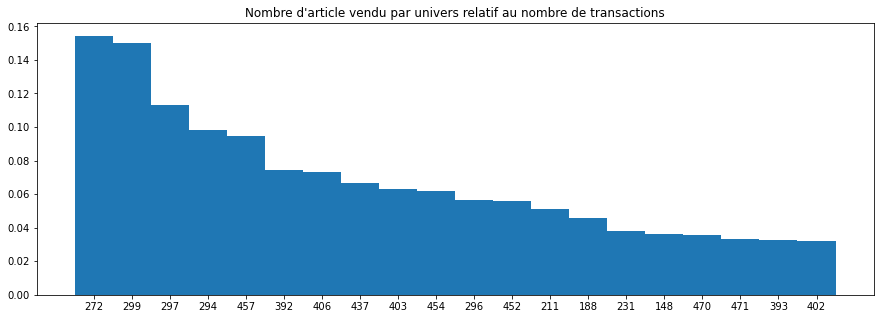

0.0024330900243309003
Time Taken to run Apriori Algorithm : ~50secondes


Rule :  {438} -> {299} (conf: 0.367, supp: 0.003, lift: 2.444, conv: 1.342)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {272, 437} -> {299} (conf: 0.378, supp: 0.002, lift: 2.517, conv: 1.366)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      437  PETIT DEJEUNER       CAFE SERVICE       CAFE SERVICE       CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437} -> {299} (conf: 0.402, supp: 0.027, lift: 2.674, conv: 1.420)
 Univ_KEY         Univ_1       Univ_2       Univ_3      

In [17]:
# Analyse min_sup and min_conf if do_Analysis = True
if do_analysis:
    Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter)

# Load recurence and rules
rec_article, nbr_univ = load_recurence(transactions)
rules = get_rules(transactions, min_support, min_confidence, nbr_univ)
print_rules(rules, Univers_Depth, conn)

-------------------GENVAL--------------------------
107882
Time Taken to load recurence: ~0secondes


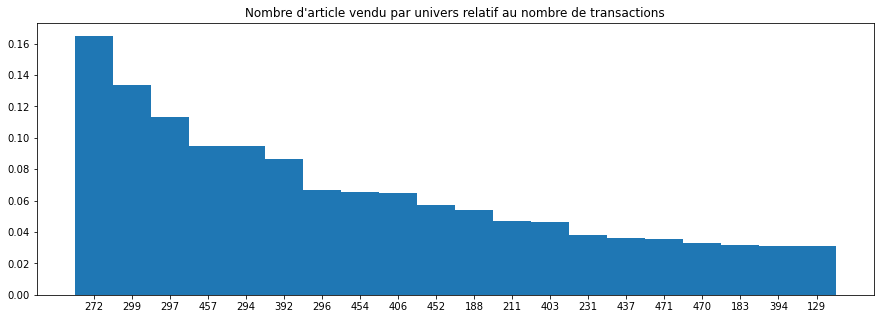

-------------------OHAIN F 2020--------------------------
130454
Time Taken to load recurence: ~0secondes


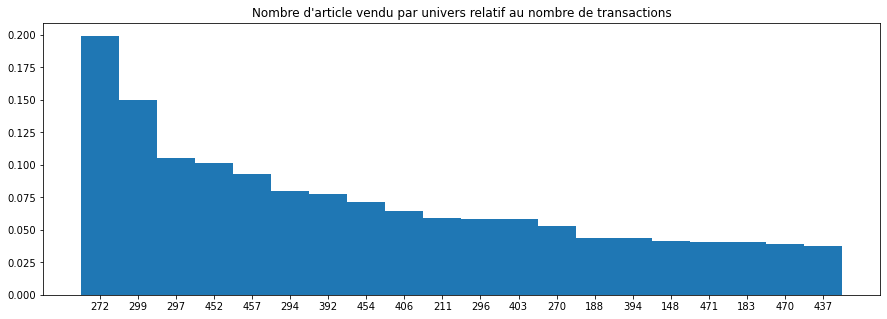

-------------------JURBISE--------------------------
77900
Time Taken to load recurence: ~0secondes


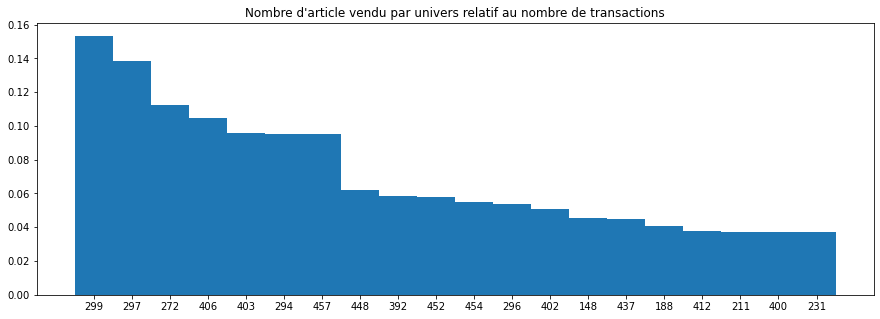

-------------------WEZEMBEEK-OPPEM--------------------------
67436
Time Taken to load recurence: ~0secondes


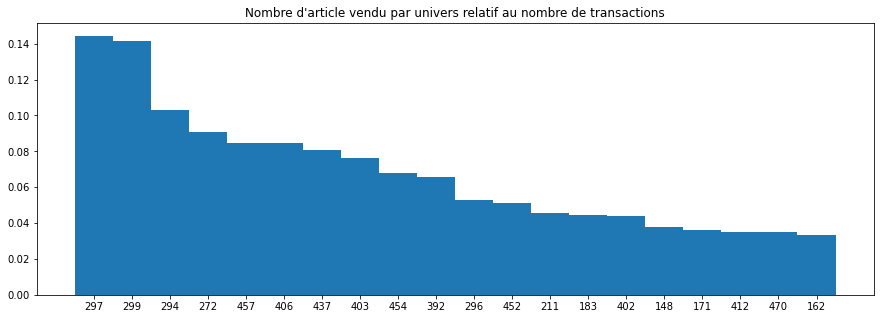

-------------------E&G BRUGES--------------------------
19990
Time Taken to load recurence: ~0secondes


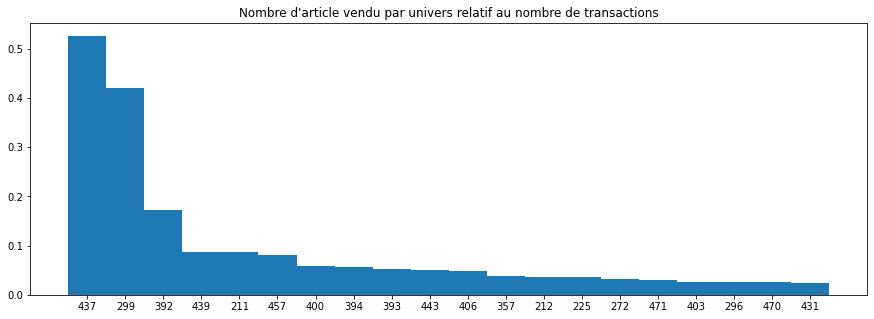

-------------------NEUPRE--------------------------
90341
Time Taken to load recurence: ~0secondes


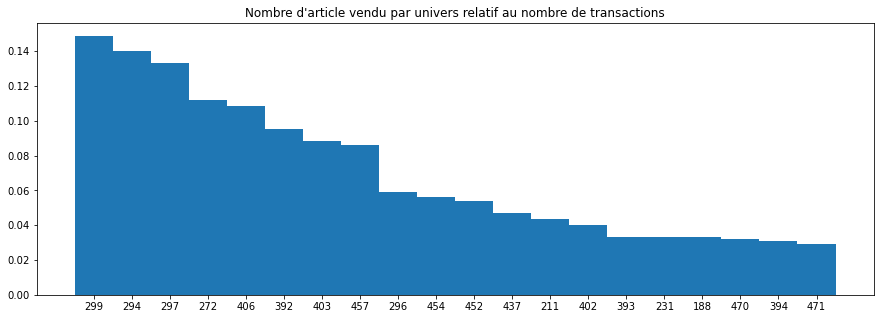

-------------------LIMAL F 2019--------------------------
10088
Time Taken to load recurence: ~0secondes


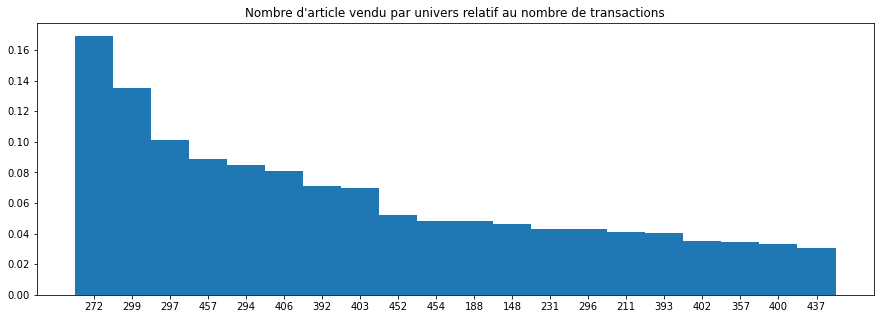

-------------------GRIMBERGEN F 2020--------------------------
83207
Time Taken to load recurence: ~0secondes


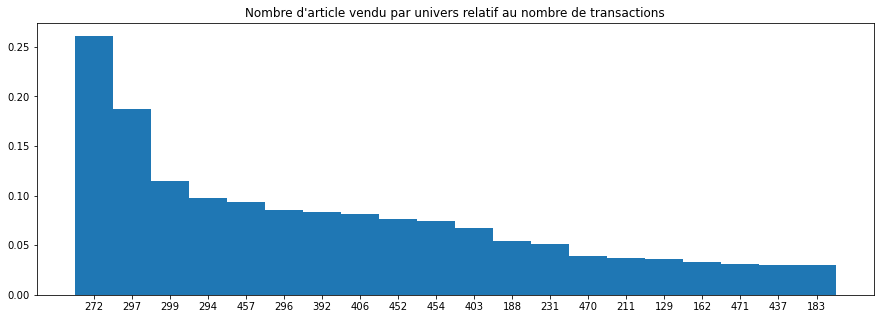

-------------------OVERIJSE--------------------------
103945
Time Taken to load recurence: ~0secondes


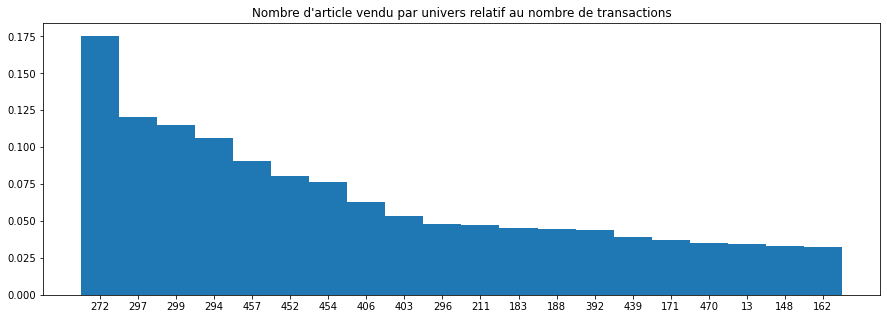

-------------------GANSHOREN--------------------------
144769
Time Taken to load recurence: ~0secondes


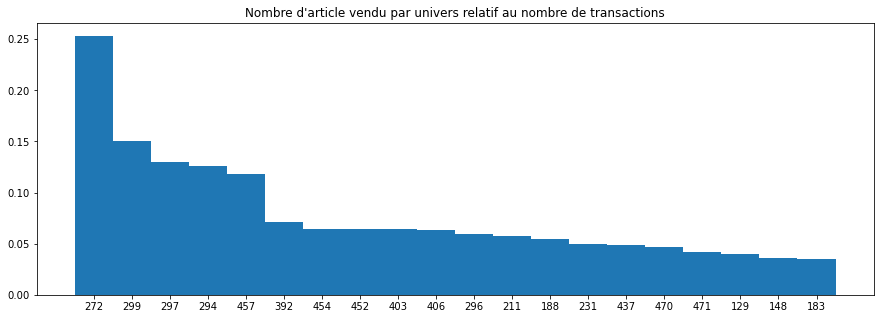

-------------------WOLUWE ST LAMBERT 1--------------------------
106642
Time Taken to load recurence: ~0secondes


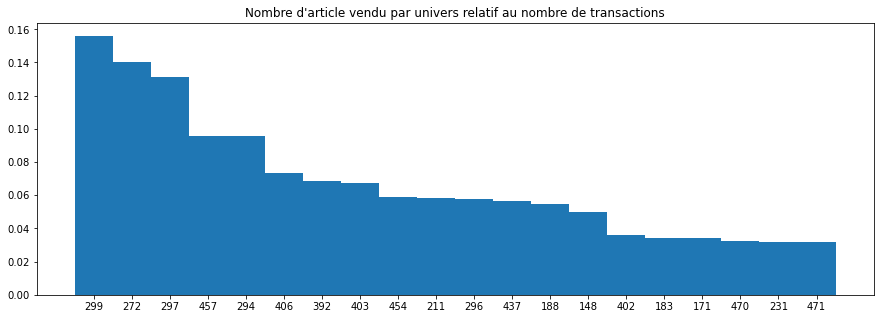

-------------------KRAAINEM--------------------------
132832
Time Taken to load recurence: ~0secondes


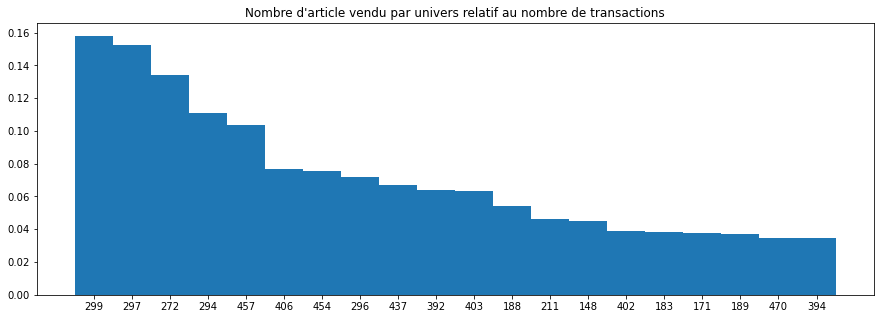

-------------------E&G BXL - GARE CENTRALE--------------------------
53677
Time Taken to load recurence: ~0secondes


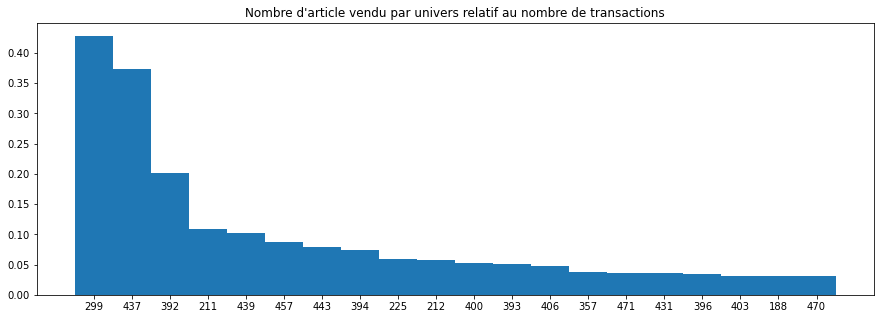

-------------------LA HULPE--------------------------
128335
Time Taken to load recurence: ~0secondes


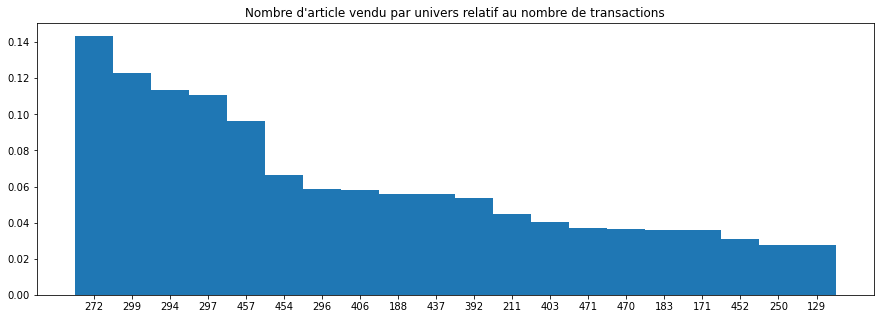

-------------------GENAPPE--------------------------
114353
Time Taken to load recurence: ~0secondes


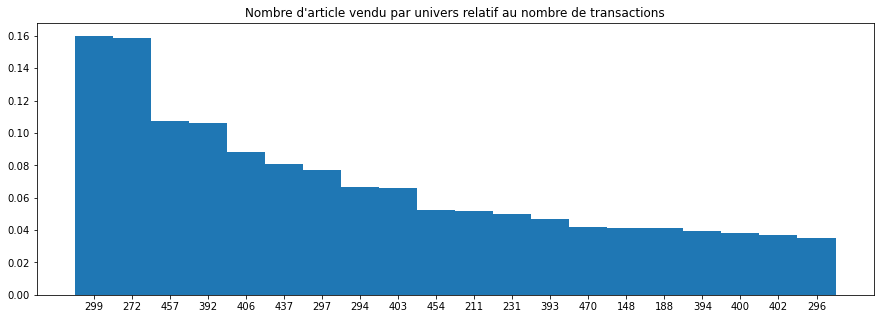

-------------------COURT SAINT ETIENNE--------------------------
78682
Time Taken to load recurence: ~0secondes


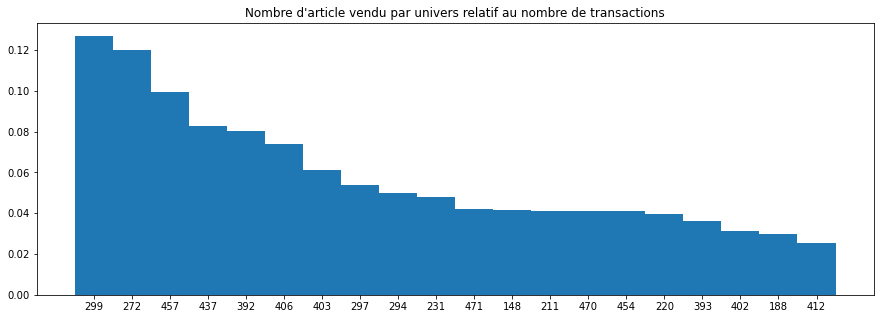

-------------------BRAINE L ALLEUD 1 F 2020--------------------------
32661
Time Taken to load recurence: ~0secondes


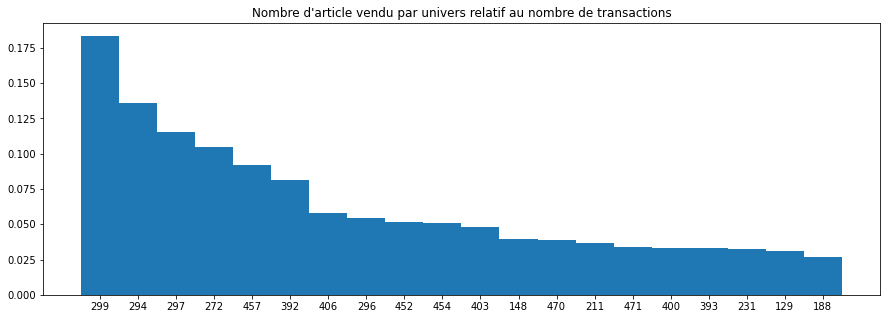

-------------------WATERLOO FAUBOURG--------------------------
140680
Time Taken to load recurence: ~0secondes


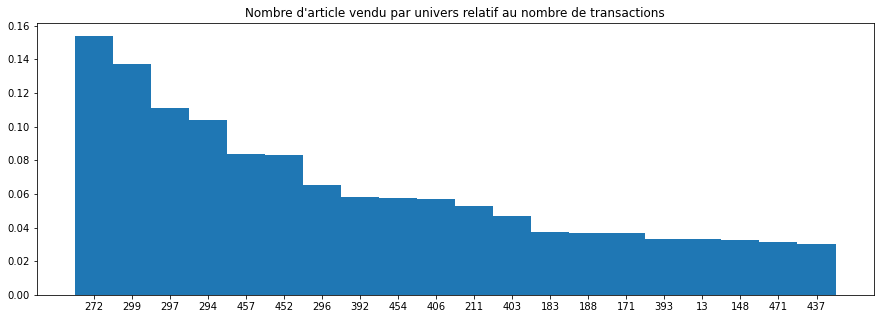

-------------------E&G GEMBLOUX--------------------------
18822
Time Taken to load recurence: ~0secondes


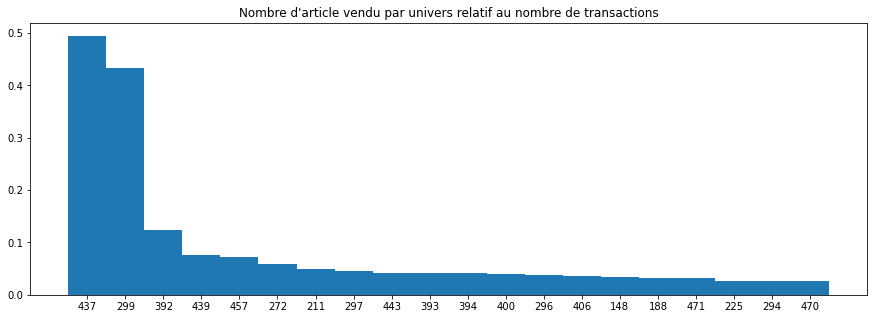

-------------------BOORTMEERBEEK--------------------------
103610
Time Taken to load recurence: ~0secondes


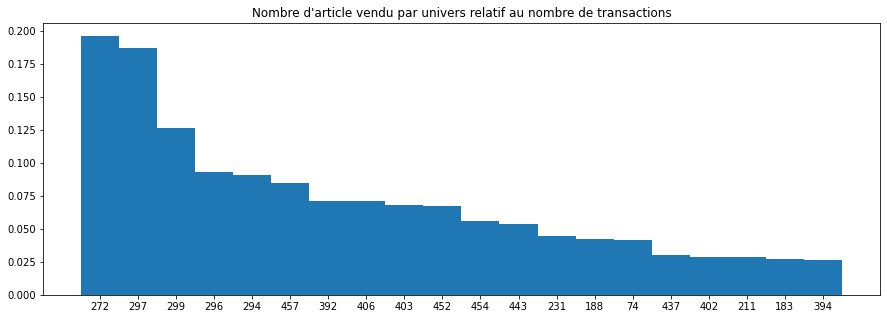

-------------------SINT-MARTENS-LATEM--------------------------
95565
Time Taken to load recurence: ~0secondes


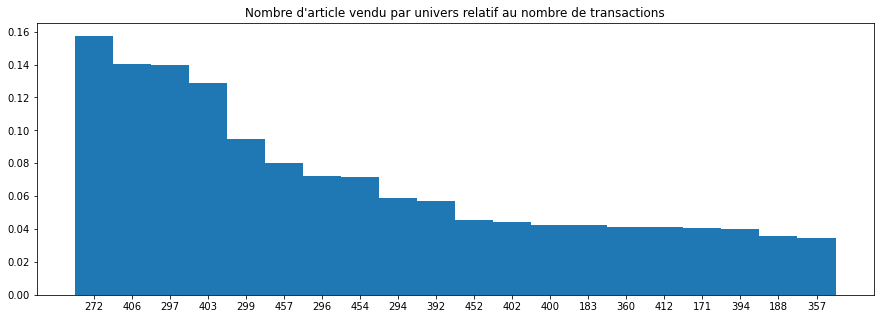

-------------------BRAINE L ALLEUD 1 I 2020--------------------------
63018
Time Taken to load recurence: ~0secondes


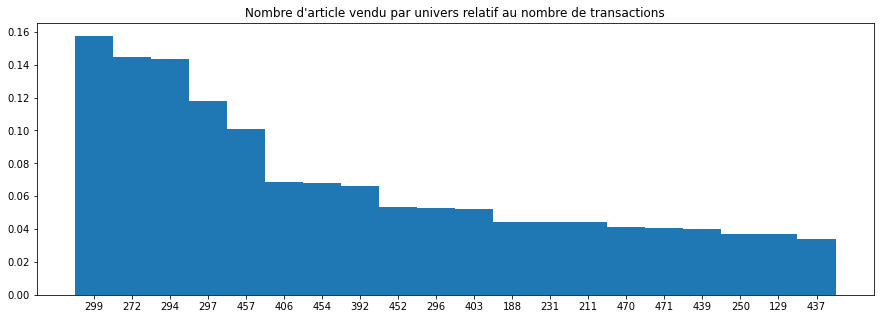

-------------------ALSEMBERG--------------------------
106665
Time Taken to load recurence: ~0secondes


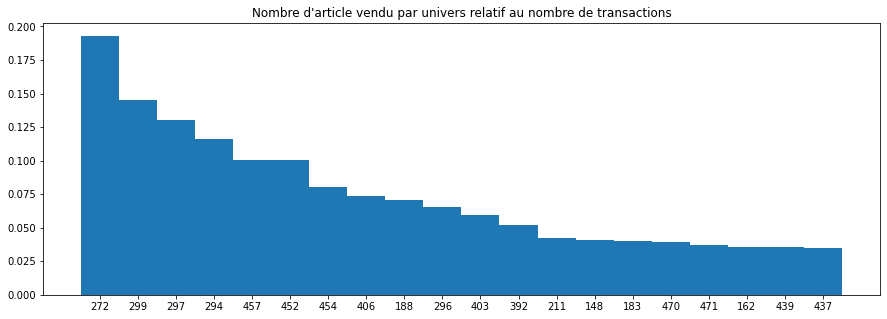

-------------------STRASSEN--------------------------
102342
Time Taken to load recurence: ~0secondes


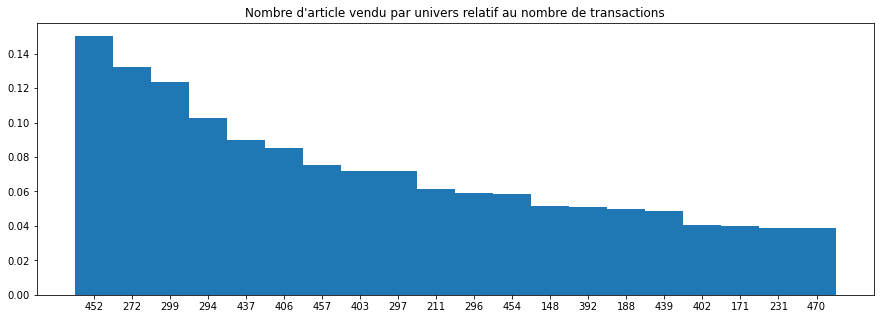

-------------------IXELLES PAGE--------------------------
167365
Time Taken to load recurence: ~0secondes


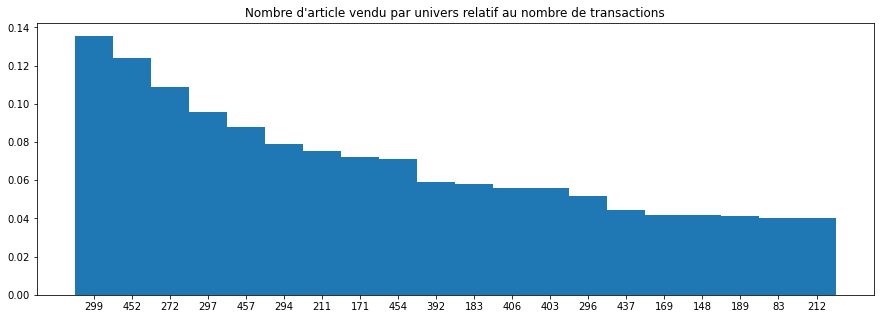

-------------------E&G IXELLES I 2020--------------------------
22293
Time Taken to load recurence: ~0secondes


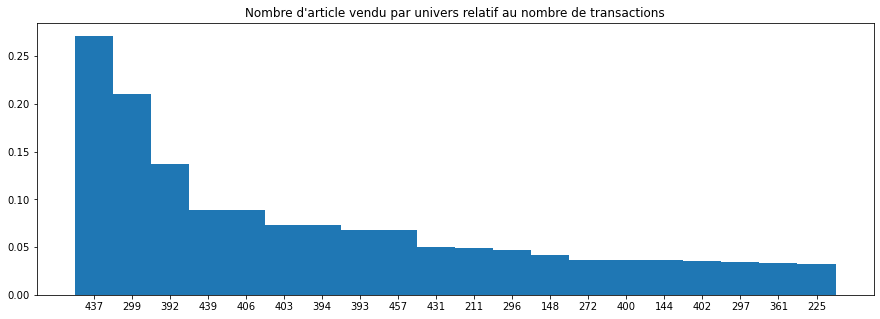

-------------------E&G LIEGE GUILLEMINS--------------------------
49754
Time Taken to load recurence: ~0secondes


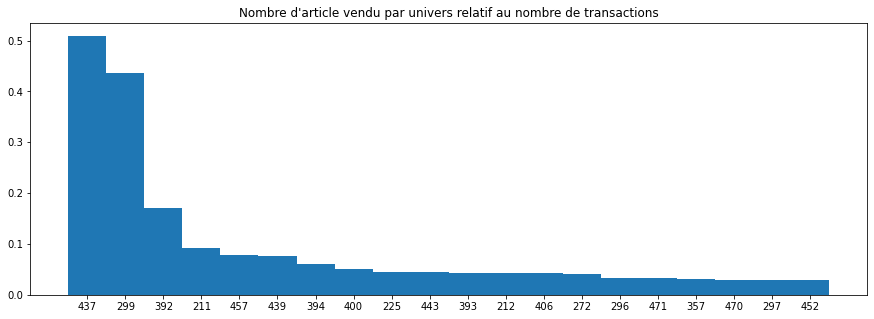

-------------------NIVELLES--------------------------
162336
Time Taken to load recurence: ~0secondes


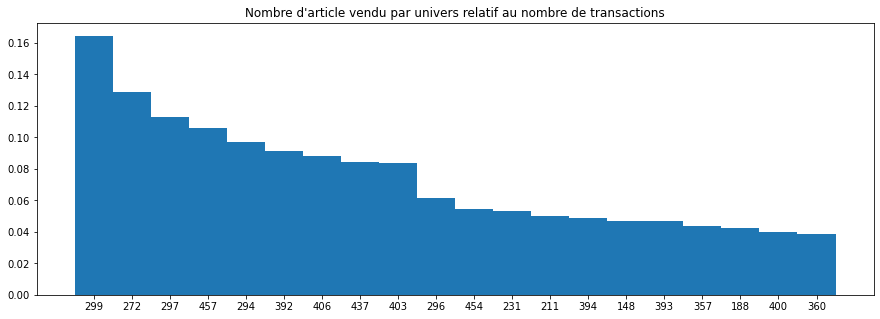

-------------------BRAINE L ALLEUD 2--------------------------
165238
Time Taken to load recurence: ~0secondes


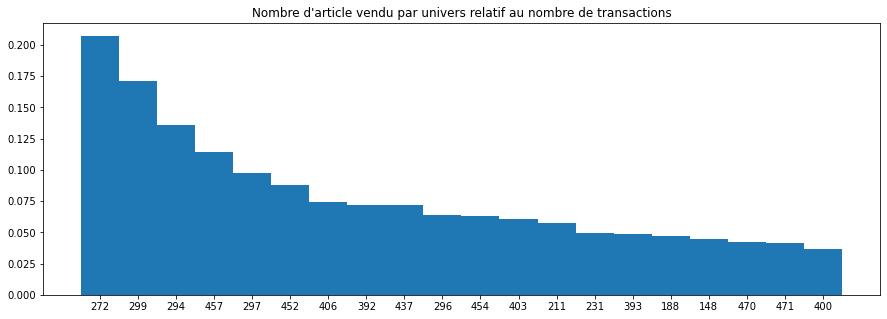

-------------------LIMELETTE--------------------------
83913
Time Taken to load recurence: ~0secondes


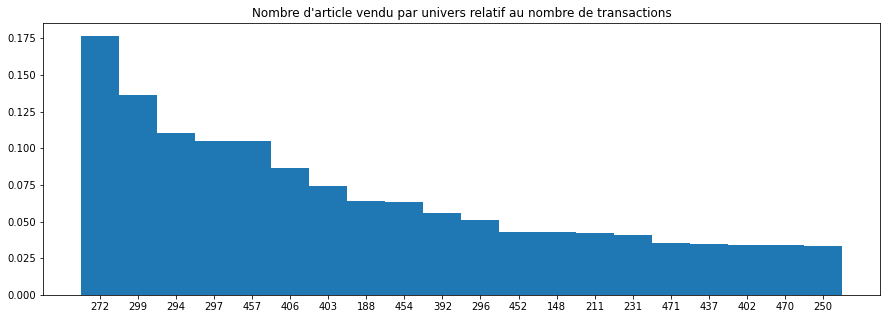

-------------------WATERLOO DREVE--------------------------
109285
Time Taken to load recurence: ~0secondes


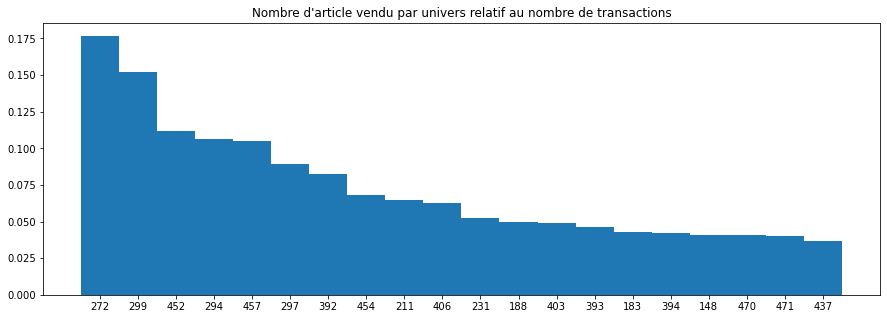

-------------------ITTRE--------------------------
95645
Time Taken to load recurence: ~0secondes


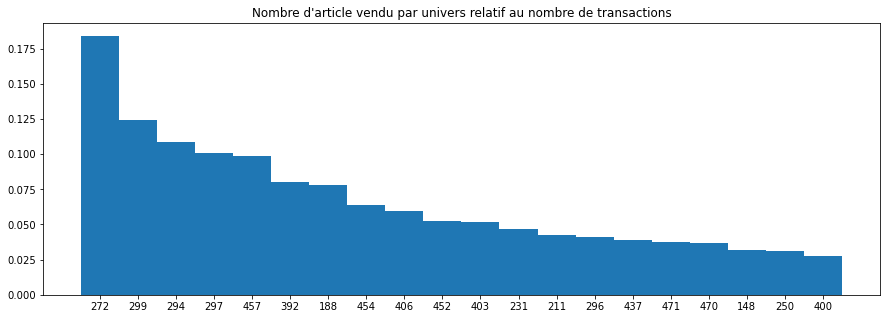

-------------------WOLUWE ST LAMBERT 2--------------------------
83707
Time Taken to load recurence: ~0secondes


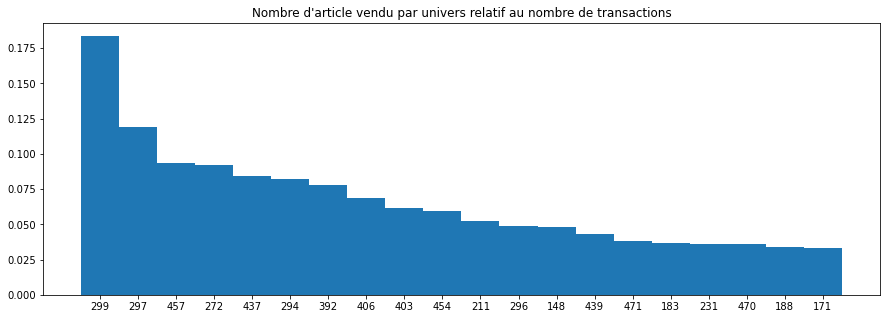

-------------------GREZ DOICEAU--------------------------
74120
Time Taken to load recurence: ~0secondes


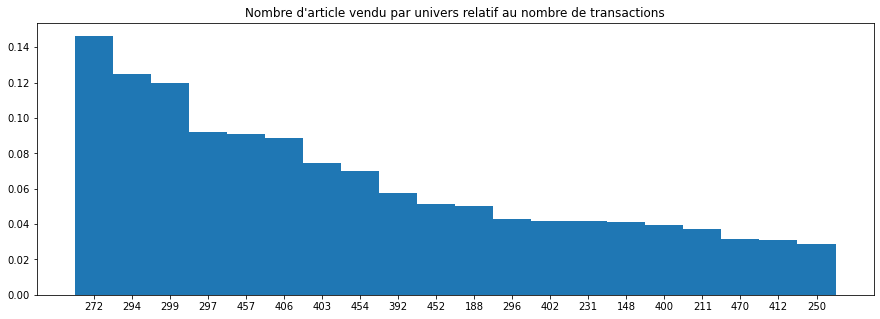

-------------------LILLOIS--------------------------
109238
Time Taken to load recurence: ~0secondes


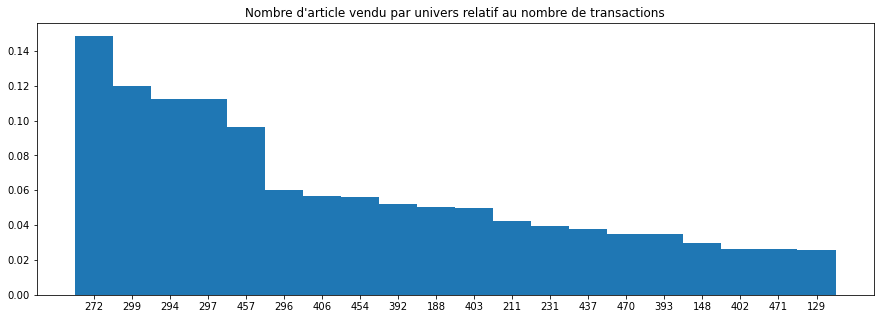

-------------------ARLON--------------------------
78909
Time Taken to load recurence: ~0secondes


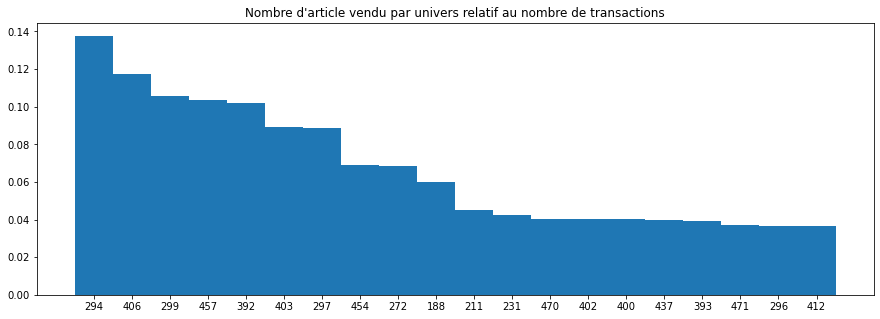

-------------------SINT PIETERS LEEUW--------------------------
85323
Time Taken to load recurence: ~0secondes


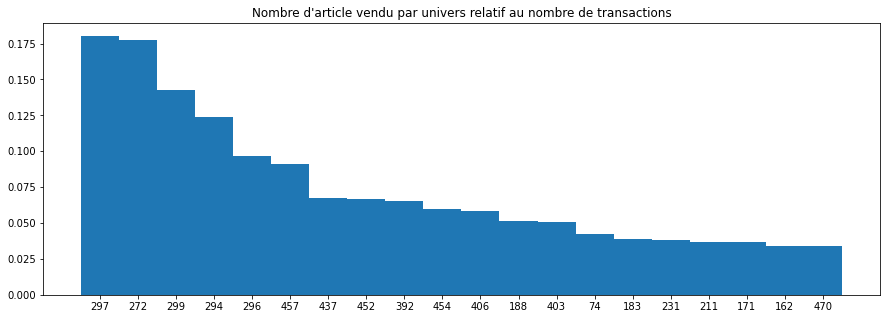

-------------------UCCLE--------------------------
77142
Time Taken to load recurence: ~0secondes


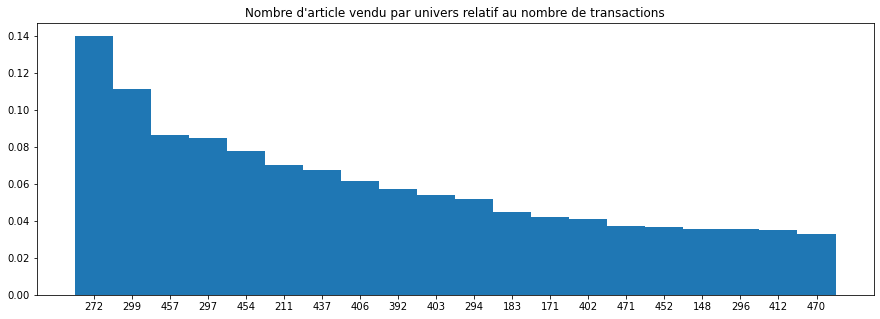

-------------------BRAINE LE COMTE--------------------------
95254
Time Taken to load recurence: ~0secondes


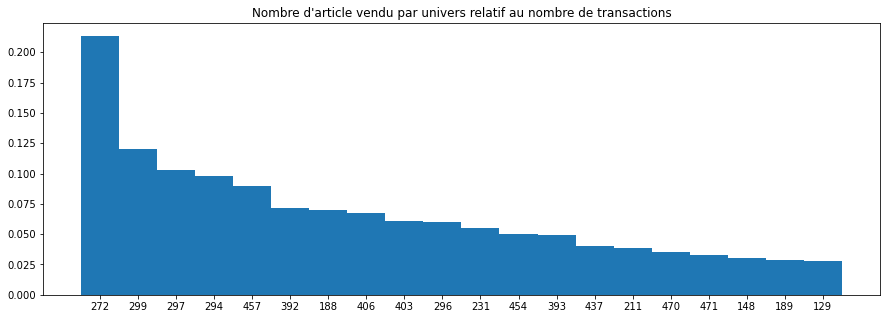

-------------------WOLUWE ST PIERRE--------------------------
133650
Time Taken to load recurence: ~0secondes


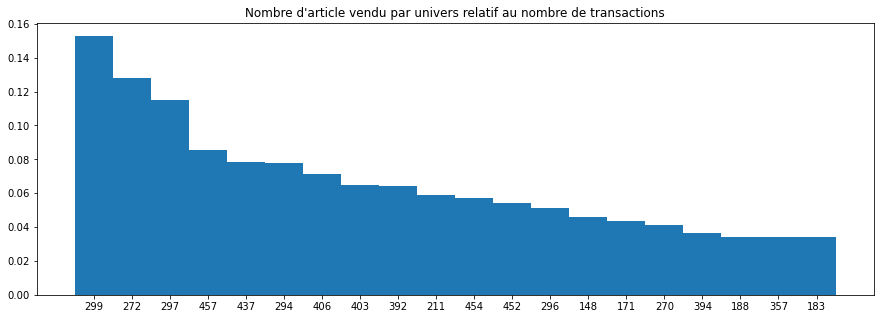

-------------------WEMMEL--------------------------
152766
Time Taken to load recurence: ~0secondes


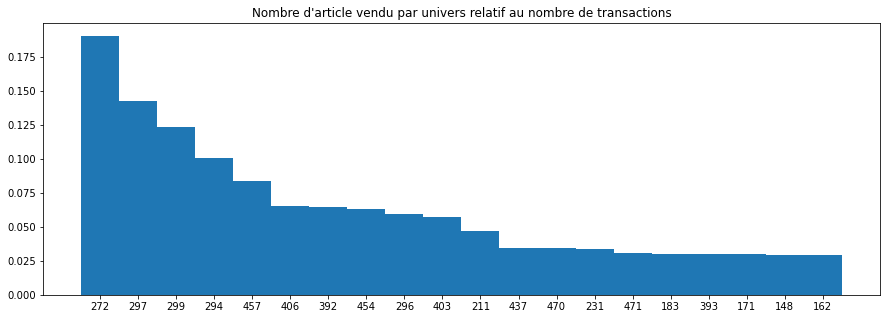

-------------------LIMAL I 2020--------------------------
63842
Time Taken to load recurence: ~0secondes


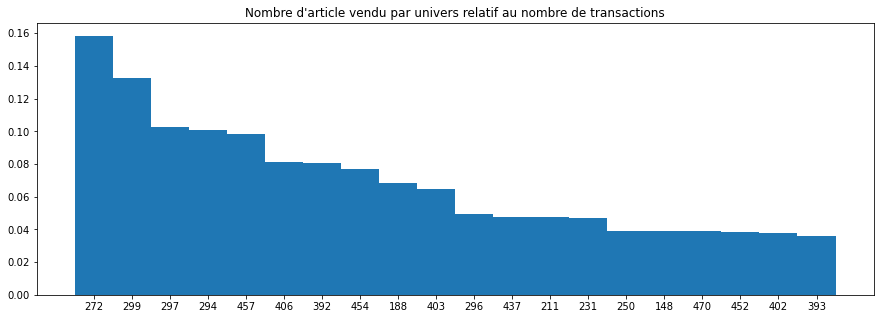

-------------------GRIMBERGEN F 2020--------------------------
19858
Time Taken to load recurence: ~0secondes


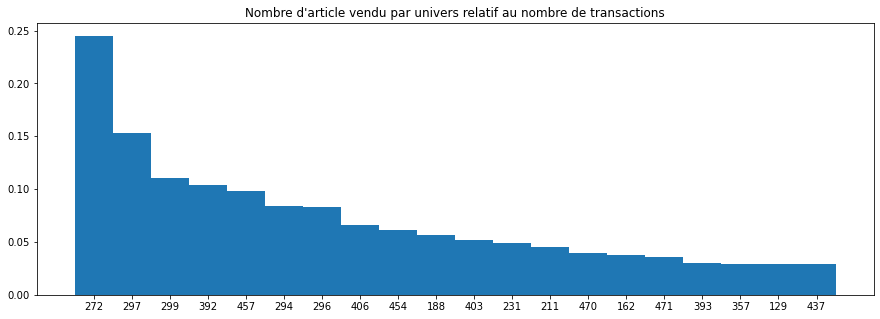

In [18]:
# If do_shop, load recurence for shops
dico_rec_mag = {}
if do_shop:
    for mag_key in all_mag_key:
        print("-------------------" + all_mag_lib[mag_key] + "--------------------------")
        mag_tran = all_mag_tra[mag_key]

        dico_rec_mag[mag_key], mag_nbr_univ = load_recurence(mag_tran)
#         mag_rules = get_rules(mag_tran, min_support, min_confidence, mag_nbr_univ)
#         print_rules(mag_rules, Univers_Depth, conn)

==============1===================
243
Time Taken to load recurence: ~0secondes


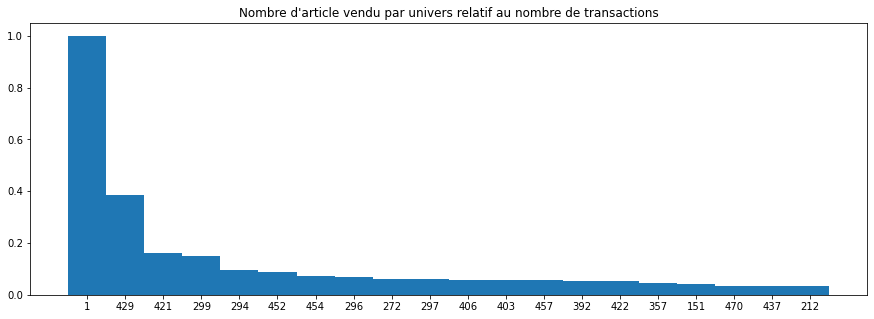

==============2===================
1277
Time Taken to load recurence: ~0secondes


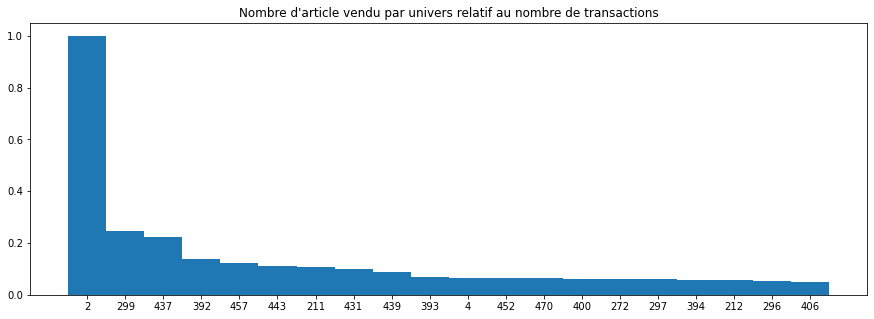

==============3===================
NOT ENOUGH DATA 
==============4===================
2323
Time Taken to load recurence: ~0secondes


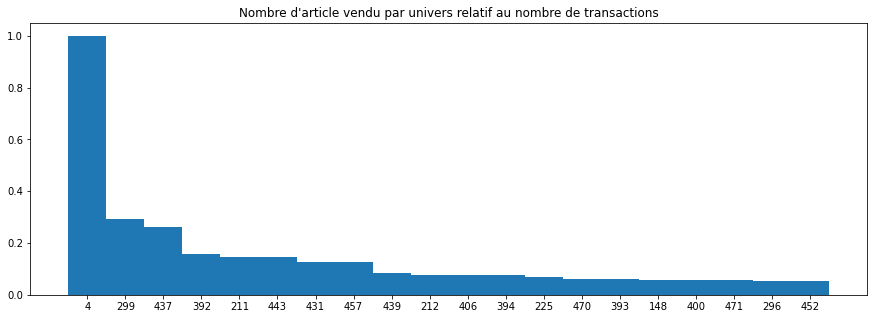

==============5===================
1544
Time Taken to load recurence: ~0secondes


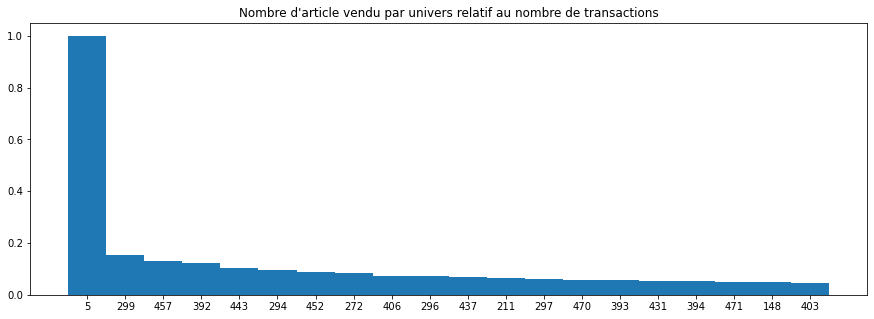

==============9===================
19599
Time Taken to load recurence: ~0secondes


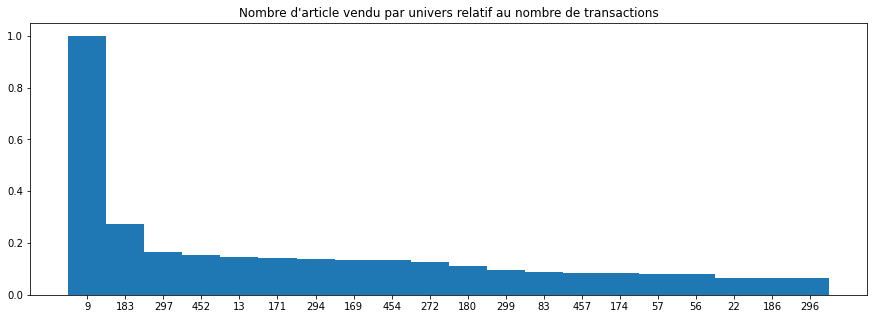

==============10===================
22589
Time Taken to load recurence: ~0secondes


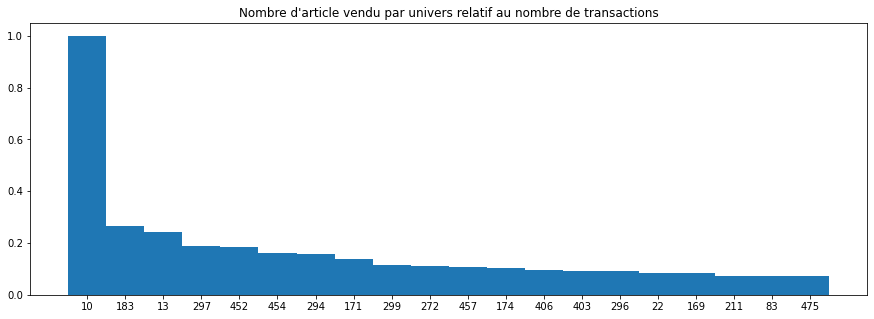

==============12===================
2320
Time Taken to load recurence: ~0secondes


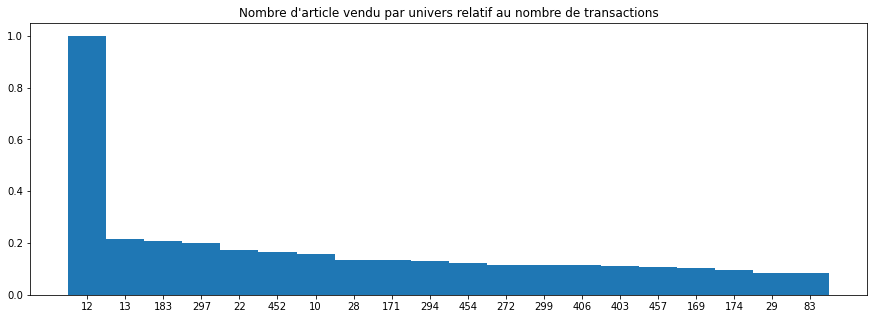

==============13===================
94289
Time Taken to load recurence: ~0secondes


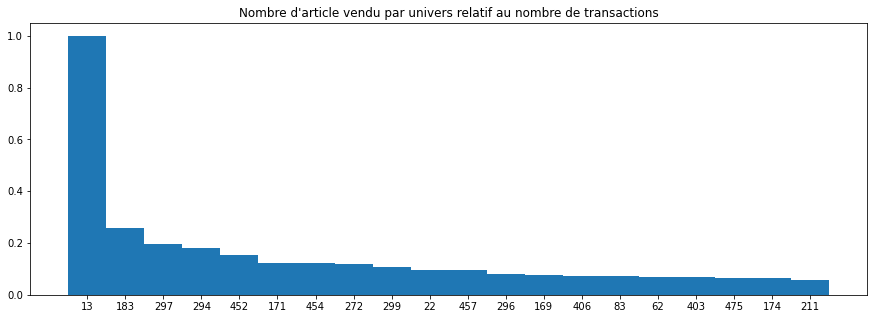

==============14===================
120
Time Taken to load recurence: ~0secondes


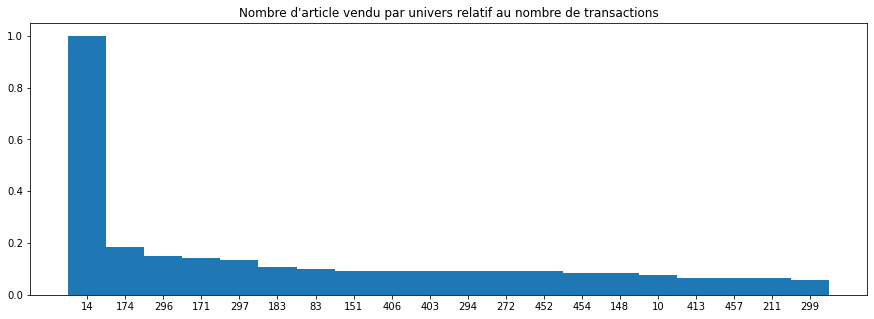

==============15===================
653
Time Taken to load recurence: ~0secondes


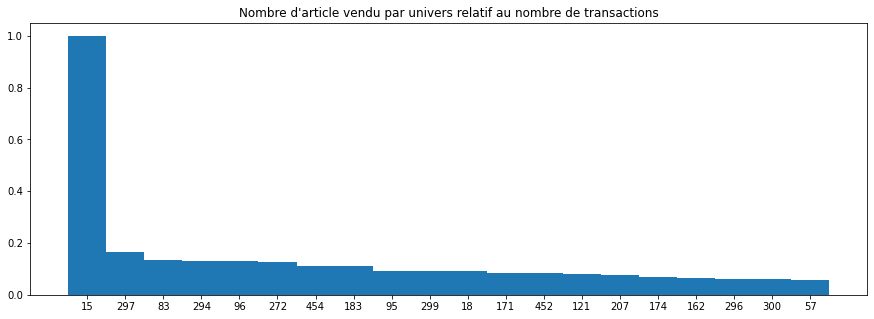

==============16===================
4483
Time Taken to load recurence: ~0secondes


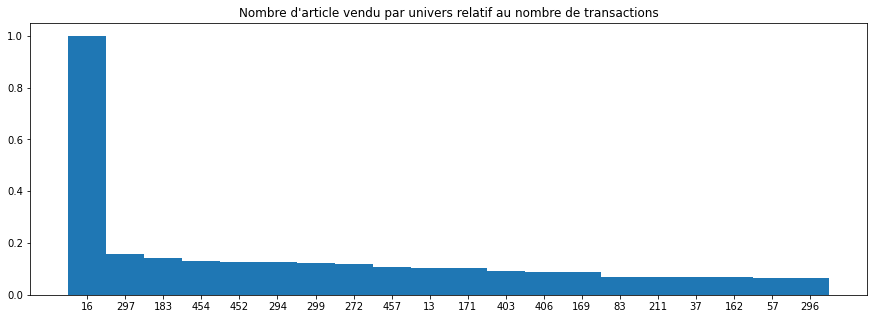

==============17===================
6392
Time Taken to load recurence: ~0secondes


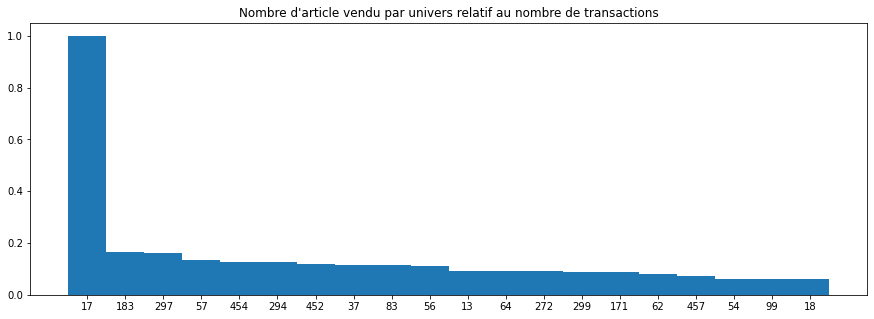

==============18===================
50612
Time Taken to load recurence: ~0secondes


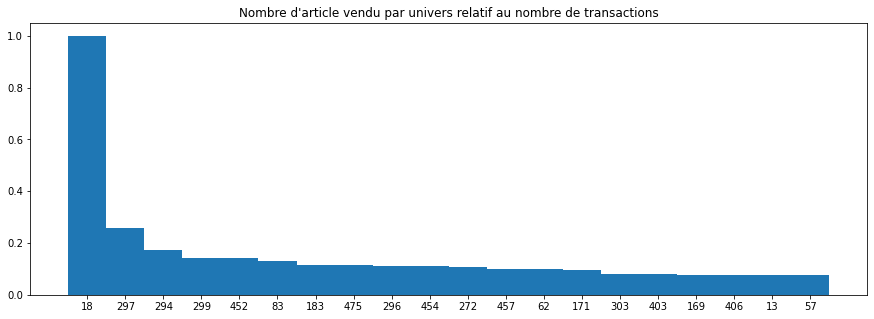

==============19===================
12239
Time Taken to load recurence: ~0secondes


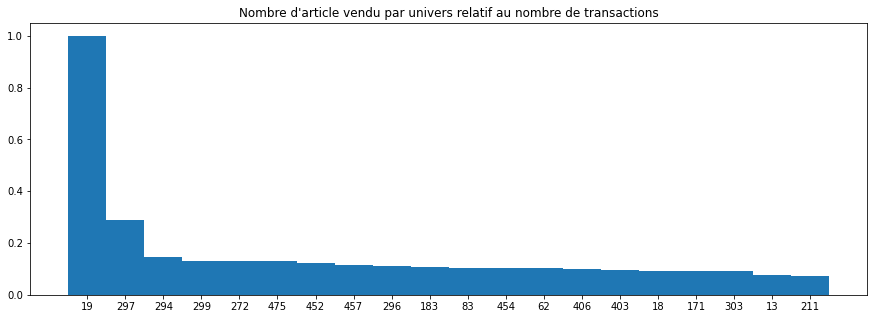

==============20===================
1549
Time Taken to load recurence: ~0secondes


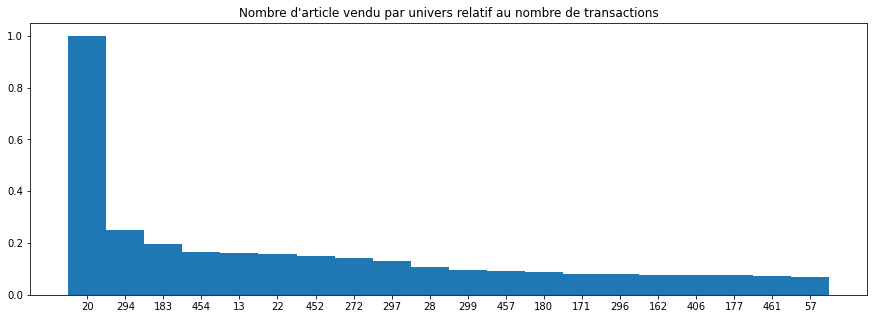

==============22===================
72189
Time Taken to load recurence: ~0secondes


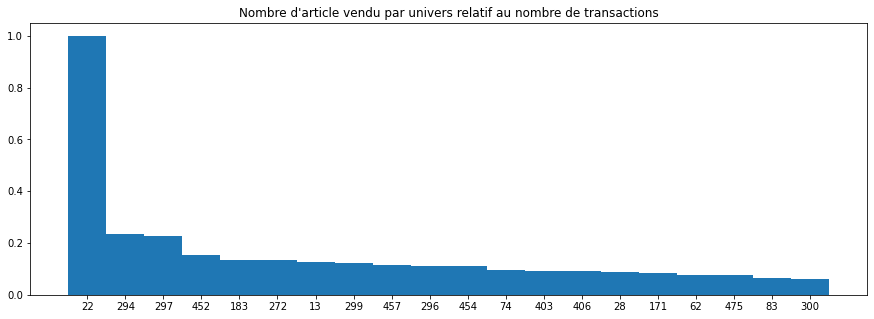

==============23===================
1650
Time Taken to load recurence: ~0secondes


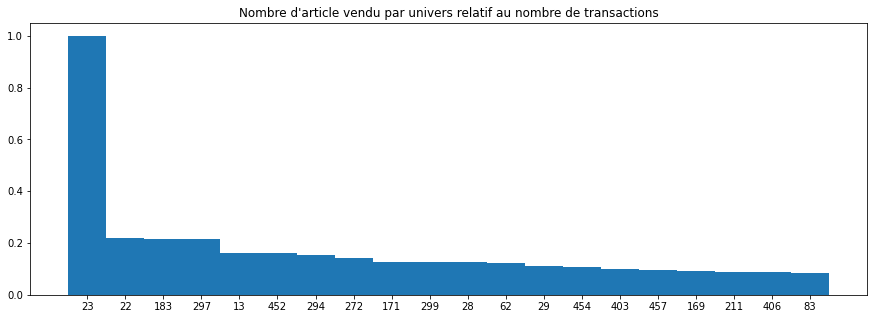

==============24===================
8756
Time Taken to load recurence: ~0secondes


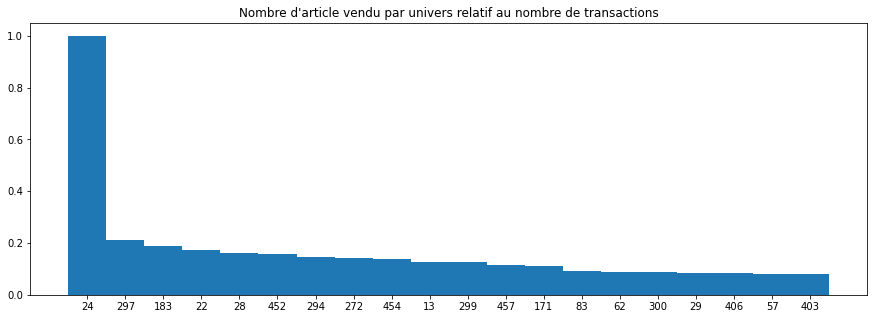

==============25===================
11286
Time Taken to load recurence: ~0secondes


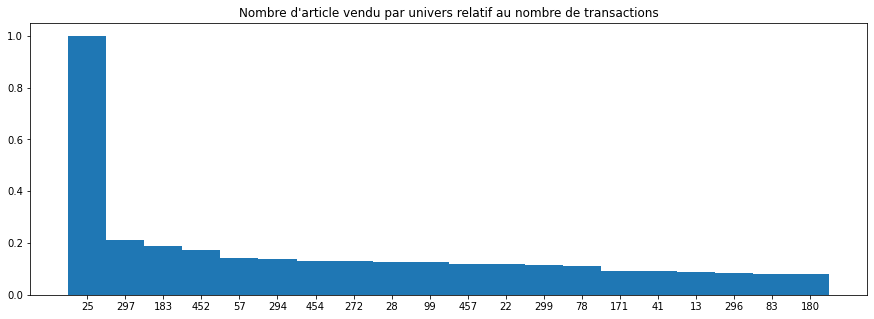

==============27===================
31095
Time Taken to load recurence: ~0secondes


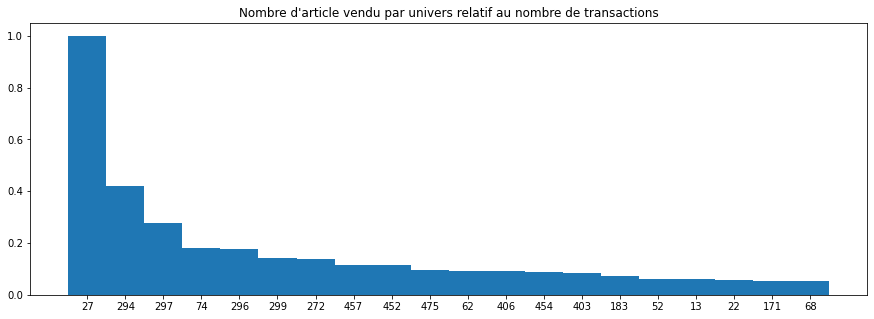

==============28===================
43189
Time Taken to load recurence: ~0secondes


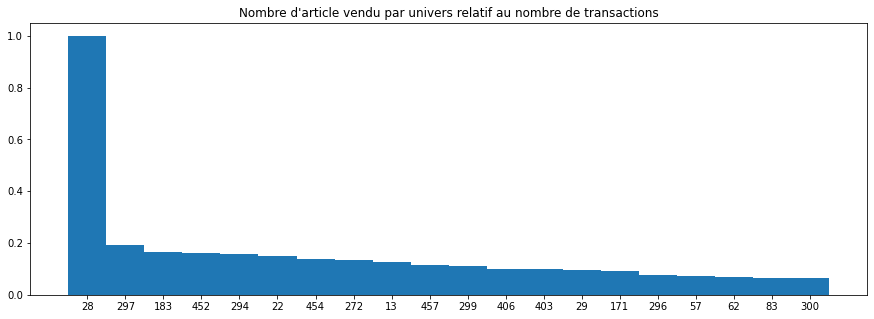

==============29===================
26355
Time Taken to load recurence: ~0secondes


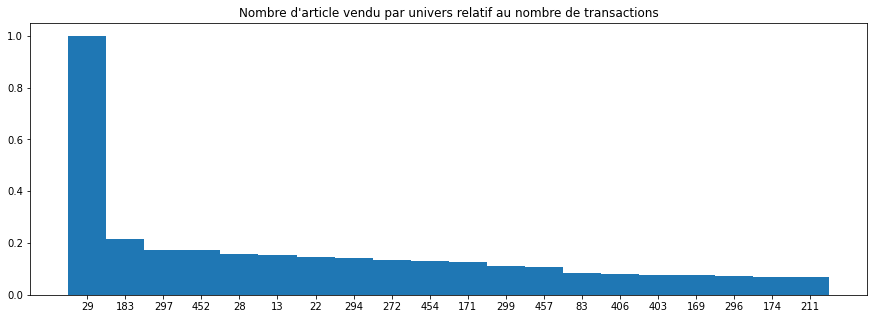

==============30===================
2341
Time Taken to load recurence: ~0secondes


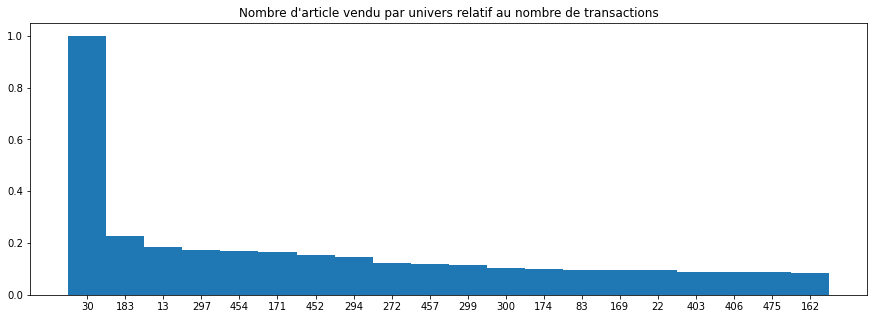

==============31===================
4384
Time Taken to load recurence: ~0secondes


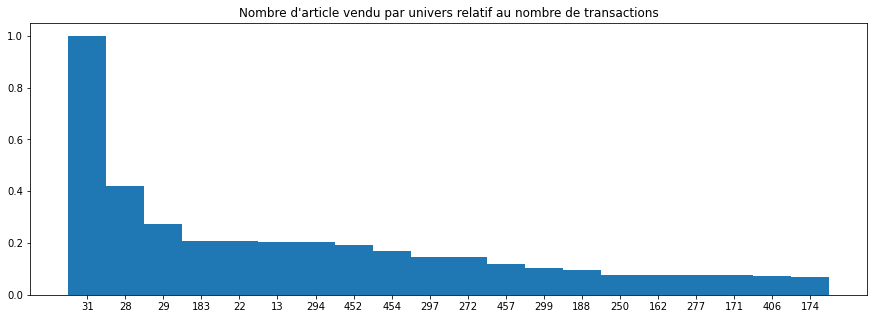

==============34===================
464
Time Taken to load recurence: ~0secondes


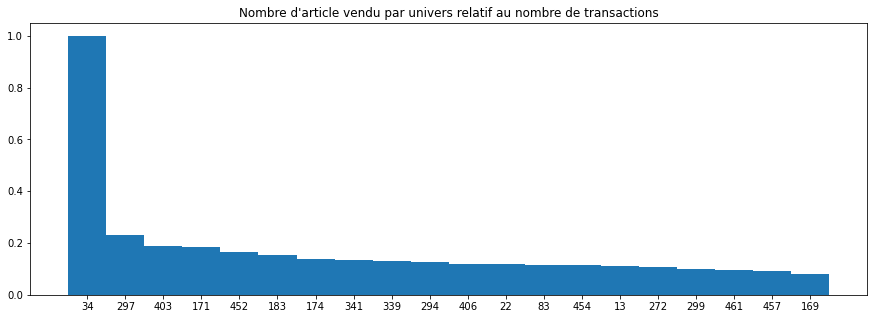

==============35===================
3506
Time Taken to load recurence: ~0secondes


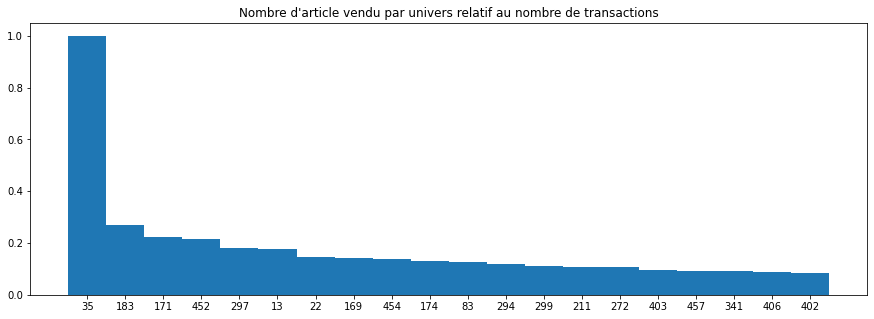

==============36===================
NOT ENOUGH DATA 
==============37===================
36554
Time Taken to load recurence: ~0secondes


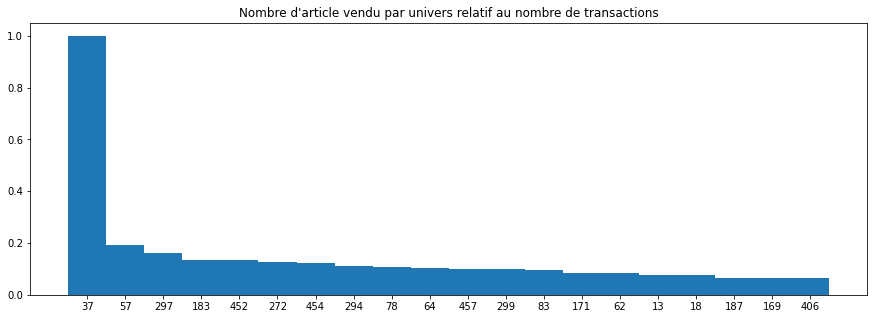

==============38===================
2245
Time Taken to load recurence: ~0secondes


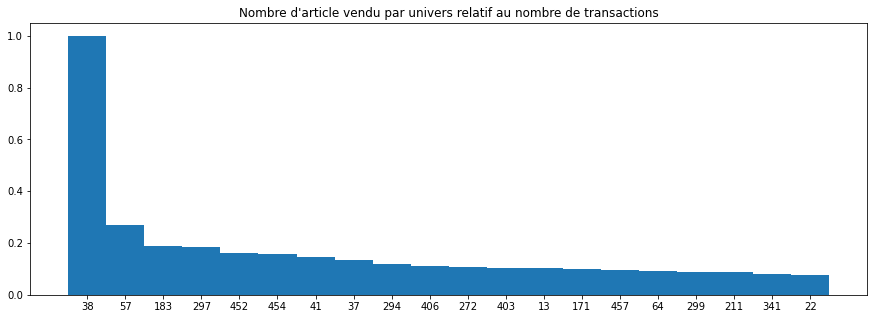

==============39===================
10793
Time Taken to load recurence: ~0secondes


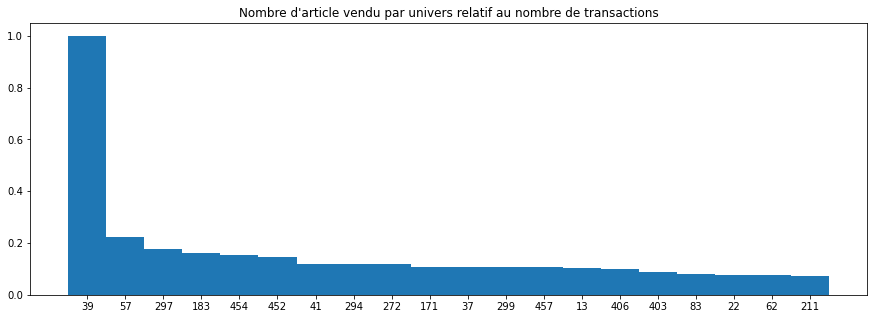

==============41===================
23101
Time Taken to load recurence: ~0secondes


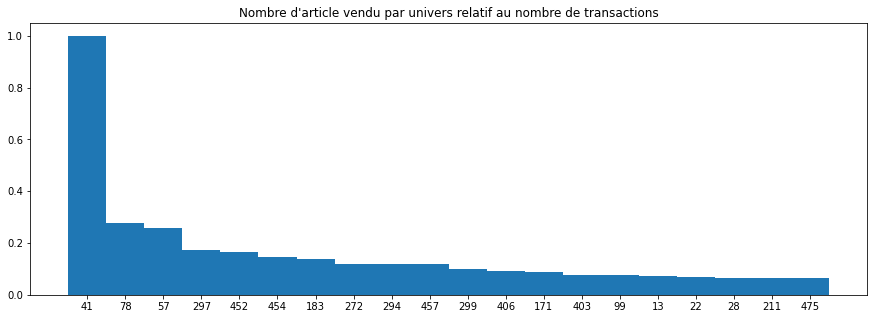

==============42===================
412
Time Taken to load recurence: ~0secondes


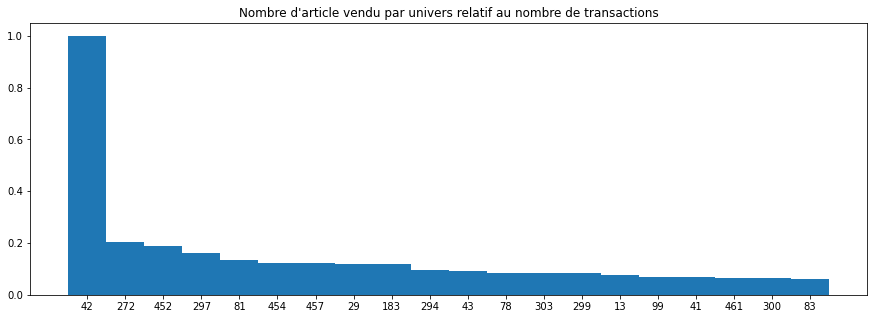

==============43===================
6930
Time Taken to load recurence: ~0secondes


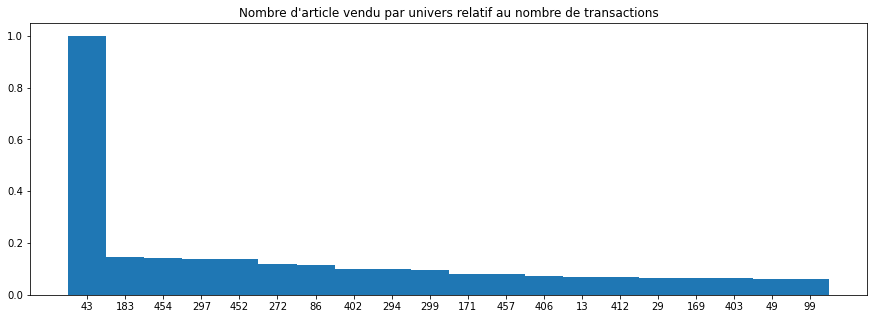

==============44===================
1883
Time Taken to load recurence: ~0secondes


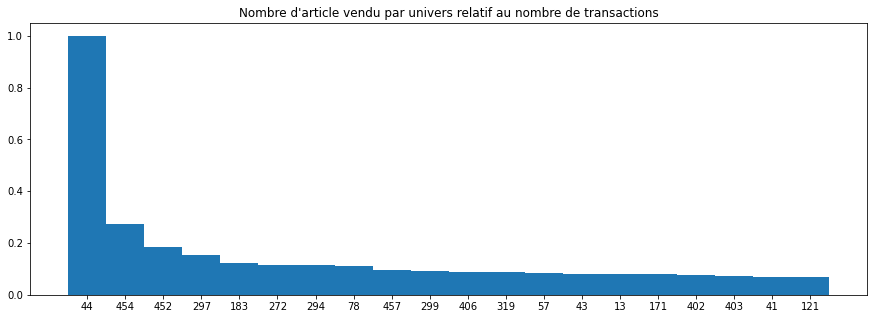

==============45===================
7402
Time Taken to load recurence: ~0secondes


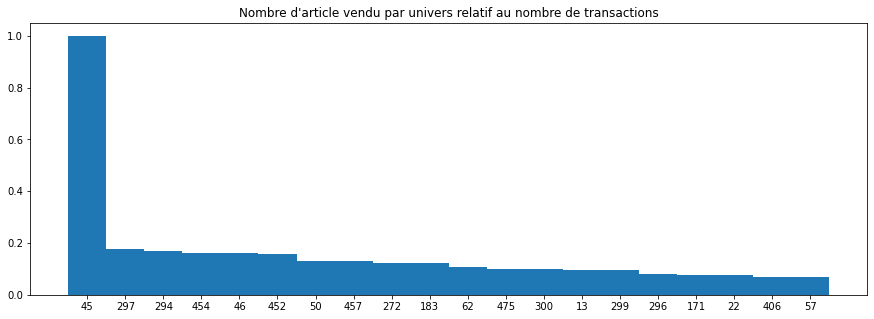

==============46===================
16078
Time Taken to load recurence: ~0secondes


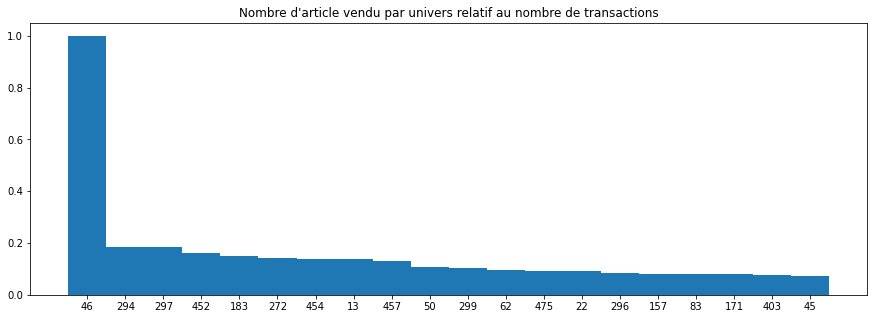

==============47===================
5815
Time Taken to load recurence: ~0secondes


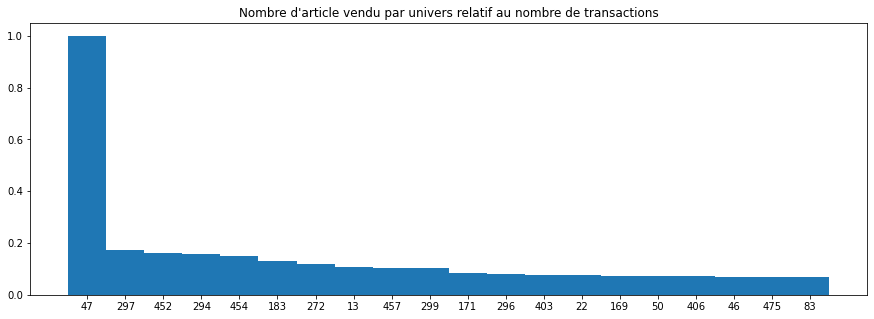

==============48===================
2301
Time Taken to load recurence: ~0secondes


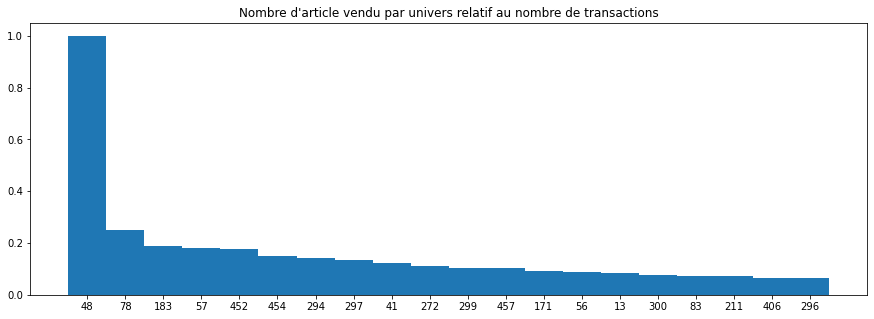

==============49===================
4465
Time Taken to load recurence: ~0secondes


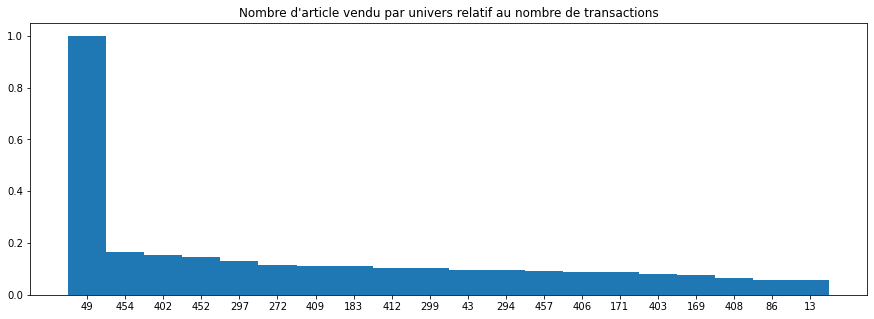

==============50===================
18348
Time Taken to load recurence: ~0secondes


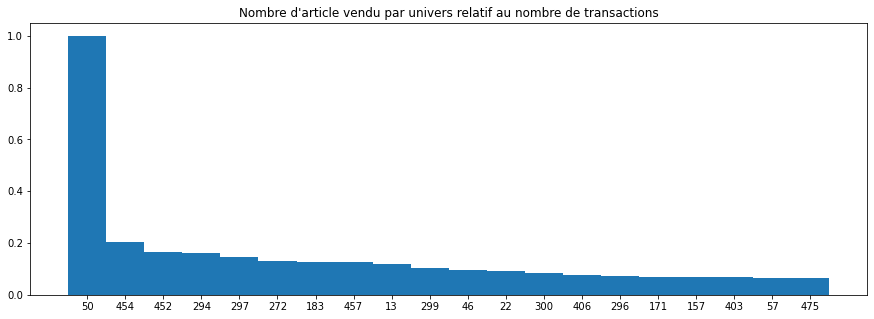

==============51===================
NOT ENOUGH DATA 
==============52===================
50162
Time Taken to load recurence: ~0secondes


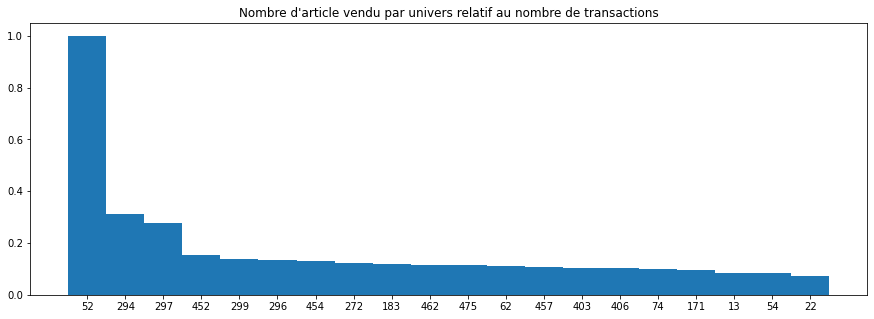

==============53===================
6559
Time Taken to load recurence: ~0secondes


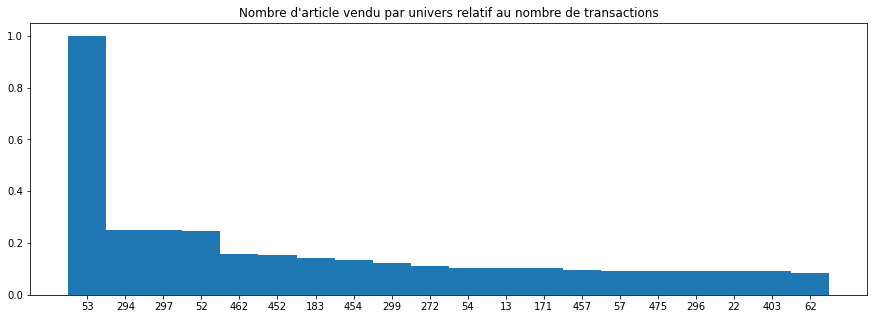

==============54===================
32522
Time Taken to load recurence: ~0secondes


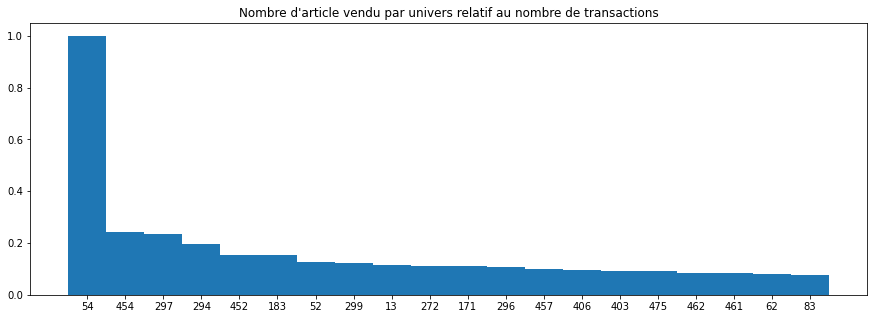

==============55===================
11800
Time Taken to load recurence: ~0secondes


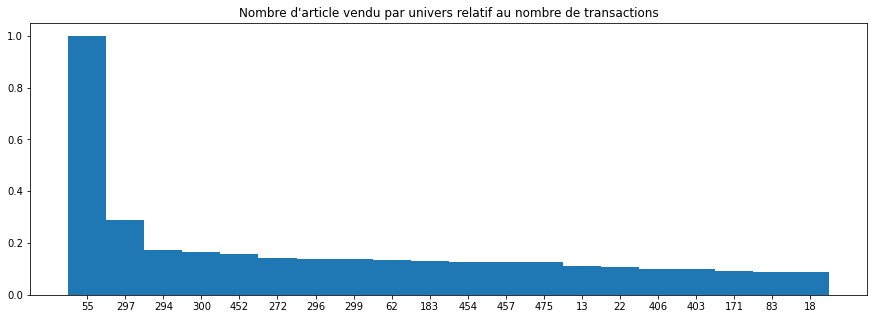

==============56===================
29927
Time Taken to load recurence: ~0secondes


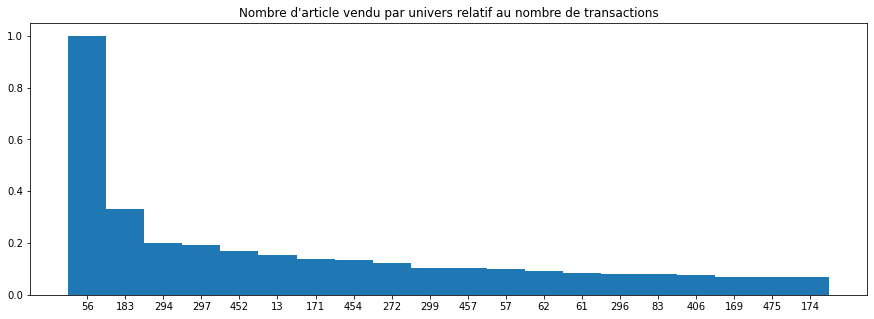

==============57===================
73293
Time Taken to load recurence: ~0secondes


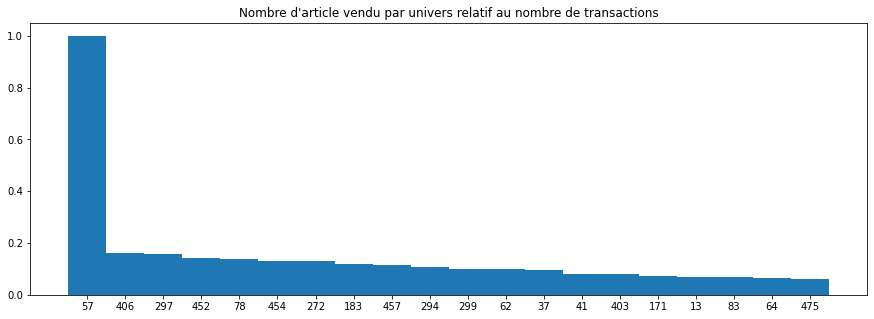

==============58===================
4099
Time Taken to load recurence: ~0secondes


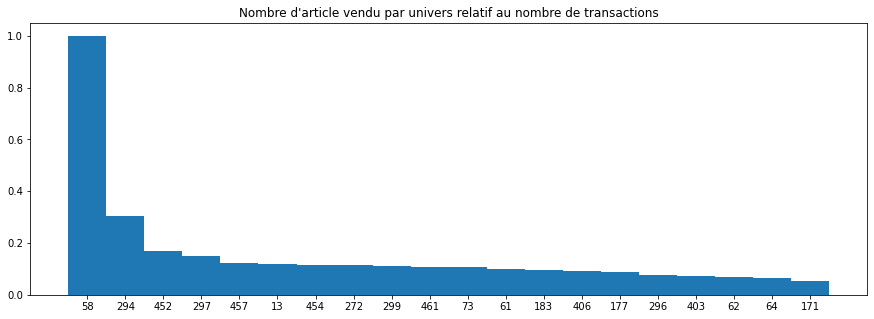

==============59===================
18824
Time Taken to load recurence: ~0secondes


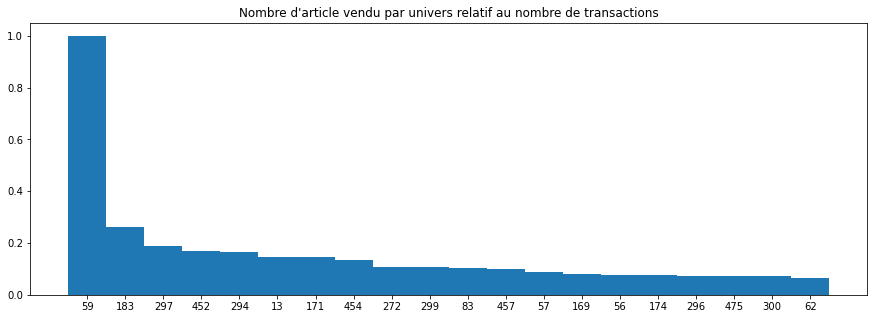

==============60===================
16124
Time Taken to load recurence: ~0secondes


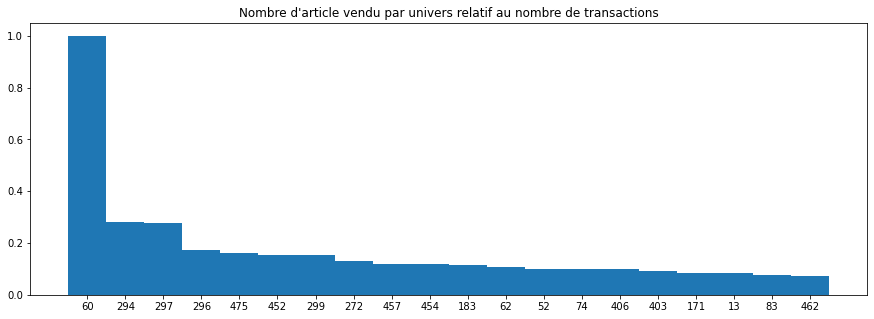

==============61===================
32595
Time Taken to load recurence: ~0secondes


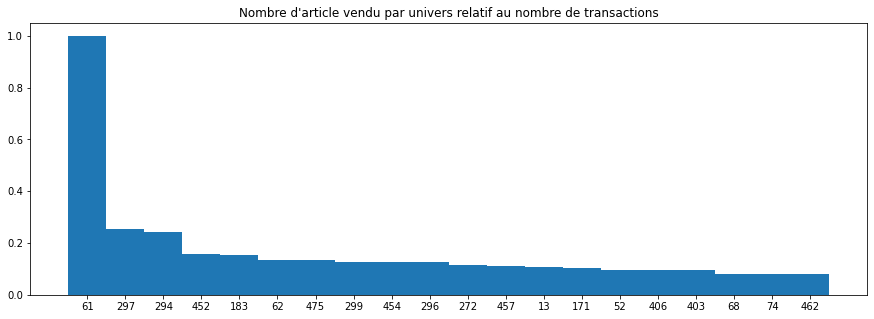

==============62===================
76049
Time Taken to load recurence: ~0secondes


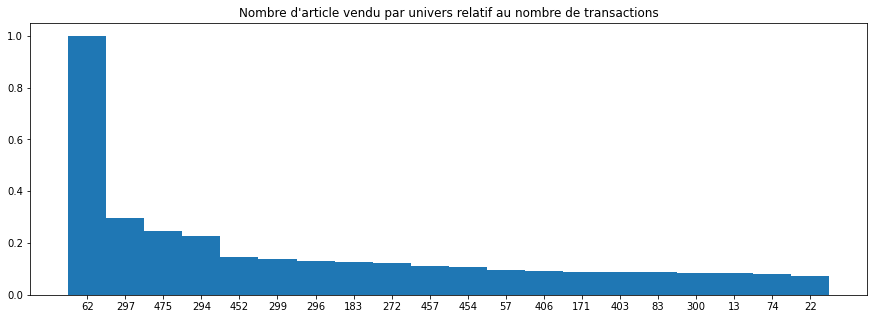

==============63===================
13571
Time Taken to load recurence: ~0secondes


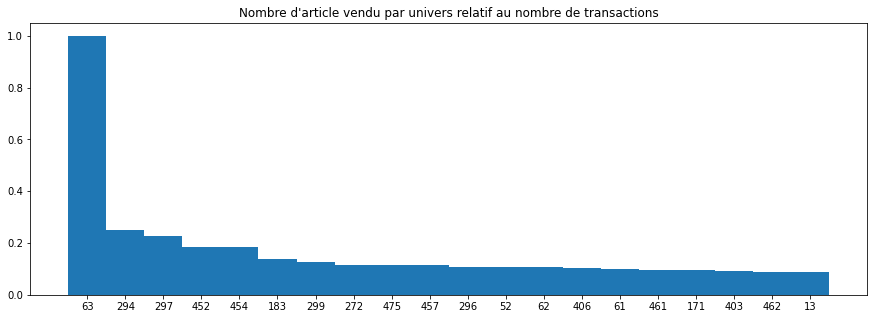

==============64===================
30827
Time Taken to load recurence: ~0secondes


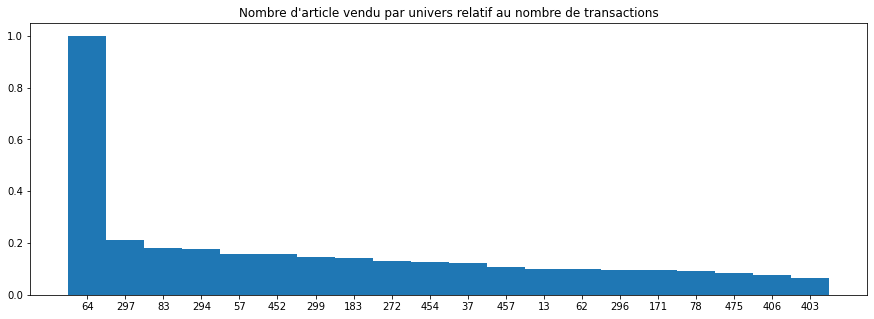

==============65===================
311
Time Taken to load recurence: ~0secondes


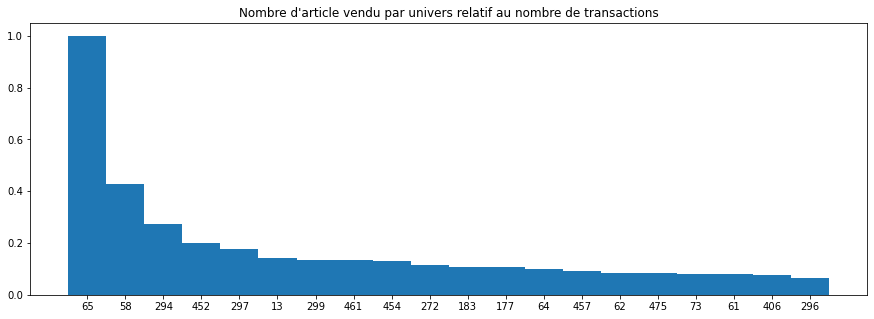

==============66===================
16971
Time Taken to load recurence: ~0secondes


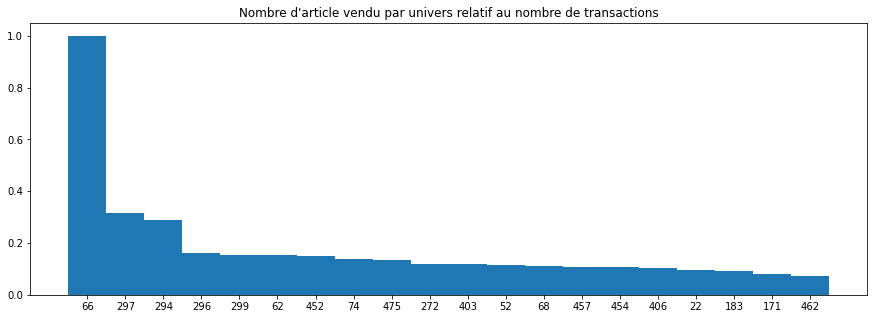

==============67===================
6817
Time Taken to load recurence: ~0secondes


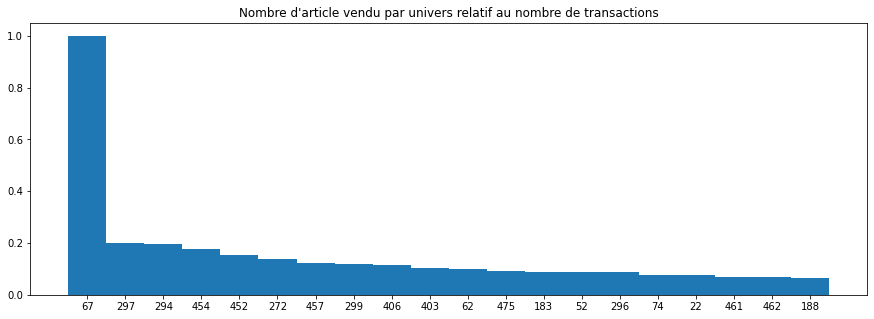

==============68===================
32630
Time Taken to load recurence: ~0secondes


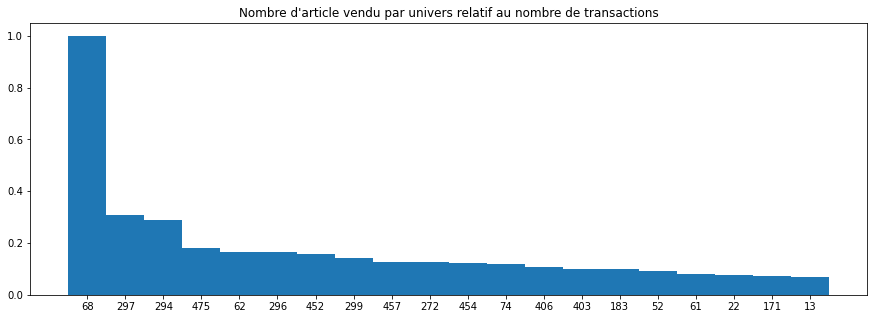

==============69===================
23534
Time Taken to load recurence: ~0secondes


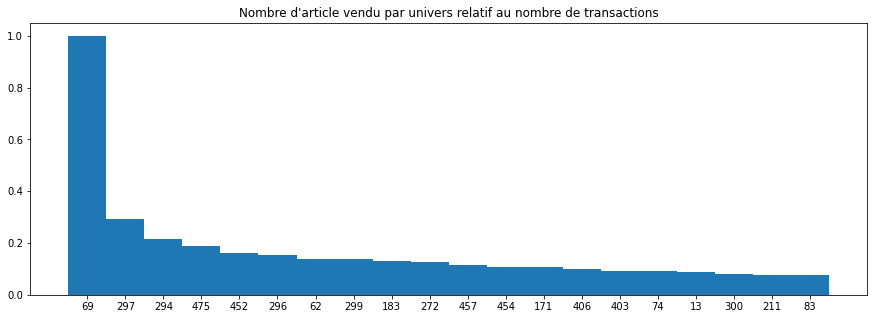

==============70===================
6066
Time Taken to load recurence: ~0secondes


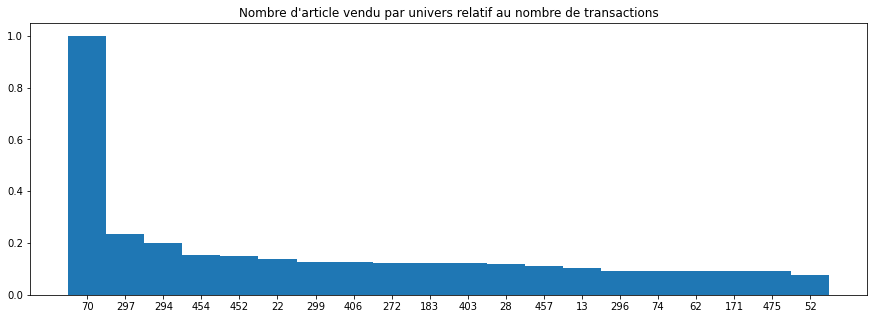

==============72===================
13485
Time Taken to load recurence: ~0secondes


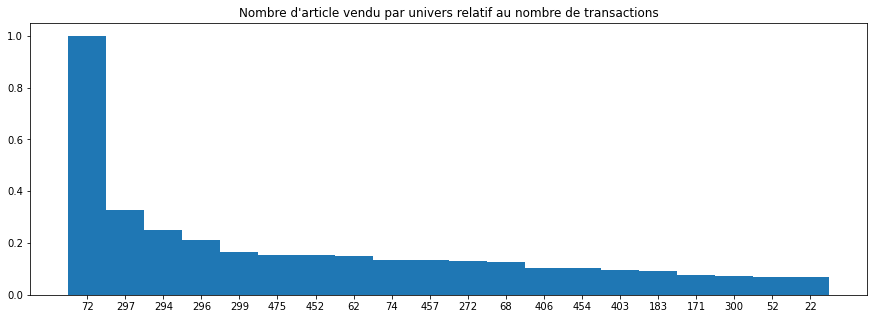

==============73===================
19199
Time Taken to load recurence: ~0secondes


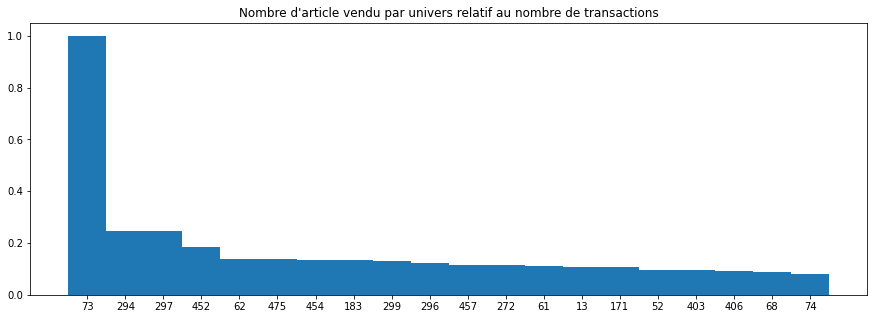

==============74===================
77161
Time Taken to load recurence: ~0secondes


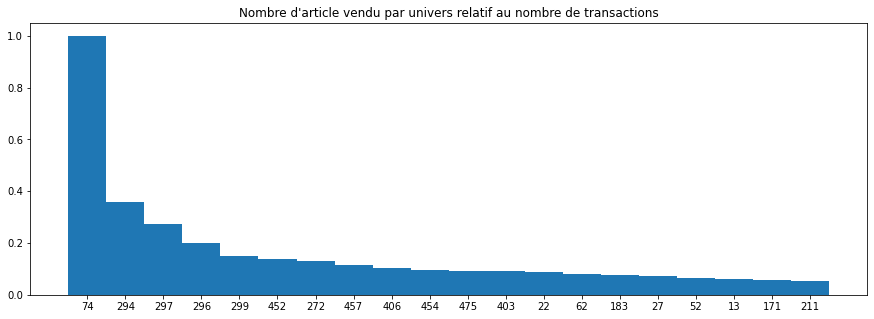

==============75===================
248
Time Taken to load recurence: ~0secondes


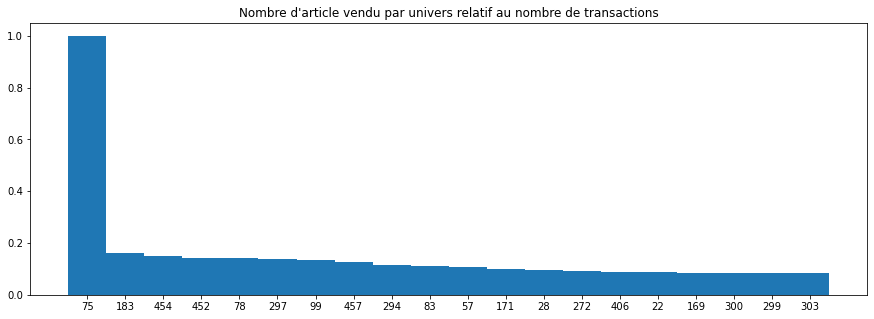

==============76===================
1754
Time Taken to load recurence: ~0secondes


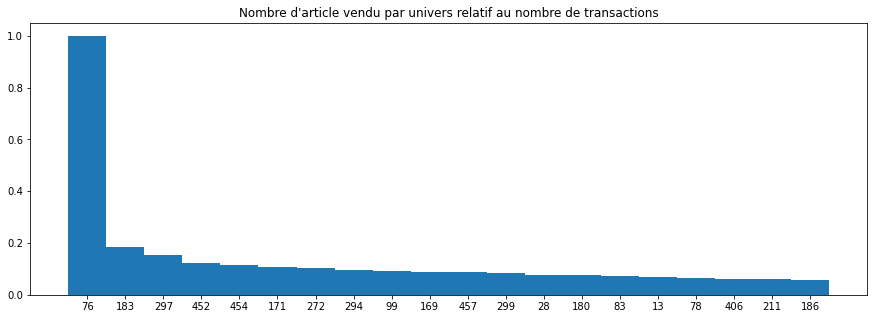

==============77===================
1118
Time Taken to load recurence: ~0secondes


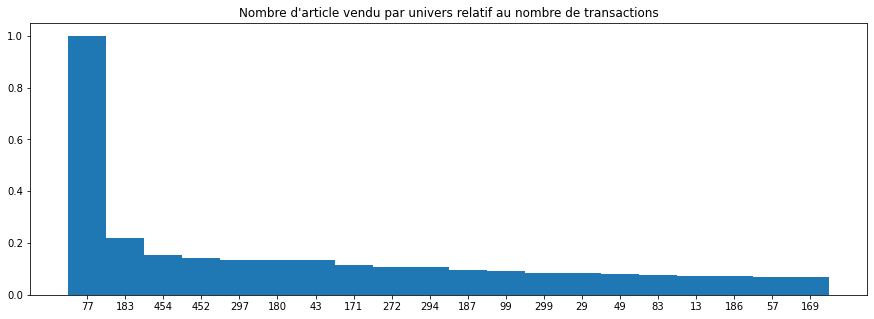

==============78===================
35575
Time Taken to load recurence: ~0secondes


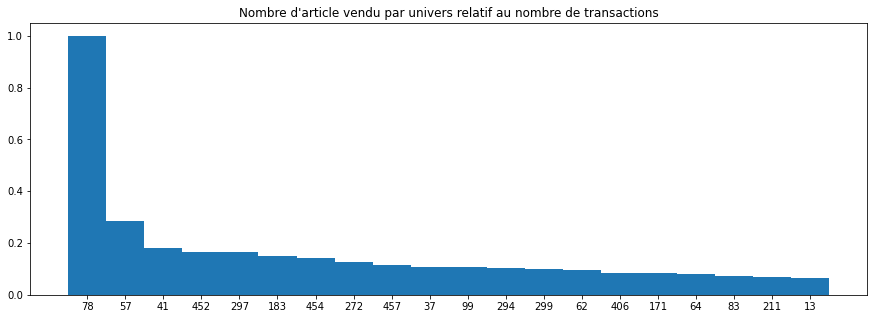

==============79===================
3815
Time Taken to load recurence: ~0secondes


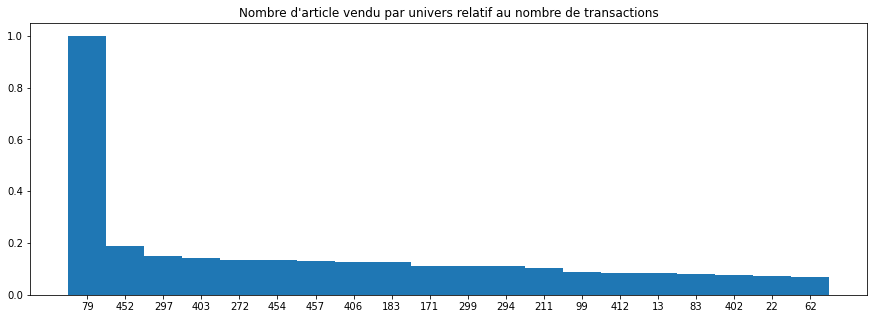

==============80===================
906
Time Taken to load recurence: ~0secondes


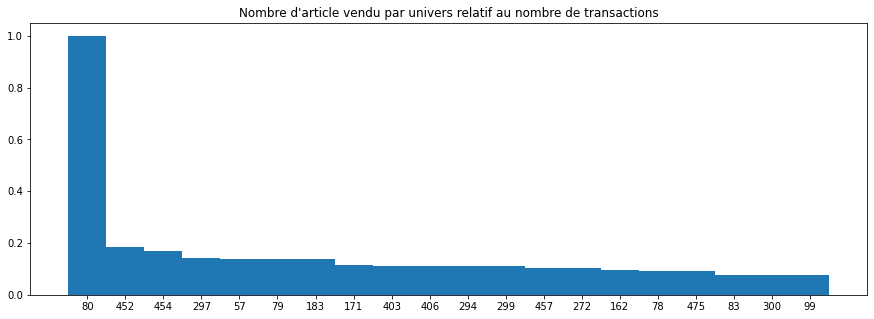

==============81===================
6895
Time Taken to load recurence: ~0secondes


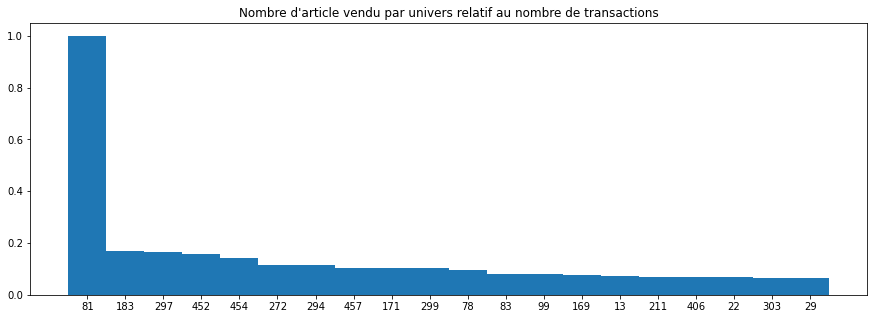

==============83===================
81312
Time Taken to load recurence: ~0secondes


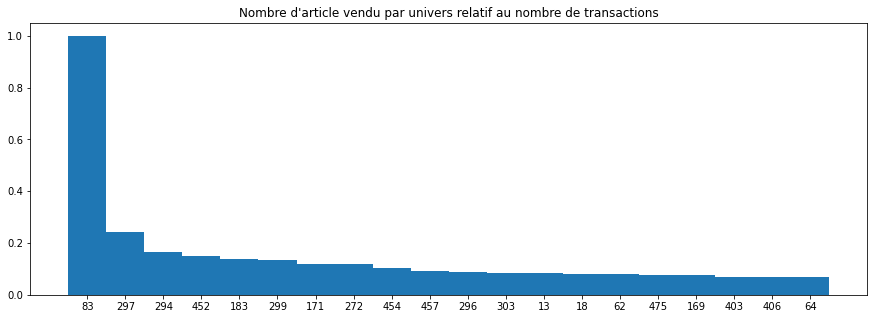

==============84===================
3514
Time Taken to load recurence: ~0secondes


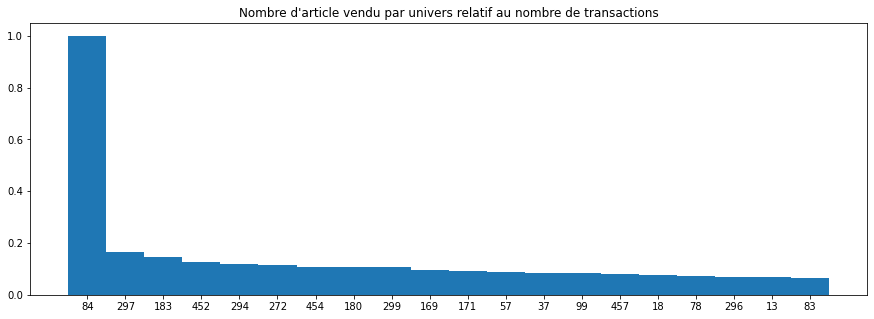

==============85===================
5305
Time Taken to load recurence: ~0secondes


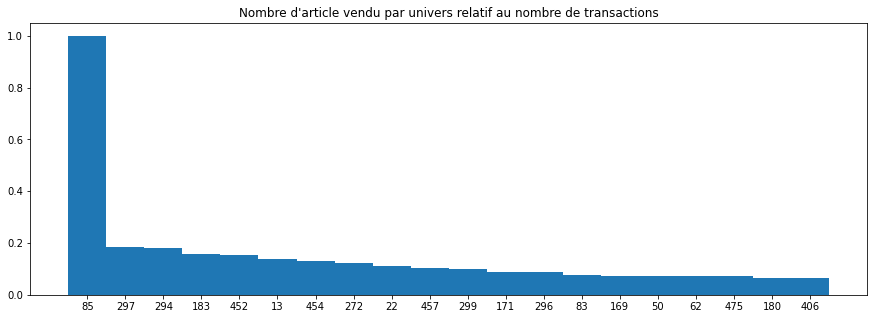

==============86===================
16842
Time Taken to load recurence: ~0secondes


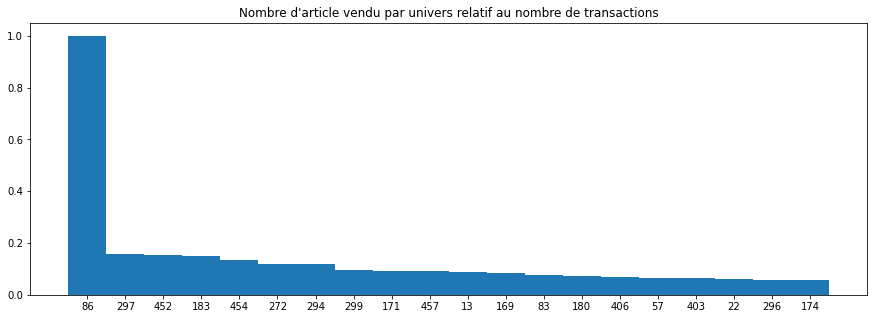

==============88===================
7067
Time Taken to load recurence: ~0secondes


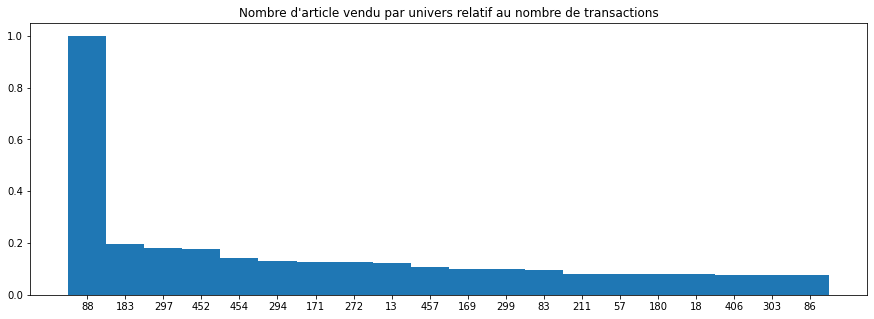

==============89===================
1672
Time Taken to load recurence: ~0secondes


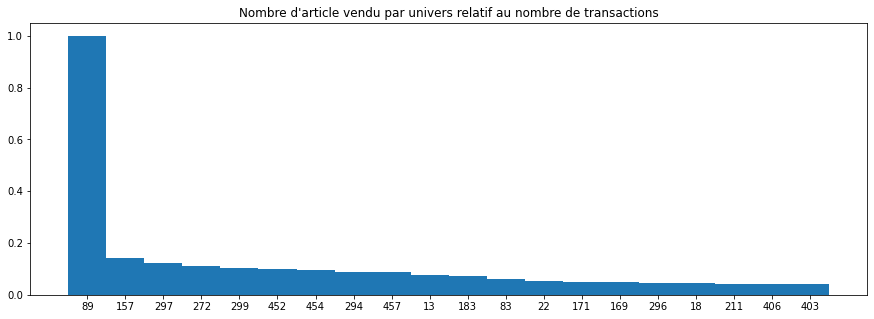

==============90===================
2159
Time Taken to load recurence: ~0secondes


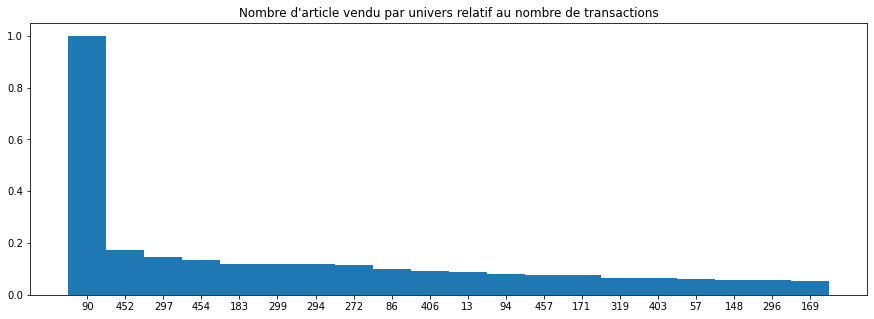

==============91===================
3580
Time Taken to load recurence: ~0secondes


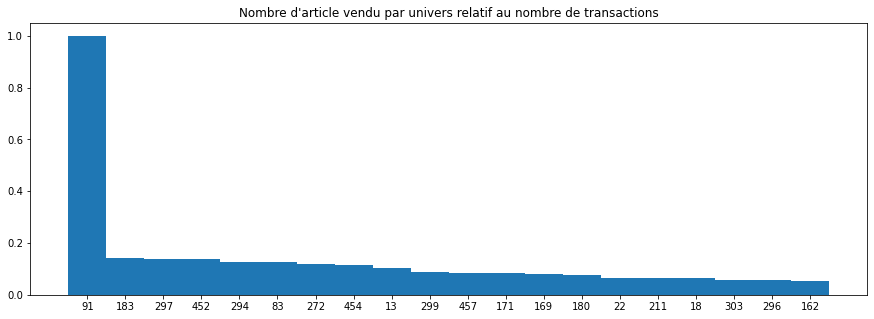

==============92===================
6070
Time Taken to load recurence: ~0secondes


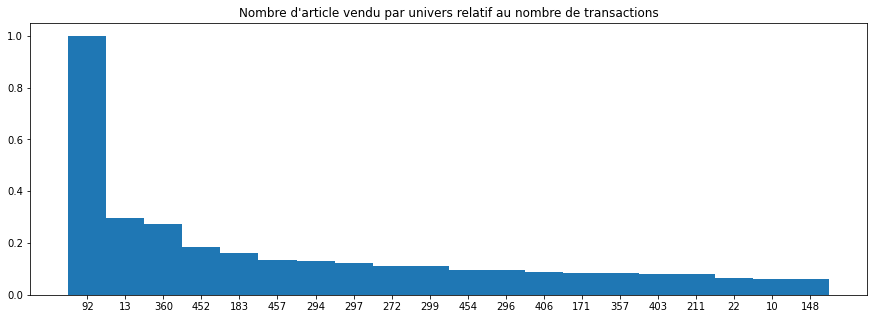

==============93===================
3593
Time Taken to load recurence: ~0secondes


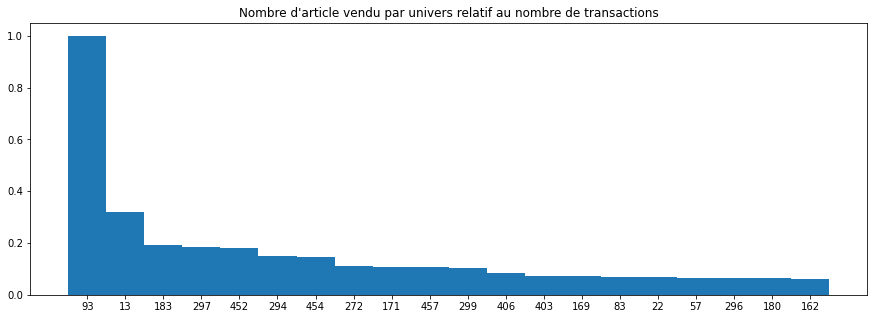

==============94===================
4275
Time Taken to load recurence: ~0secondes


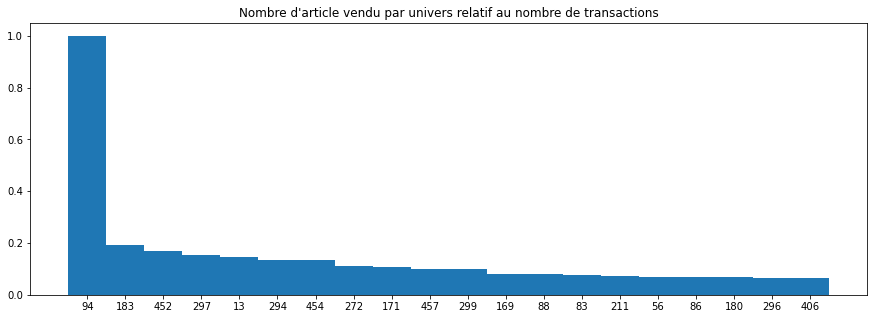

==============95===================
6707
Time Taken to load recurence: ~0secondes


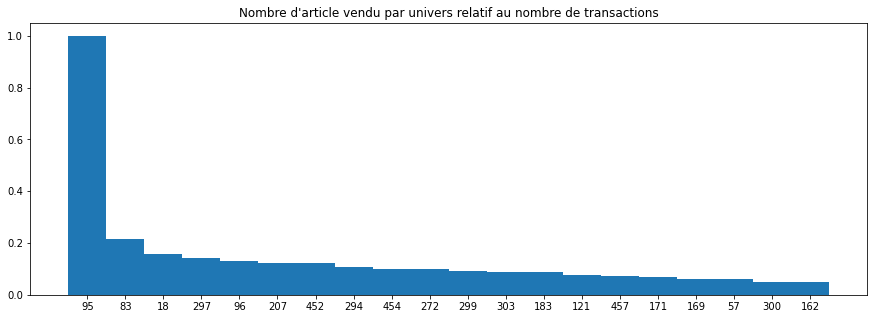

==============96===================
10034
Time Taken to load recurence: ~0secondes


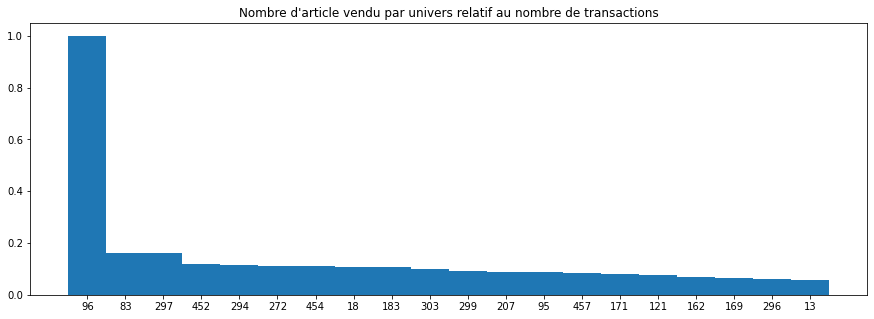

==============98===================
21849
Time Taken to load recurence: ~0secondes


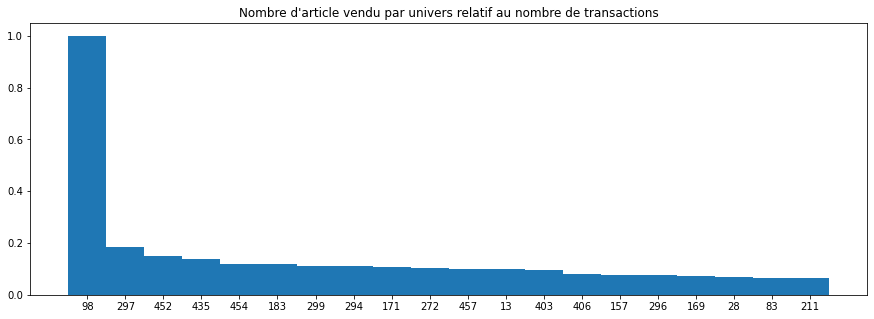

==============99===================
29267
Time Taken to load recurence: ~0secondes


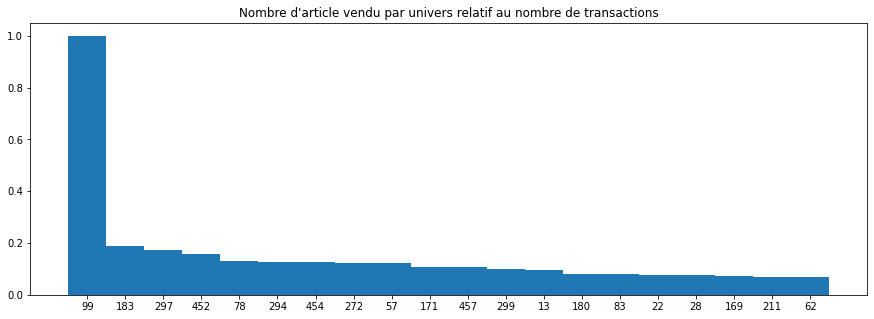

==============100===================
9720
Time Taken to load recurence: ~0secondes


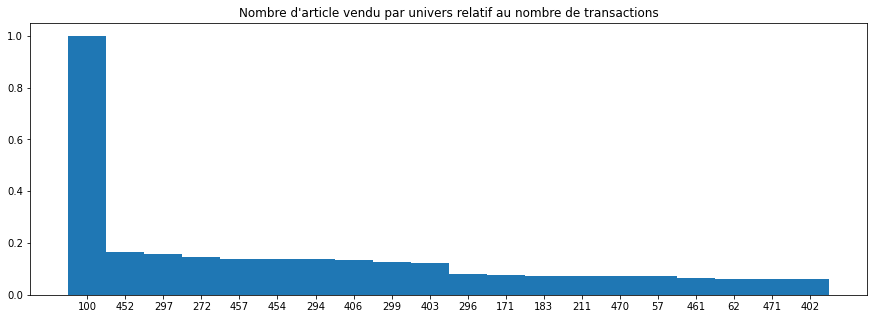

==============101===================
12233
Time Taken to load recurence: ~0secondes


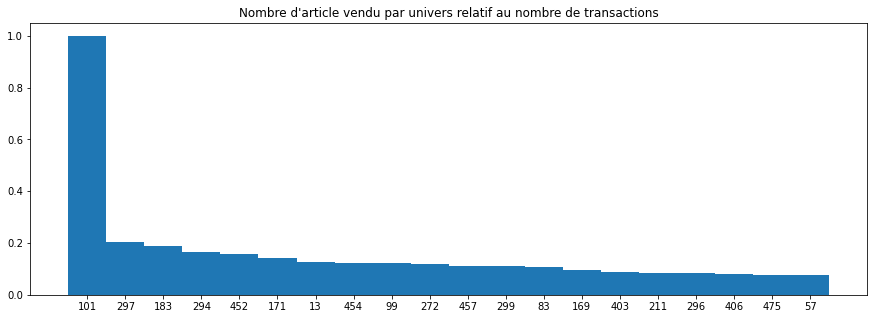

==============102===================
3959
Time Taken to load recurence: ~0secondes


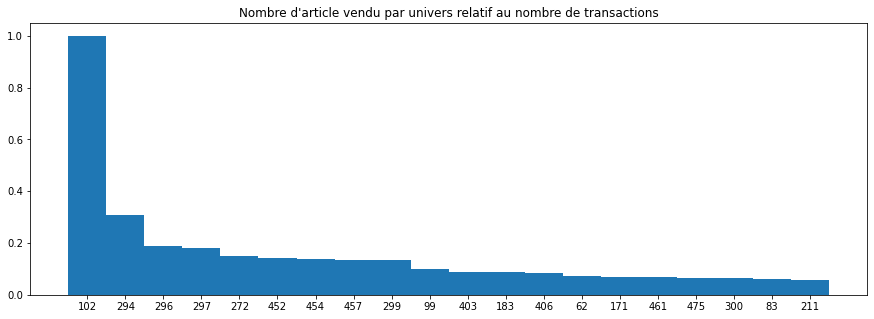

==============105===================
1320
Time Taken to load recurence: ~0secondes


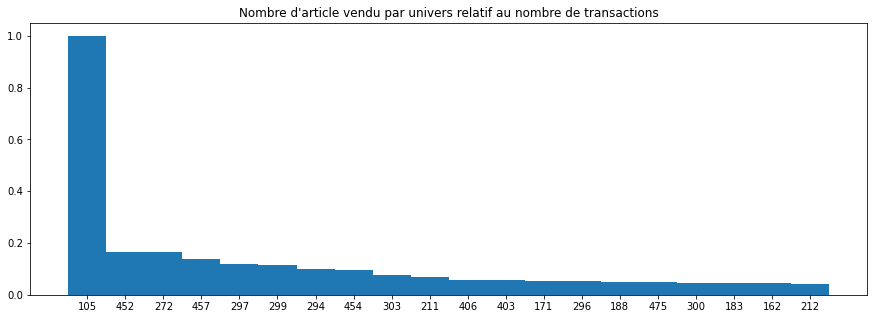

==============106===================
1511
Time Taken to load recurence: ~0secondes


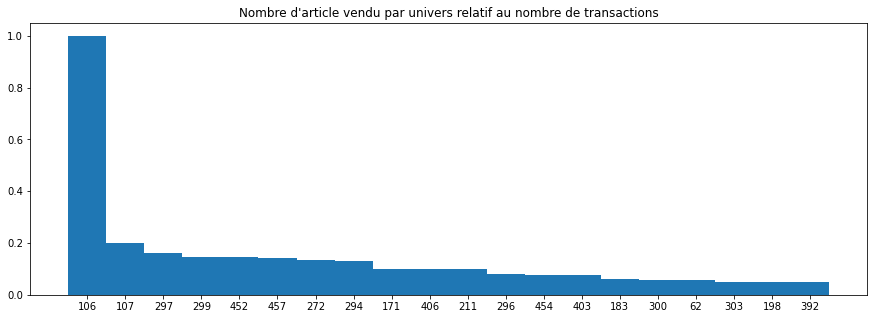

==============107===================
2226
Time Taken to load recurence: ~0secondes


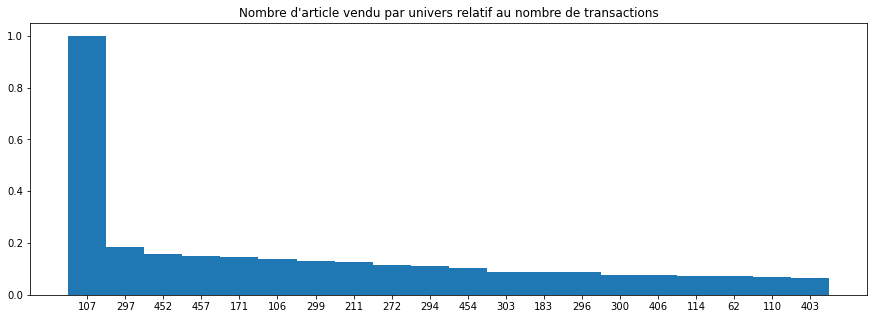

==============108===================
625
Time Taken to load recurence: ~0secondes


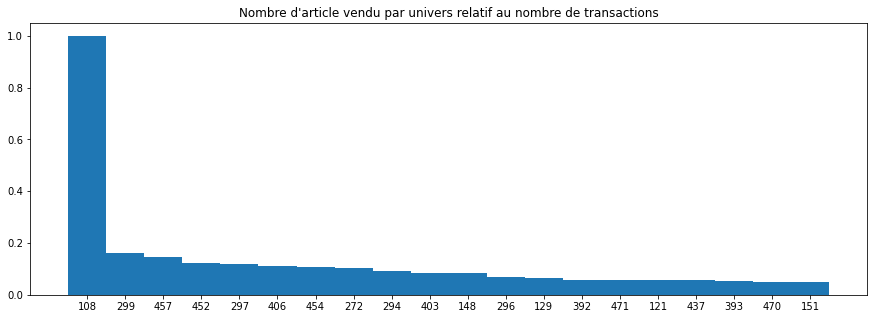

==============109===================
2703
Time Taken to load recurence: ~0secondes


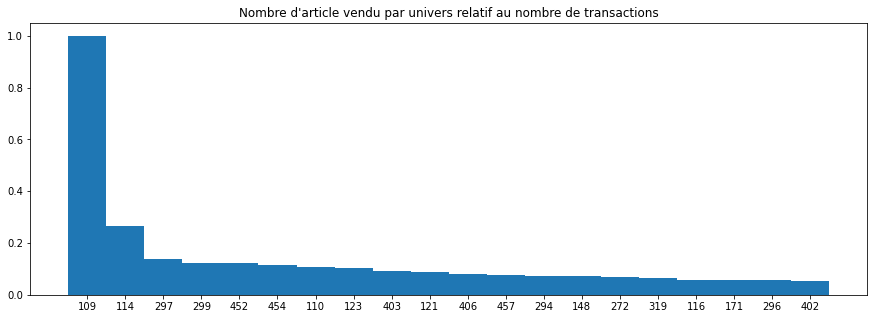

==============110===================
59196
Time Taken to load recurence: ~0secondes


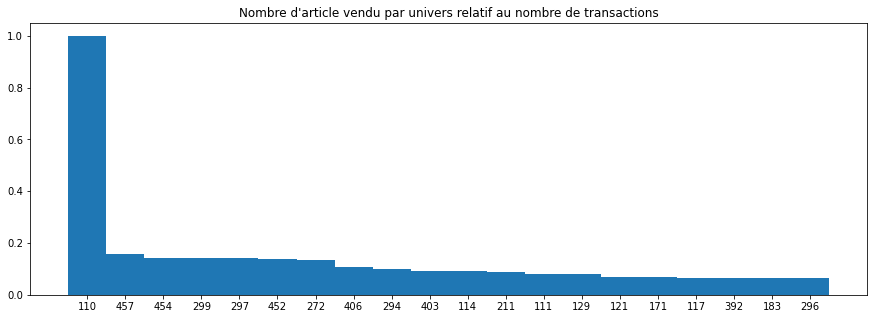

==============111===================
40663
Time Taken to load recurence: ~0secondes


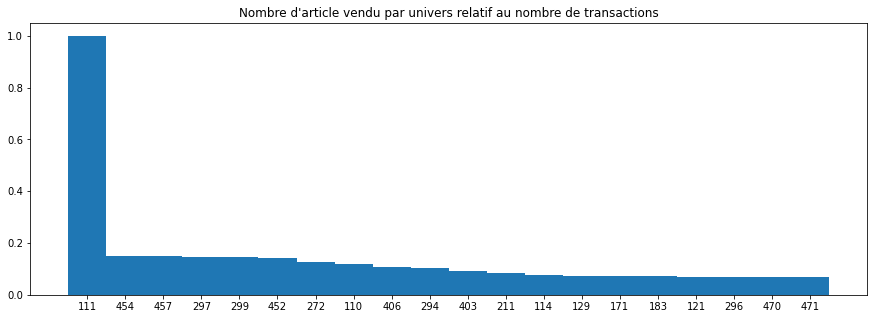

==============112===================
3728
Time Taken to load recurence: ~0secondes


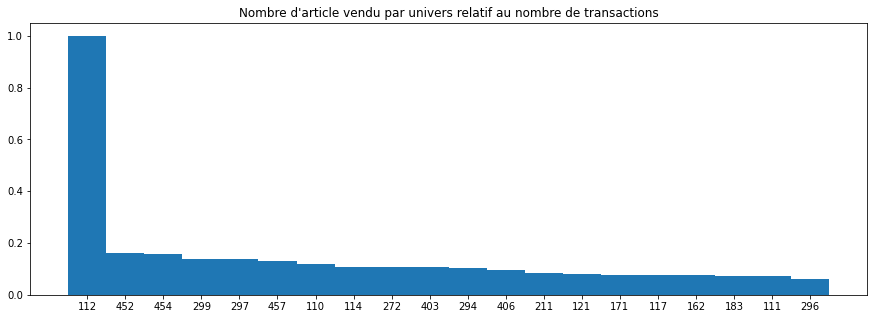

==============113===================
21890
Time Taken to load recurence: ~0secondes


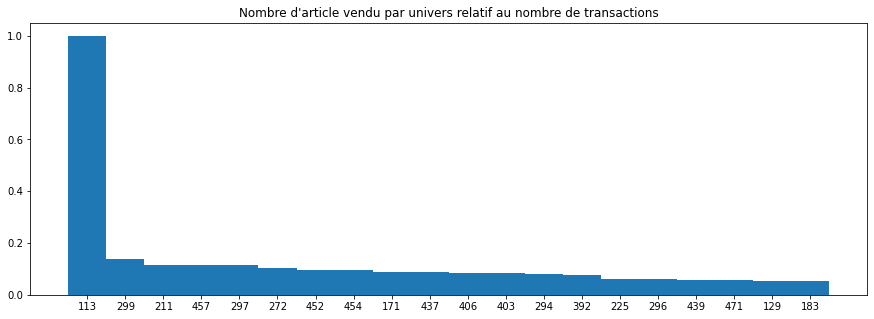

==============114===================
51921
Time Taken to load recurence: ~0secondes


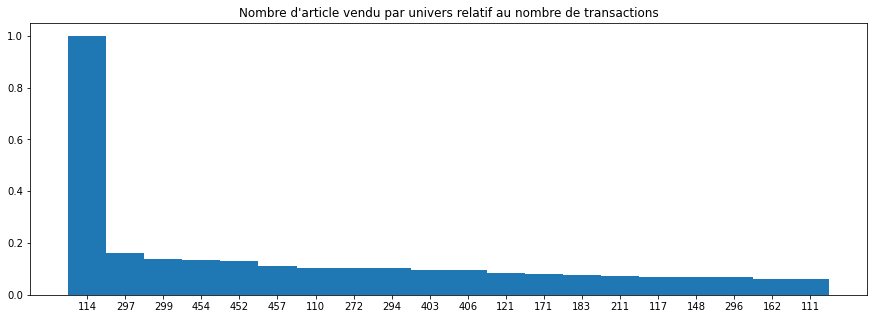

==============115===================
21562
Time Taken to load recurence: ~0secondes


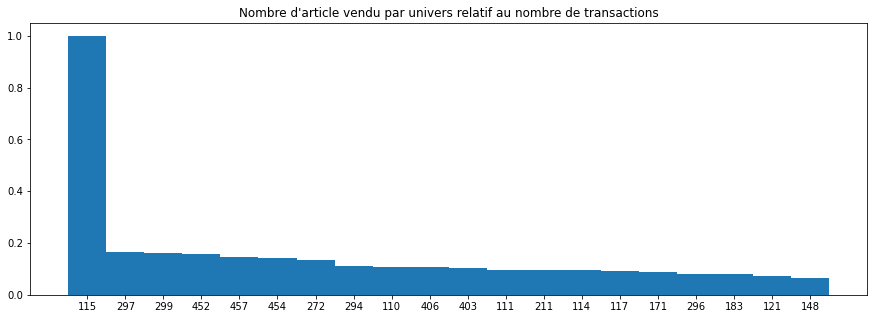

==============116===================
21945
Time Taken to load recurence: ~0secondes


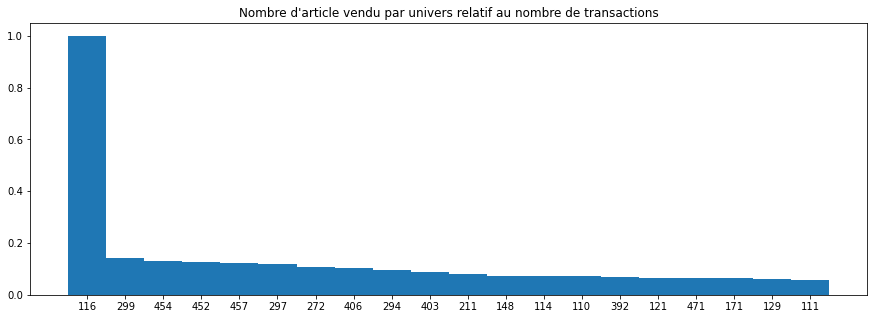

==============117===================
58372
Time Taken to load recurence: ~0secondes


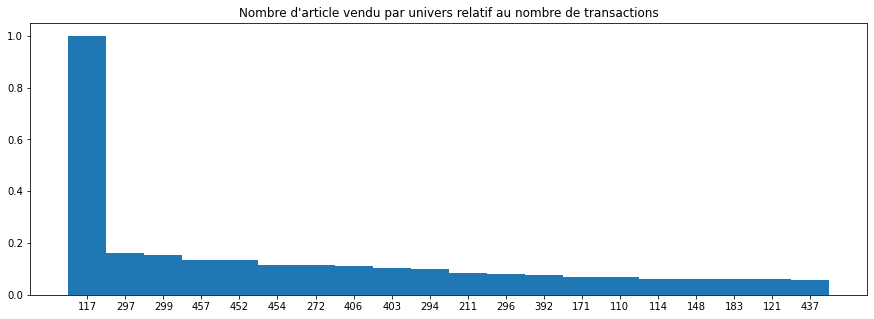

==============118===================
1106
Time Taken to load recurence: ~0secondes


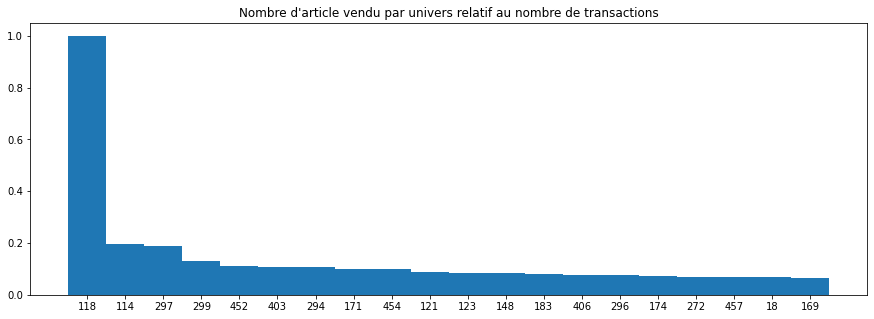

==============119===================
4911
Time Taken to load recurence: ~0secondes


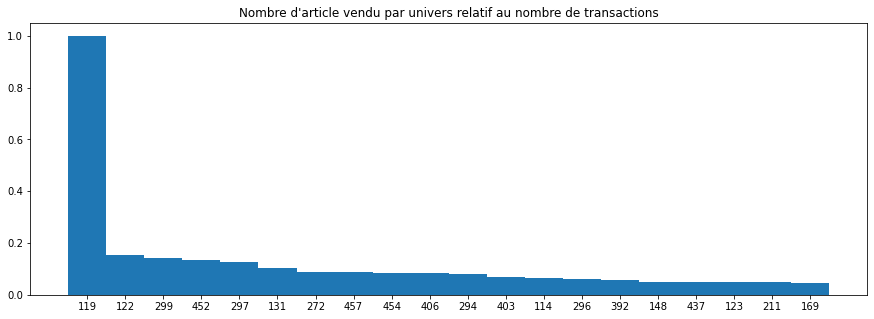

==============120===================
57203
Time Taken to load recurence: ~0secondes


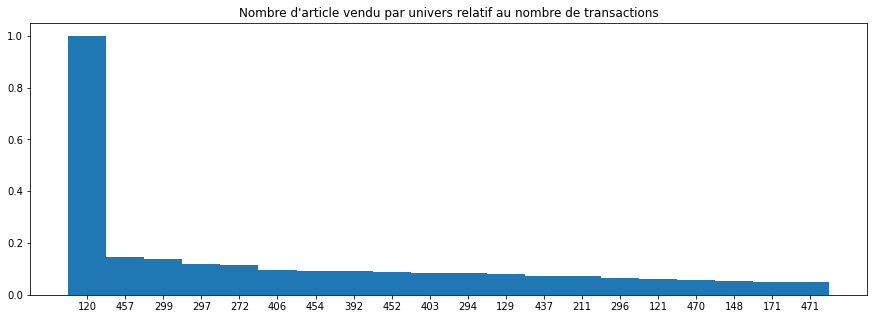

==============121===================
74070
Time Taken to load recurence: ~0secondes


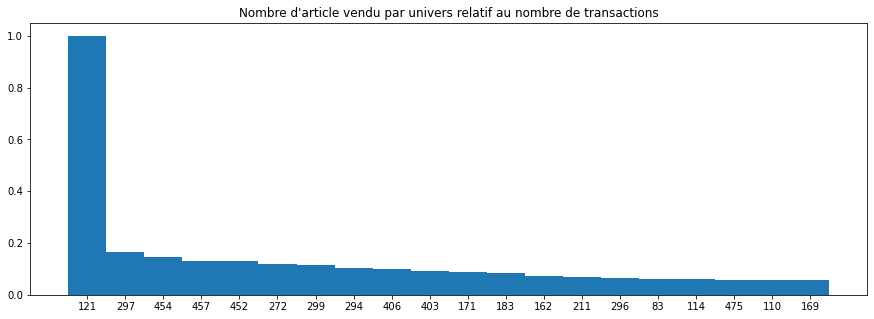

==============122===================
35470
Time Taken to load recurence: ~0secondes


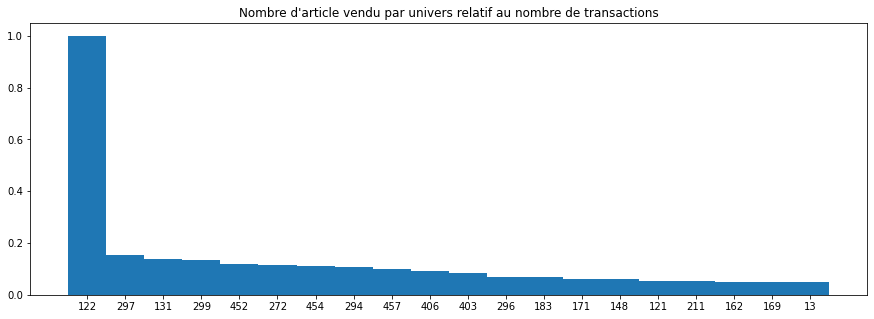

==============123===================
23651
Time Taken to load recurence: ~0secondes


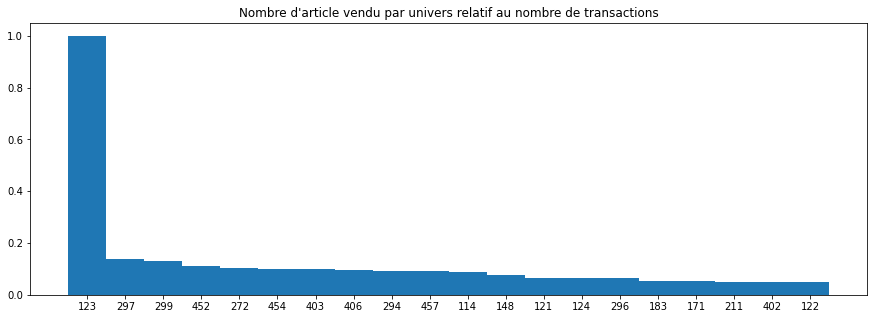

==============124===================
16130
Time Taken to load recurence: ~0secondes


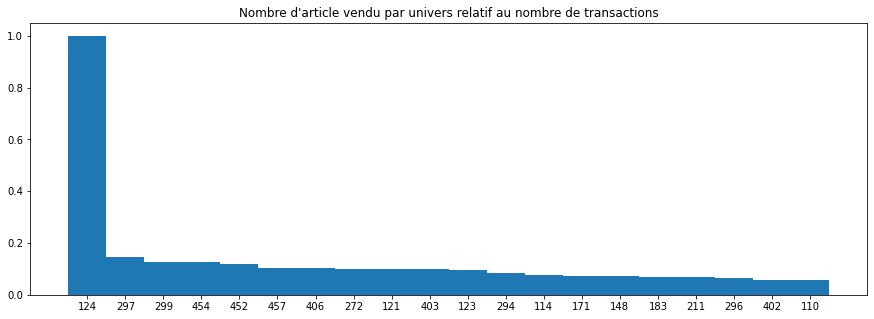

==============125===================
328
Time Taken to load recurence: ~0secondes


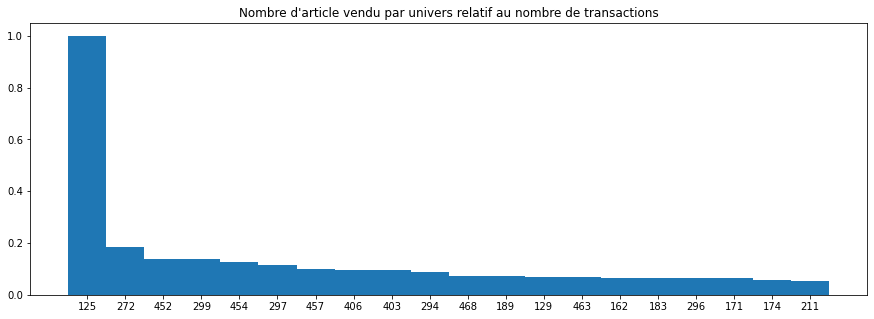

==============126===================
36826
Time Taken to load recurence: ~0secondes


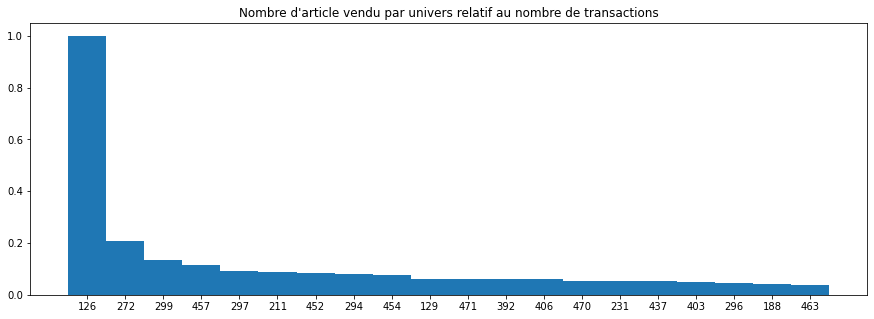

==============127===================
7047
Time Taken to load recurence: ~0secondes


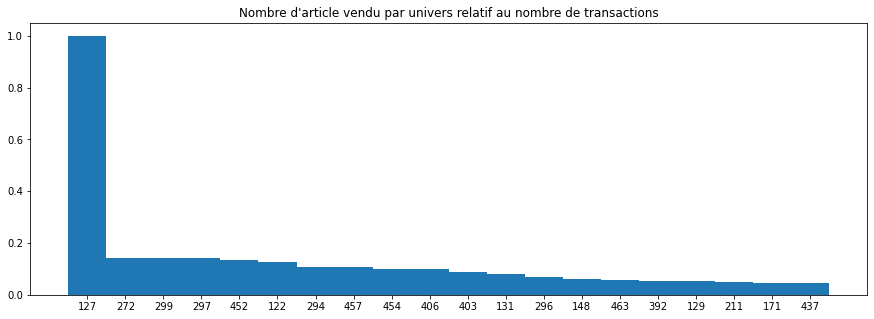

==============128===================
6740
Time Taken to load recurence: ~0secondes


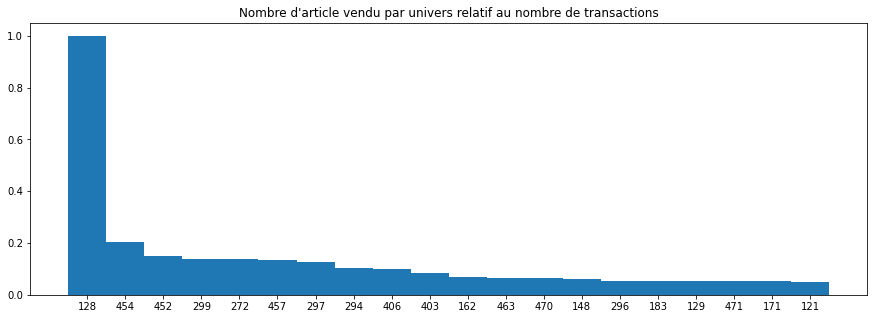

==============129===================
100339
Time Taken to load recurence: ~0secondes


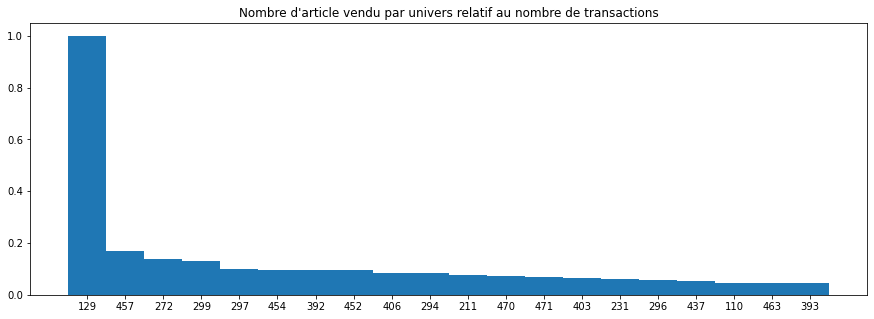

==============130===================
22647
Time Taken to load recurence: ~0secondes


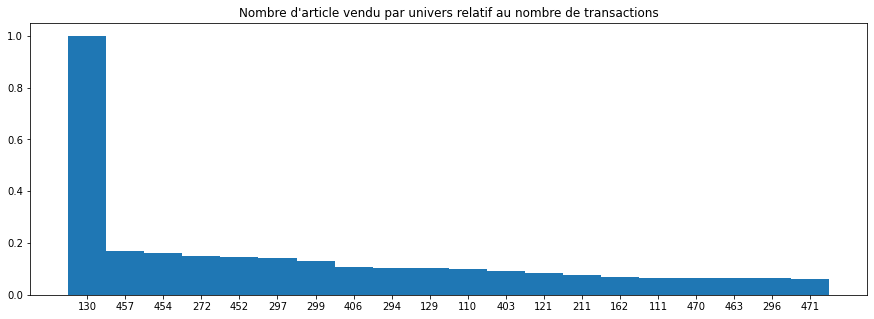

==============131===================
27888
Time Taken to load recurence: ~0secondes


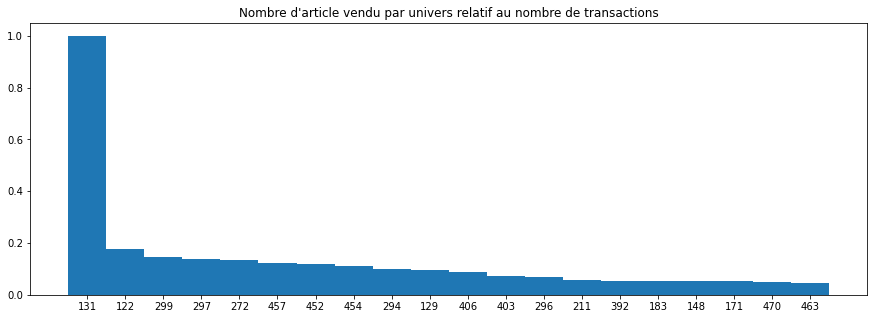

==============132===================
23518
Time Taken to load recurence: ~0secondes


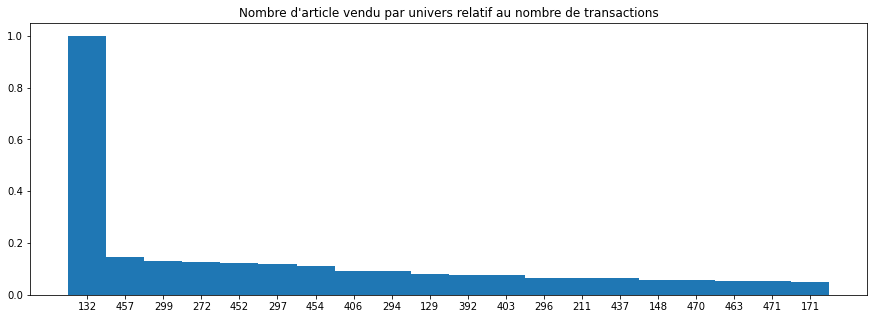

==============133===================
27135
Time Taken to load recurence: ~0secondes


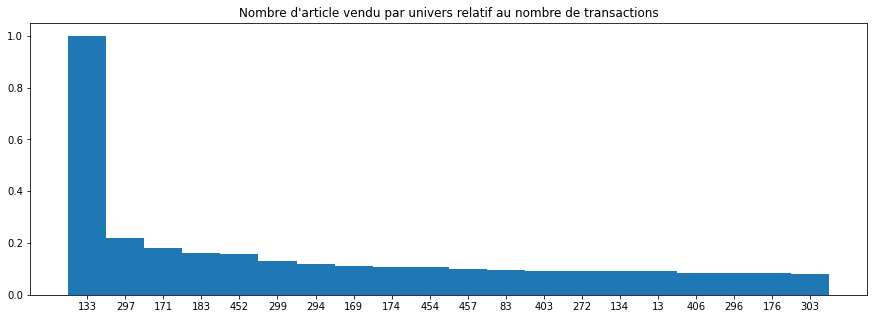

==============134===================
41911
Time Taken to load recurence: ~0secondes


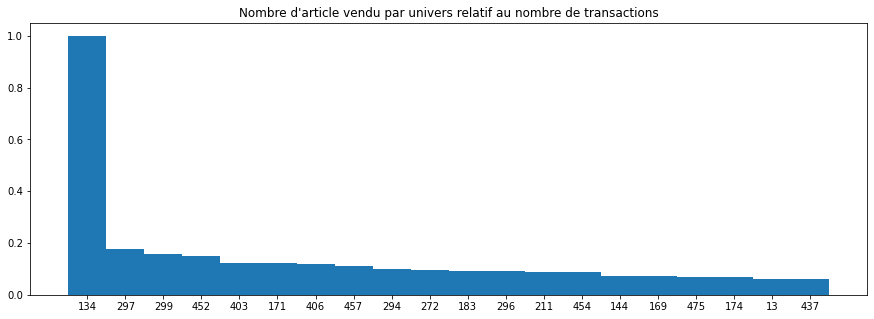

==============135===================
13358
Time Taken to load recurence: ~0secondes


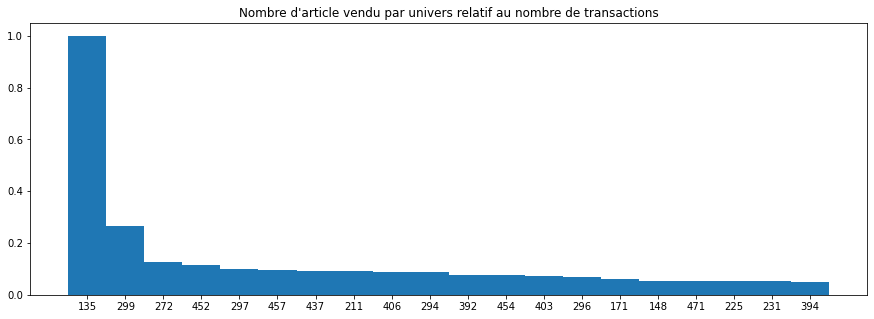

==============136===================
11072
Time Taken to load recurence: ~0secondes


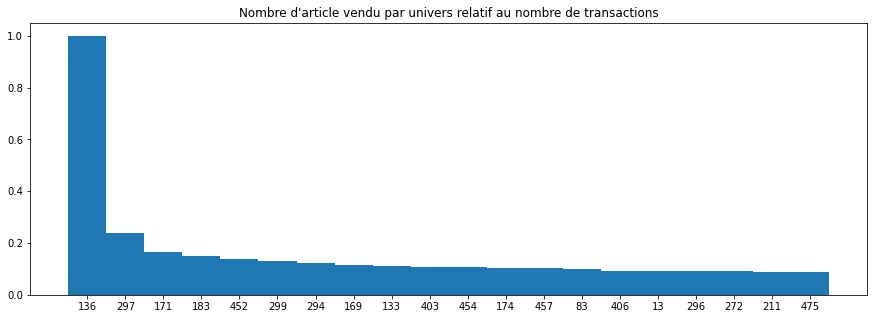

==============137===================
19899
Time Taken to load recurence: ~0secondes


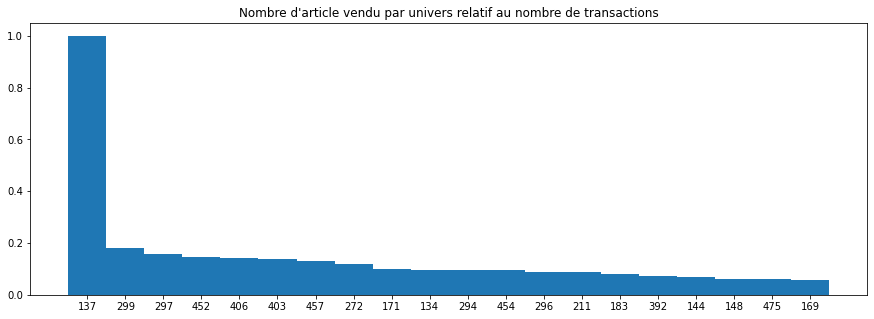

==============138===================
NOT ENOUGH DATA 
==============139===================
17269
Time Taken to load recurence: ~0secondes


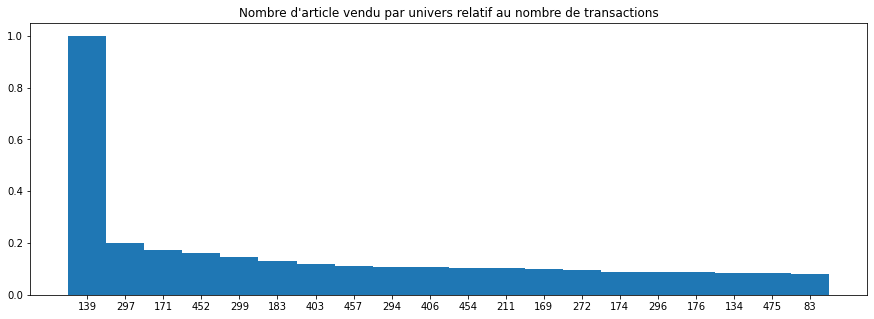

==============140===================
3884
Time Taken to load recurence: ~0secondes


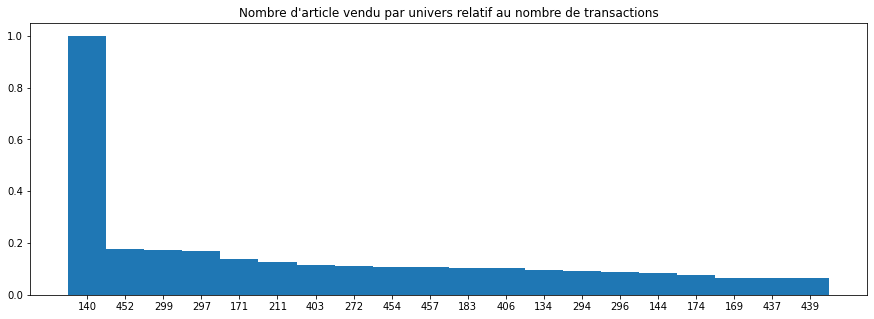

==============141===================
15530
Time Taken to load recurence: ~0secondes


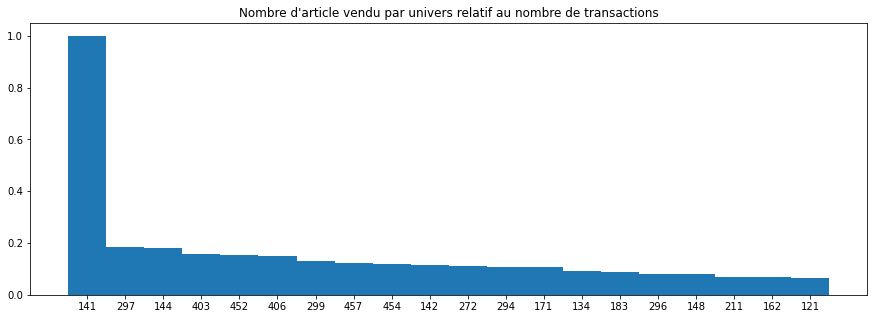

==============142===================
39902
Time Taken to load recurence: ~0secondes


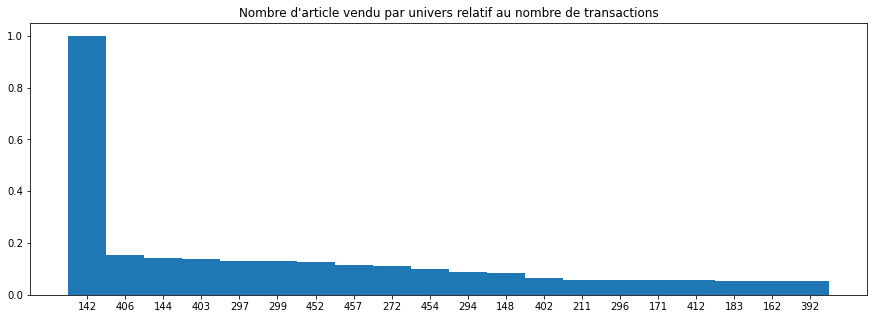

==============143===================
2282
Time Taken to load recurence: ~0secondes


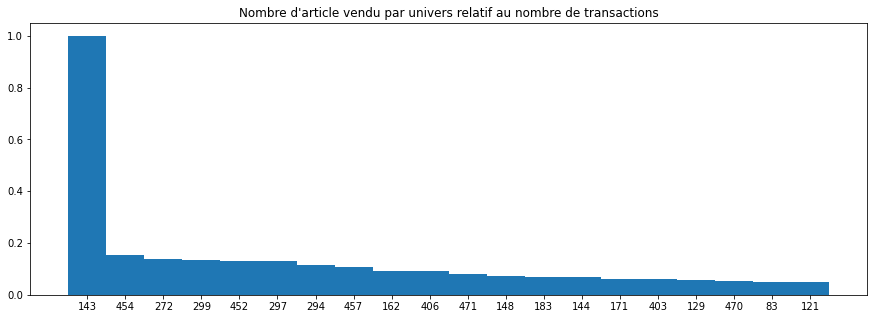

==============144===================
63469
Time Taken to load recurence: ~0secondes


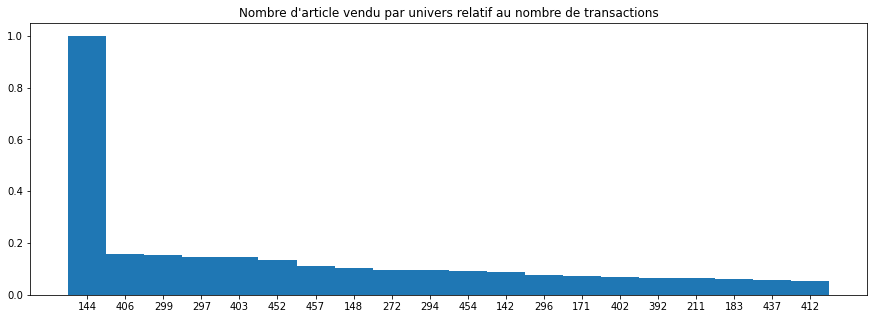

==============145===================
5467
Time Taken to load recurence: ~0secondes


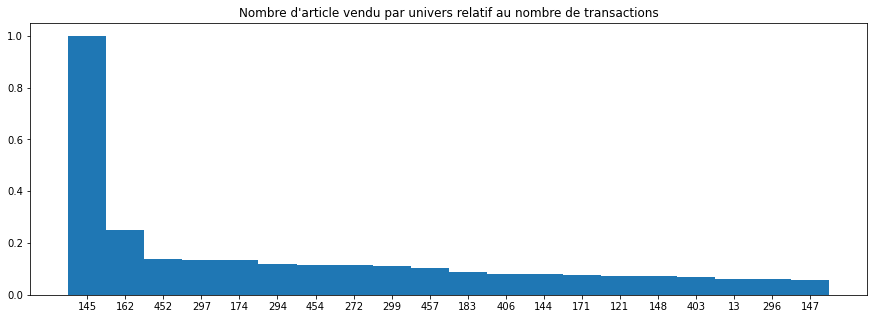

==============146===================
NOT ENOUGH DATA 
==============147===================
63069
Time Taken to load recurence: ~0secondes


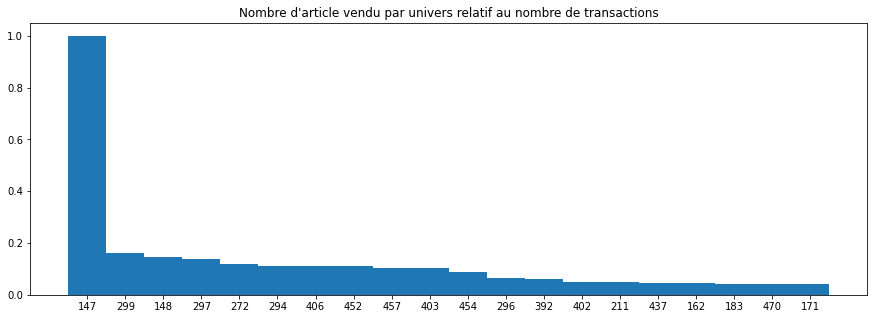

==============148===================
142973
Time Taken to load recurence: ~0secondes


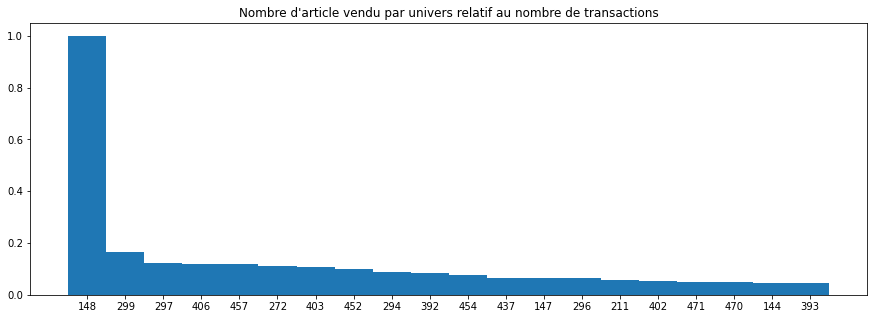

==============149===================
17945
Time Taken to load recurence: ~0secondes


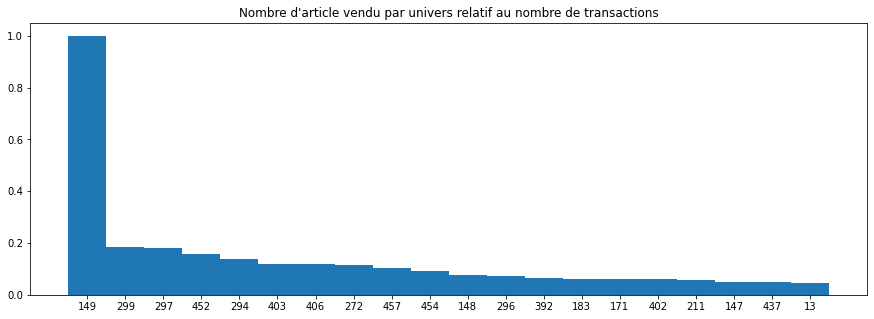

==============150===================
12550
Time Taken to load recurence: ~0secondes


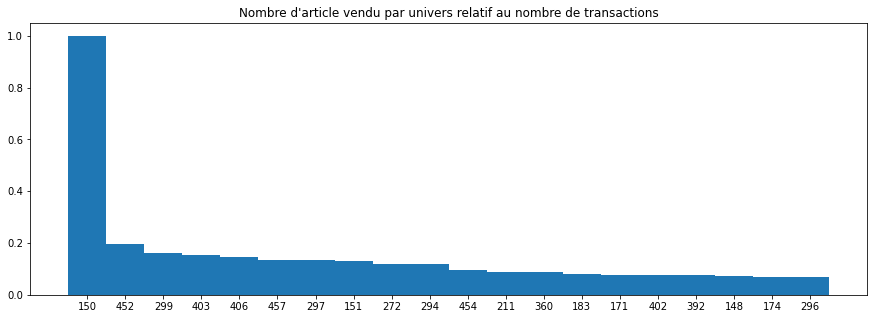

==============151===================
65382
Time Taken to load recurence: ~0secondes


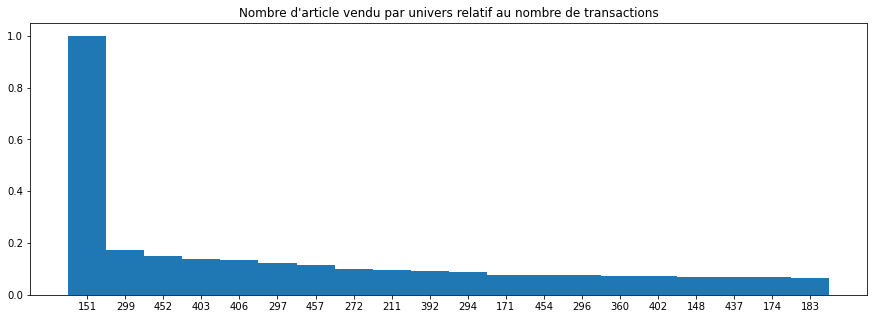

==============152===================
979
Time Taken to load recurence: ~0secondes


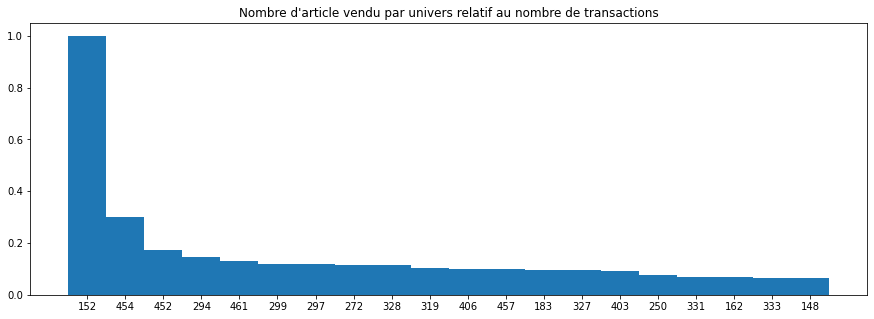

==============153===================
3973
Time Taken to load recurence: ~0secondes


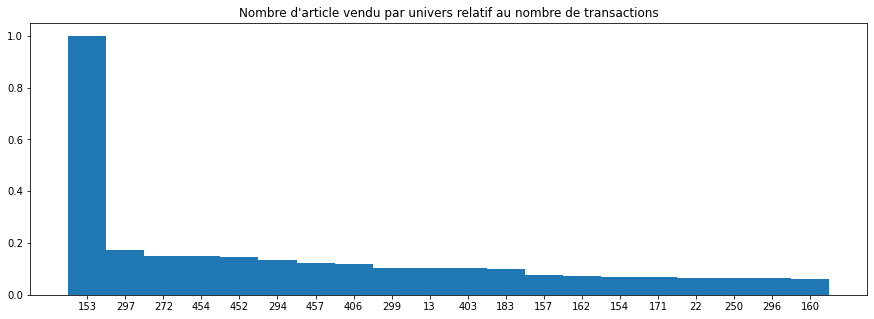

==============154===================
44774
Time Taken to load recurence: ~0secondes


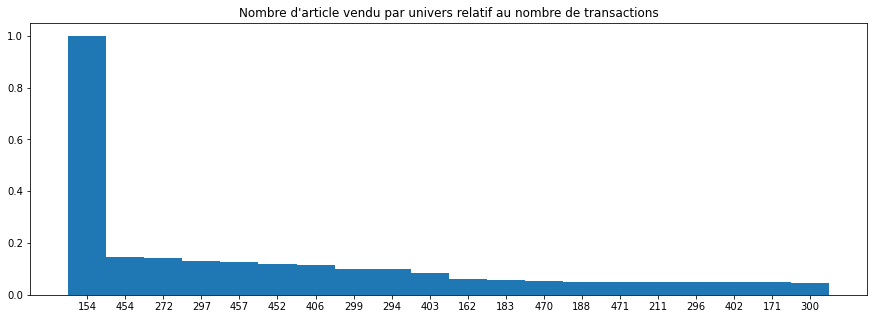

==============155===================
4242
Time Taken to load recurence: ~0secondes


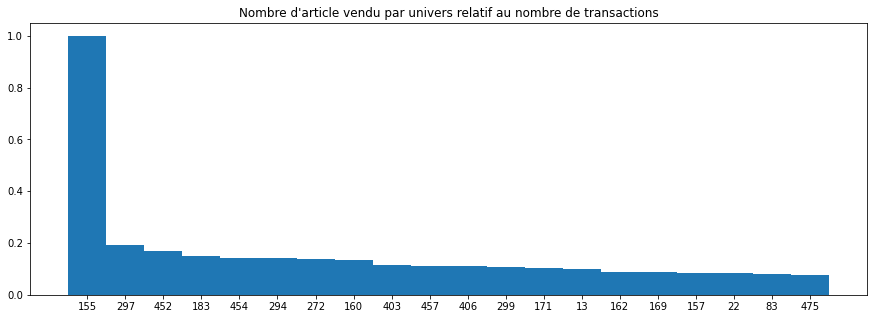

==============156===================
7158
Time Taken to load recurence: ~0secondes


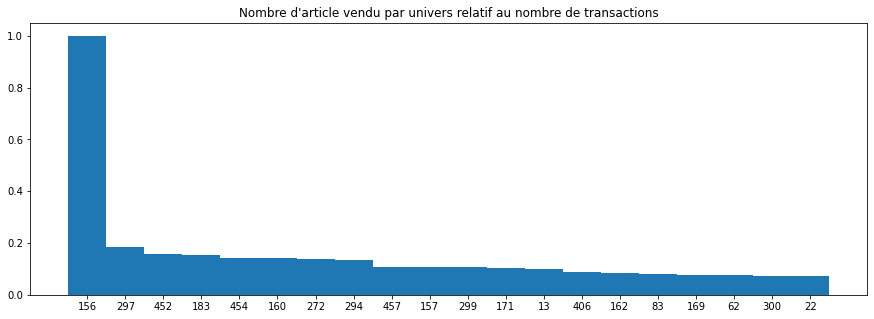

==============157===================
34317
Time Taken to load recurence: ~0secondes


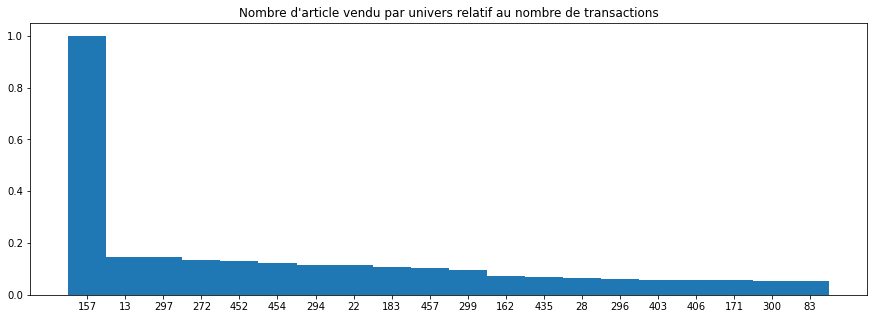

==============158===================
159
Time Taken to load recurence: ~0secondes


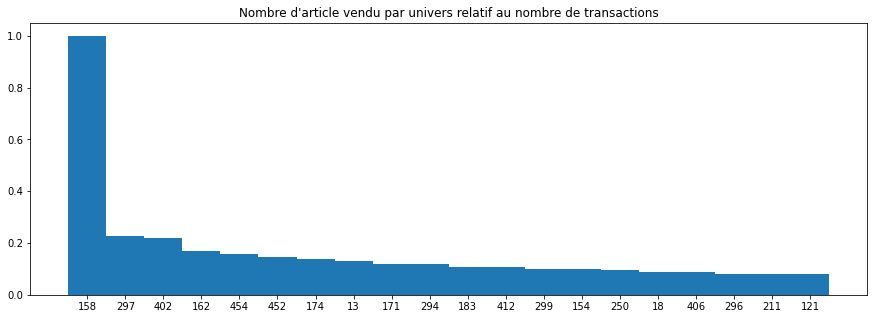

==============159===================
2835
Time Taken to load recurence: ~0secondes


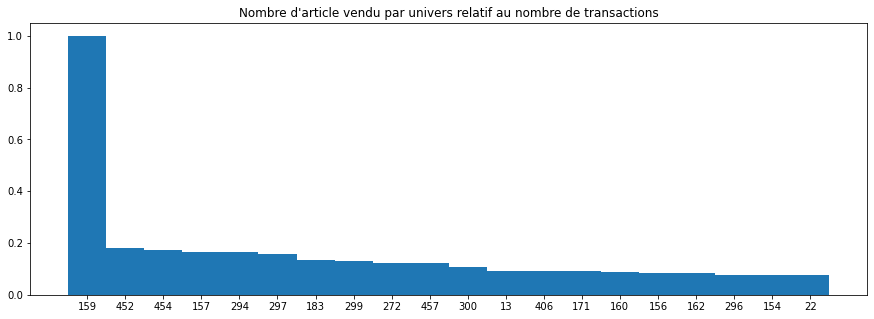

==============160===================
16759
Time Taken to load recurence: ~0secondes


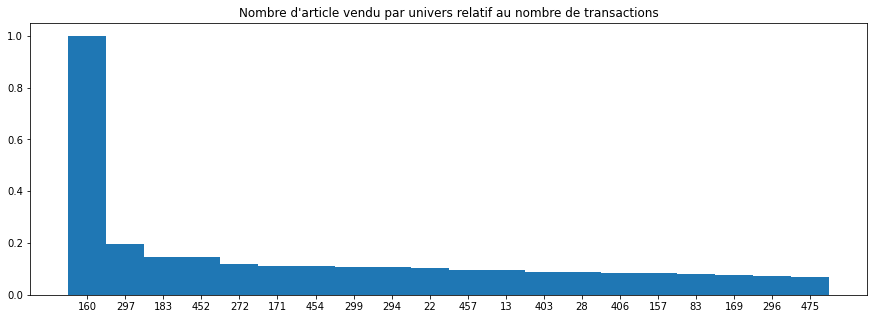

==============162===================
102932
Time Taken to load recurence: ~0secondes


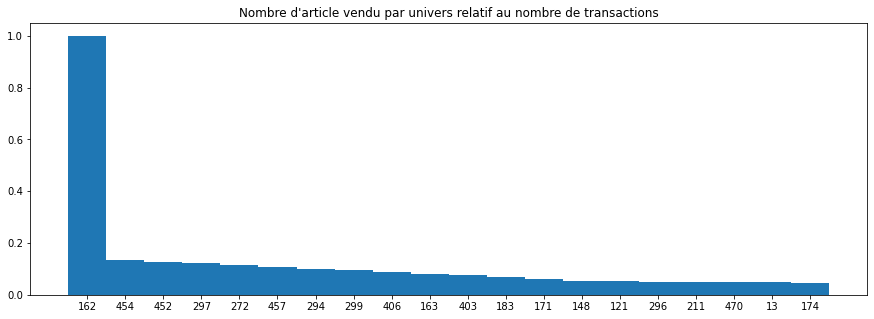

==============163===================
46665
Time Taken to load recurence: ~0secondes


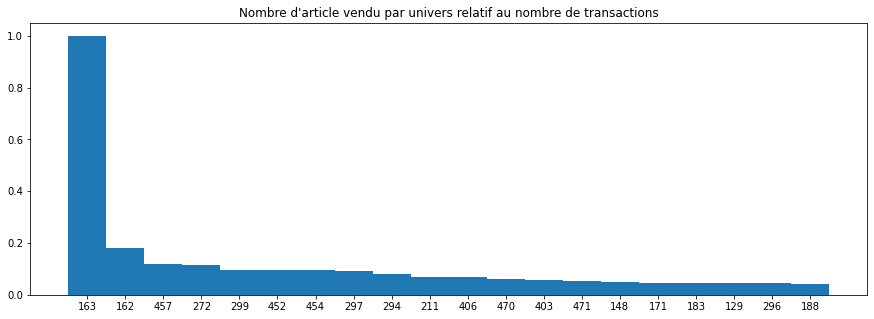

==============164===================
361
Time Taken to load recurence: ~0secondes


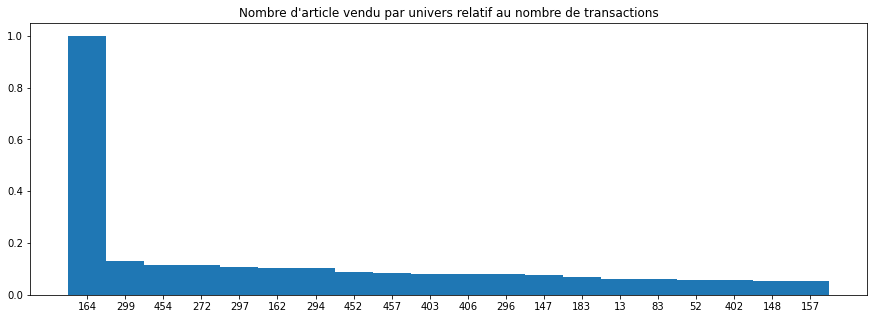

==============165===================
NOT ENOUGH DATA 
==============168===================
8458
Time Taken to load recurence: ~0secondes


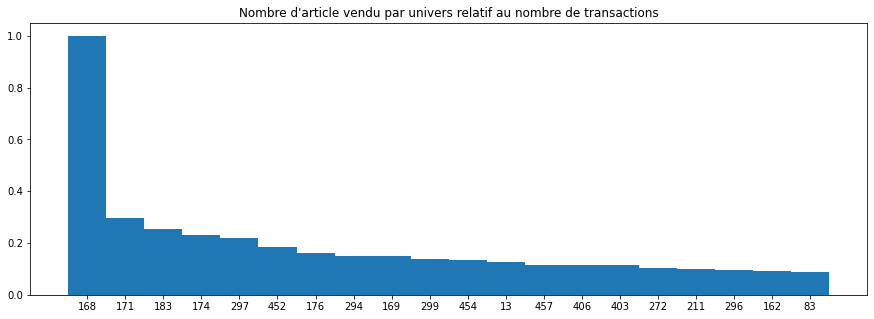

==============169===================
72293
Time Taken to load recurence: ~0secondes


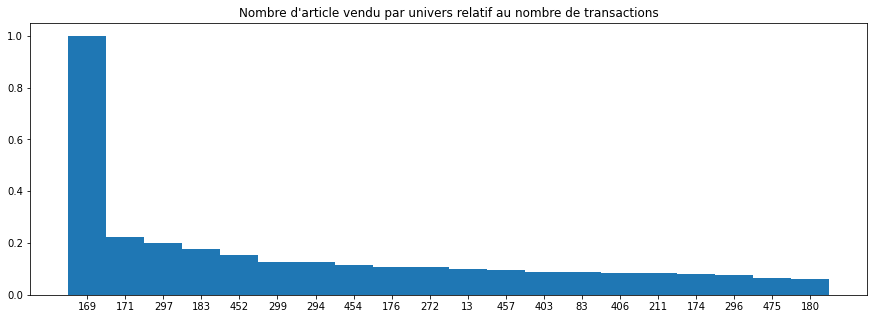

==============170===================
6701
Time Taken to load recurence: ~0secondes


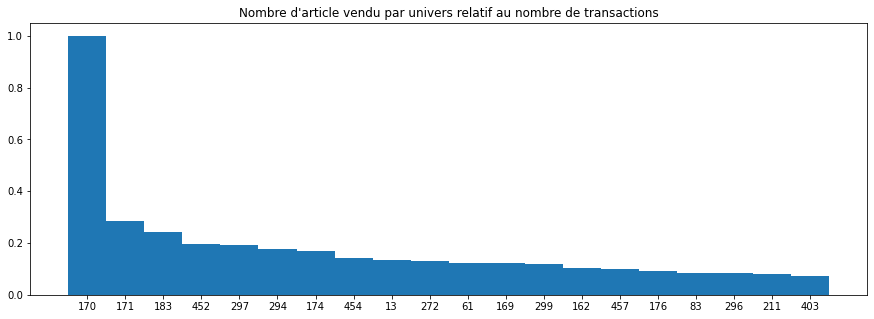

==============171===================
115056
Time Taken to load recurence: ~0secondes


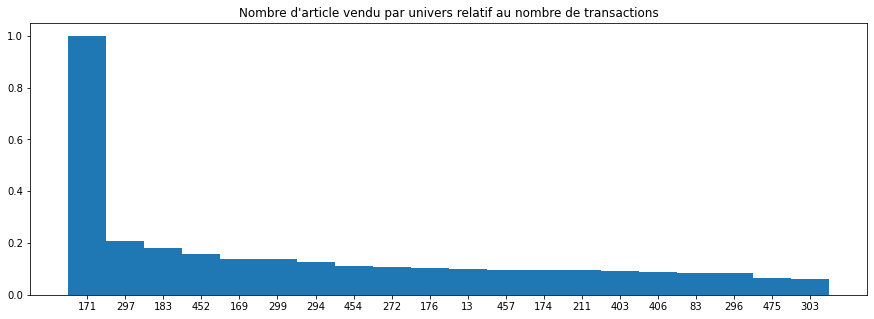

==============172===================
1849
Time Taken to load recurence: ~0secondes


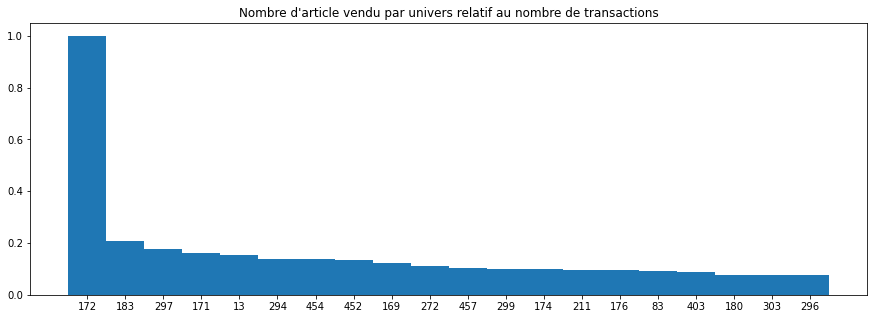

==============173===================
13187
Time Taken to load recurence: ~0secondes


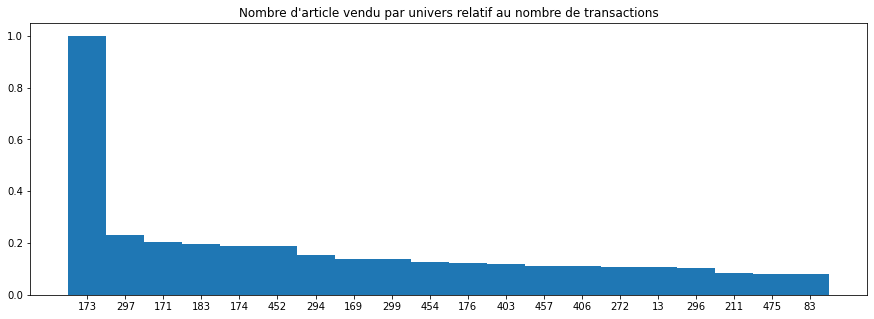

==============174===================
58126
Time Taken to load recurence: ~0secondes


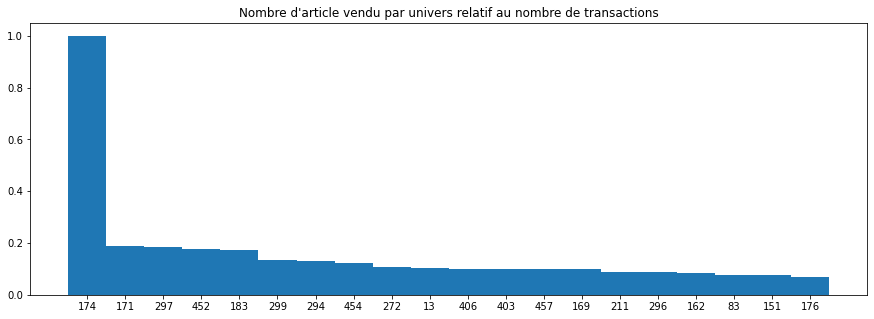

==============175===================
1402
Time Taken to load recurence: ~0secondes


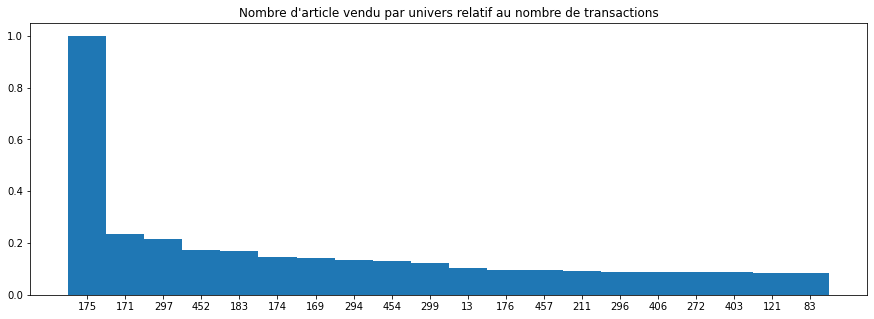

==============176===================
48805
Time Taken to load recurence: ~0secondes


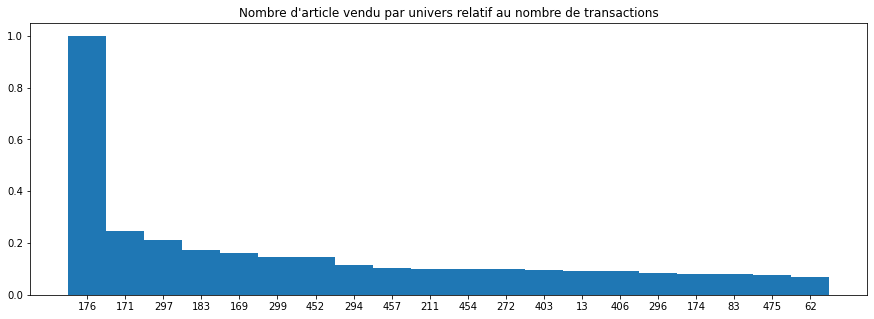

==============177===================
24490
Time Taken to load recurence: ~0secondes


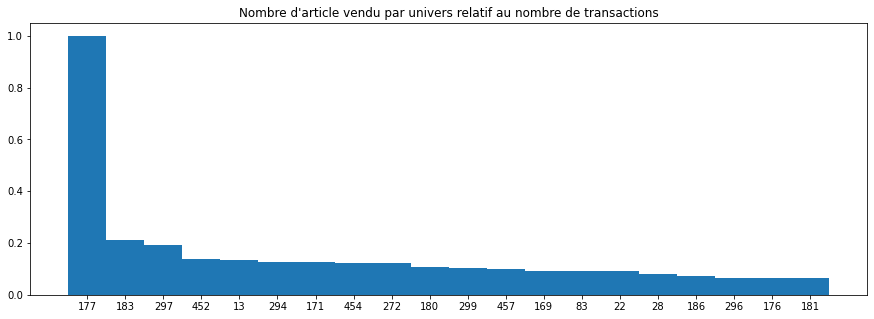

==============178===================
7374
Time Taken to load recurence: ~0secondes


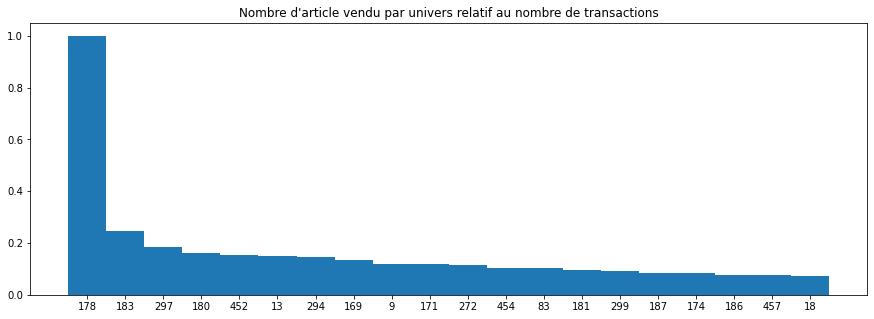

==============179===================
NOT ENOUGH DATA 
==============180===================
38792
Time Taken to load recurence: ~0secondes


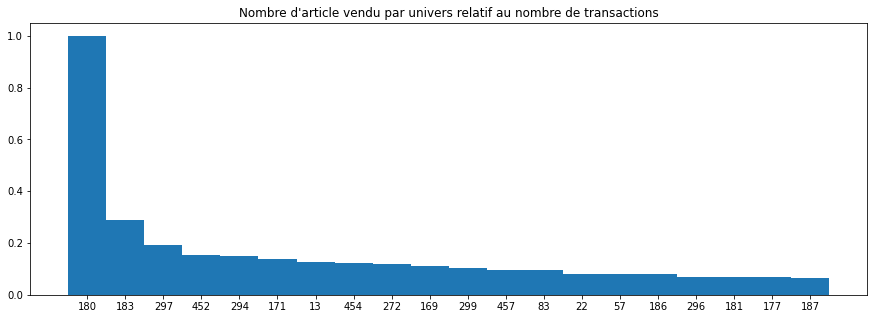

==============181===================
24889
Time Taken to load recurence: ~0secondes


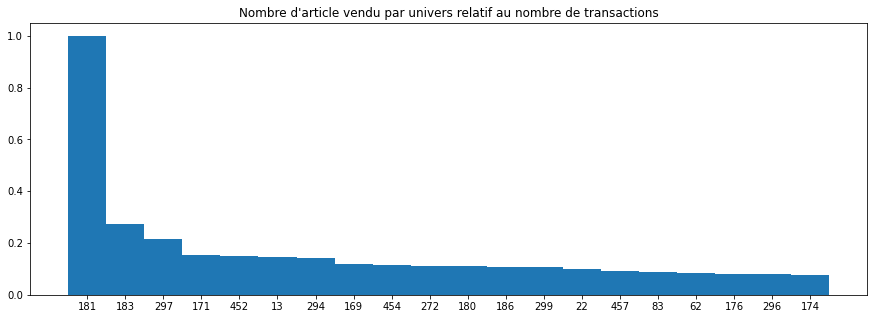

==============182===================
10419
Time Taken to load recurence: ~0secondes


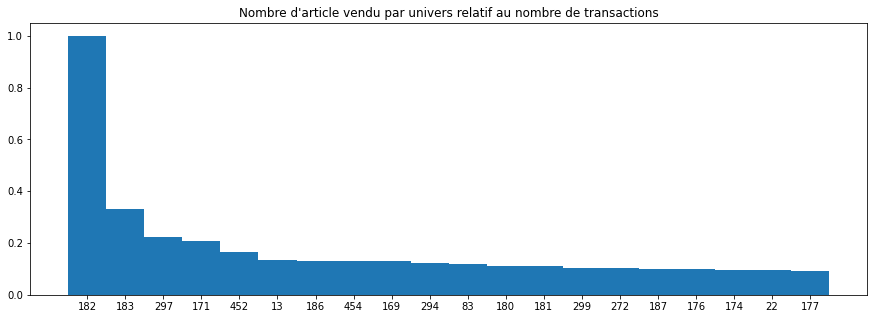

==============183===================
125280
Time Taken to load recurence: ~0secondes


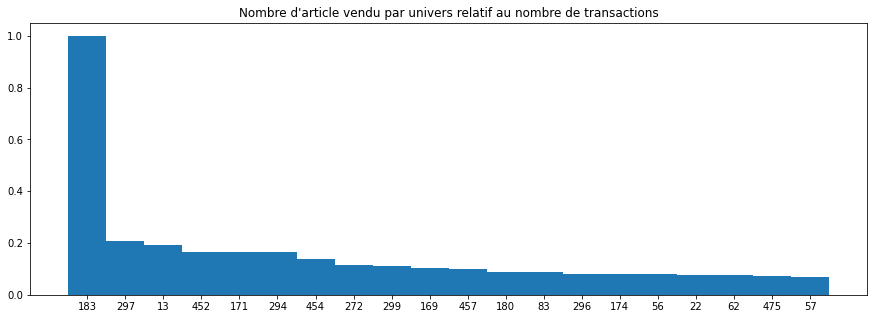

==============184===================
8727
Time Taken to load recurence: ~0secondes


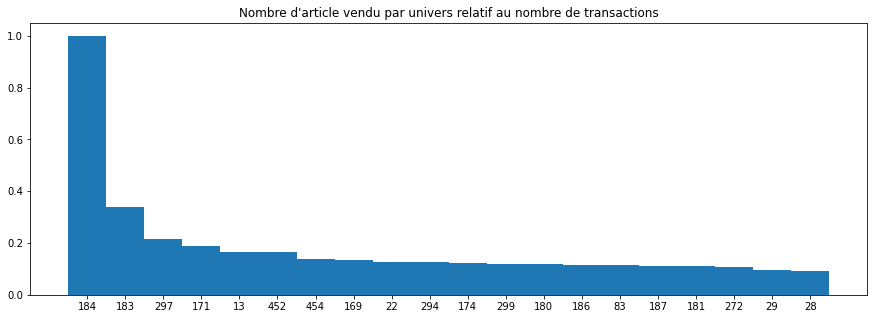

==============186===================
26988
Time Taken to load recurence: ~0secondes


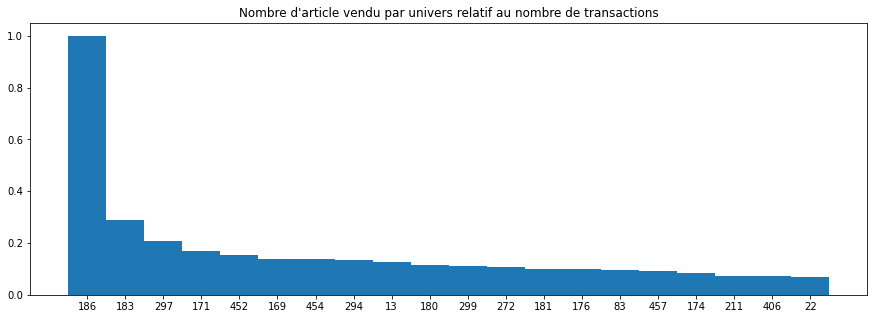

==============187===================
21924
Time Taken to load recurence: ~0secondes


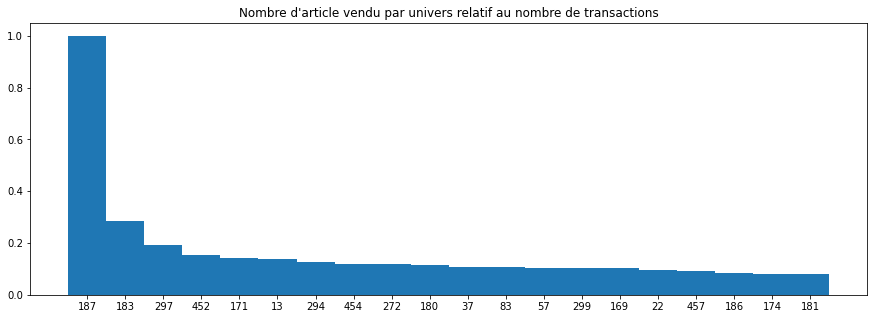

==============188===================
180090
Time Taken to load recurence: ~0secondes


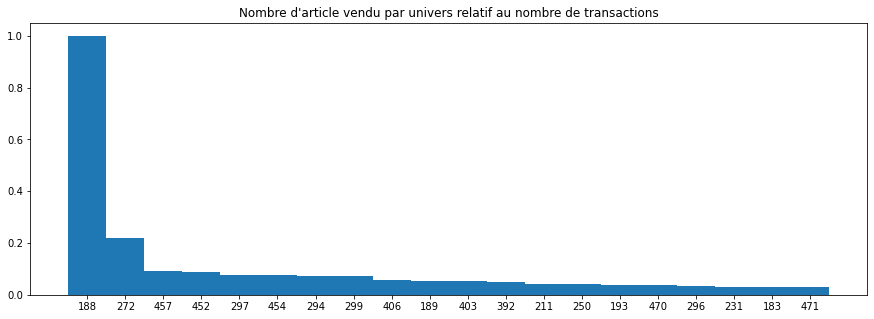

==============189===================
93014
Time Taken to load recurence: ~0secondes


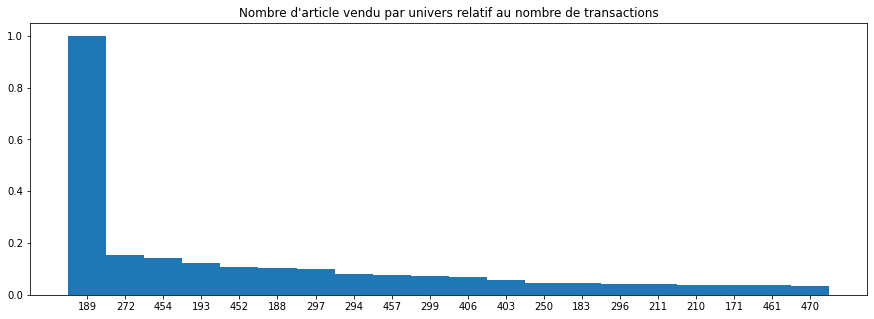

==============190===================
10515
Time Taken to load recurence: ~0secondes


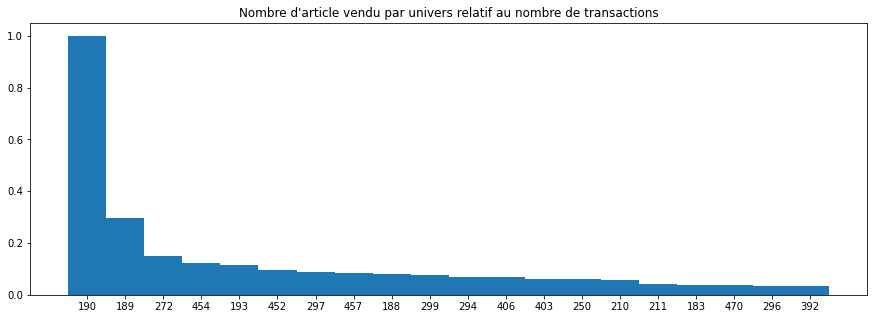

==============191===================
1447
Time Taken to load recurence: ~0secondes


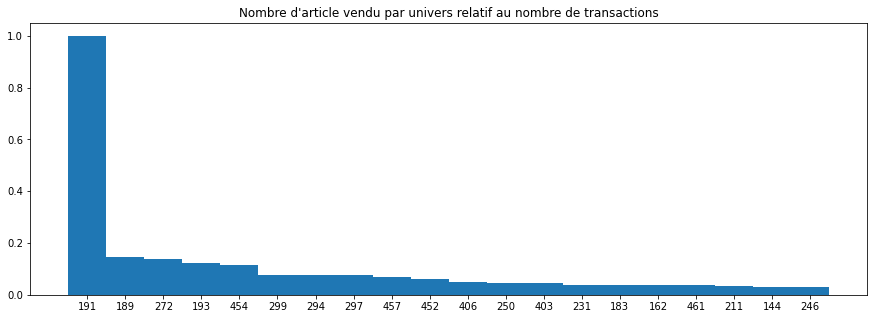

==============192===================
8373
Time Taken to load recurence: ~0secondes


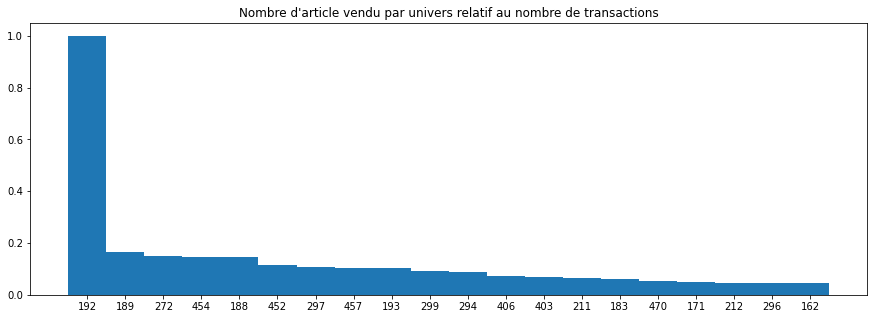

==============193===================
66212
Time Taken to load recurence: ~0secondes


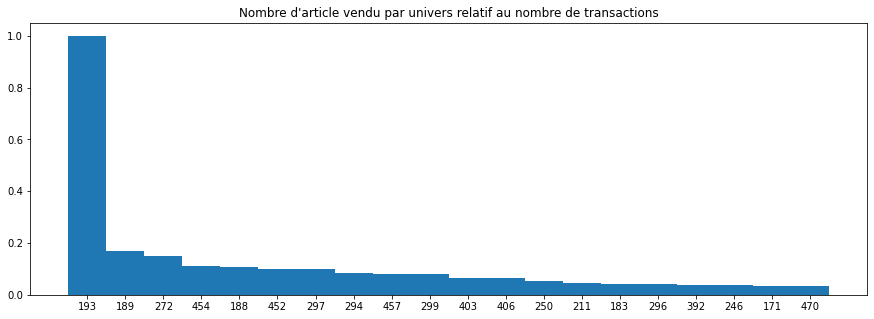

==============194===================
4108
Time Taken to load recurence: ~0secondes


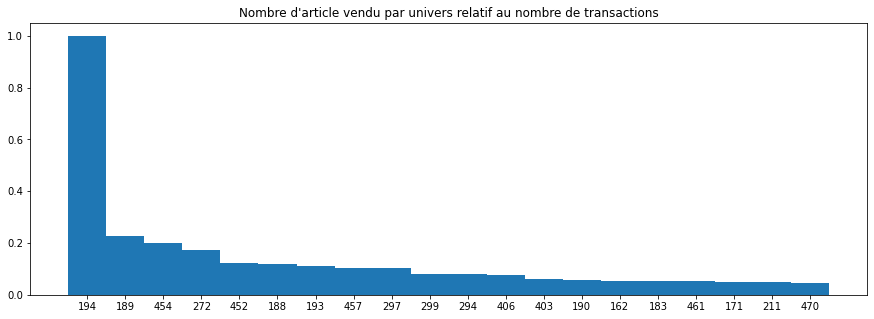

==============195===================
1312
Time Taken to load recurence: ~0secondes


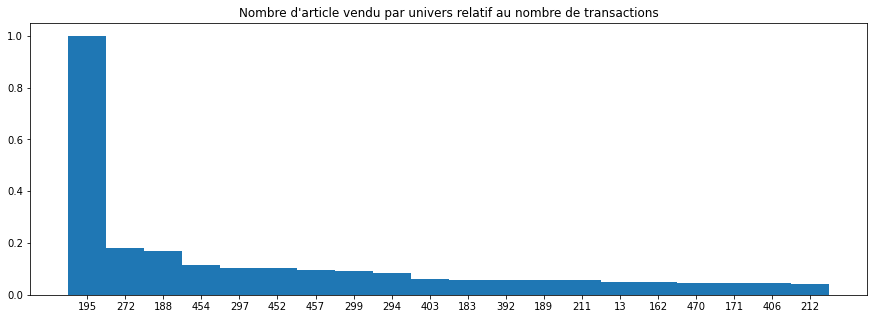

==============196===================
3432
Time Taken to load recurence: ~0secondes


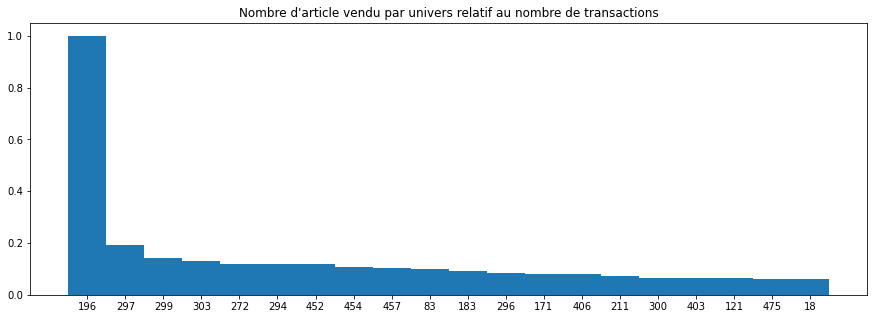

==============197===================
792
Time Taken to load recurence: ~0secondes


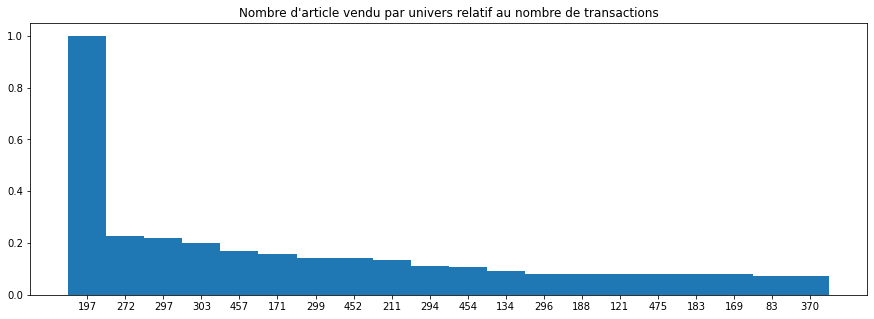

==============198===================
63821
Time Taken to load recurence: ~0secondes


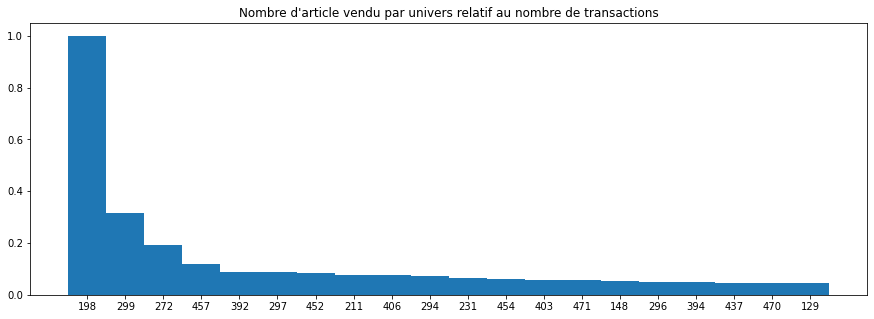

==============199===================
3642
Time Taken to load recurence: ~0secondes


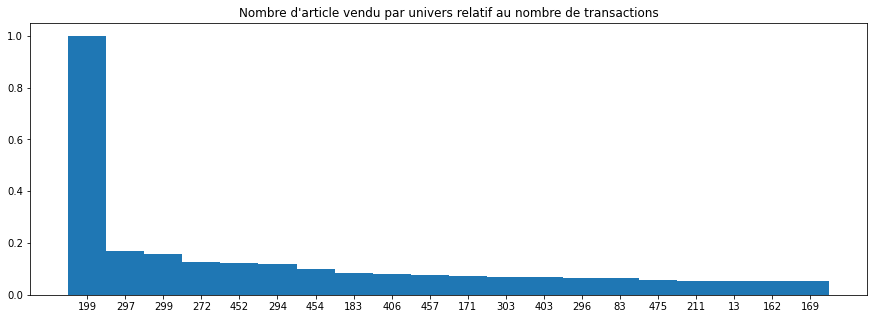

==============200===================
12263
Time Taken to load recurence: ~0secondes


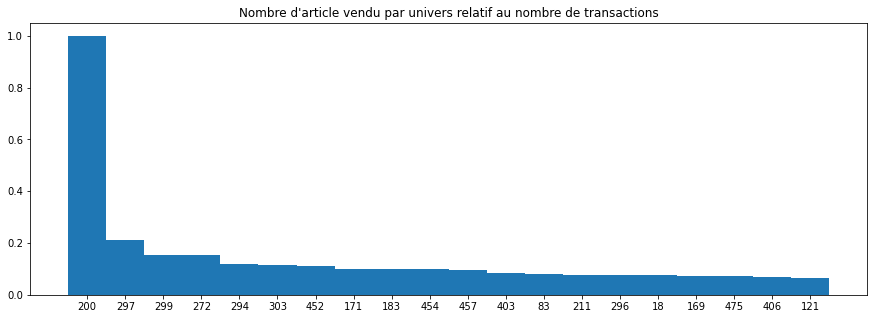

==============201===================
14709
Time Taken to load recurence: ~0secondes


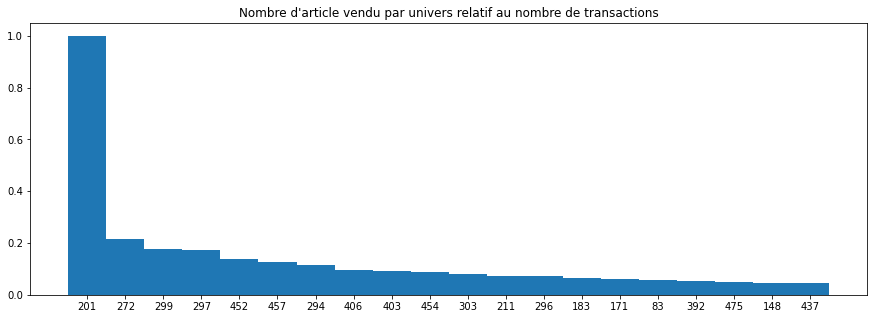

==============202===================
NOT ENOUGH DATA 
==============203===================
3952
Time Taken to load recurence: ~0secondes


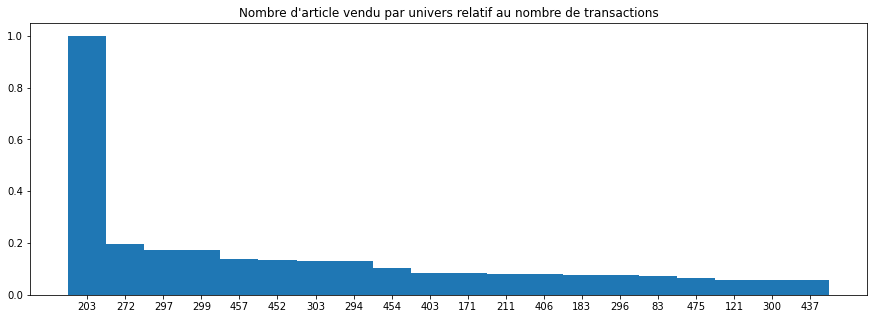

==============204===================
899
Time Taken to load recurence: ~0secondes


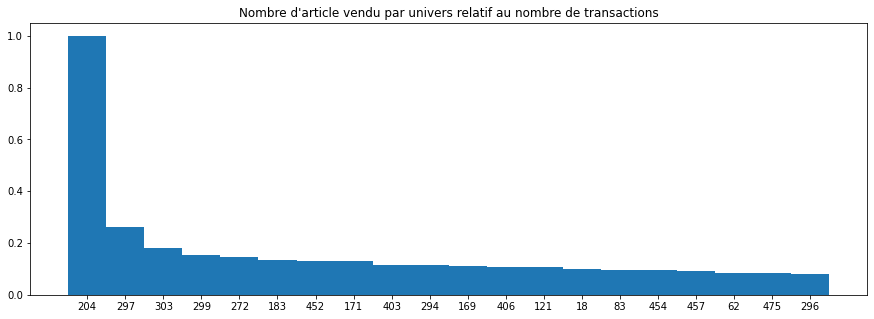

==============205===================
NOT ENOUGH DATA 
==============206===================
1964
Time Taken to load recurence: ~0secondes


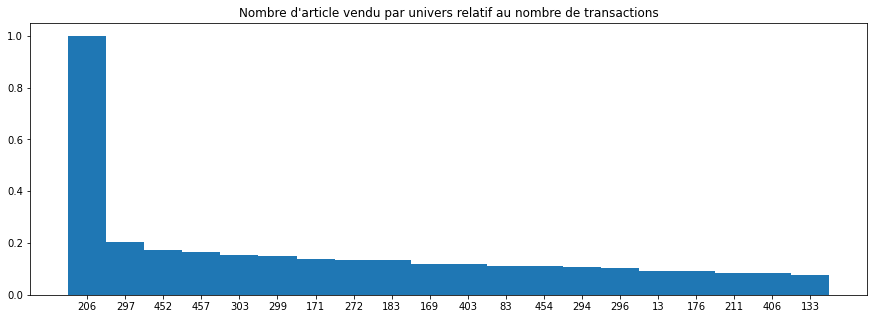

==============207===================
13380
Time Taken to load recurence: ~0secondes


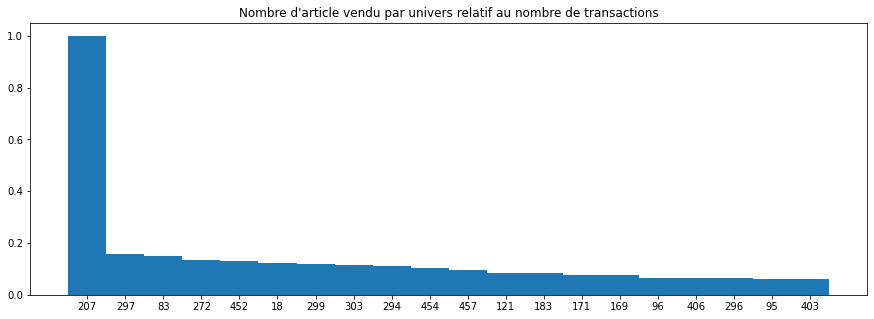

==============208===================
25211
Time Taken to load recurence: ~0secondes


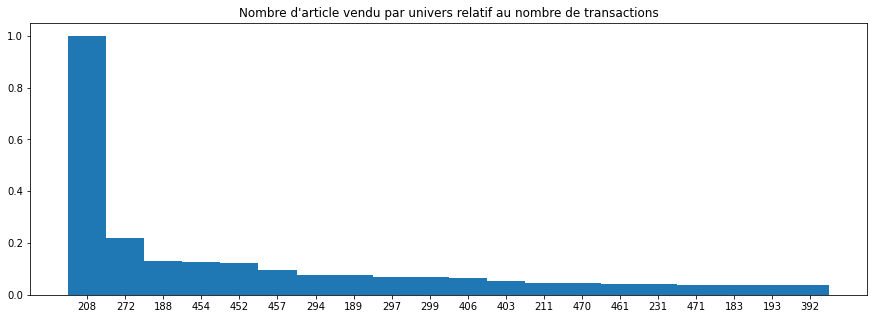

==============209===================
6151
Time Taken to load recurence: ~0secondes


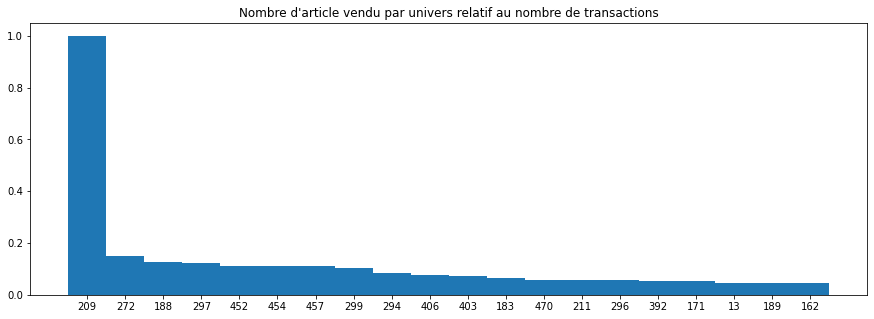

==============210===================
27759
Time Taken to load recurence: ~0secondes


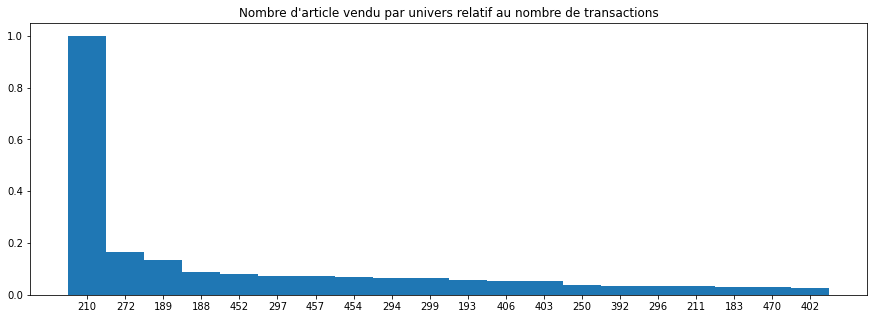

==============211===================
200723
Time Taken to load recurence: ~0secondes


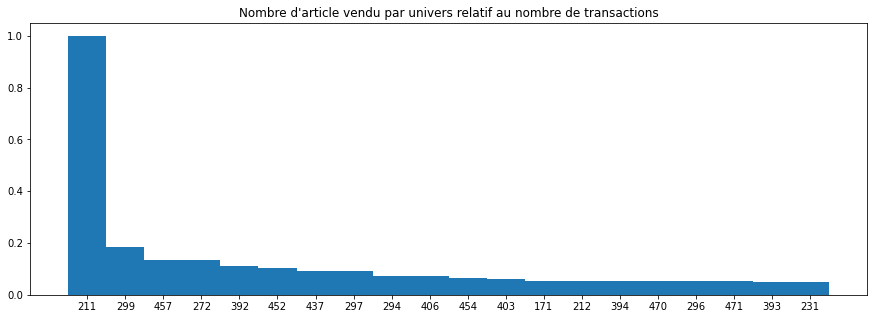

==============212===================
87760
Time Taken to load recurence: ~0secondes


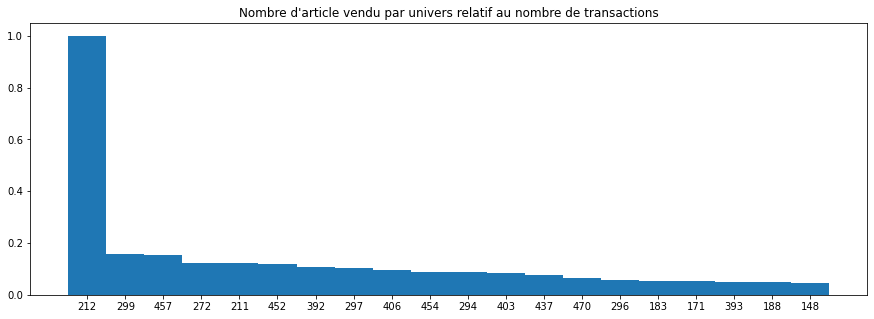

==============214===================
NOT ENOUGH DATA 
==============215===================
18972
Time Taken to load recurence: ~0secondes


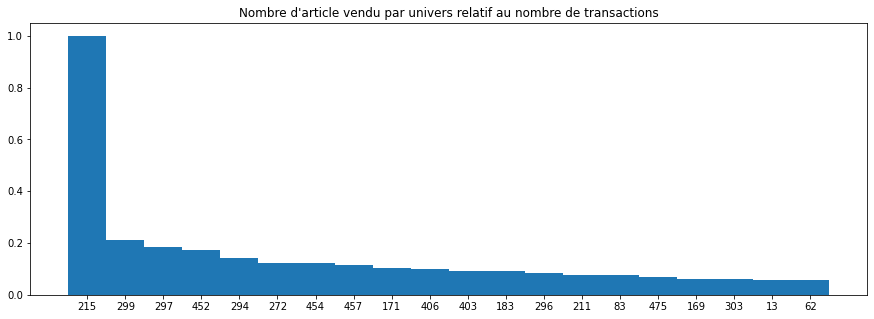

==============216===================
20979
Time Taken to load recurence: ~0secondes


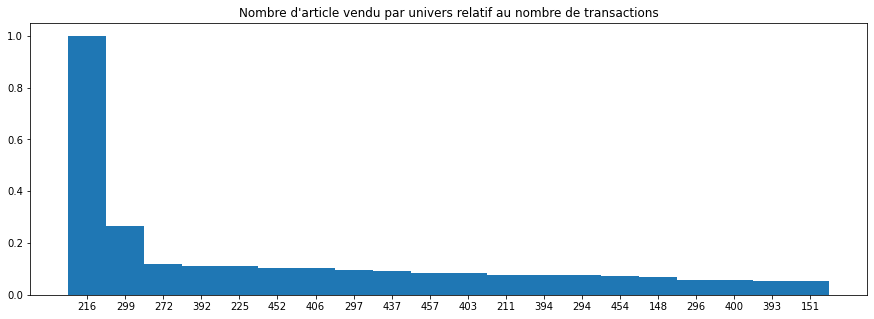

==============219===================
32527
Time Taken to load recurence: ~0secondes


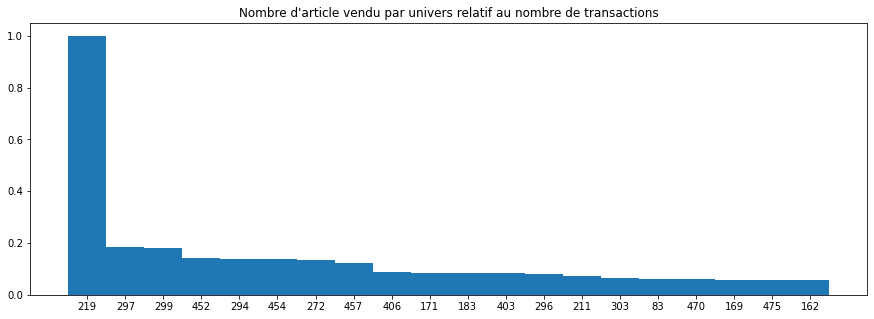

==============220===================
36625
Time Taken to load recurence: ~0secondes


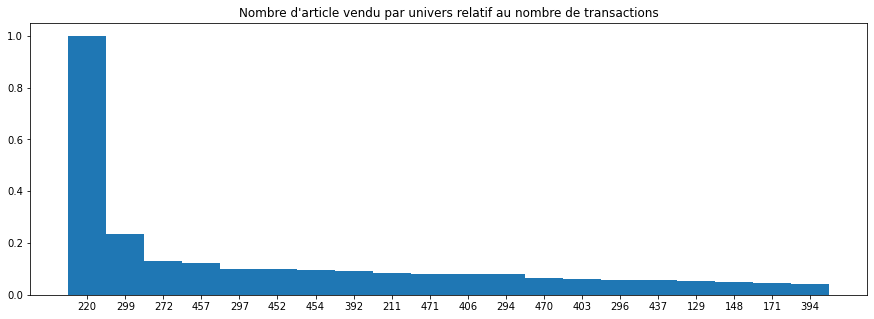

==============222===================
5128
Time Taken to load recurence: ~0secondes


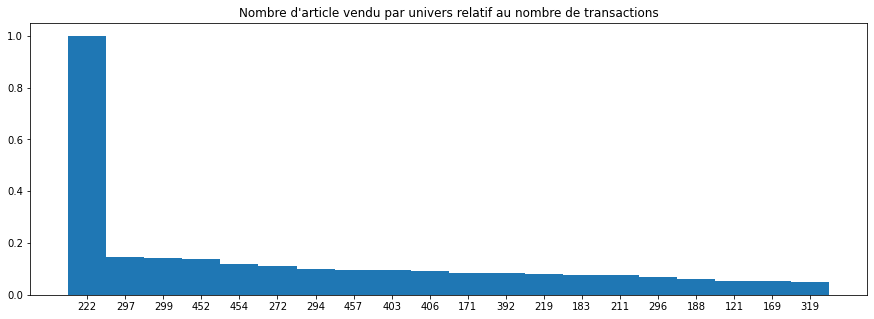

==============223===================
5358
Time Taken to load recurence: ~0secondes


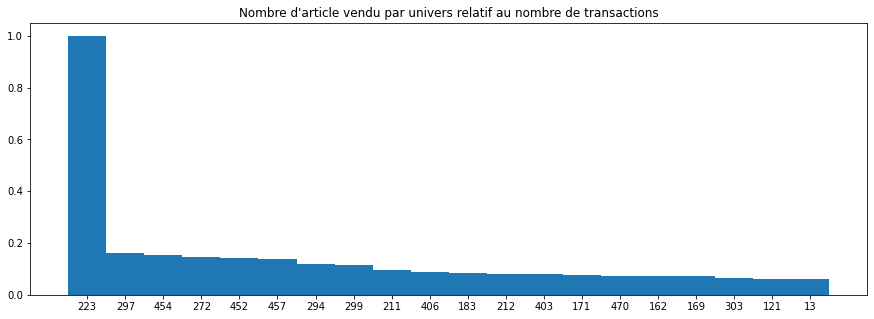

==============224===================
4775
Time Taken to load recurence: ~0secondes


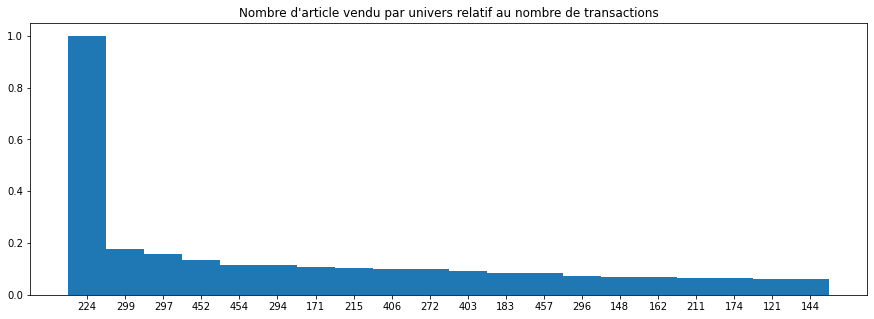

==============225===================
65546
Time Taken to load recurence: ~0secondes


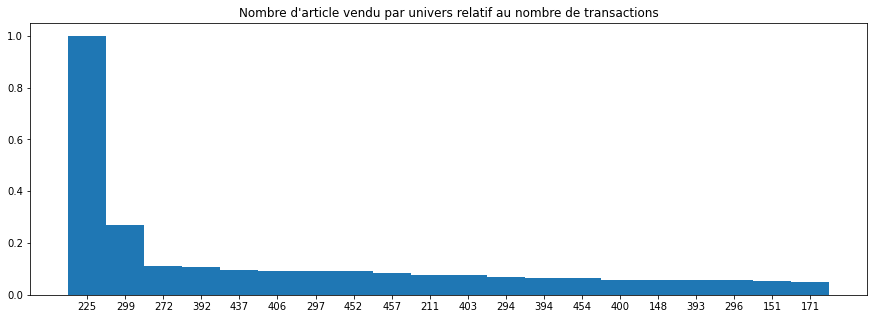

==============231===================
148809
Time Taken to load recurence: ~0secondes


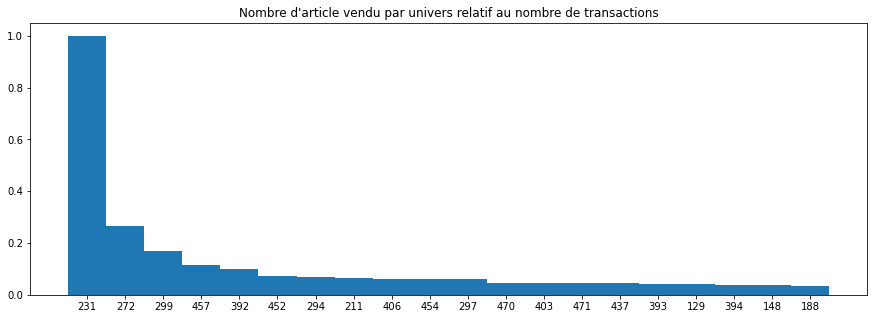

==============232===================
34323
Time Taken to load recurence: ~0secondes


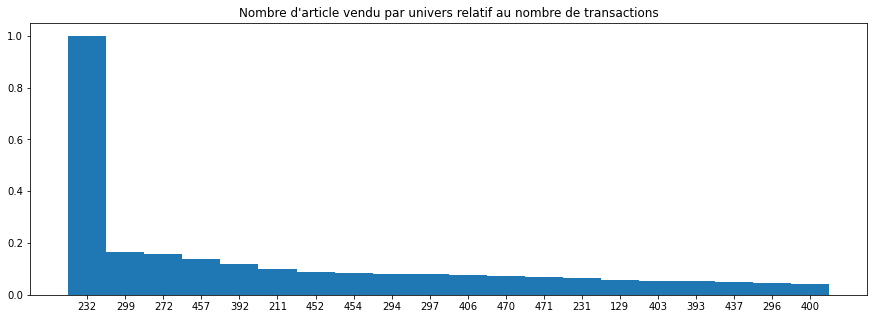

==============233===================
18423
Time Taken to load recurence: ~0secondes


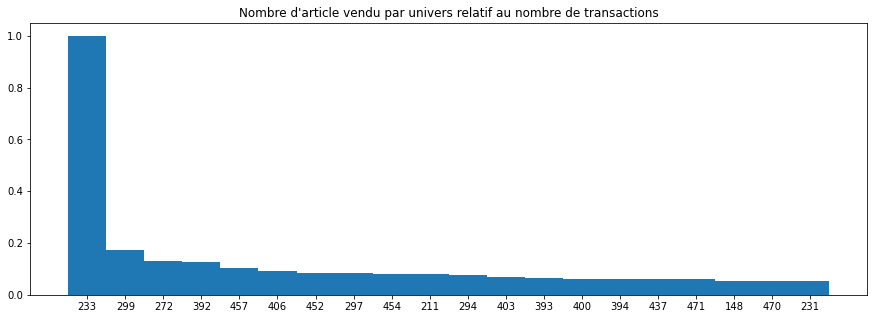

==============235===================
7784
Time Taken to load recurence: ~0secondes


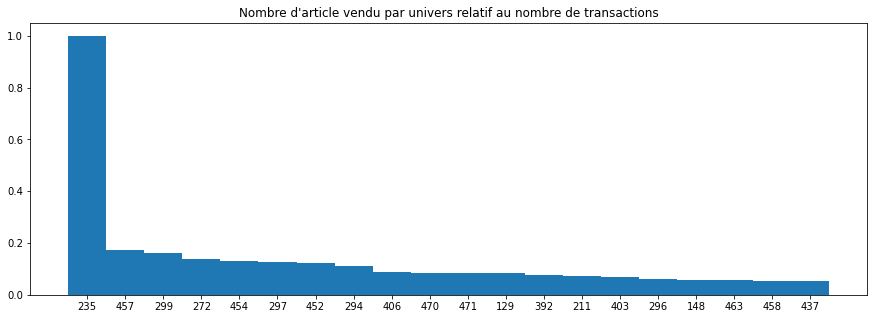

==============236===================
17273
Time Taken to load recurence: ~0secondes


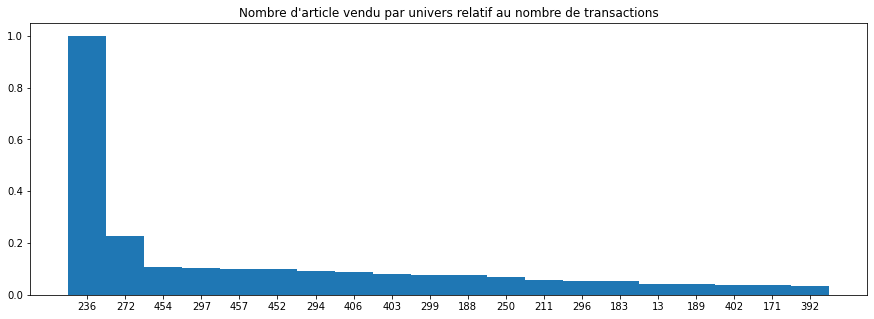

==============237===================
53
Time Taken to load recurence: ~0secondes


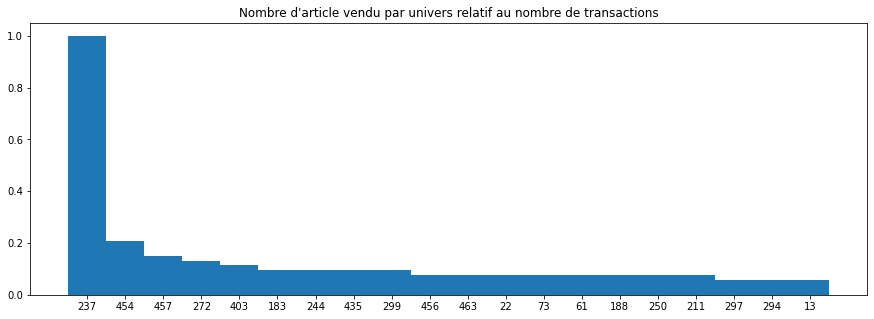

==============238===================
4221
Time Taken to load recurence: ~0secondes


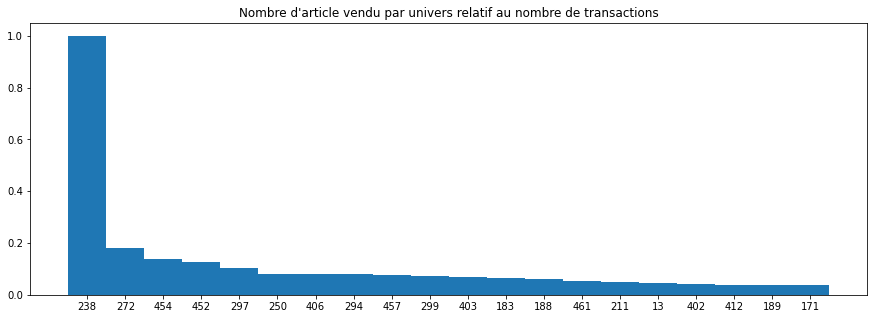

==============239===================
12279
Time Taken to load recurence: ~0secondes


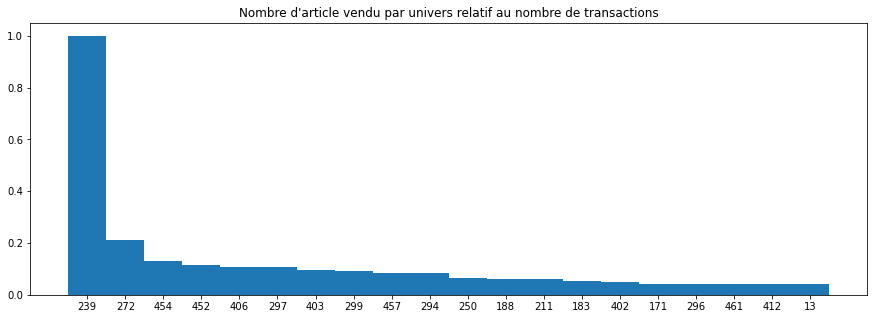

==============240===================
2747
Time Taken to load recurence: ~0secondes


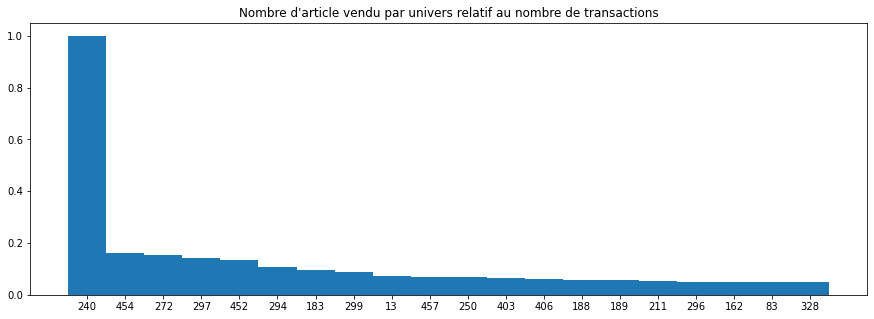

==============241===================
3580
Time Taken to load recurence: ~0secondes


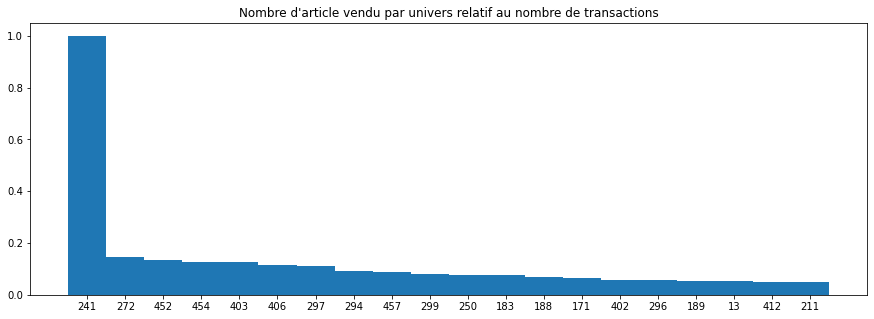

==============242===================
3316
Time Taken to load recurence: ~0secondes


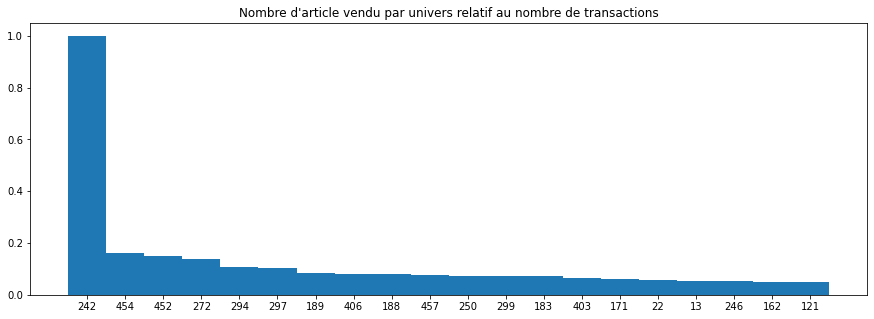

==============243===================
2039
Time Taken to load recurence: ~0secondes


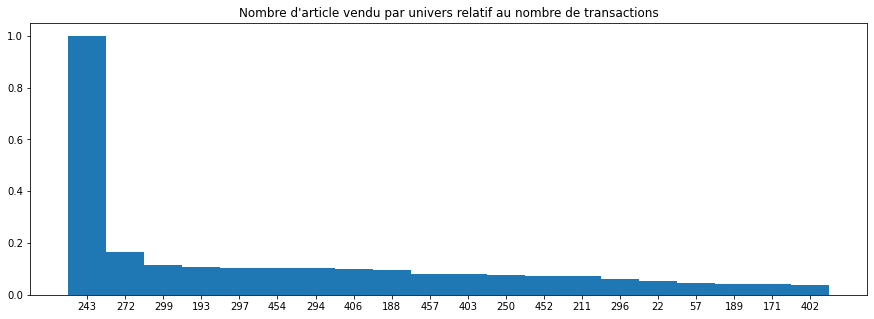

==============244===================
2522
Time Taken to load recurence: ~0secondes


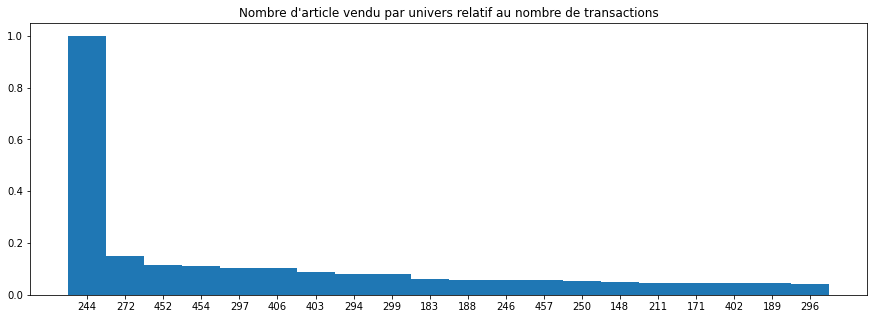

==============245===================
4039
Time Taken to load recurence: ~0secondes


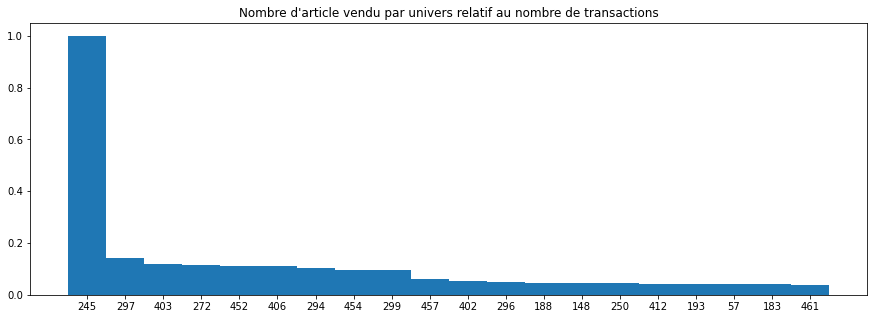

==============246===================
58327
Time Taken to load recurence: ~0secondes


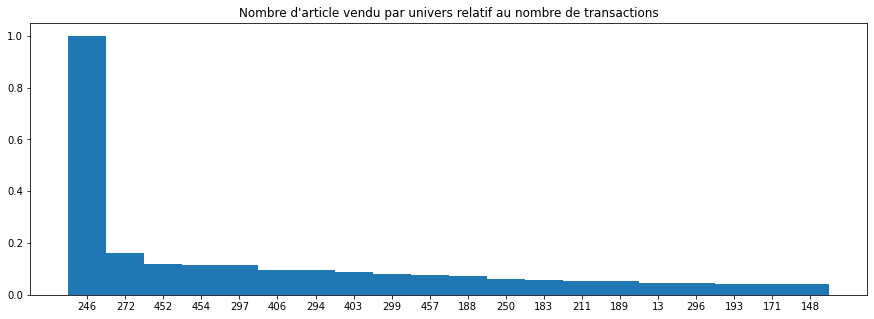

==============247===================
11443
Time Taken to load recurence: ~0secondes


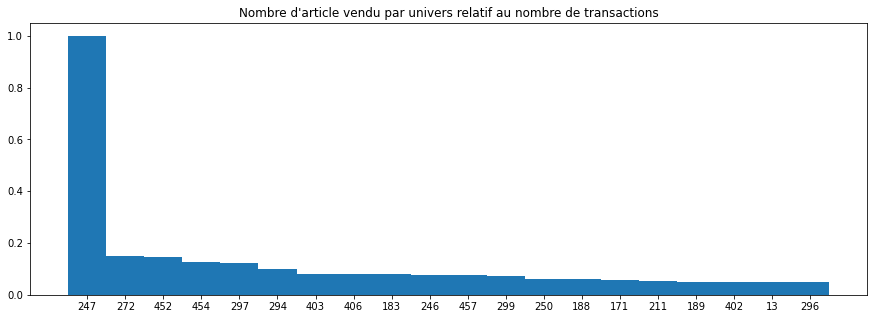

==============248===================
5954
Time Taken to load recurence: ~0secondes


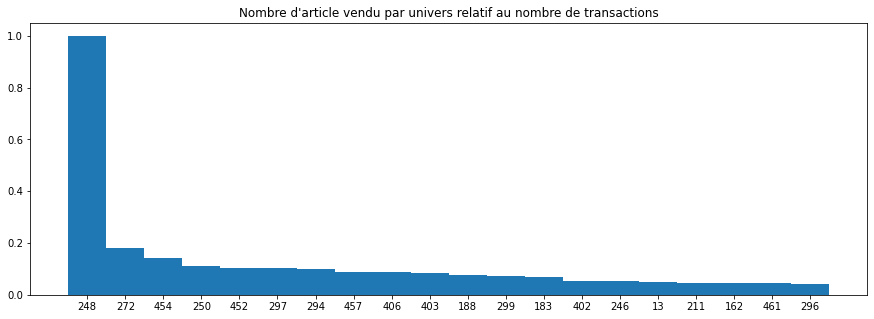

==============249===================
26229
Time Taken to load recurence: ~0secondes


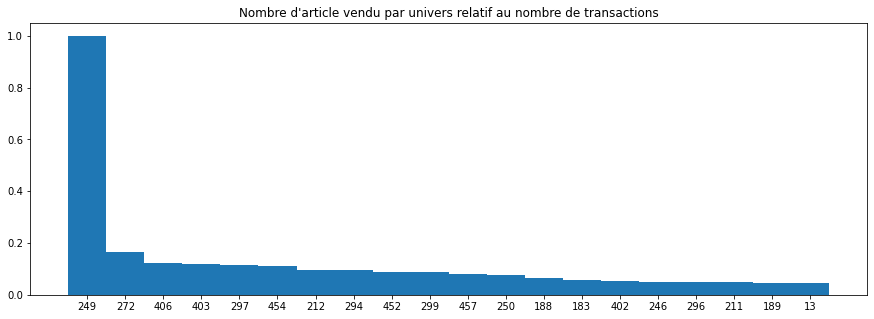

==============250===================
101216
Time Taken to load recurence: ~0secondes


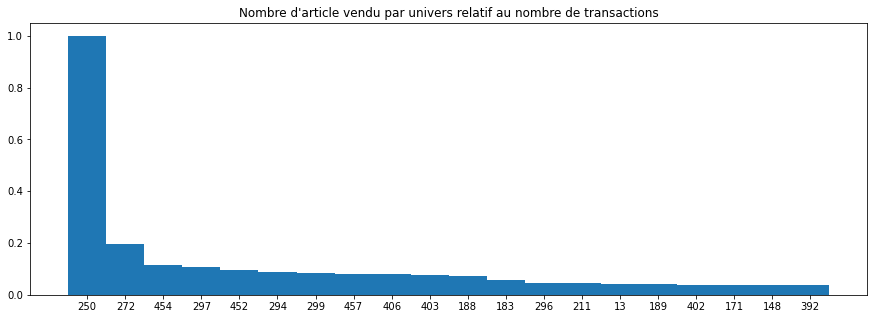

==============251===================
28956
Time Taken to load recurence: ~0secondes


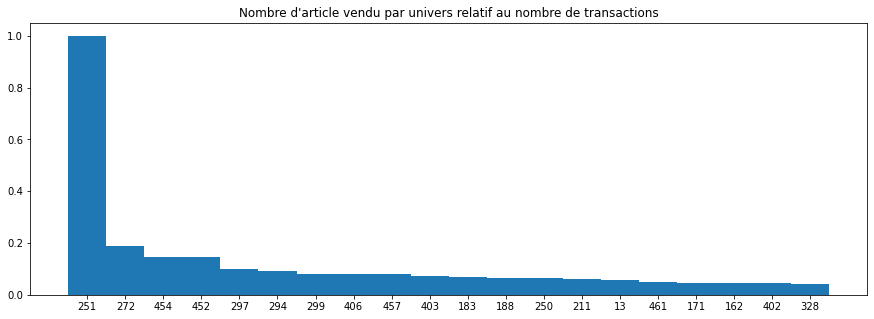

==============252===================
4107
Time Taken to load recurence: ~0secondes


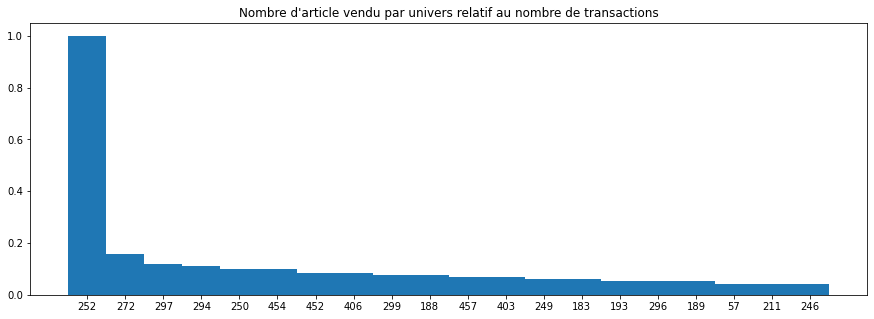

==============253===================
1324
Time Taken to load recurence: ~0secondes


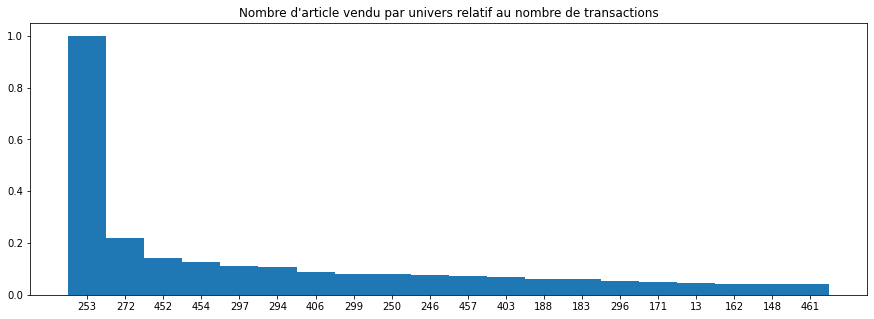

==============254===================
12546
Time Taken to load recurence: ~0secondes


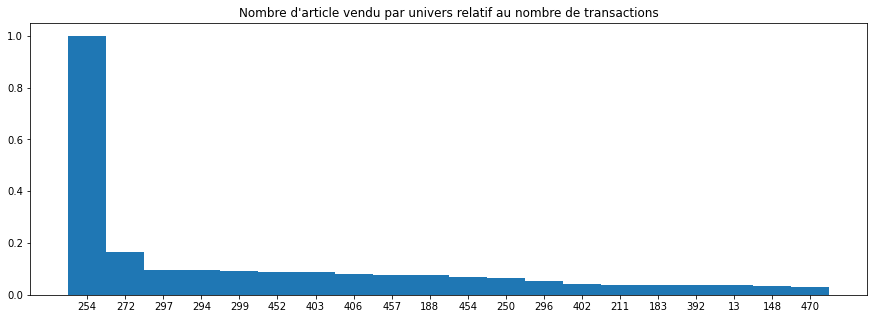

==============255===================
14775
Time Taken to load recurence: ~0secondes


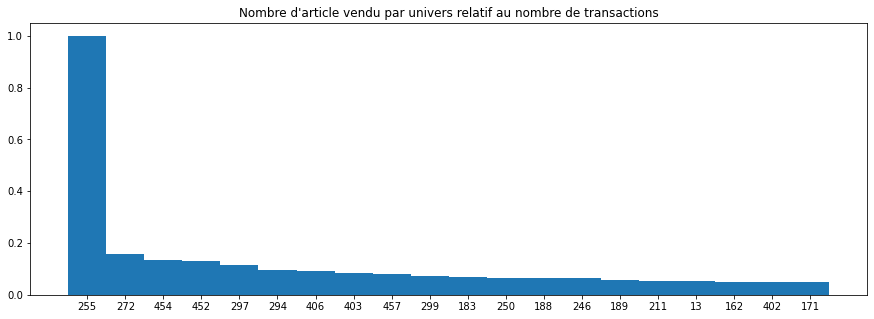

==============256===================
2481
Time Taken to load recurence: ~0secondes


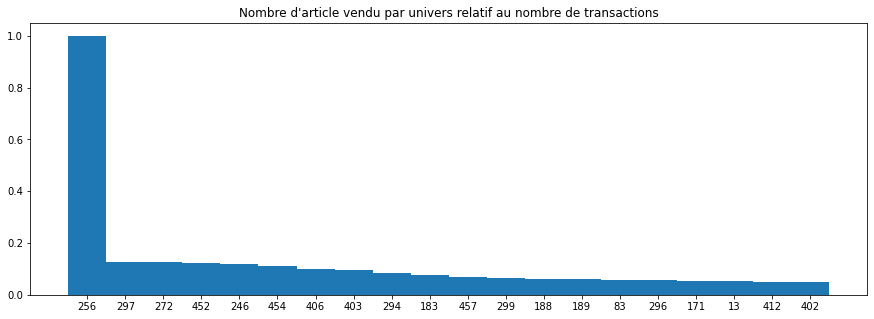

==============258===================
11219
Time Taken to load recurence: ~0secondes


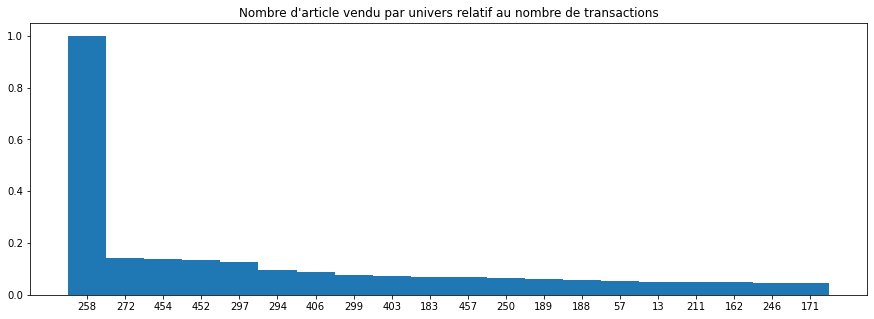

==============259===================
3341
Time Taken to load recurence: ~0secondes


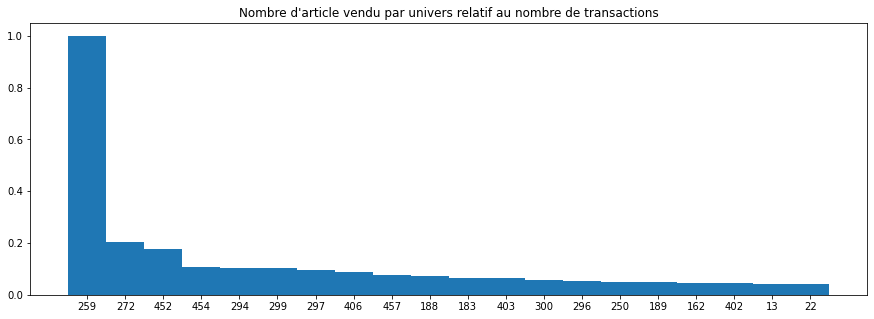

==============262===================
9309
Time Taken to load recurence: ~0secondes


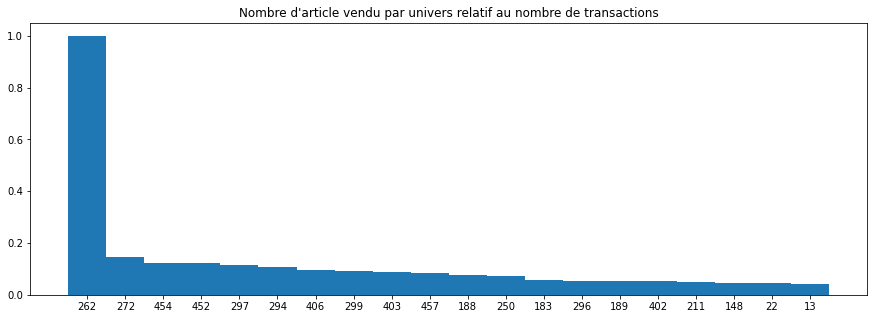

==============263===================
4307
Time Taken to load recurence: ~0secondes


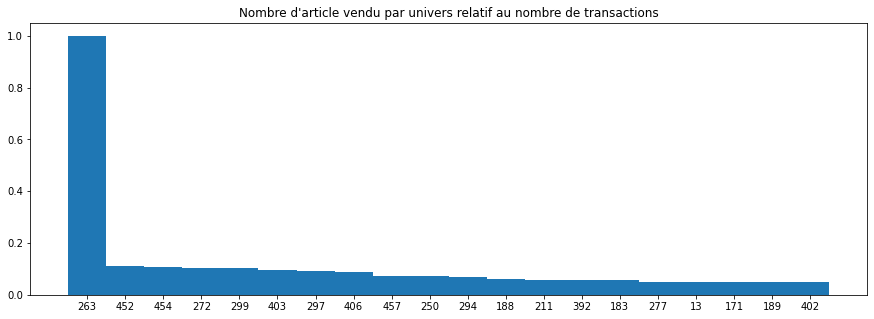

==============264===================
263
Time Taken to load recurence: ~0secondes


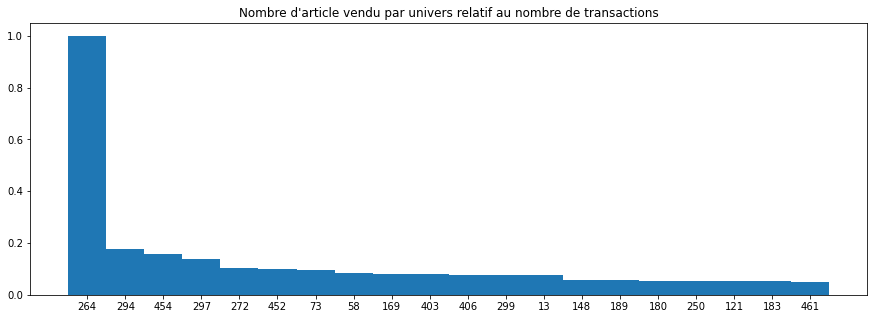

==============265===================
NOT ENOUGH DATA 
==============266===================
5046
Time Taken to load recurence: ~0secondes


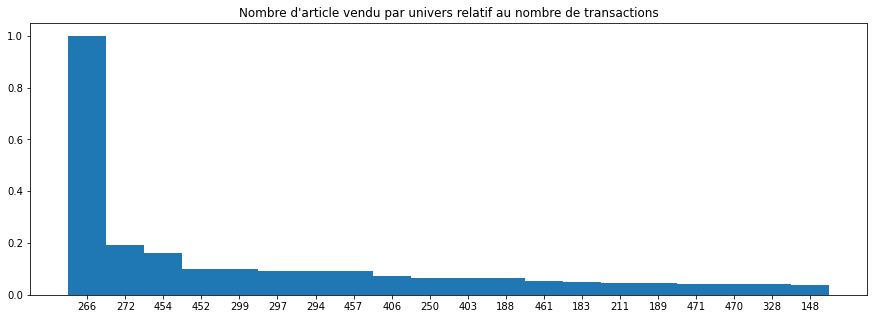

==============267===================
4584
Time Taken to load recurence: ~0secondes


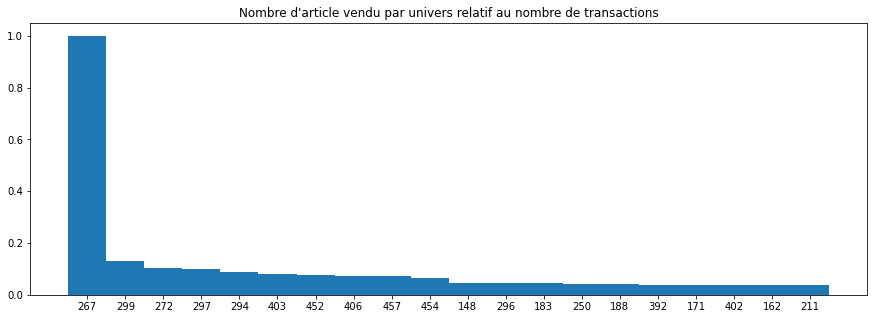

==============269===================
23415
Time Taken to load recurence: ~0secondes


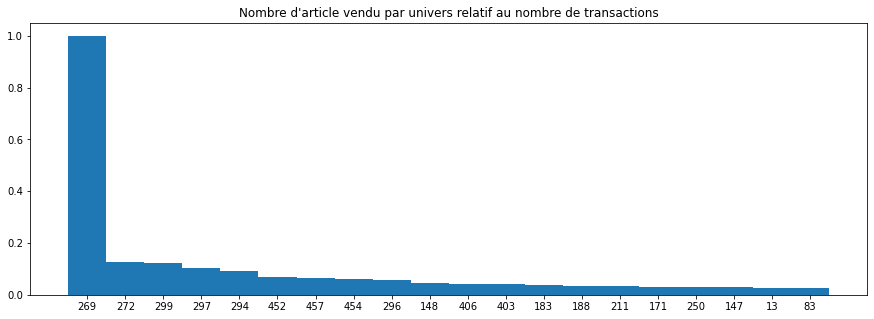

==============270===================
28298
Time Taken to load recurence: ~0secondes


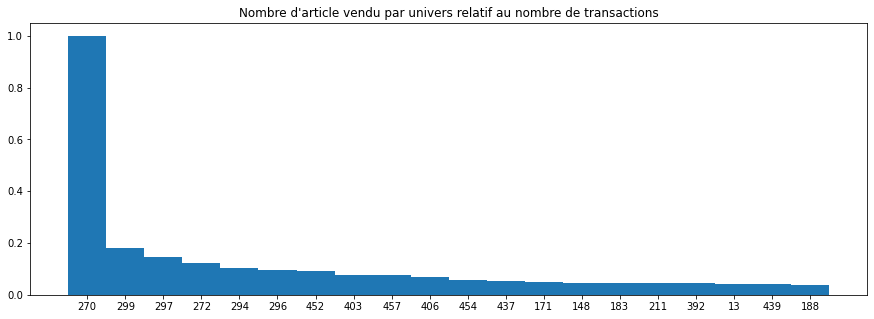

==============271===================
41622
Time Taken to load recurence: ~0secondes


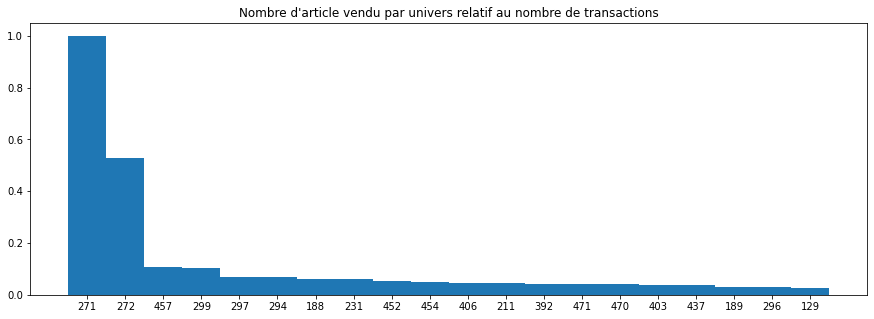

==============272===================
608331
Time Taken to load recurence: ~1secondes


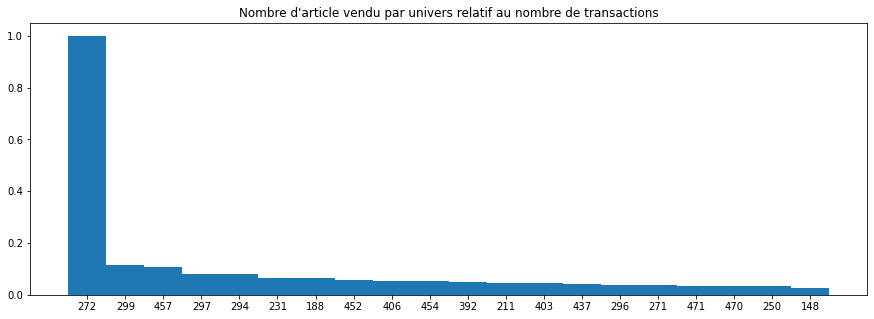

==============273===================
4848
Time Taken to load recurence: ~0secondes


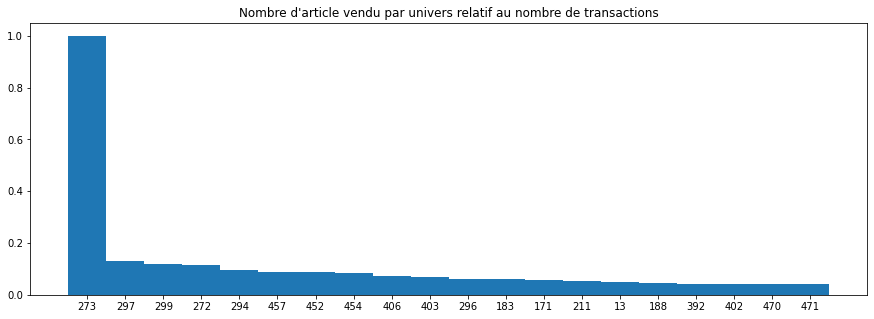

==============275===================
17162
Time Taken to load recurence: ~0secondes


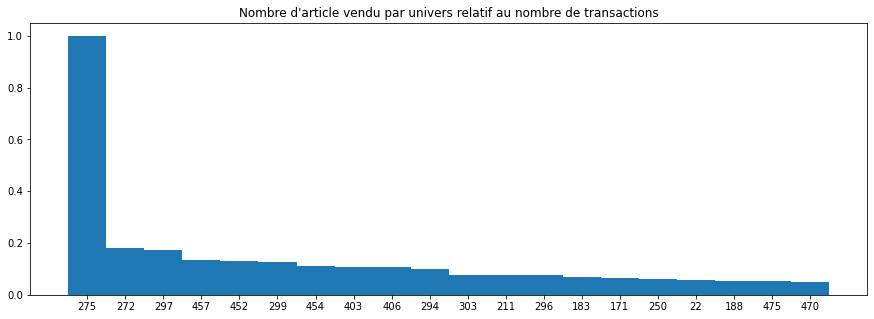

==============276===================
8798
Time Taken to load recurence: ~0secondes


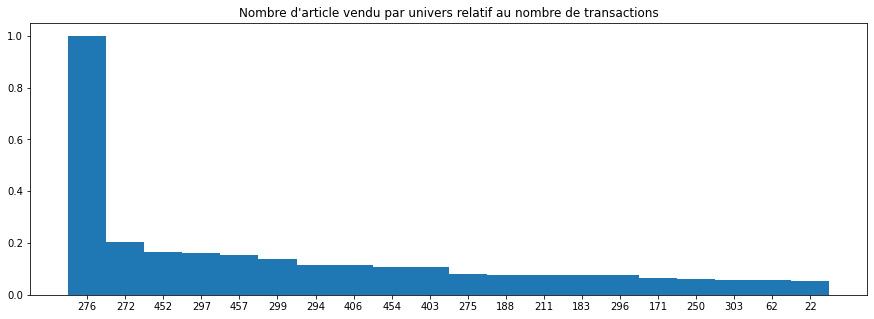

==============277===================
38421
Time Taken to load recurence: ~0secondes


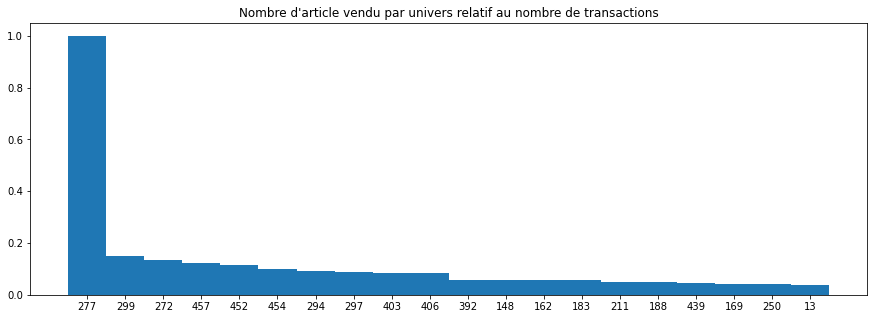

==============278===================
NOT ENOUGH DATA 
==============279===================
NOT ENOUGH DATA 
==============286===================
9600
Time Taken to load recurence: ~0secondes


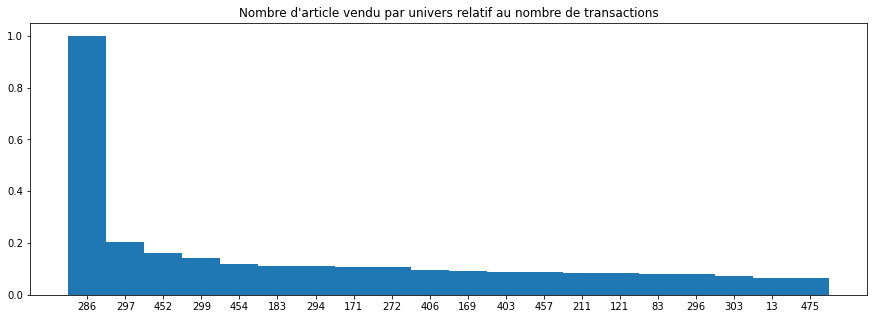

==============287===================
31801
Time Taken to load recurence: ~0secondes


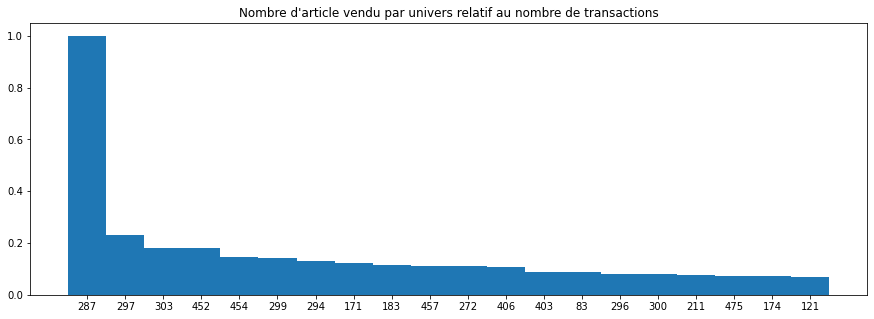

==============288===================
20621
Time Taken to load recurence: ~0secondes


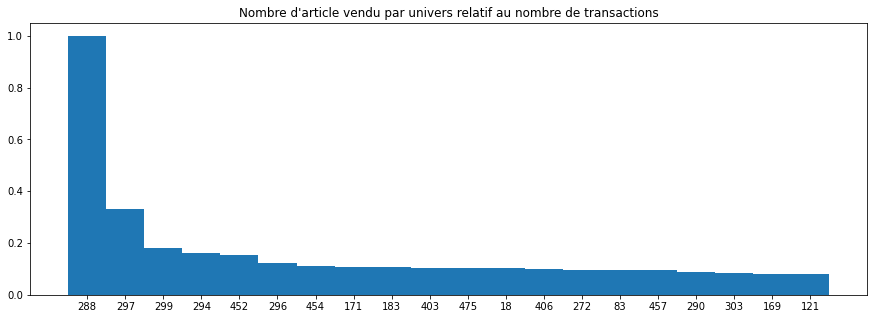

==============289===================
4915
Time Taken to load recurence: ~0secondes


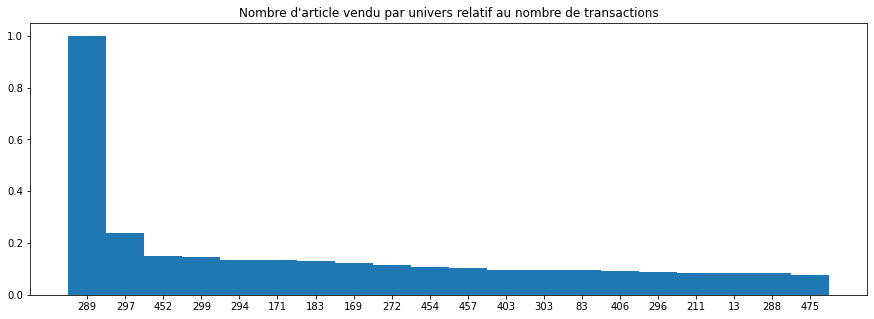

==============290===================
23016
Time Taken to load recurence: ~0secondes


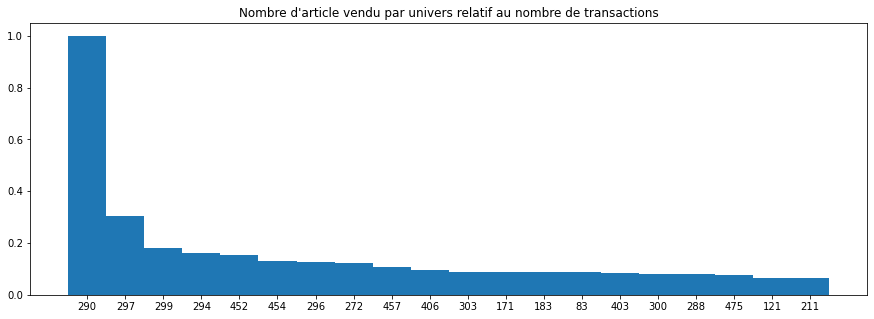

==============291===================
3548
Time Taken to load recurence: ~0secondes


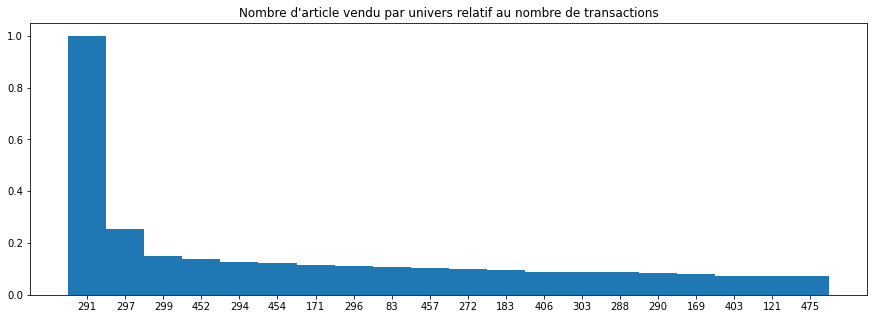

==============292===================
12831
Time Taken to load recurence: ~0secondes


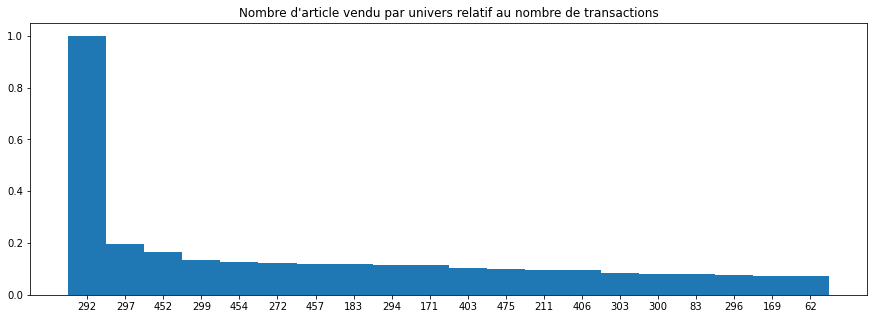

==============293===================
5913
Time Taken to load recurence: ~0secondes


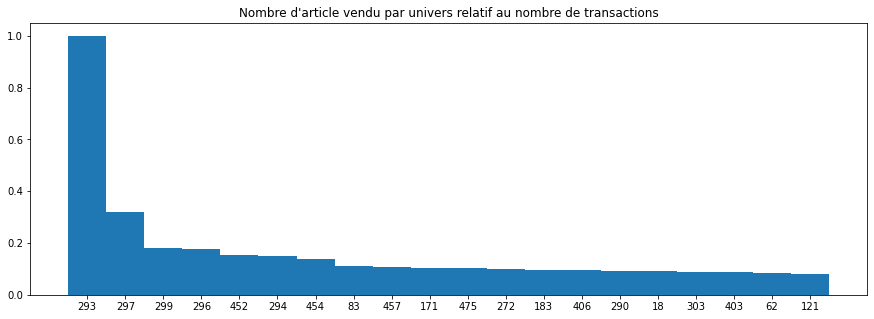

==============294===================
386491
Time Taken to load recurence: ~1secondes


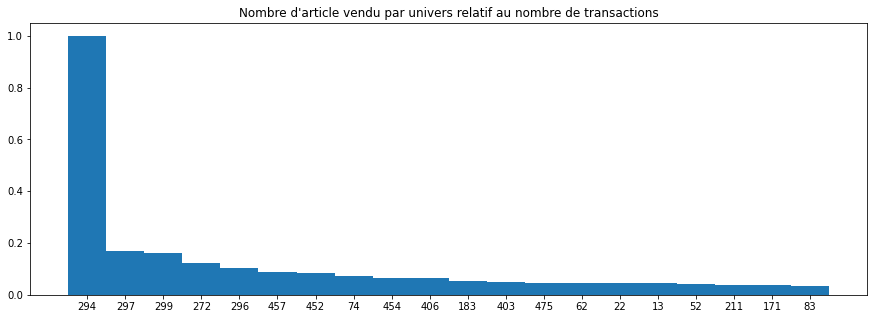

==============296===================
221921
Time Taken to load recurence: ~0secondes


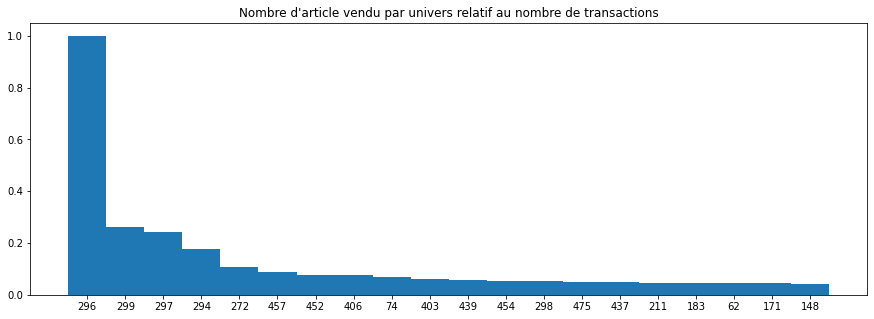

==============297===================
446360
Time Taken to load recurence: ~1secondes


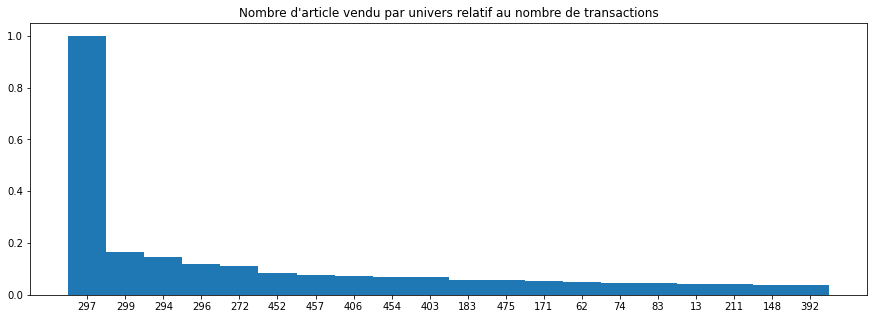

==============298===================
45256
Time Taken to load recurence: ~0secondes


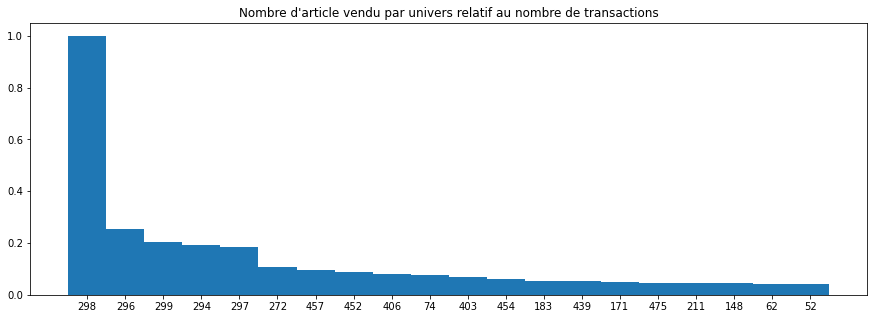

==============299===================
592185
Time Taken to load recurence: ~1secondes


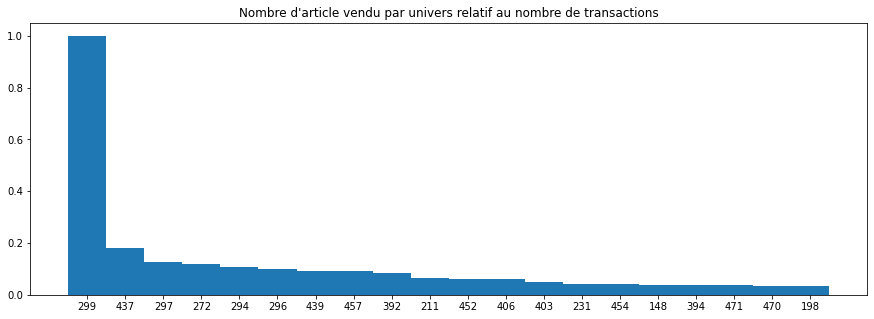

==============300===================
67806
Time Taken to load recurence: ~0secondes


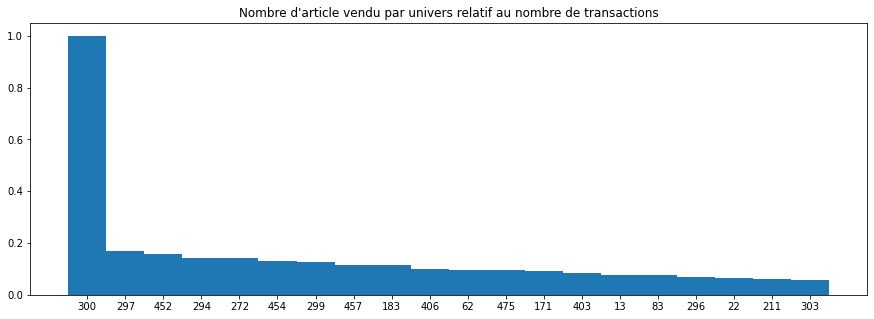

==============301===================
28190
Time Taken to load recurence: ~0secondes


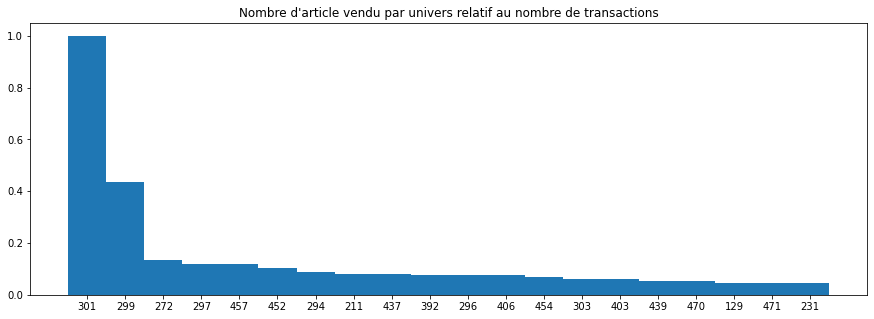

==============302===================
18394
Time Taken to load recurence: ~0secondes


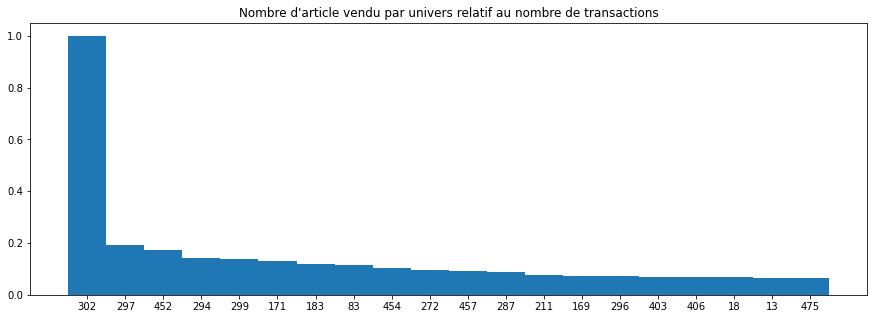

==============303===================
67659
Time Taken to load recurence: ~0secondes


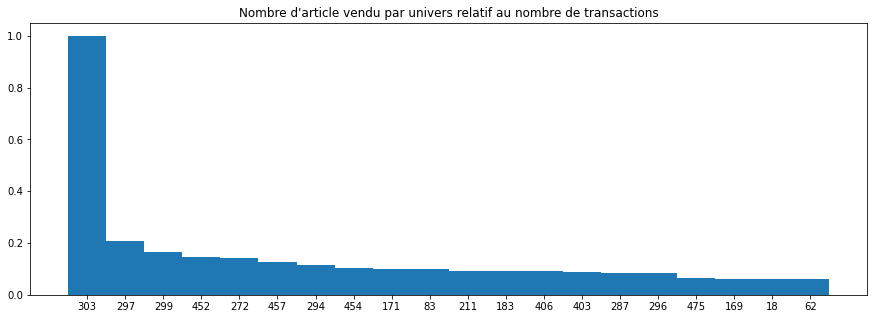

==============304===================
741
Time Taken to load recurence: ~0secondes


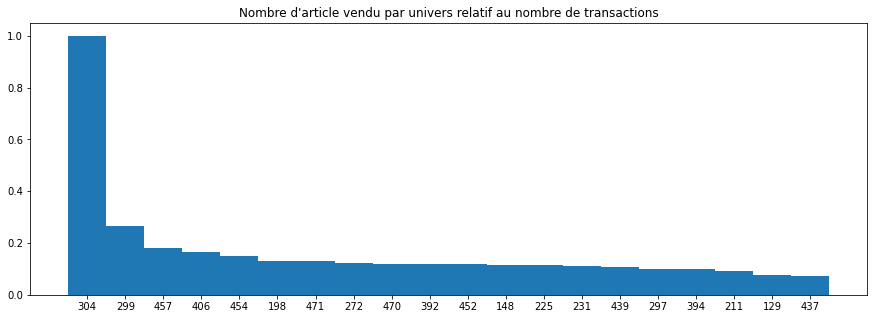

==============305===================
17049
Time Taken to load recurence: ~0secondes


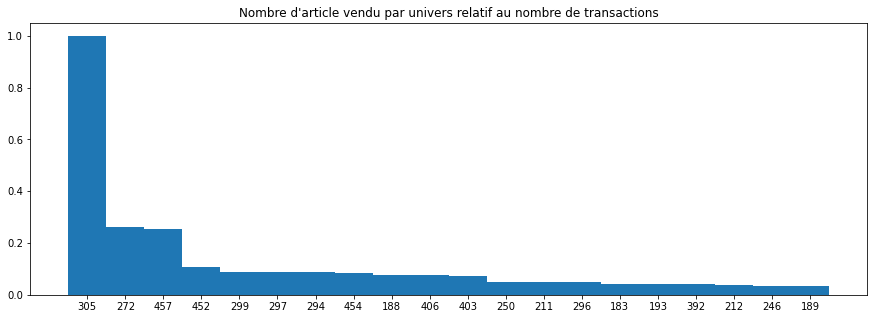

==============306===================
12216
Time Taken to load recurence: ~0secondes


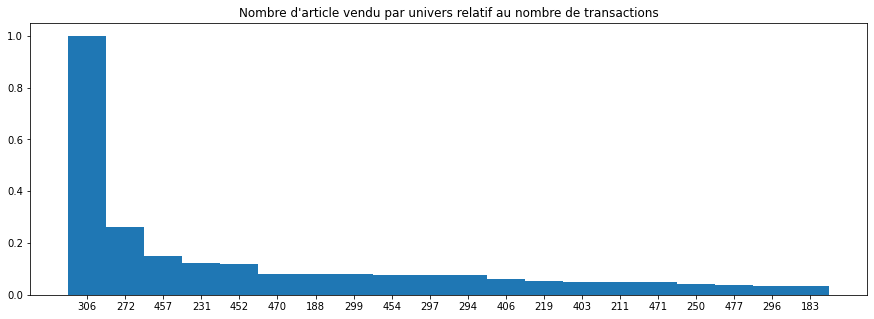

==============307===================
9276
Time Taken to load recurence: ~0secondes


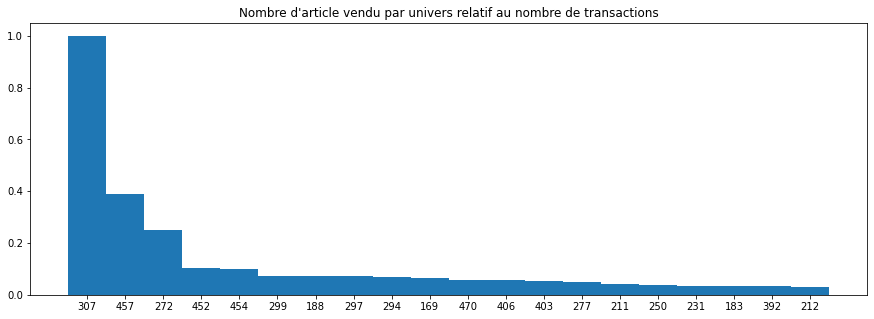

==============308===================
5972
Time Taken to load recurence: ~0secondes


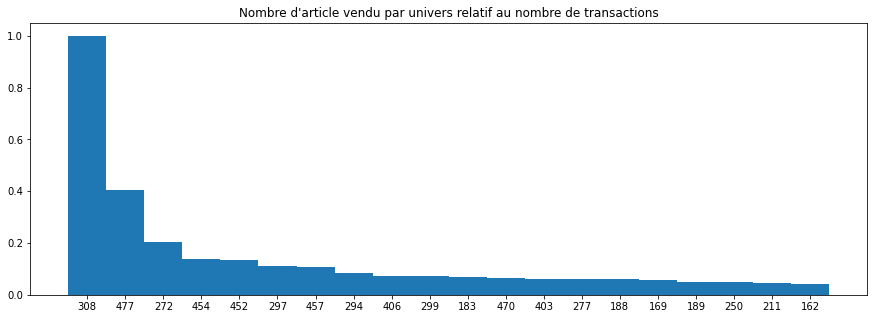

==============309===================
497
Time Taken to load recurence: ~0secondes


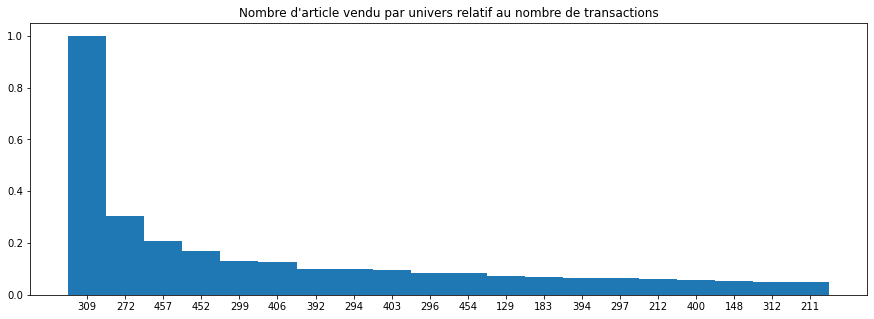

==============310===================
3533
Time Taken to load recurence: ~0secondes


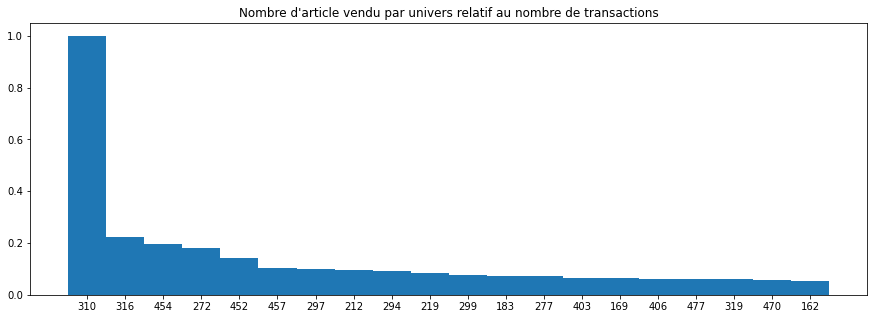

==============311===================
27530
Time Taken to load recurence: ~0secondes


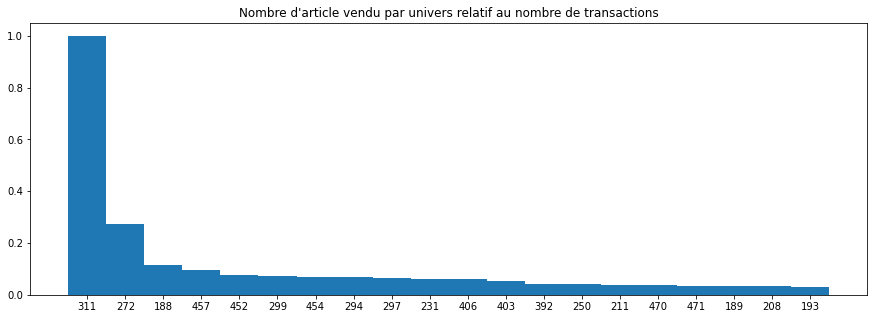

==============312===================
13427
Time Taken to load recurence: ~0secondes


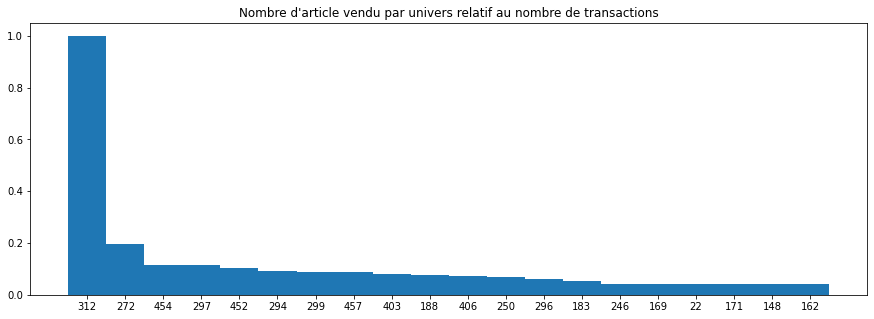

==============313===================
11919
Time Taken to load recurence: ~0secondes


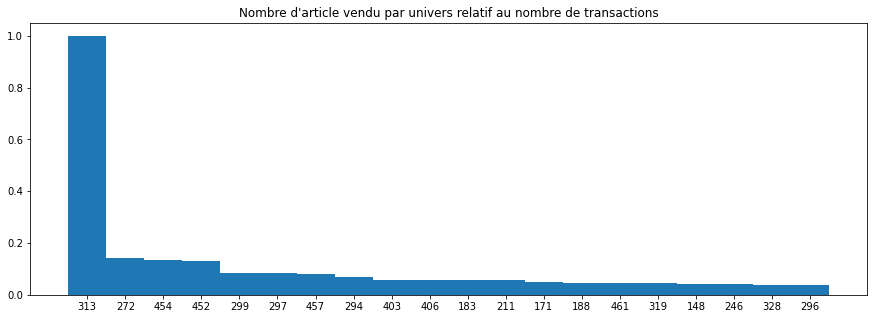

==============314===================
386
Time Taken to load recurence: ~0secondes


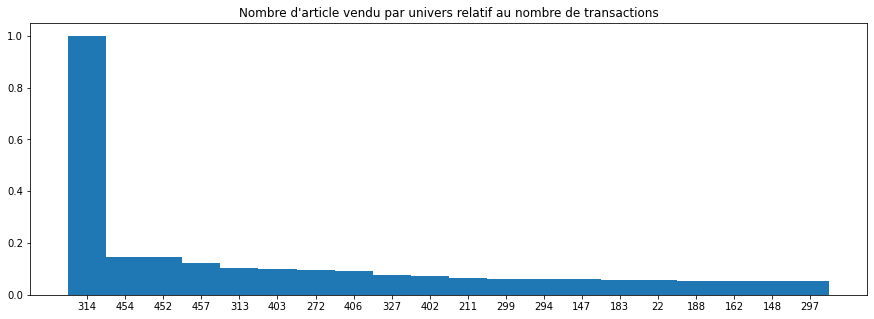

==============315===================
1134
Time Taken to load recurence: ~0secondes


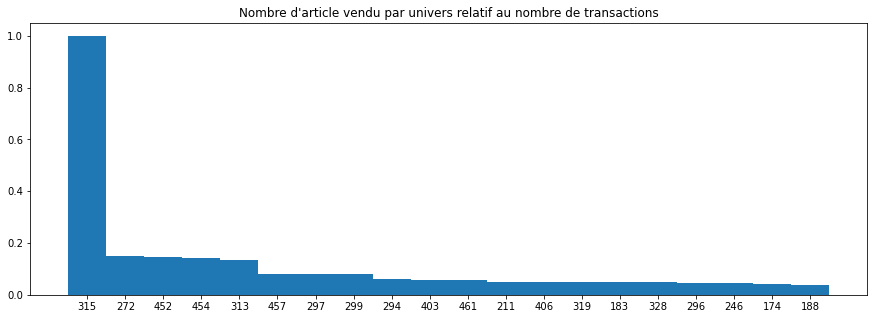

==============316===================
29836
Time Taken to load recurence: ~0secondes


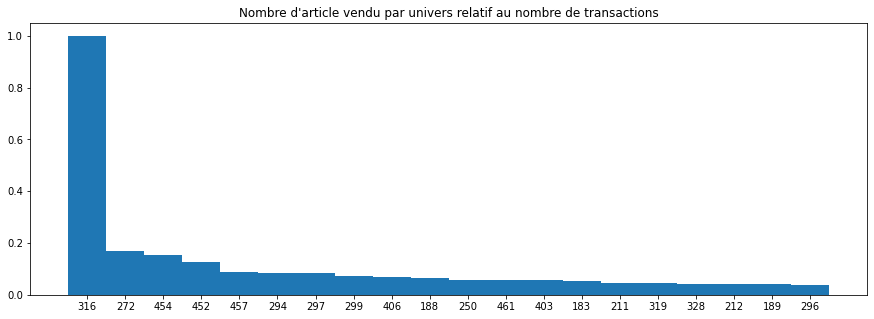

==============317===================
11500
Time Taken to load recurence: ~0secondes


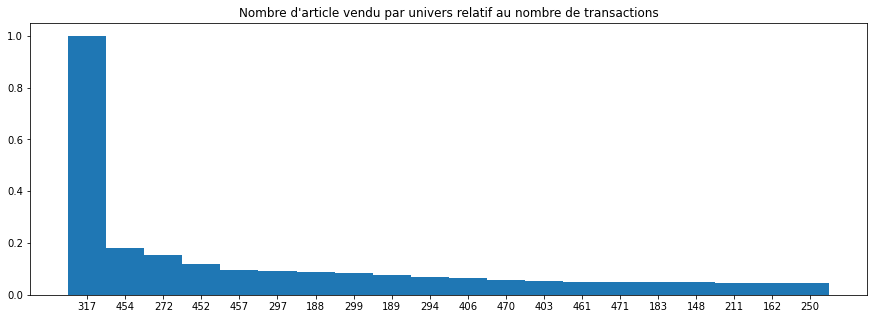

==============318===================
2745
Time Taken to load recurence: ~0secondes


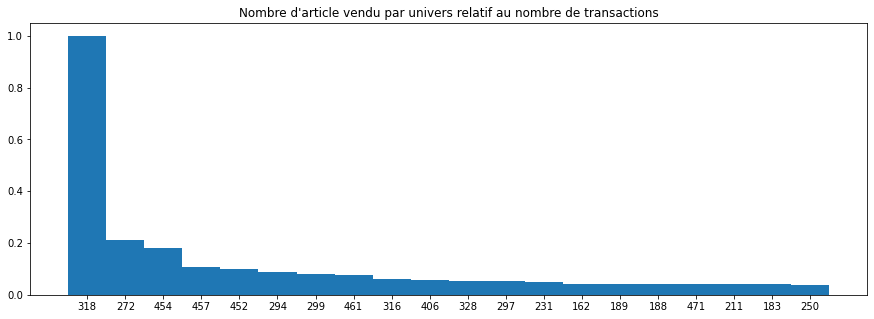

==============319===================
52564
Time Taken to load recurence: ~0secondes


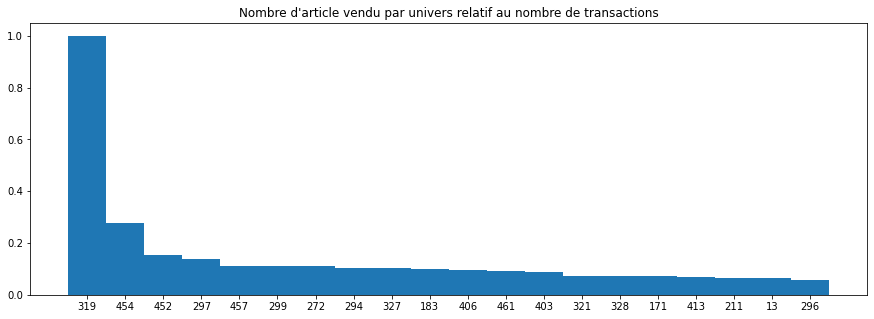

==============320===================
3412
Time Taken to load recurence: ~0secondes


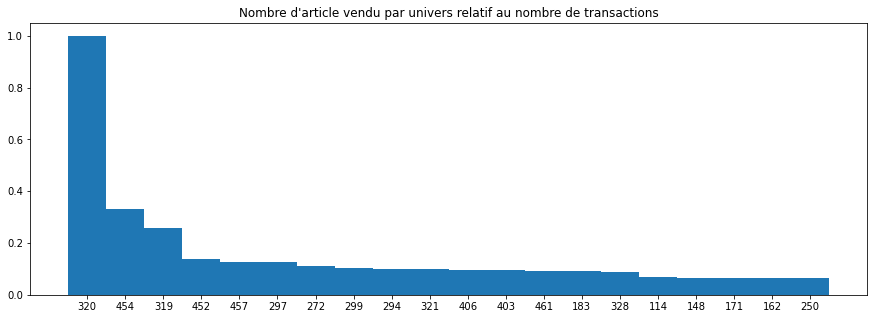

==============321===================
35306
Time Taken to load recurence: ~0secondes


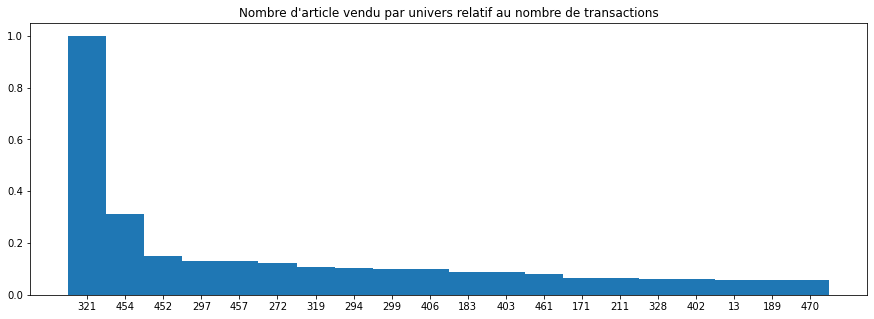

==============322===================
1534
Time Taken to load recurence: ~0secondes


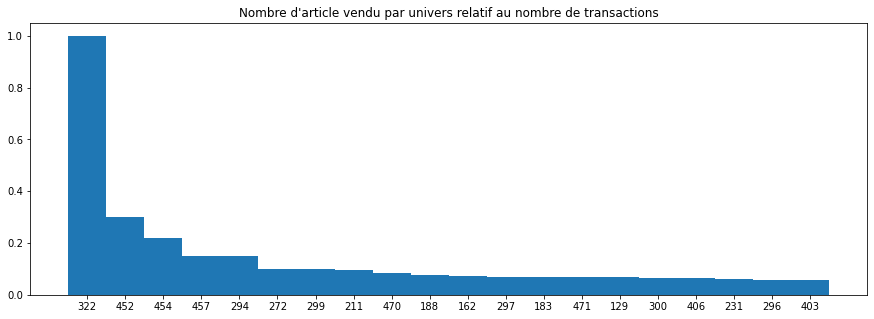

==============323===================
8684
Time Taken to load recurence: ~0secondes


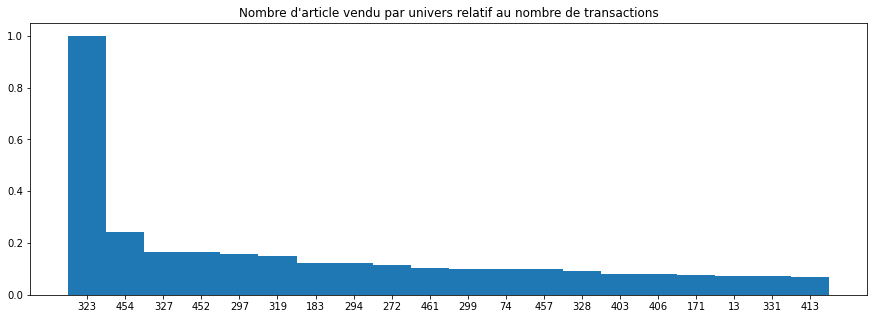

==============324===================
15840
Time Taken to load recurence: ~0secondes


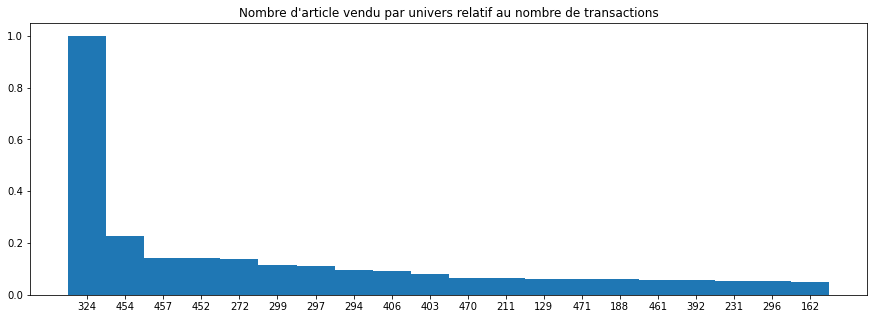

==============326===================
1627
Time Taken to load recurence: ~0secondes


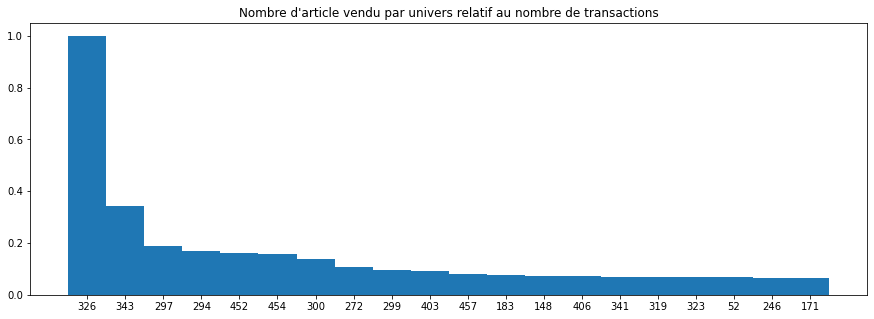

==============327===================
30375
Time Taken to load recurence: ~0secondes


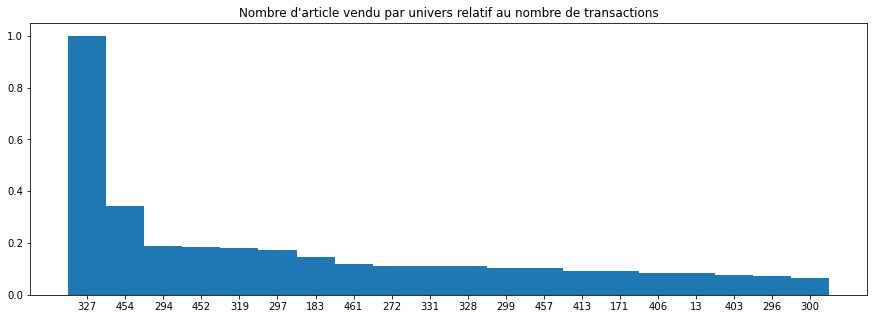

==============328===================
40223
Time Taken to load recurence: ~0secondes


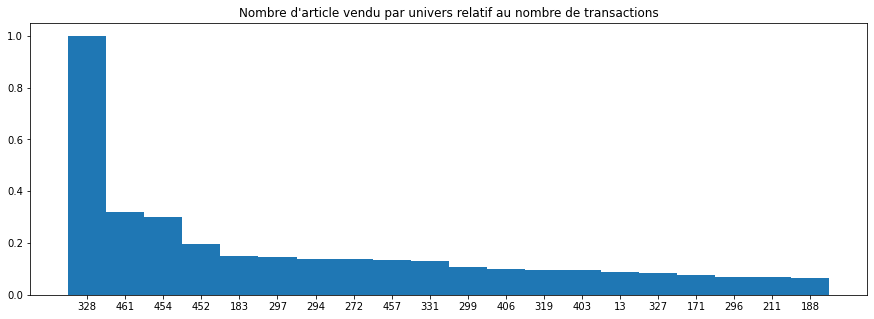

==============329===================
1879
Time Taken to load recurence: ~0secondes


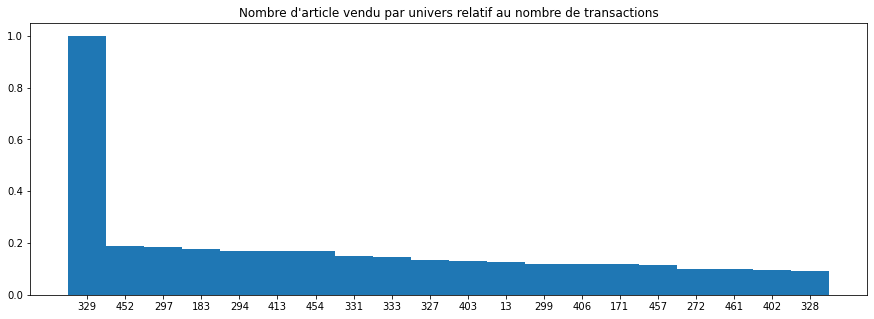

==============331===================
28702
Time Taken to load recurence: ~0secondes


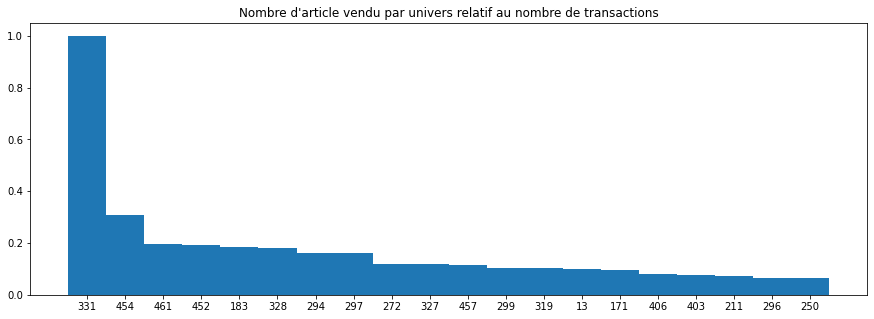

==============332===================
517
Time Taken to load recurence: ~0secondes


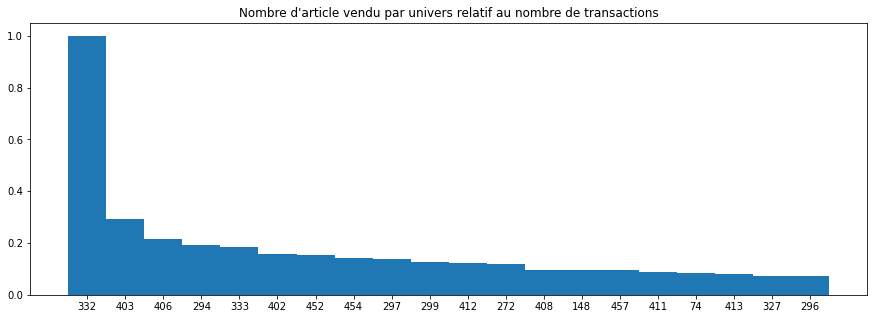

==============333===================
13795
Time Taken to load recurence: ~0secondes


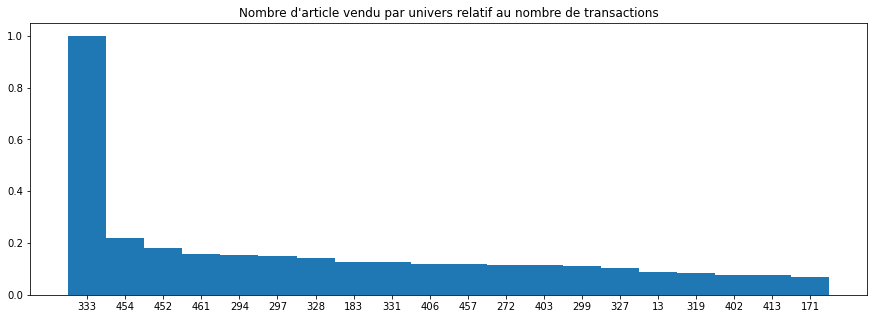

==============334===================
6594
Time Taken to load recurence: ~0secondes


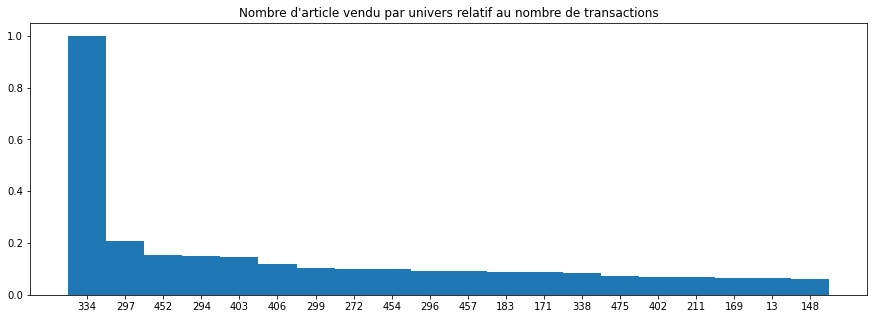

==============335===================
2555
Time Taken to load recurence: ~0secondes


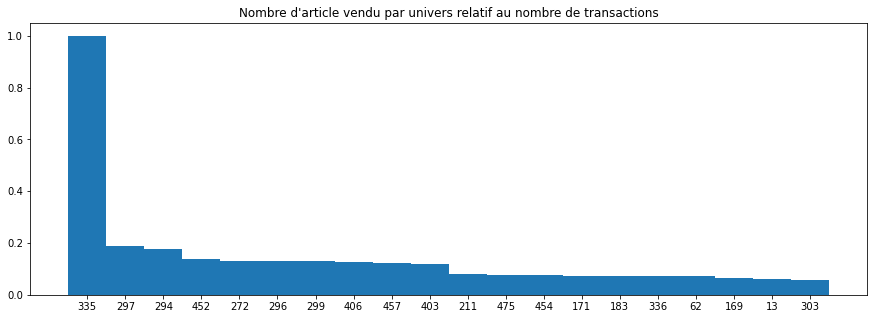

==============336===================
8404
Time Taken to load recurence: ~0secondes


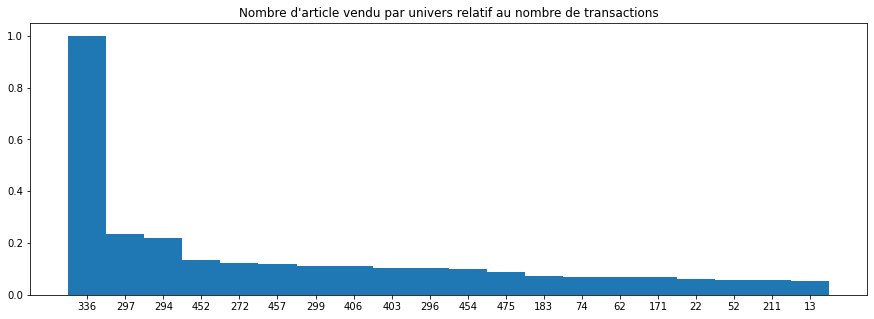

==============337===================
1514
Time Taken to load recurence: ~0secondes


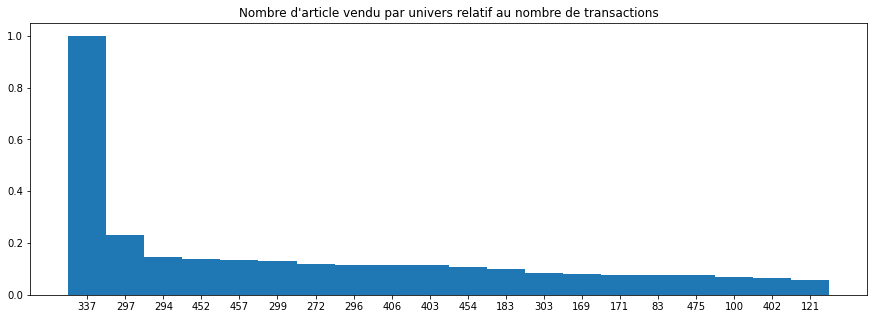

==============338===================
4699
Time Taken to load recurence: ~0secondes


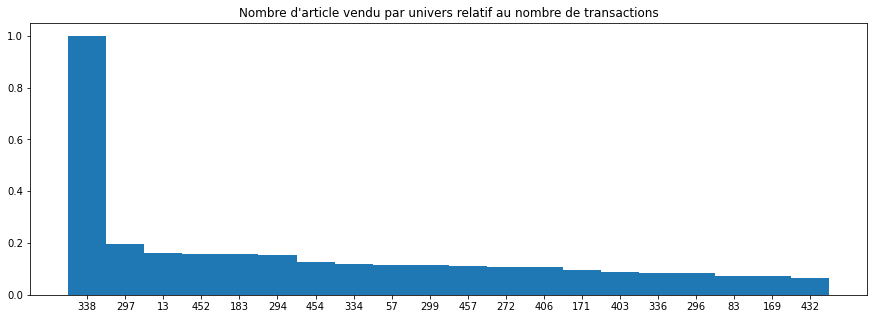

==============339===================
22638
Time Taken to load recurence: ~0secondes


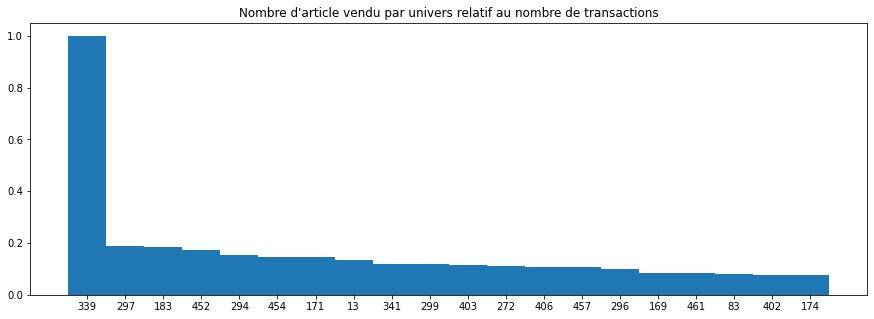

==============341===================
28472
Time Taken to load recurence: ~0secondes


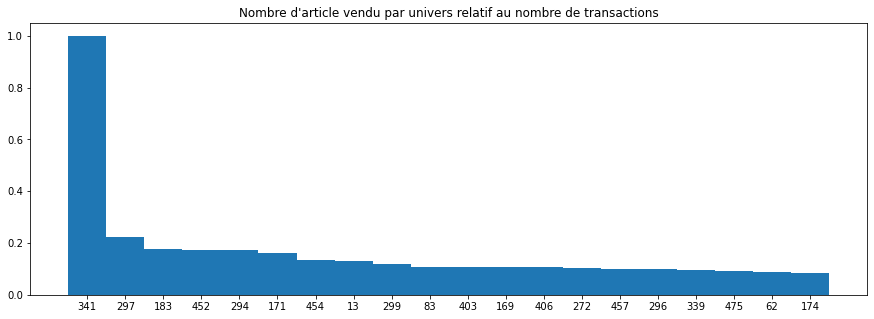

==============342===================
2294
Time Taken to load recurence: ~0secondes


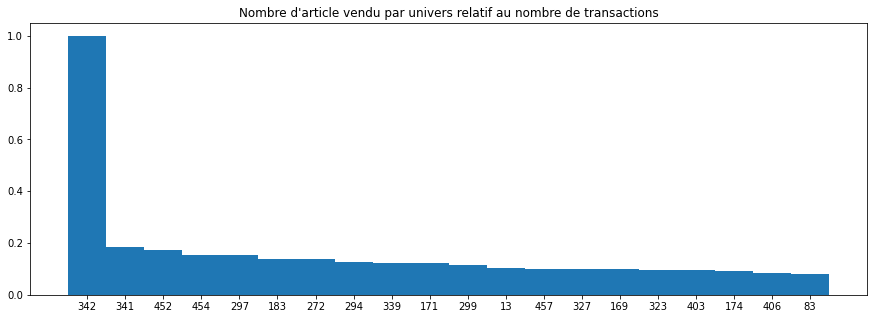

==============343===================
5286
Time Taken to load recurence: ~0secondes


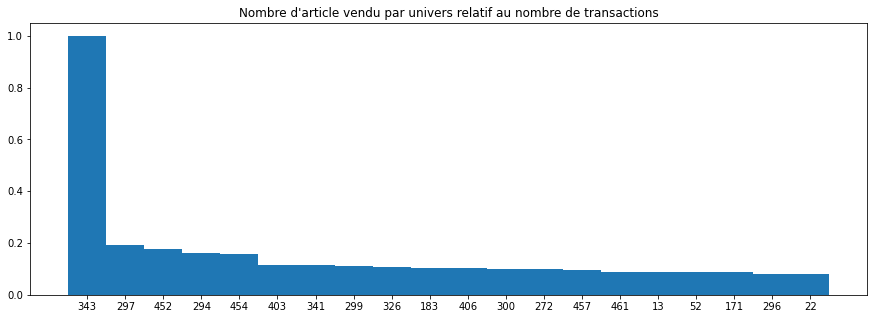

==============344===================
9476
Time Taken to load recurence: ~0secondes


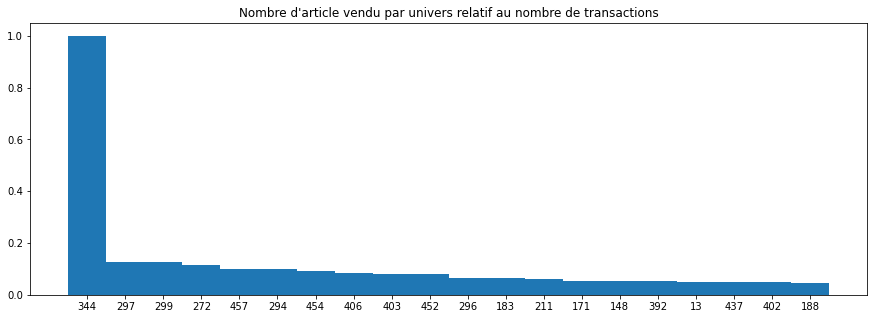

==============347===================
487
Time Taken to load recurence: ~0secondes


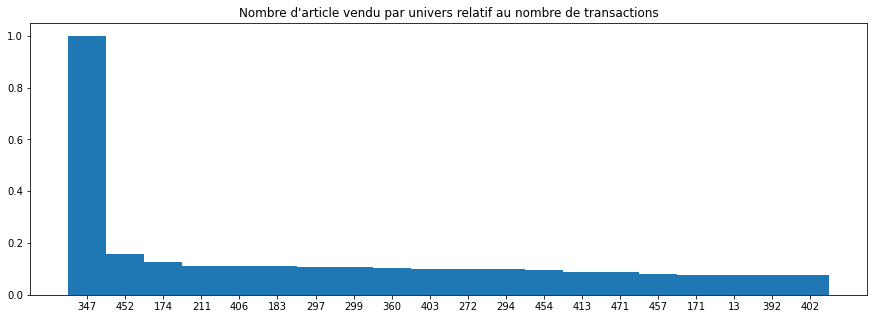

==============348===================
1934
Time Taken to load recurence: ~0secondes


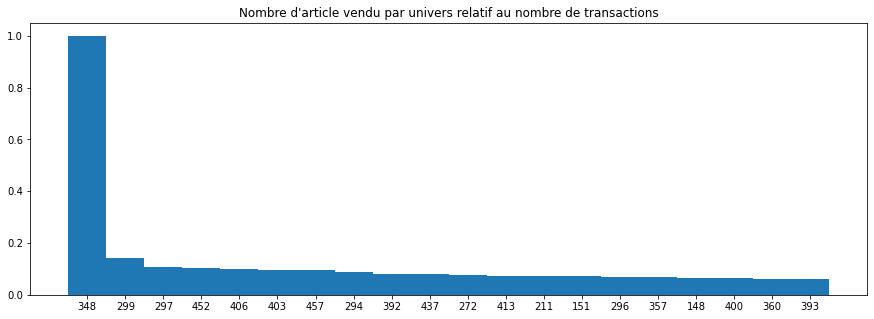

==============350===================
1056
Time Taken to load recurence: ~0secondes


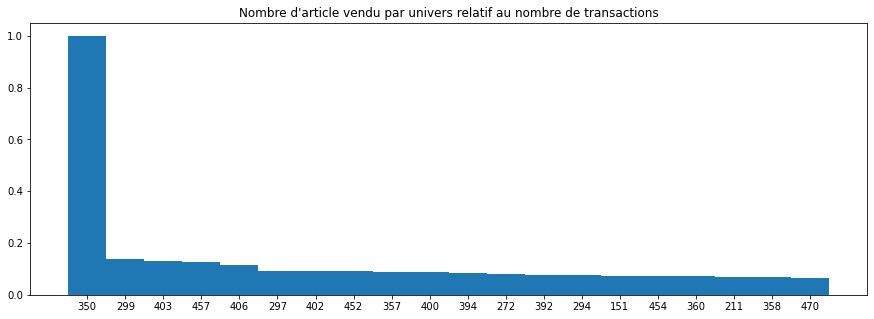

==============351===================
2360
Time Taken to load recurence: ~0secondes


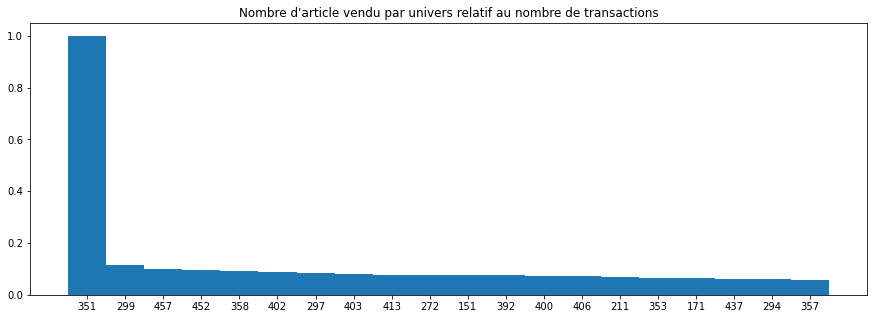

==============353===================
9804
Time Taken to load recurence: ~0secondes


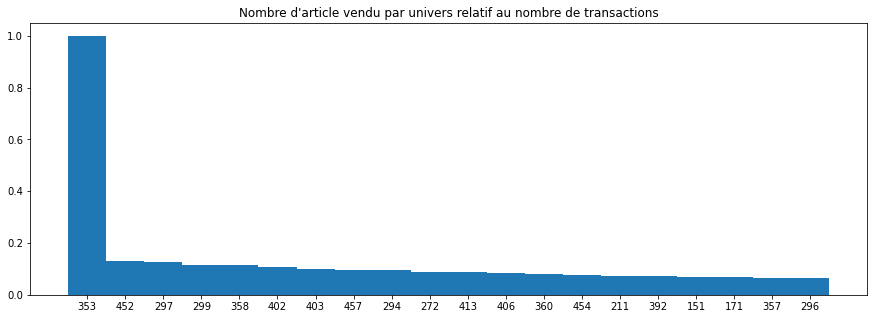

==============354===================
NOT ENOUGH DATA 
==============355===================
10846
Time Taken to load recurence: ~0secondes


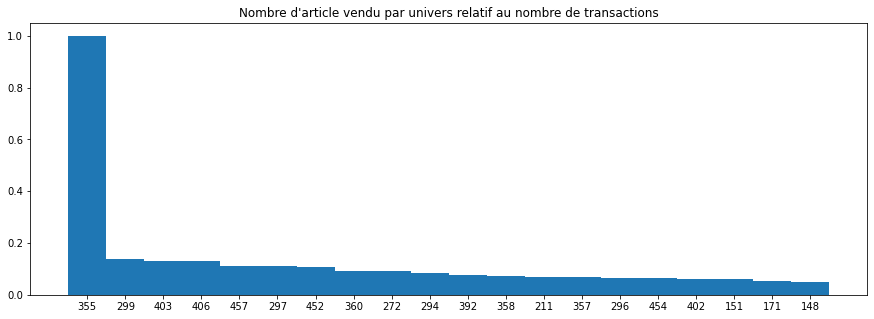

==============356===================
1129
Time Taken to load recurence: ~0secondes


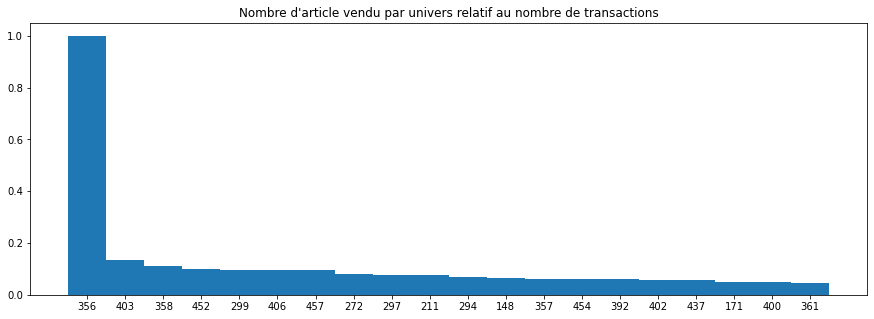

==============357===================
91809
Time Taken to load recurence: ~0secondes


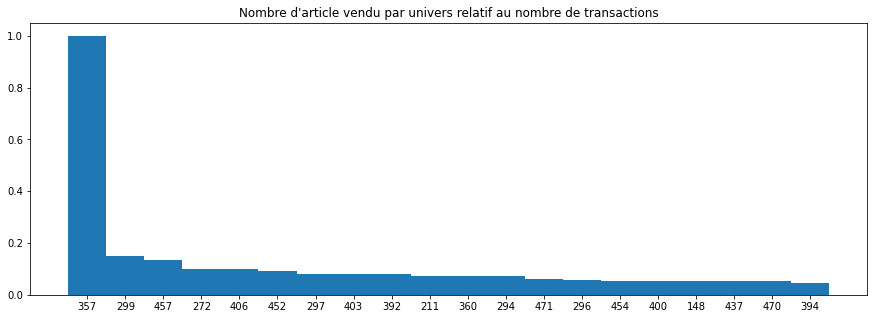

==============358===================
34700
Time Taken to load recurence: ~0secondes


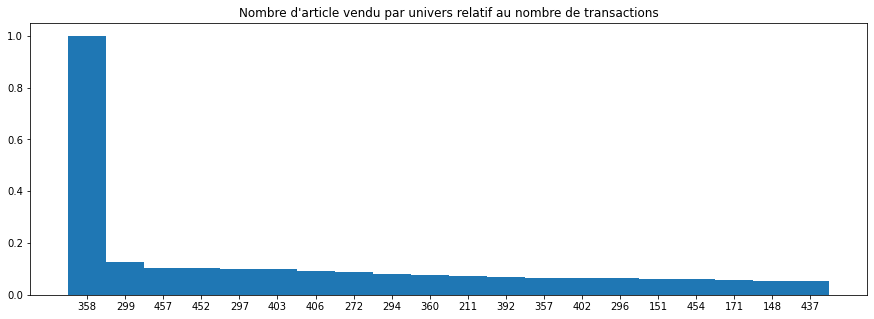

==============359===================
3459
Time Taken to load recurence: ~0secondes


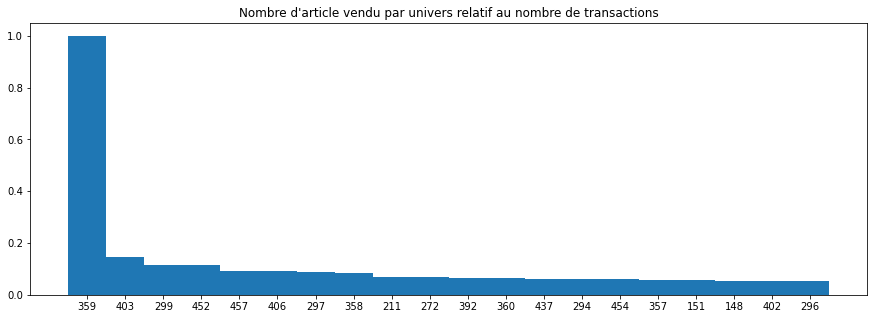

==============360===================
83525
Time Taken to load recurence: ~0secondes


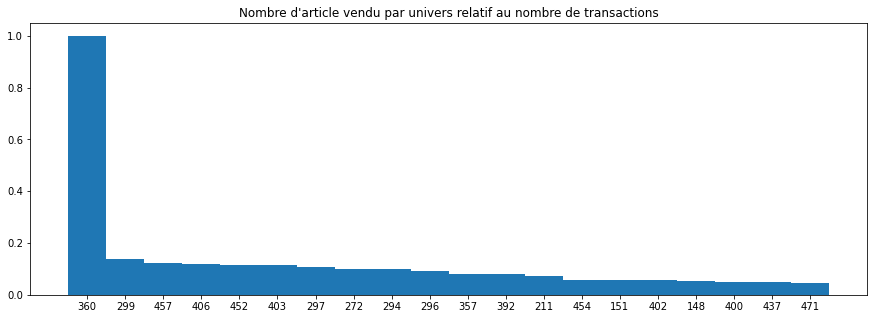

==============361===================
11831
Time Taken to load recurence: ~0secondes


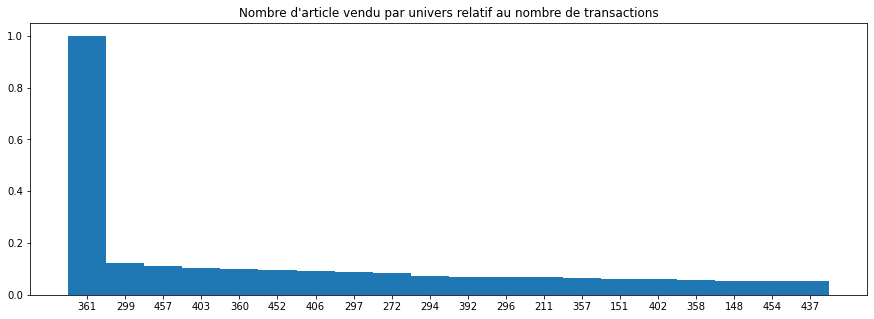

==============362===================
6886
Time Taken to load recurence: ~0secondes


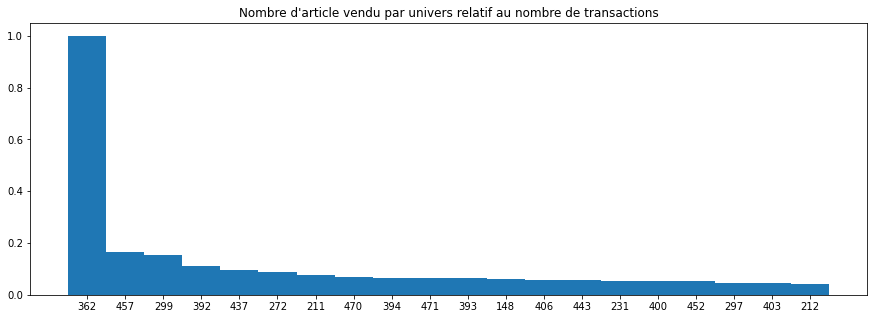

==============363===================
2598
Time Taken to load recurence: ~0secondes


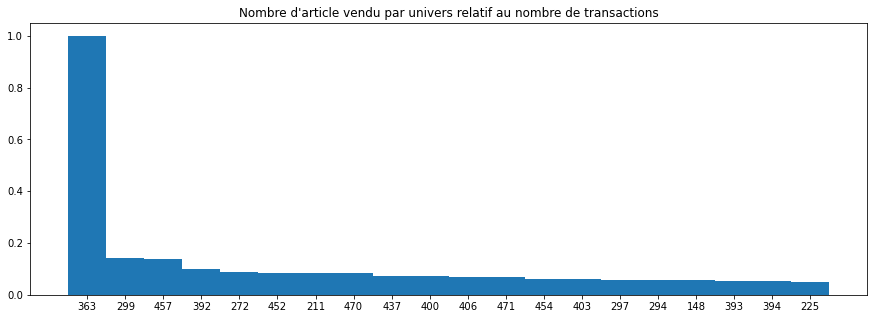

==============366===================
2718
Time Taken to load recurence: ~0secondes


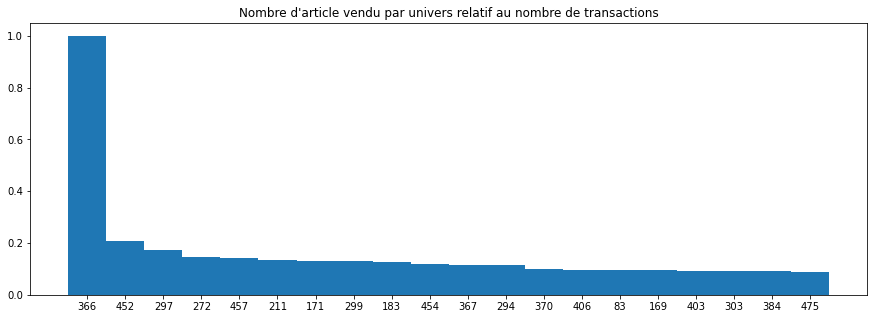

==============367===================
1498
Time Taken to load recurence: ~0secondes


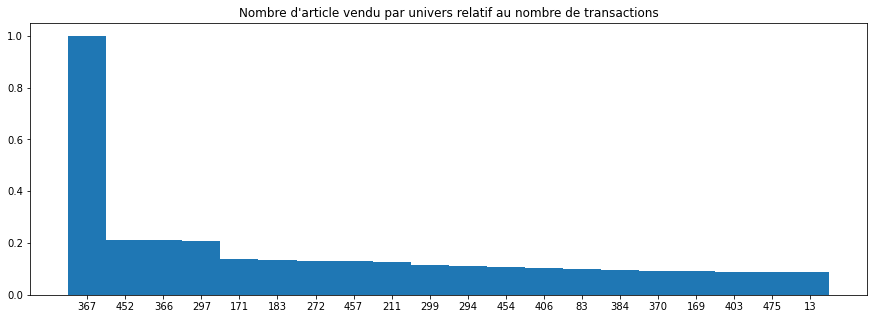

==============368===================
195
Time Taken to load recurence: ~0secondes


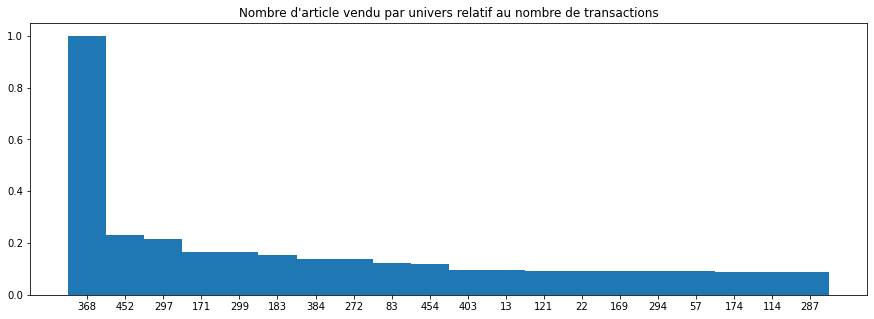

==============369===================
7520
Time Taken to load recurence: ~0secondes


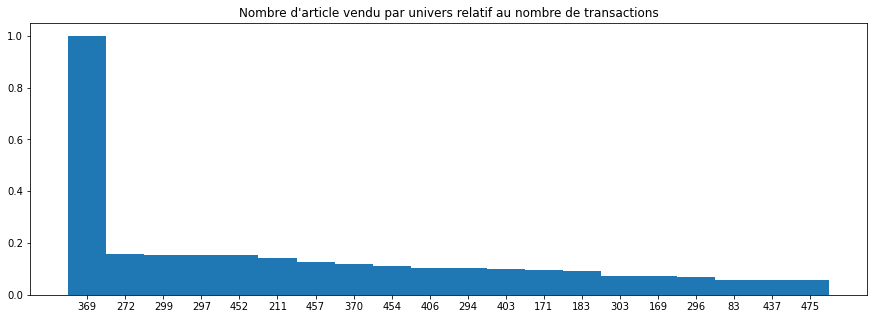

==============370===================
21803
Time Taken to load recurence: ~0secondes


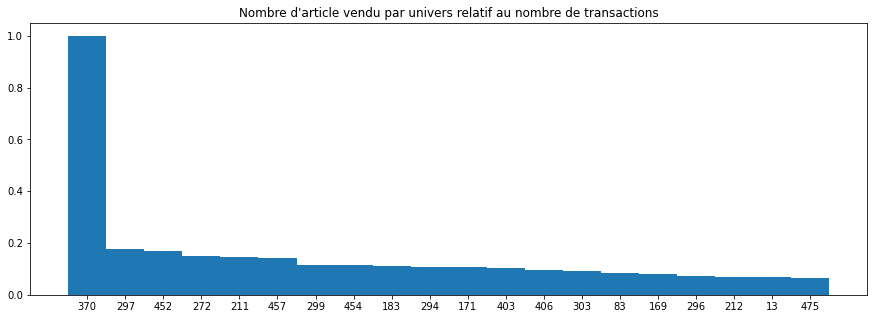

==============372===================
1778
Time Taken to load recurence: ~0secondes


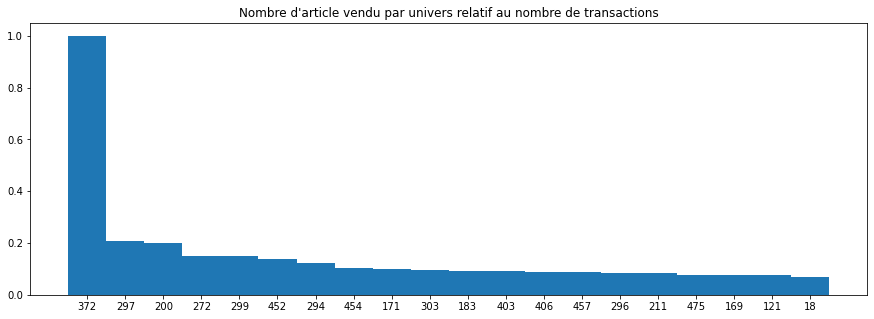

==============373===================
1854
Time Taken to load recurence: ~0secondes


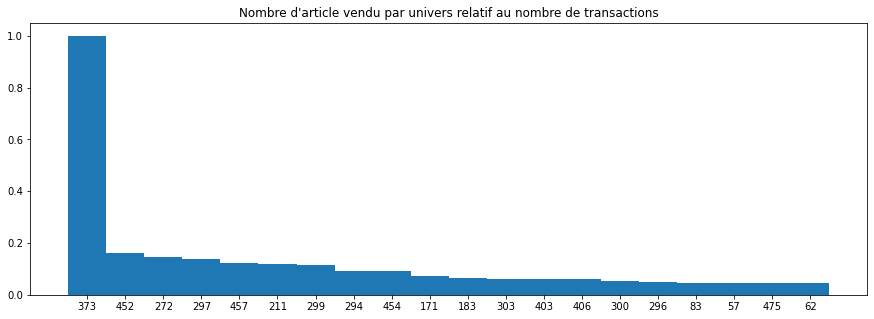

==============374===================
827
Time Taken to load recurence: ~0secondes


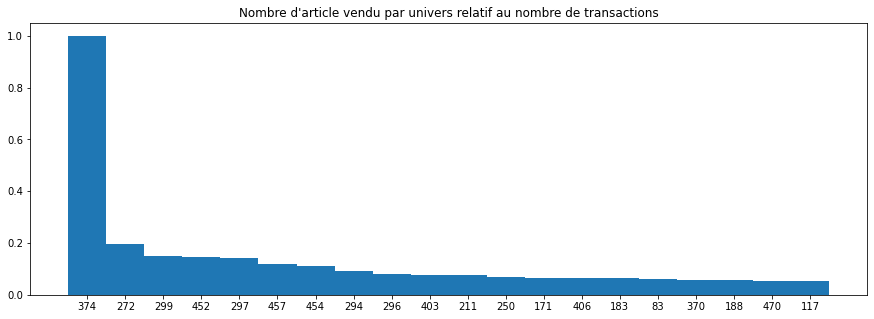

==============375===================
5266
Time Taken to load recurence: ~0secondes


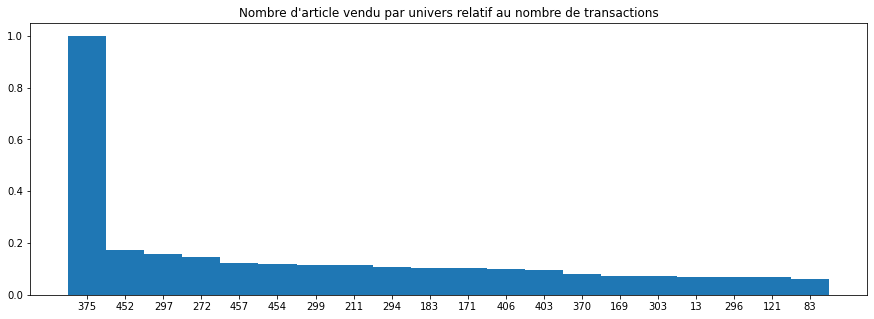

==============376===================
2823
Time Taken to load recurence: ~0secondes


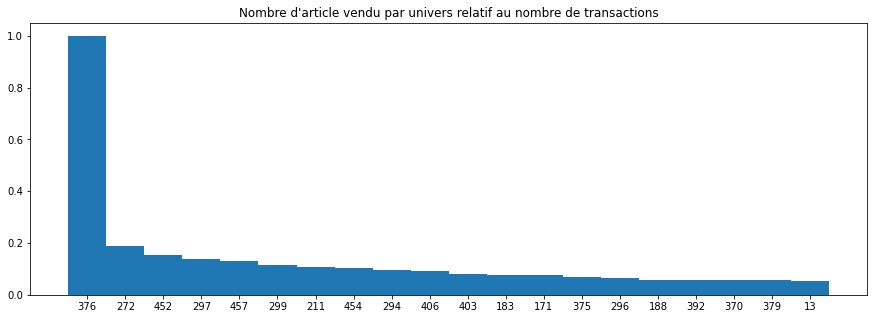

==============377===================
7211
Time Taken to load recurence: ~0secondes


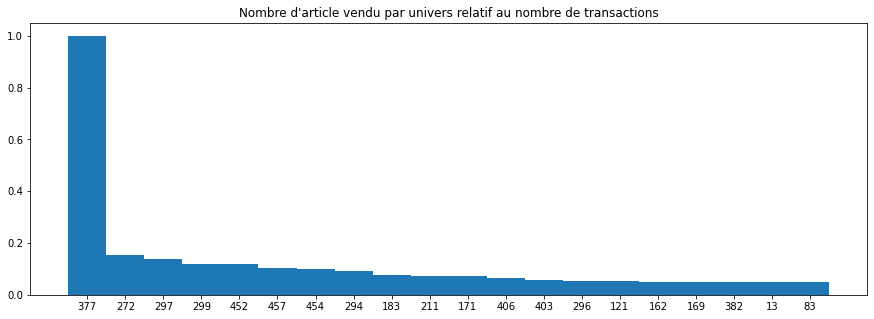

==============378===================
1262
Time Taken to load recurence: ~0secondes


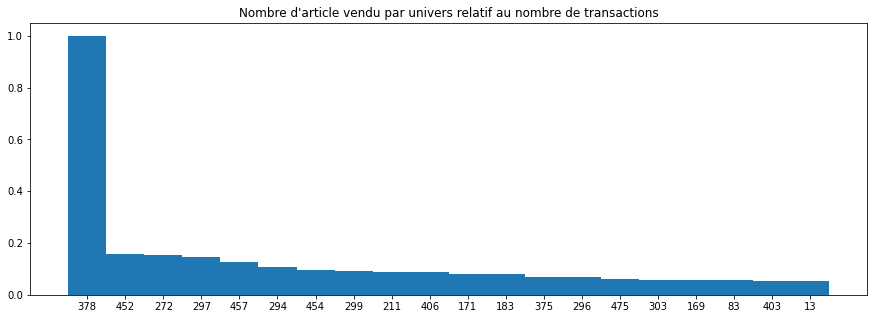

==============379===================
3748
Time Taken to load recurence: ~0secondes


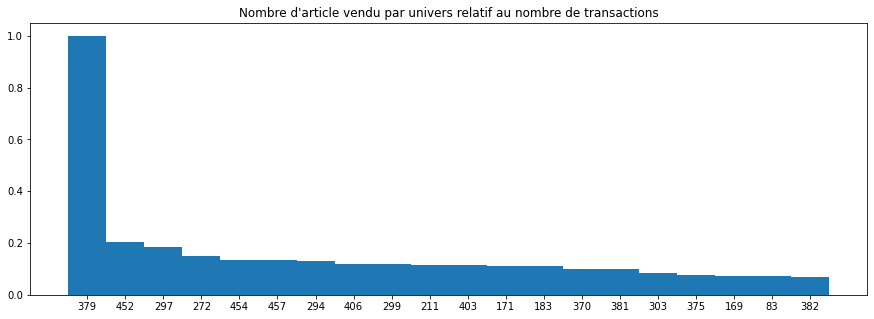

==============380===================
3282
Time Taken to load recurence: ~0secondes


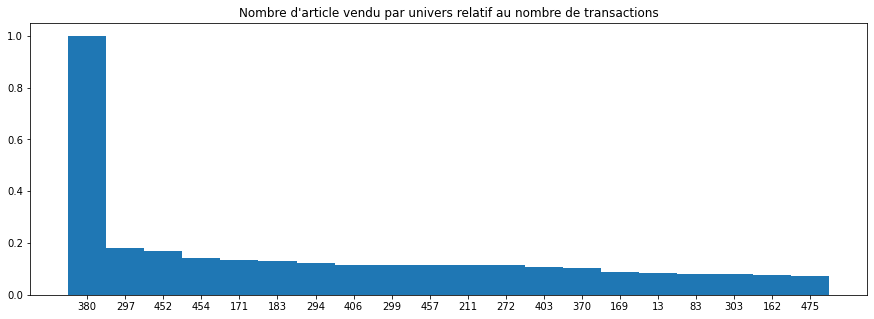

==============381===================
1961
Time Taken to load recurence: ~0secondes


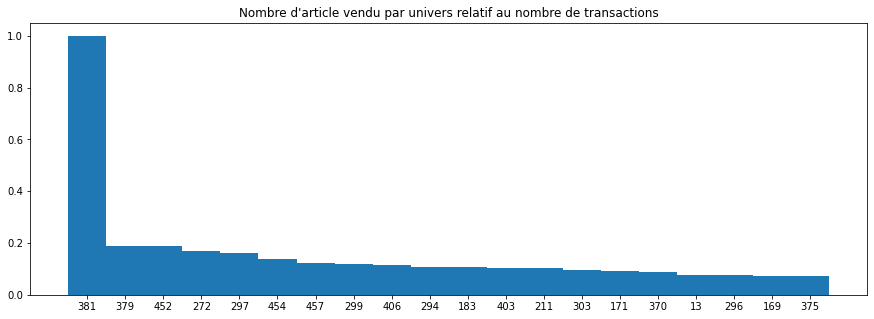

==============382===================
7010
Time Taken to load recurence: ~0secondes


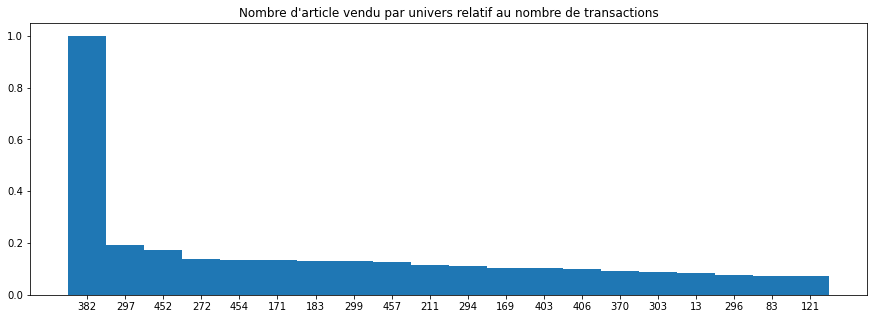

==============384===================
9632
Time Taken to load recurence: ~0secondes


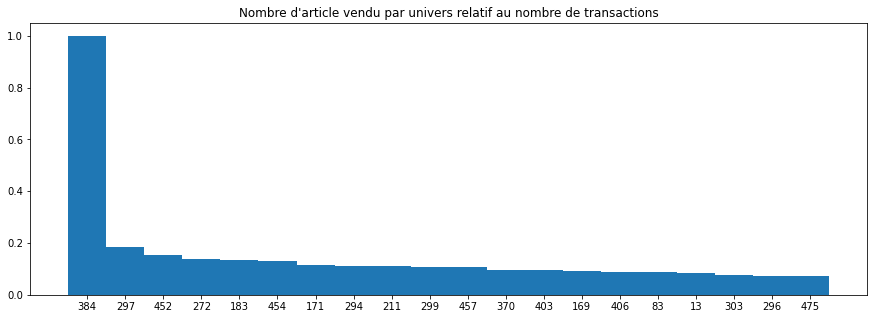

==============386===================
17056
Time Taken to load recurence: ~0secondes


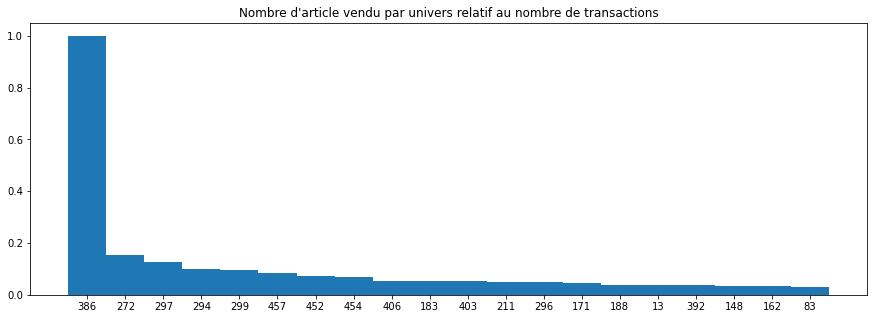

==============387===================
5280
Time Taken to load recurence: ~0secondes


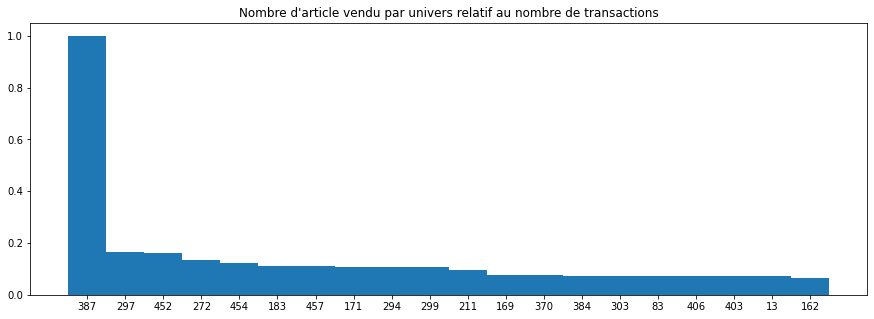

==============390===================
NOT ENOUGH DATA 
==============391===================
668
Time Taken to load recurence: ~0secondes


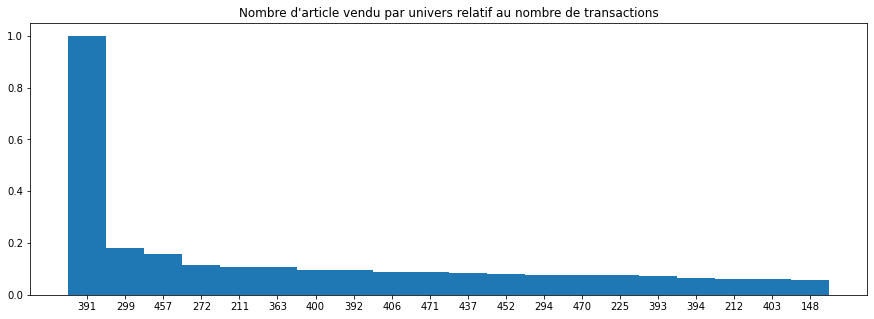

==============392===================
292840
Time Taken to load recurence: ~0secondes


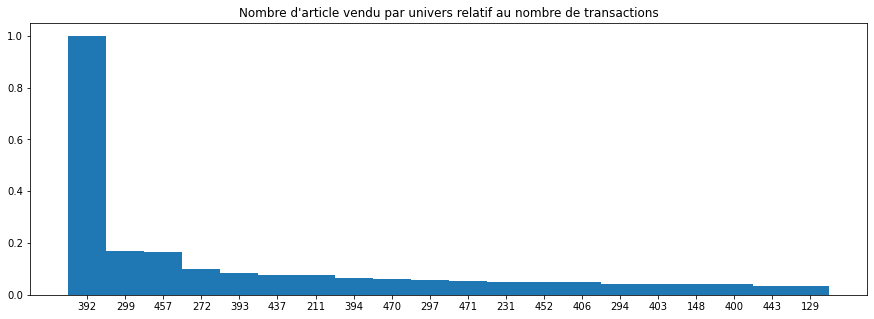

==============393===================
128662
Time Taken to load recurence: ~0secondes


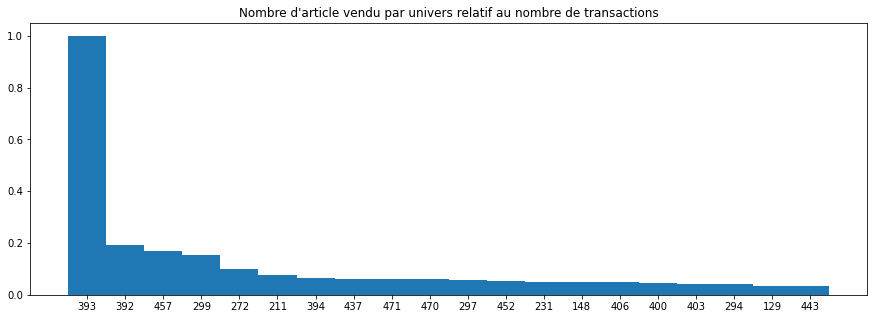

==============394===================
117102
Time Taken to load recurence: ~0secondes


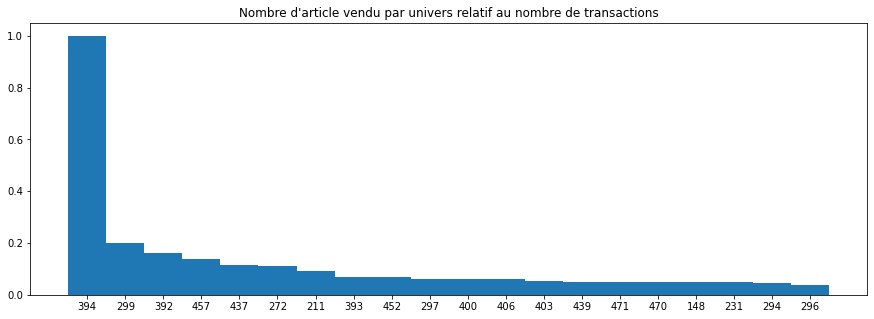

==============395===================
223
Time Taken to load recurence: ~0secondes


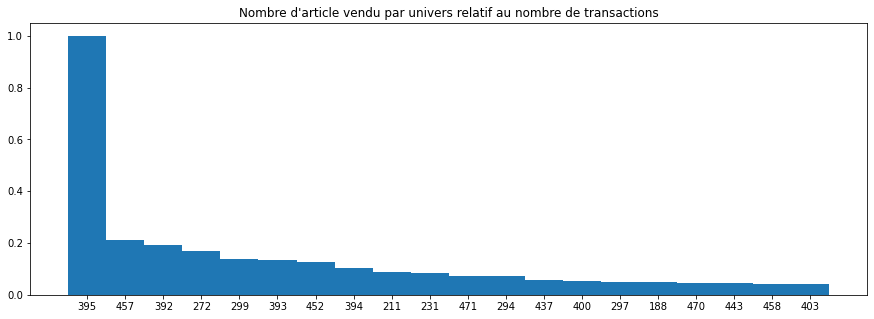

==============396===================
42061
Time Taken to load recurence: ~0secondes


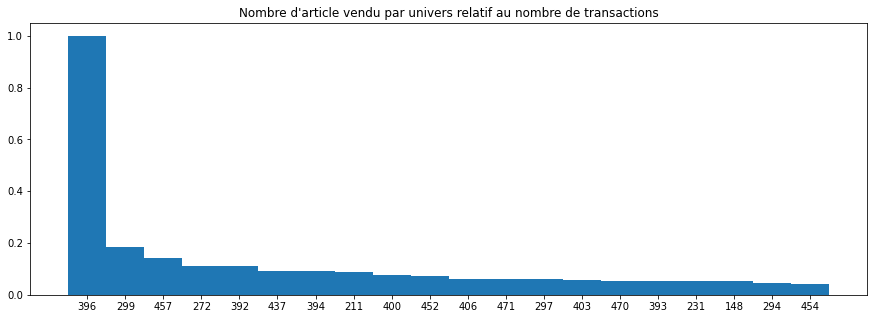

==============397===================
702
Time Taken to load recurence: ~0secondes


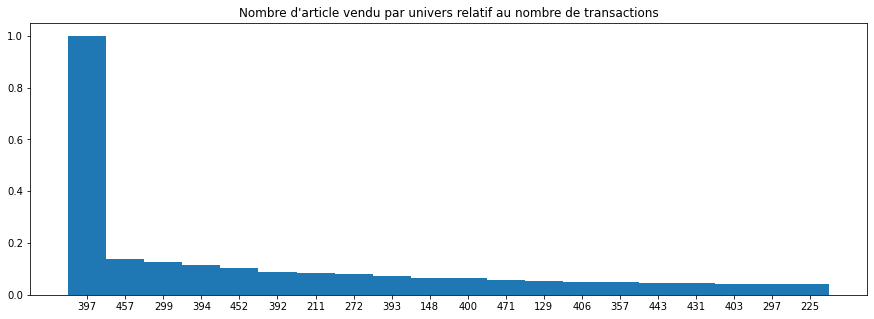

==============400===================
102892
Time Taken to load recurence: ~0secondes


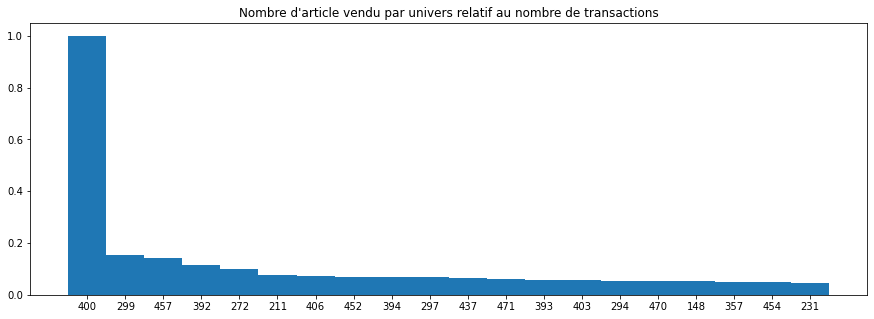

==============402===================
125554
Time Taken to load recurence: ~0secondes


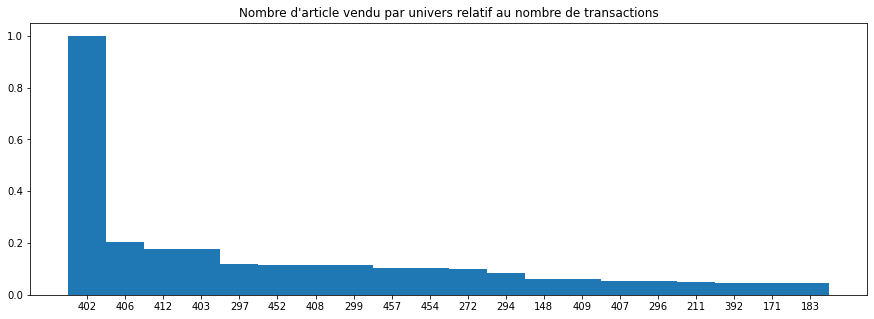

==============403===================
247471
Time Taken to load recurence: ~0secondes


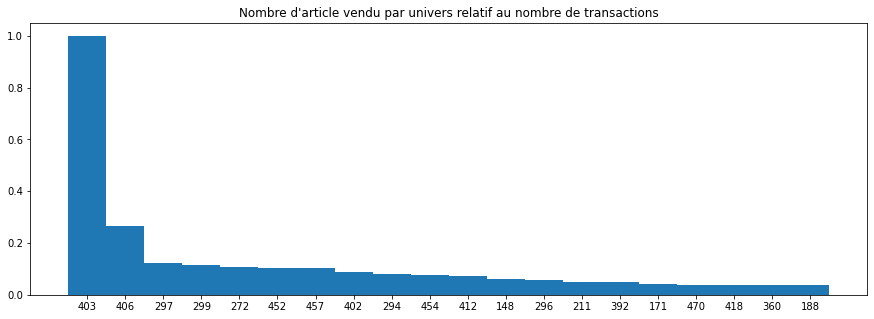

==============404===================
26761
Time Taken to load recurence: ~0secondes


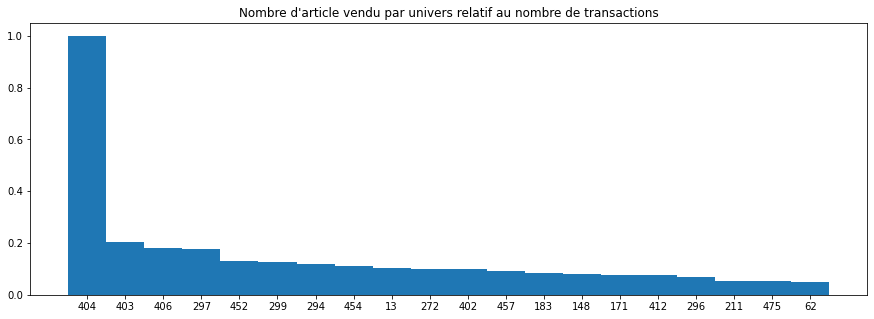

==============405===================
33085
Time Taken to load recurence: ~0secondes


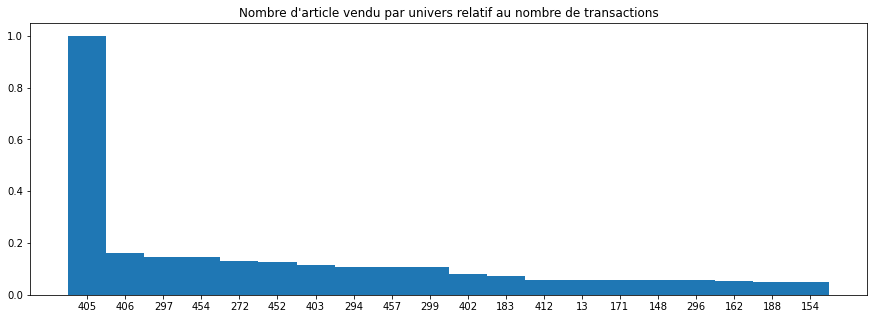

==============406===================
289376
Time Taken to load recurence: ~0secondes


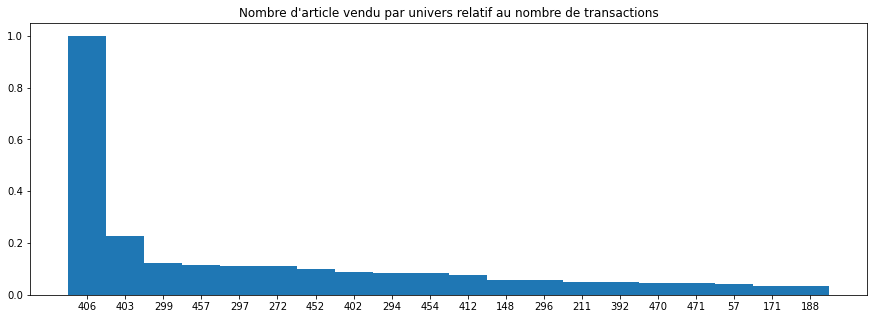

==============407===================
34432
Time Taken to load recurence: ~0secondes


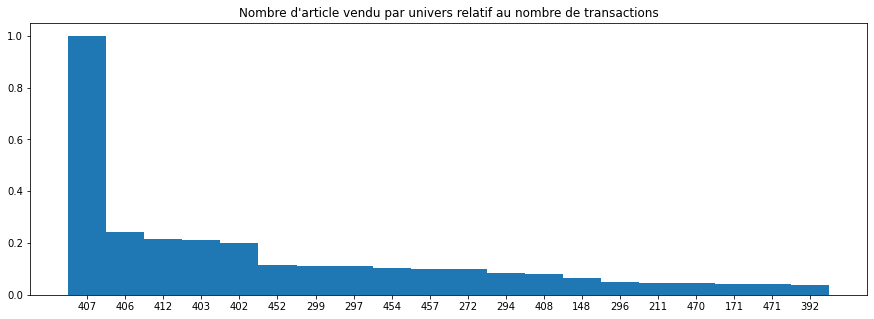

==============408===================
41251
Time Taken to load recurence: ~0secondes


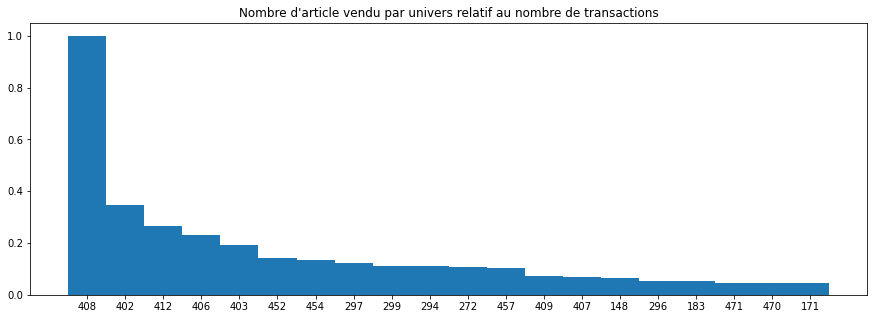

==============409===================
47218
Time Taken to load recurence: ~0secondes


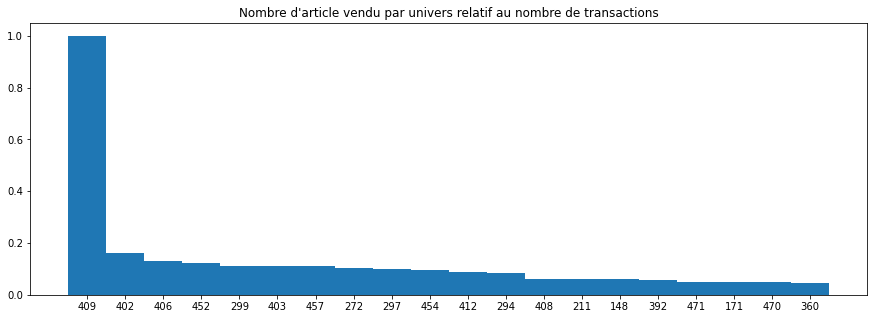

==============410===================
3947
Time Taken to load recurence: ~0secondes


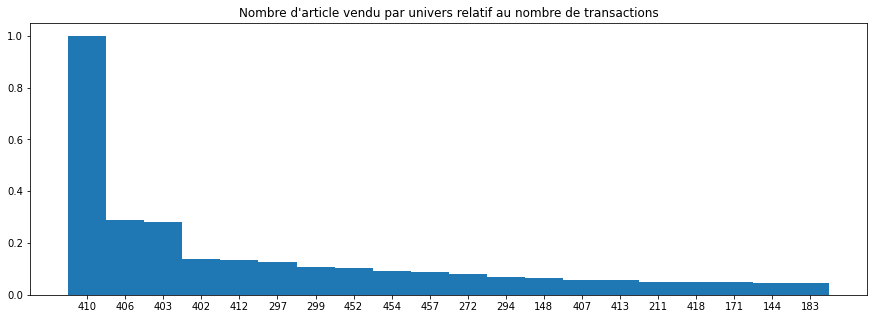

==============411===================
14989
Time Taken to load recurence: ~0secondes


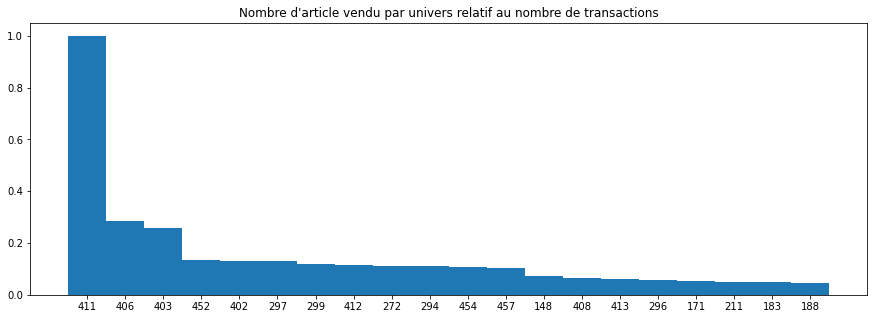

==============412===================
96098
Time Taken to load recurence: ~0secondes


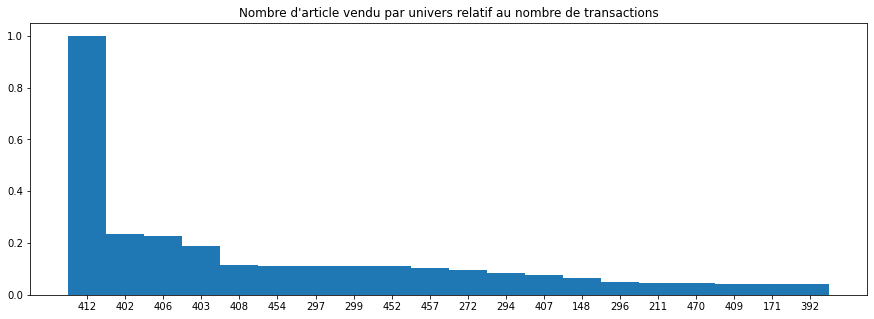

==============413===================
41459
Time Taken to load recurence: ~0secondes


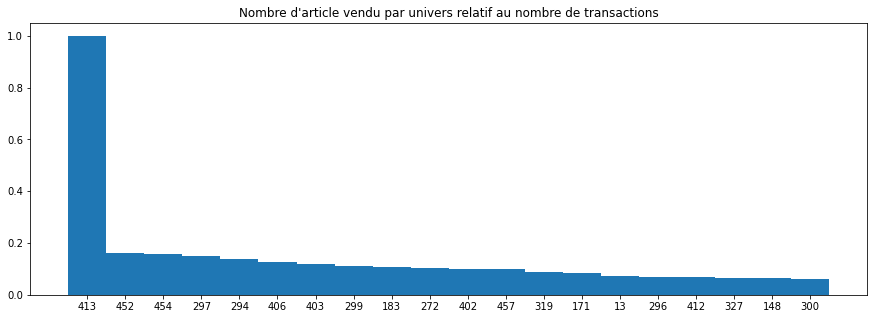

==============416===================
22732
Time Taken to load recurence: ~0secondes


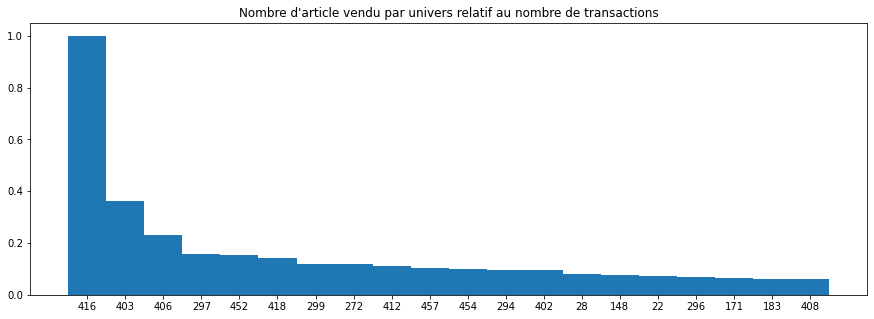

==============417===================
1814
Time Taken to load recurence: ~0secondes


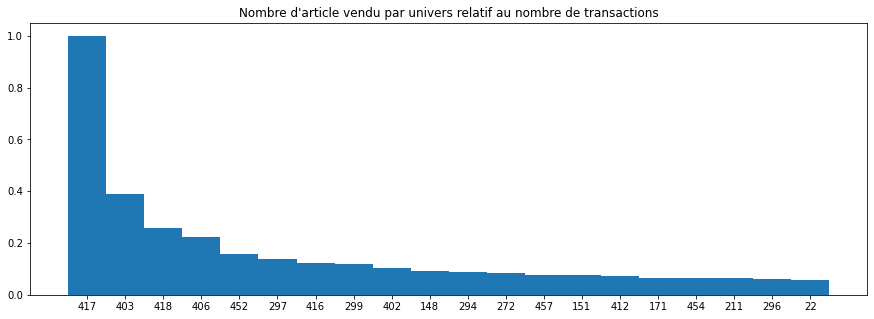

==============418===================
24530
Time Taken to load recurence: ~0secondes


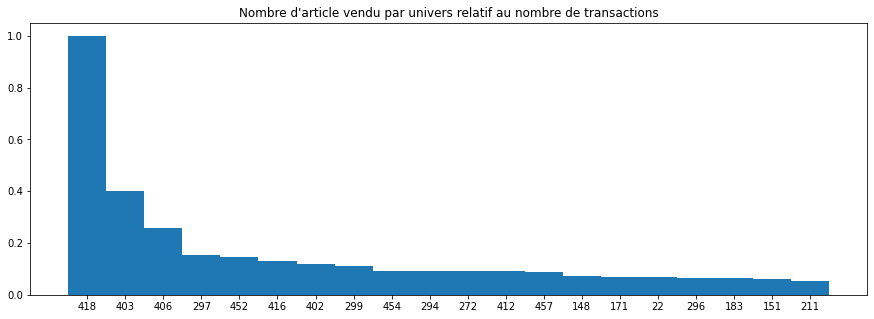

==============419===================
7563
Time Taken to load recurence: ~0secondes


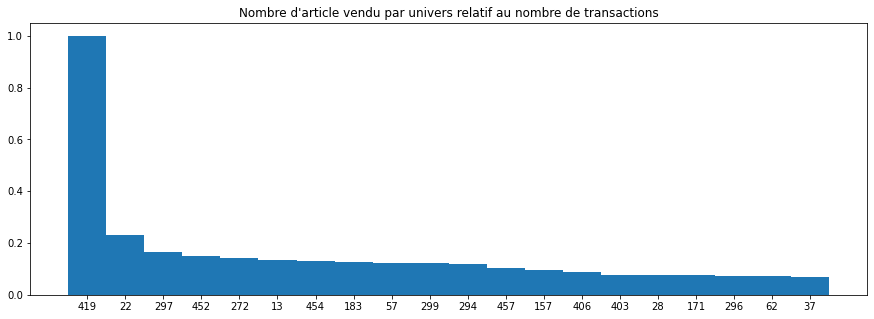

==============420===================
6448
Time Taken to load recurence: ~0secondes


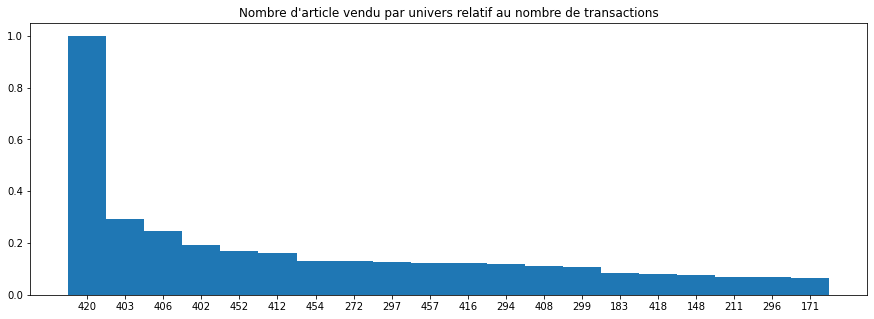

==============421===================
417
Time Taken to load recurence: ~0secondes


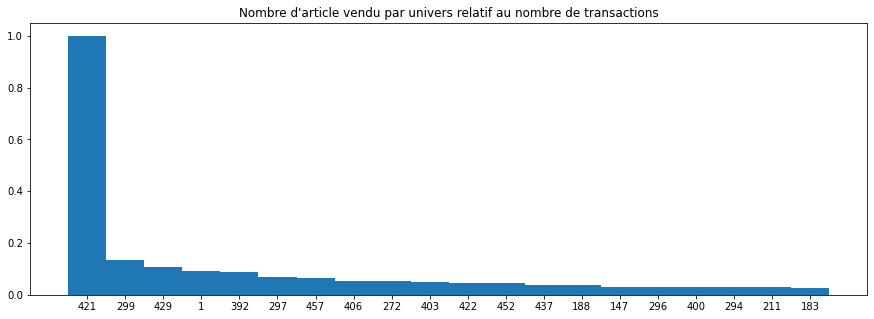

==============422===================
119
Time Taken to load recurence: ~0secondes


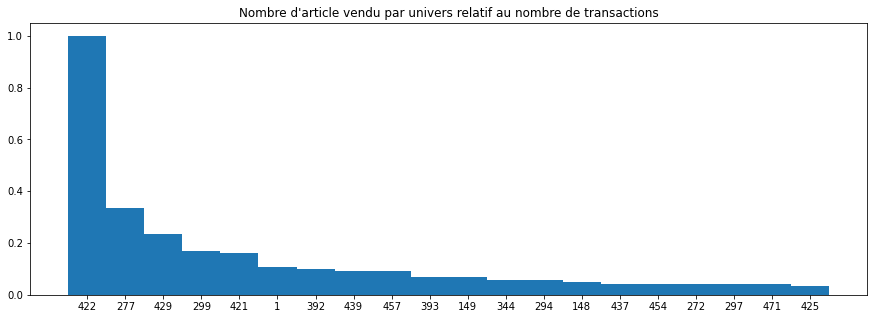

==============425===================
NOT ENOUGH DATA 
==============429===================
1225
Time Taken to load recurence: ~0secondes


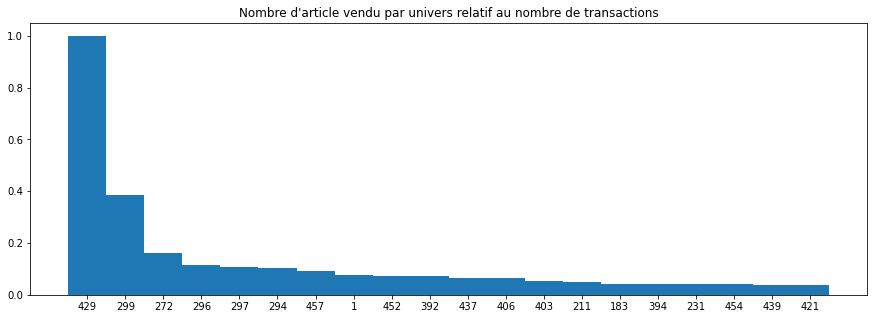

==============430===================
NOT ENOUGH DATA 
==============431===================
35383
Time Taken to load recurence: ~0secondes


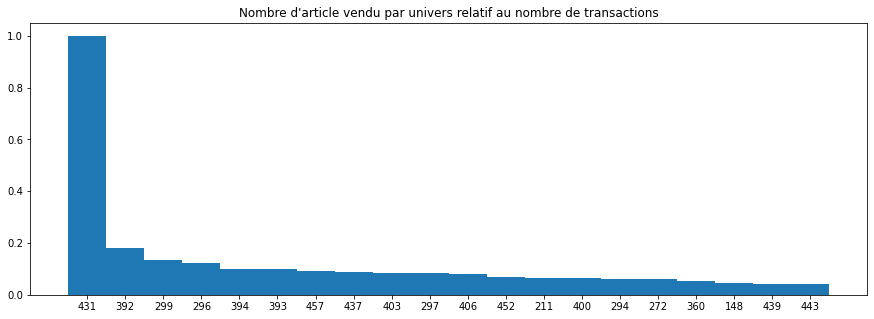

==============432===================
15600
Time Taken to load recurence: ~0secondes


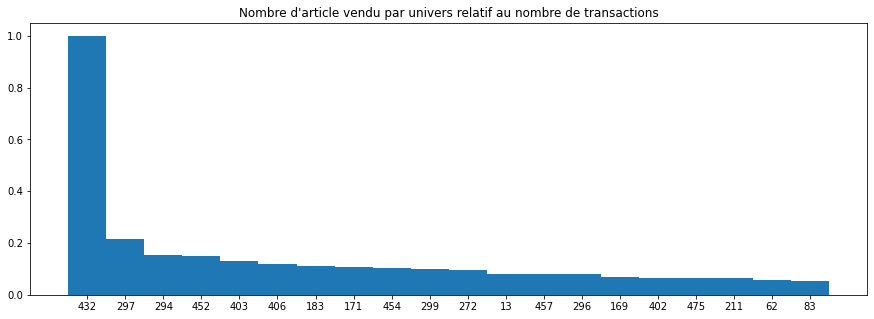

==============433===================
1675
Time Taken to load recurence: ~0secondes


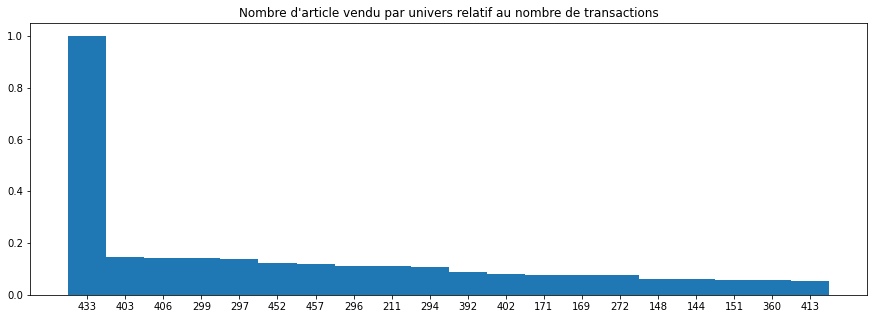

==============434===================
NOT ENOUGH DATA 
==============435===================
56512
Time Taken to load recurence: ~0secondes


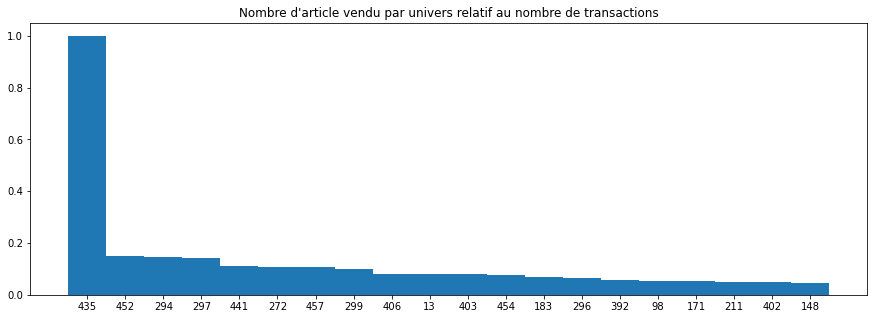

==============436===================
2155
Time Taken to load recurence: ~0secondes


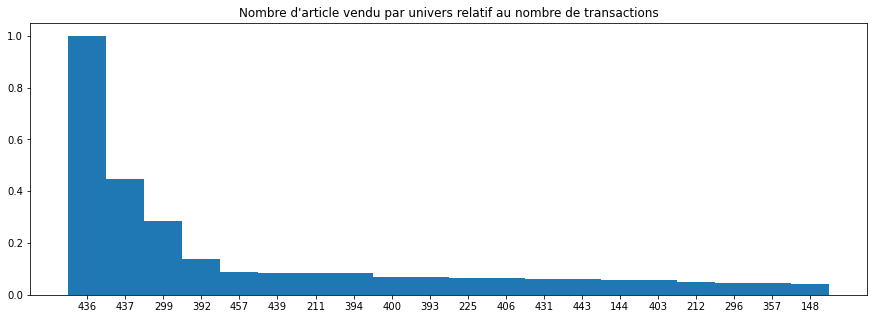

==============437===================
263836
Time Taken to load recurence: ~0secondes


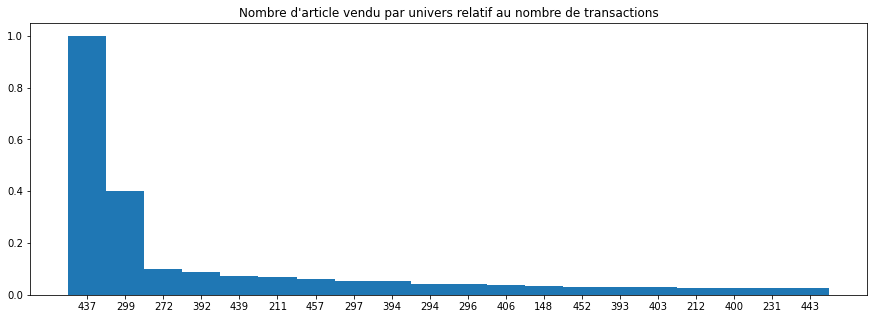

==============438===================
32763
Time Taken to load recurence: ~0secondes


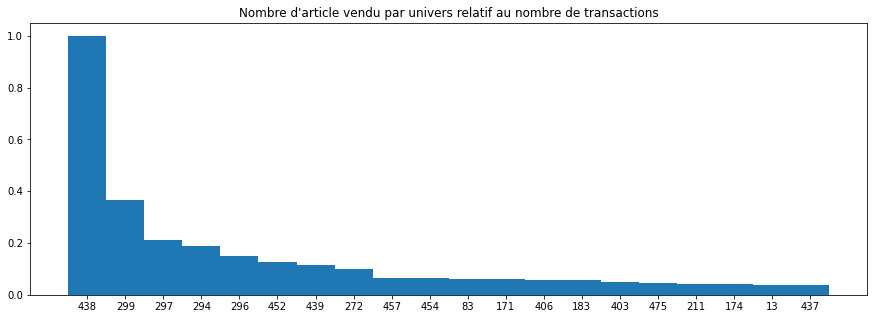

==============439===================
117628
Time Taken to load recurence: ~0secondes


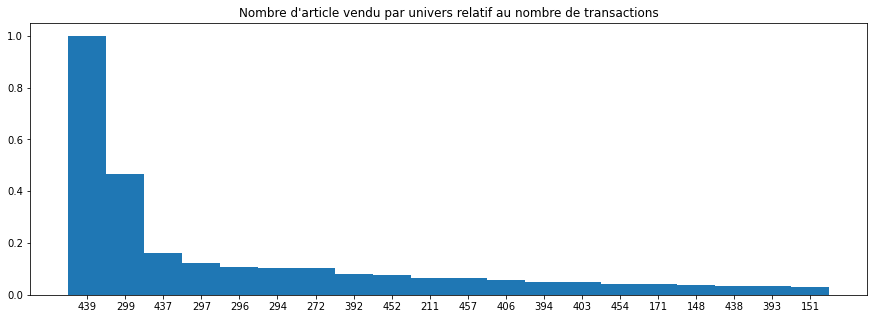

==============440===================
841
Time Taken to load recurence: ~0secondes


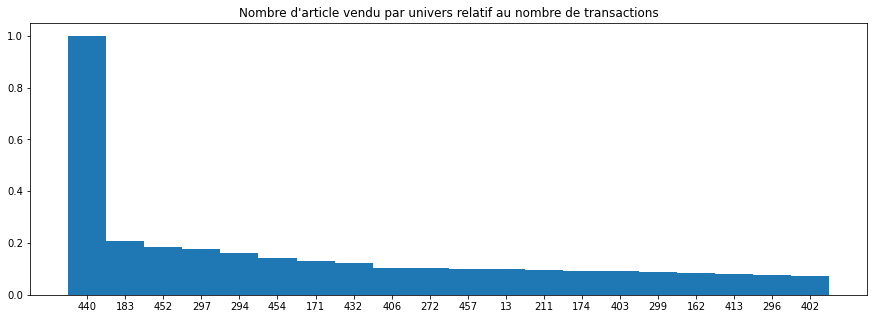

==============441===================
13718
Time Taken to load recurence: ~0secondes


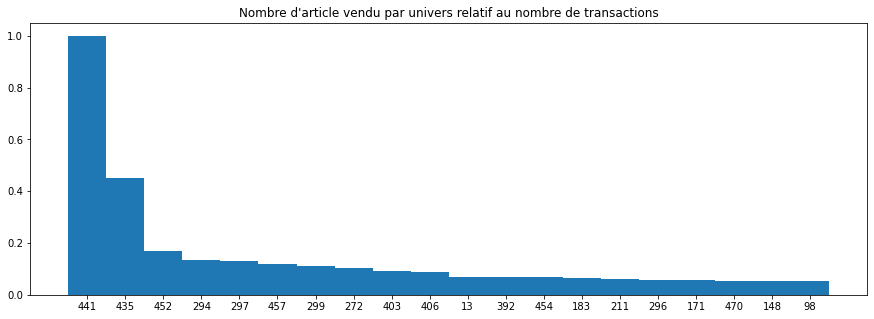

==============442===================
344
Time Taken to load recurence: ~0secondes


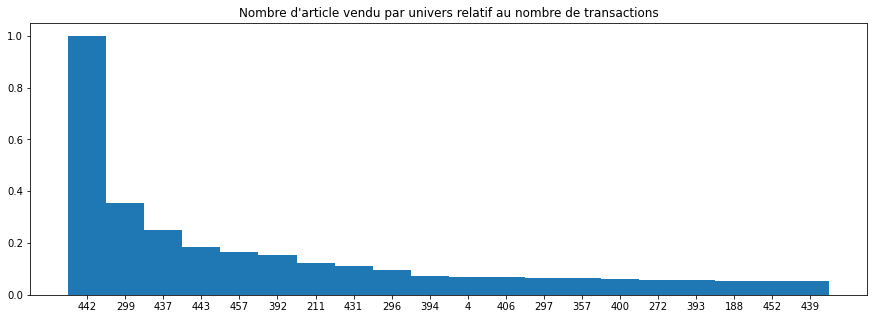

==============443===================
59435
Time Taken to load recurence: ~0secondes


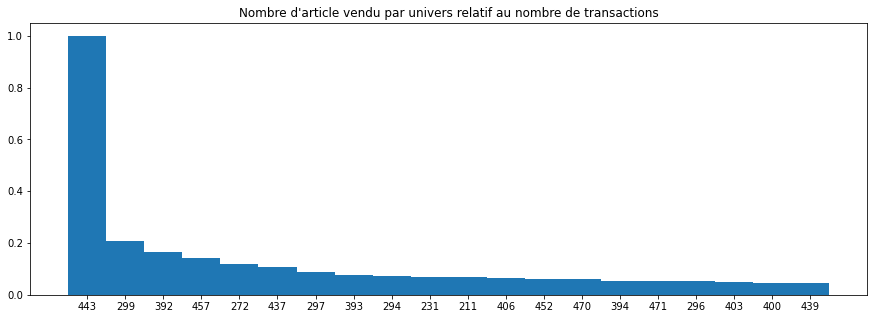

==============444===================
NOT ENOUGH DATA 
==============445===================
594
Time Taken to load recurence: ~0secondes


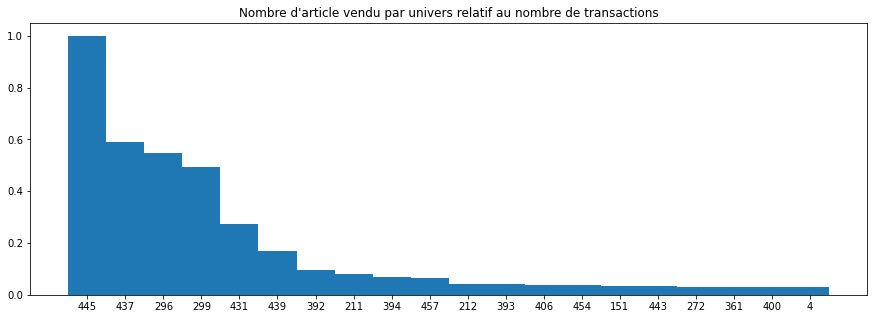

==============447===================
195
Time Taken to load recurence: ~0secondes


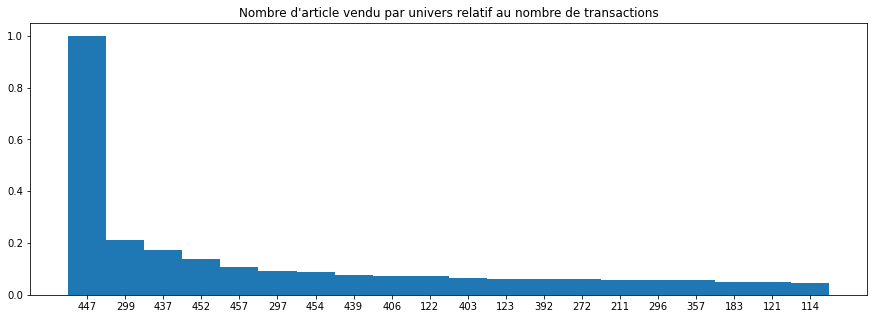

==============448===================
8906
Time Taken to load recurence: ~0secondes


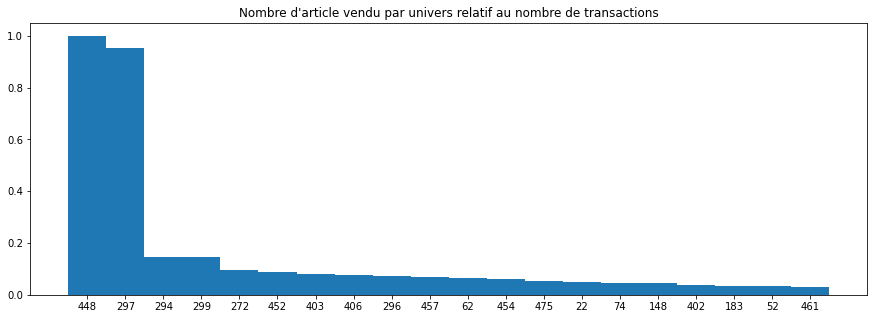

==============449===================
86
Time Taken to load recurence: ~0secondes


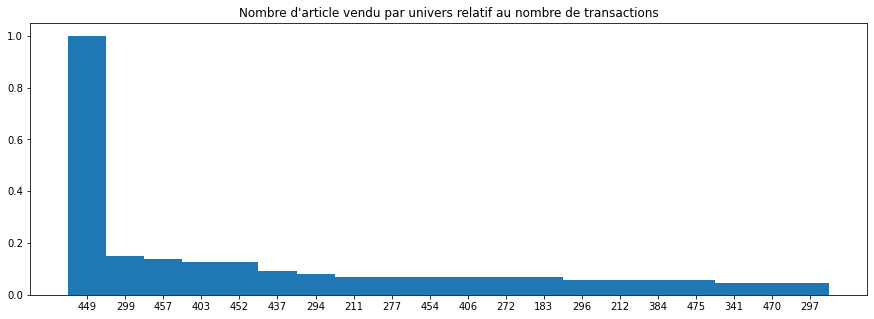

==============450===================
92
Time Taken to load recurence: ~0secondes


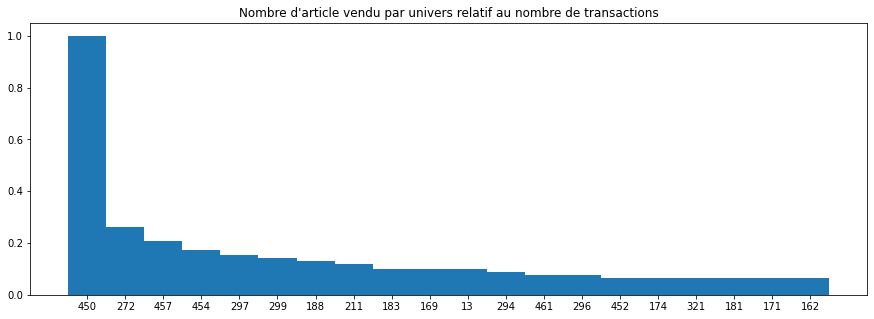

==============451===================
219
Time Taken to load recurence: ~0secondes


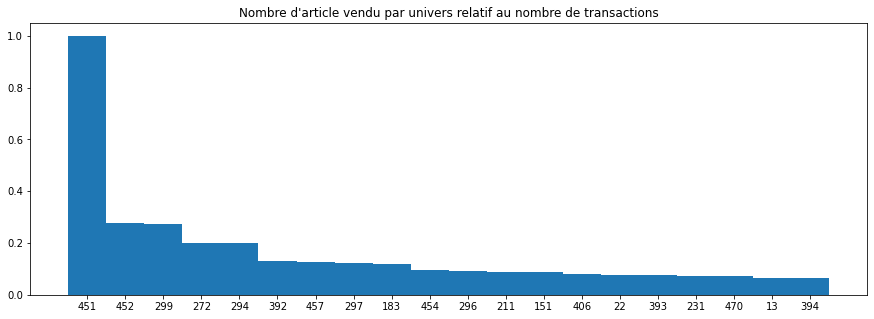

==============452===================
219662
Time Taken to load recurence: ~1secondes


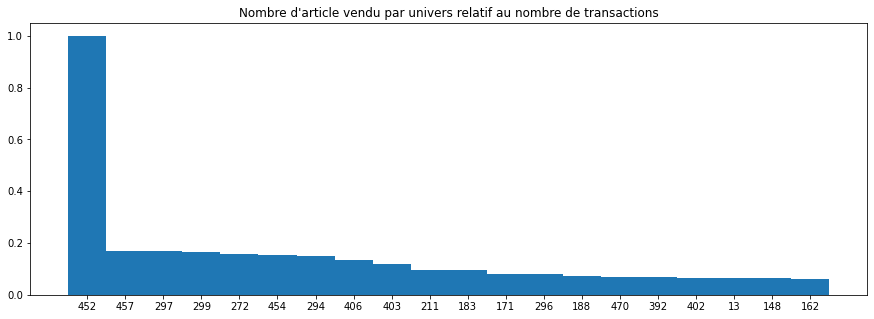

==============453===================
2319
Time Taken to load recurence: ~0secondes


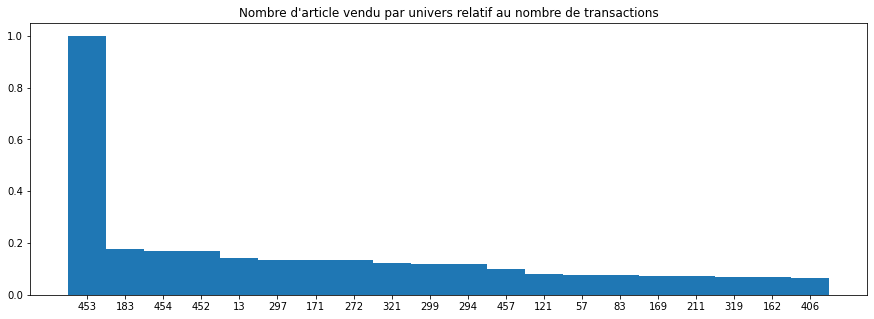

==============454===================
242970
Time Taken to load recurence: ~0secondes


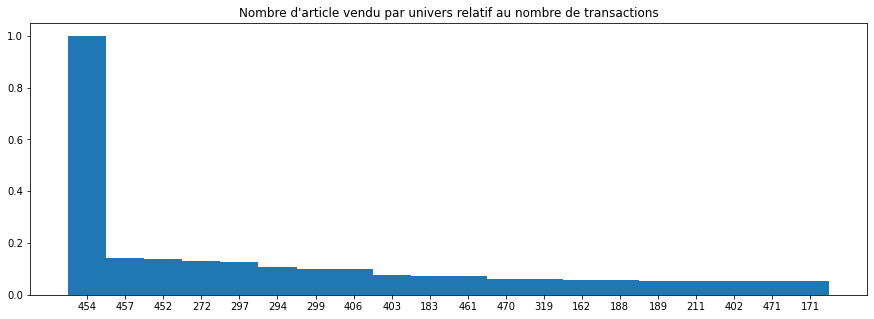

==============455===================
26984
Time Taken to load recurence: ~0secondes


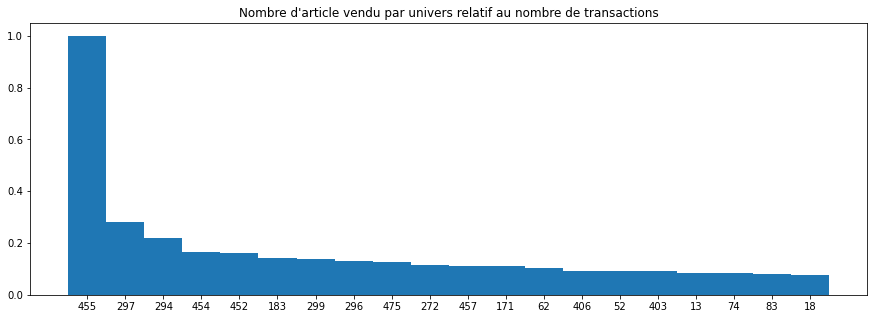

==============456===================
41187
Time Taken to load recurence: ~0secondes


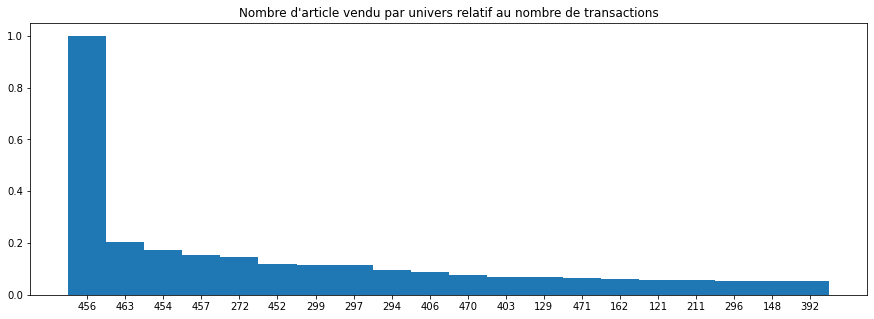

==============457===================
372985
Time Taken to load recurence: ~1secondes


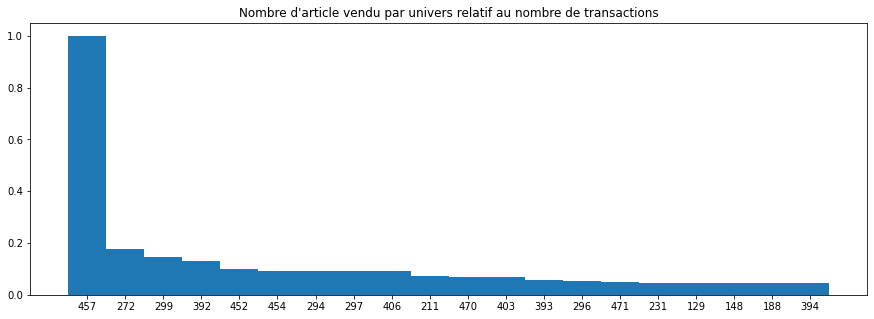

==============458===================
46391
Time Taken to load recurence: ~0secondes


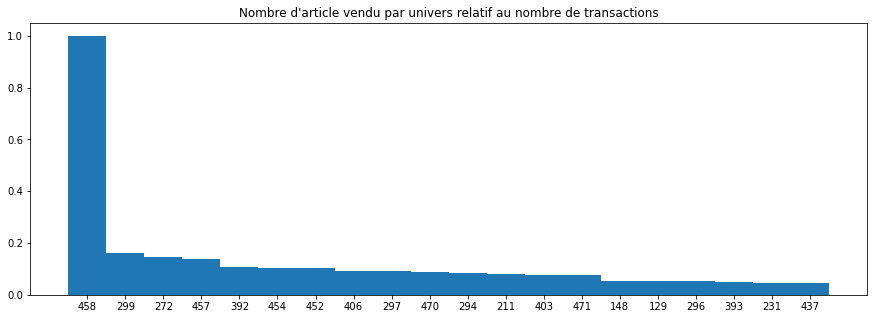

==============460===================
10644
Time Taken to load recurence: ~0secondes


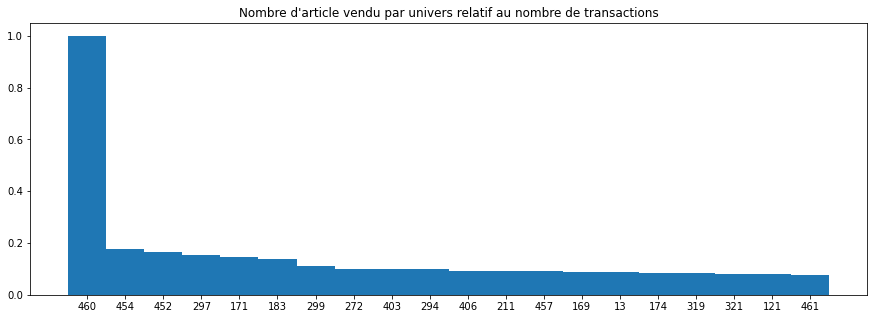

==============461===================
71857
Time Taken to load recurence: ~0secondes


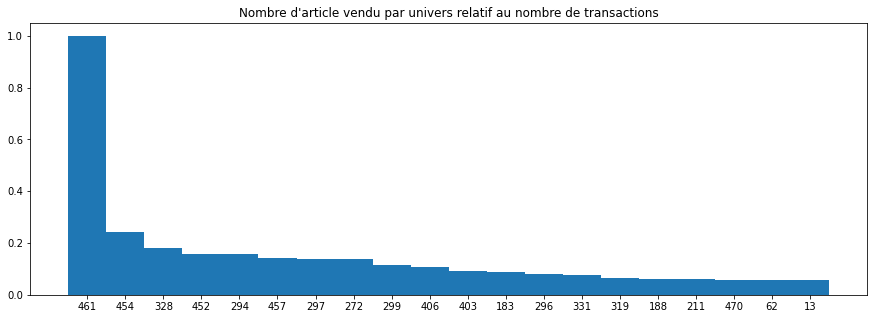

==============462===================
40832
Time Taken to load recurence: ~0secondes


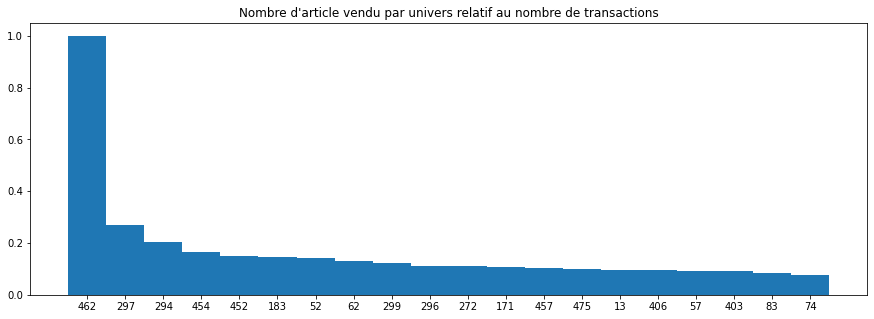

==============463===================
59308
Time Taken to load recurence: ~0secondes


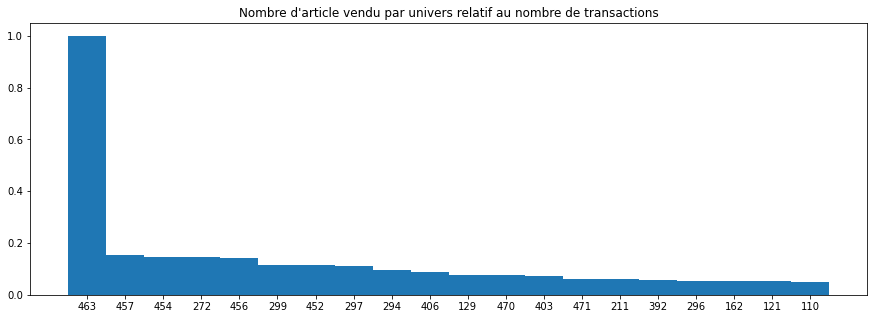

==============464===================
11205
Time Taken to load recurence: ~0secondes


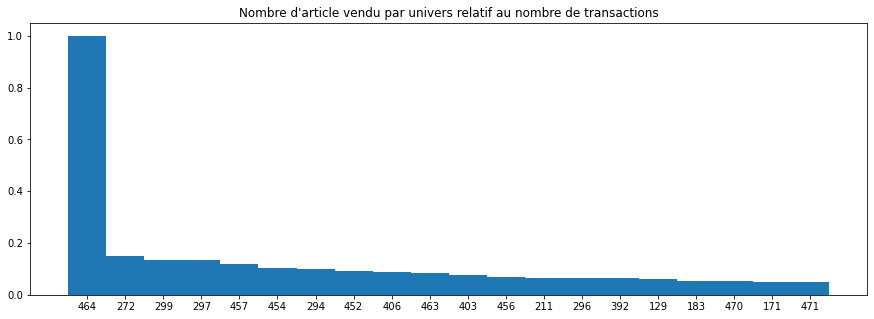

==============465===================
10884
Time Taken to load recurence: ~0secondes


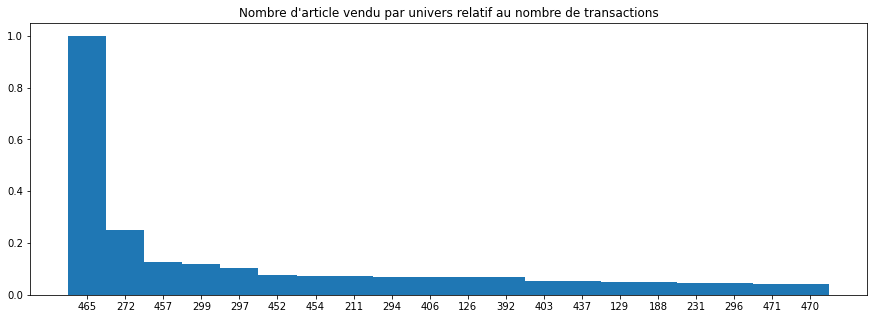

==============466===================
21834
Time Taken to load recurence: ~0secondes


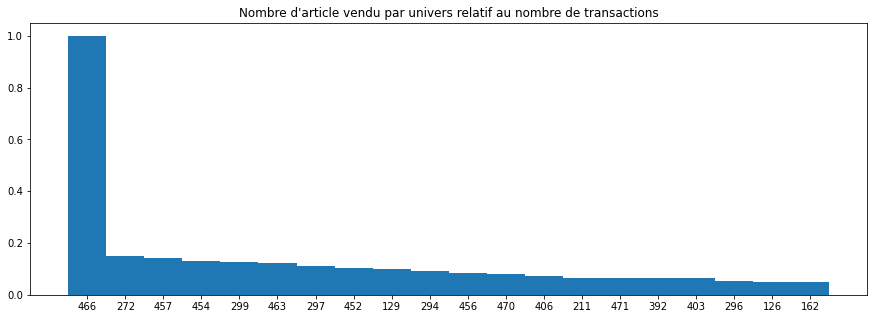

==============467===================
4786
Time Taken to load recurence: ~0secondes


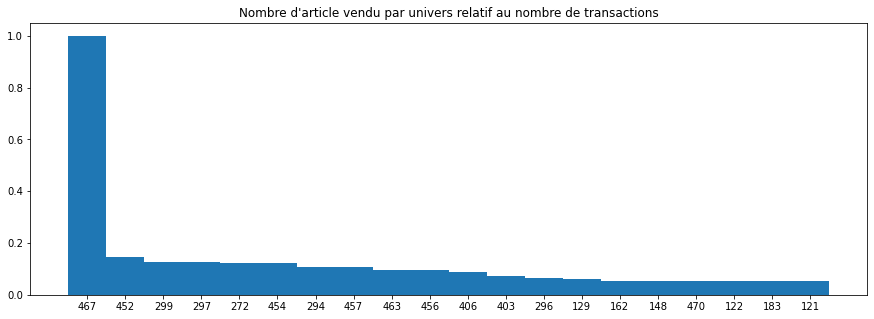

==============468===================
12352
Time Taken to load recurence: ~0secondes


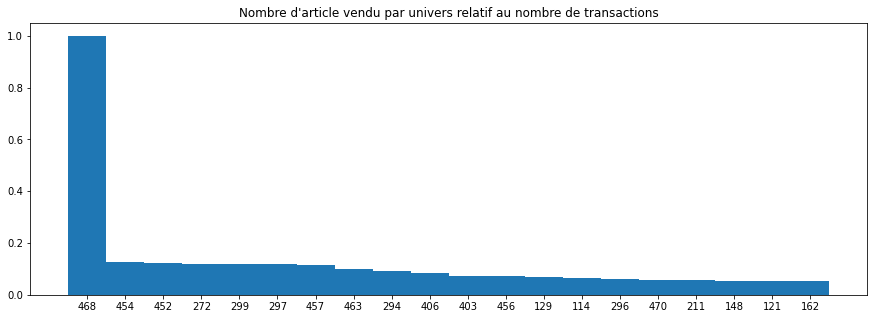

==============469===================
27615
Time Taken to load recurence: ~0secondes


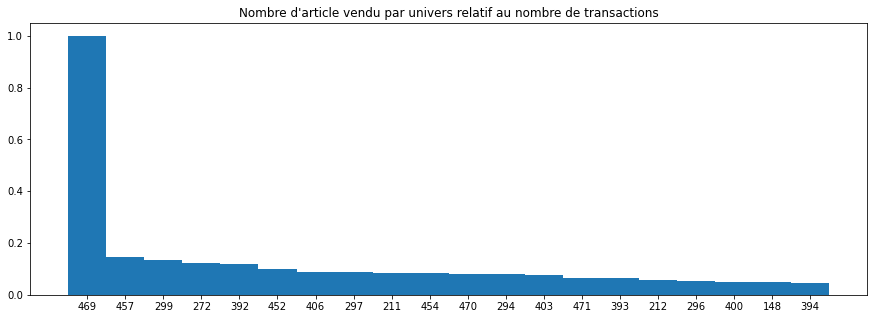

==============470===================
140906
Time Taken to load recurence: ~0secondes


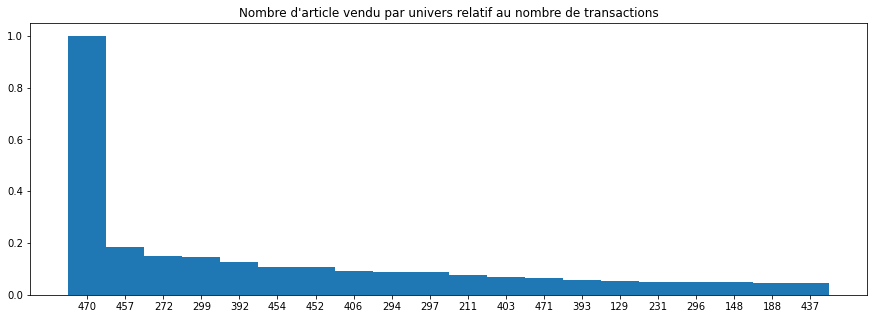

==============471===================
131192
Time Taken to load recurence: ~0secondes


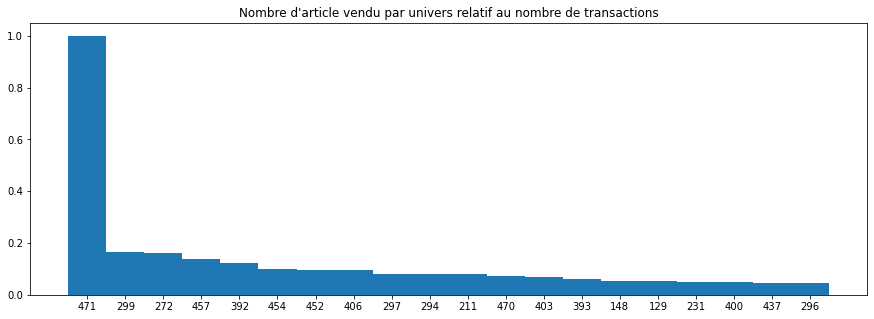

==============472===================
56972
Time Taken to load recurence: ~0secondes


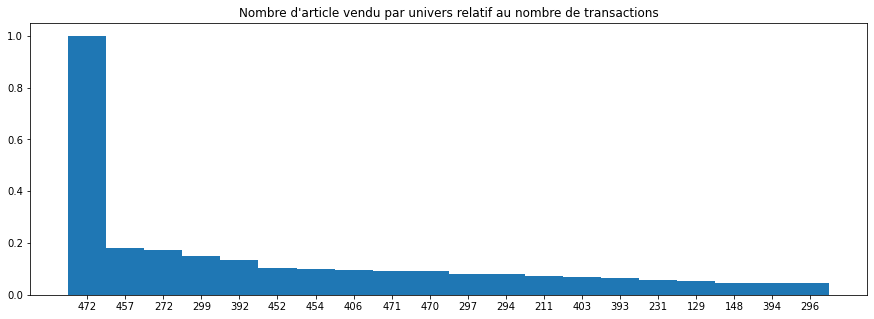

==============473===================
44485
Time Taken to load recurence: ~0secondes


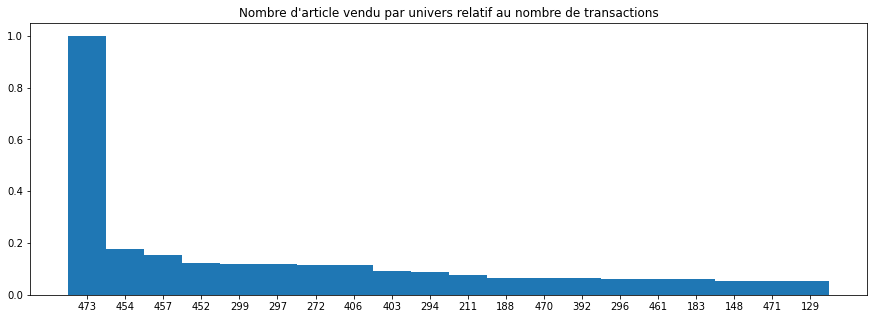

==============474===================
12231
Time Taken to load recurence: ~0secondes


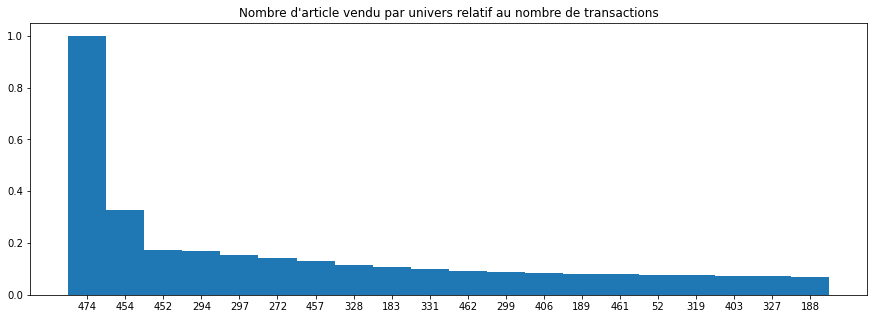

==============475===================
76699
Time Taken to load recurence: ~0secondes


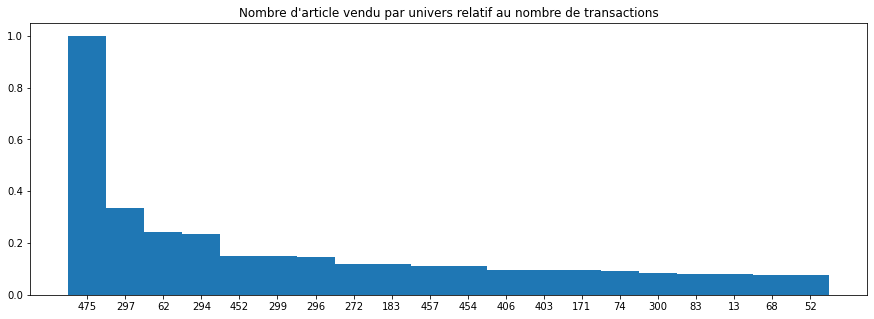

==============476===================
19461
Time Taken to load recurence: ~0secondes


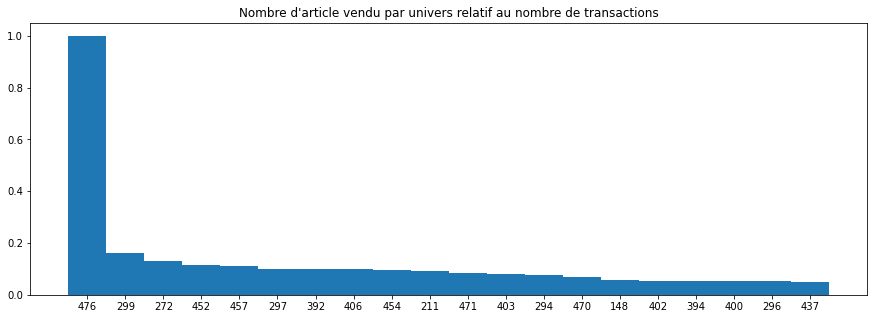

==============477===================
32989
Time Taken to load recurence: ~0secondes


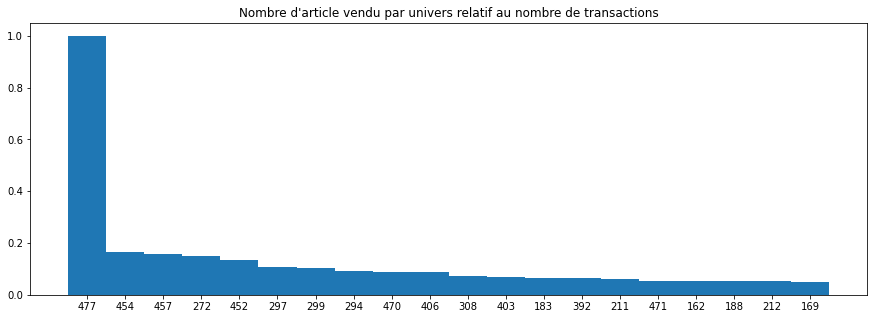

==============478===================
9255
Time Taken to load recurence: ~0secondes


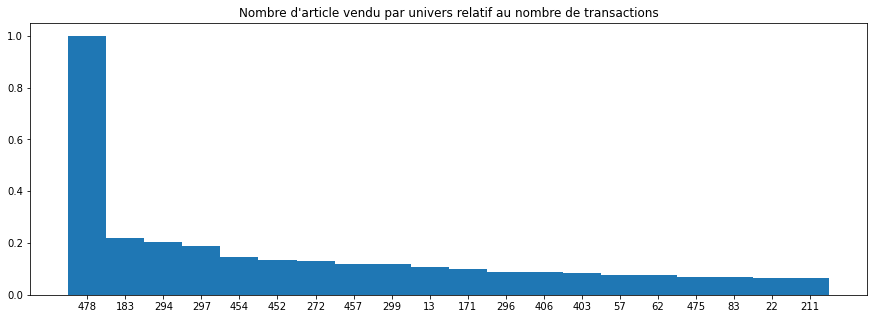

==============490===================
NOT ENOUGH DATA 
Time Taken to load all metrics: ~124secondes


In [19]:
# For all Universe, load the metrics 
start = time()

dico_metrics = {}
dico_rec_art = {}

for key in all_univ_key:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
    
    N = len(trans)
    if N <= 50:
        print("NOT ENOUGH DATA ")
        continue
    
    # Load recurence and #article per transactions
    nbr_article_sans_univ, nbr_article_univ = get_nbr_sans_univ(trans, [key])
    dico_rec_art[key], _ = load_recurence(trans)
    
    """
        8 metrics sont calculées :
            - "Proportion d'achat (%)" : Nombre de transactions contenant l'univers / nombre total de transactions
            - "Proportion d'achat seul": Nombre de fois que l'univers à été acheté seul / nombre de transactions contenant l'univers
            - "CA univ"       : CA totale produit par l'unif
            - "CA moyen univ" : "CA univ" / nombre de transaction contenant l'univers
            - "Nombre moyen article en plus" : Nombre d'article acheté qui ne sont pas dans l'univers dans les transactions contenant l'univers / nombre de transactions contenant l'univers
            - "CA en plus"       : CA totale des transactions contenant l'univers - "CA univ"
            - "CA moyen en plus" :"CA en plus" / nombre de transaction contenant l'univers
    """
    dico_metrics[key] = {"Proportion d'achat (%)": round(N*100/len(transactions),2),
                         "Proportion achat seul (%)": round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2),
                         "Nombre moyen d'univ":round(sum(nbr_article_univ)/N, 2),
                         "CA univ":round(CA_univ,2),
                         "CA moyen univ":round(CA_univ/N,2),
                         "Nombre moyen article en plus": round(sum(nbr_article_sans_univ)/N, 2),
                         "CA en plus": round(CA_without_univ,2),
                         "CA moyen en plus":round(CA_without_univ/N,2)}
    
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 

In [20]:
# Transform dico_metrics to dataframe
dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                 data  = dico_metrics.values())
# Sort dataframe by a speific column
dataframe_metrics=dataframe_metrics.sort_values(by=dataframe_metrics.columns[0], axis = 0, ascending=False)
print(dataframe_metrics.head(10))

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
272                   15.43                      23.59                 1.20   
299                   15.02                      10.42                 2.09   
297                   11.32                      13.00                 1.23   
294                    9.80                      13.37                 1.35   
457                    9.46                       6.27                 1.25   
392                    7.43                      16.34                 1.23   
406                    7.34                       9.25                 1.43   
437                    6.69                      19.91                 1.33   
403                    6.28                       8.86                 1.50   
454                    6.16                       4.06                 1.40   

        CA univ  CA moyen univ  Nombre moyen article en plus  CA en plus  \
272  6397775.86          10.52                        

In [21]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~974secondes


# INSERT INTO DB

### Instert Univers Metrics

In [27]:
conn = engine.connect()
for key,val in dataframe_metrics.to_dict('index').items():
#     print(list(val.values()))
    sql_cmd = '''INSERT INTO ['''+DB+'''].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES ('''+str(key)+''',
        '''+str(int(bool(take_only_fid)))+''',
        '''+str(len(transactions))+''',
        '''+str(list(val.values())[0])+''',
        '''+str(list(val.values())[1])+''',
        '''+str(list(val.values())[2])+''',
        '''+str(list(val.values())[3])+''',
        '''+str(list(val.values())[4])+''',
        '''+str(list(val.values())[5])+''',
        '''+str(list(val.values())[6])+''',
        '''+str(list(val.values())[7])+''')'''
                                                                                             
#     print(sql_cmd)
    conn.execute(sql_cmd)
conn.close()

[16.15, 11.21, 2.08, 3848667.55, 2.8, 3.85, 18391467.93, 13.38]
[15.06, 23.33, 1.19, 13526763.38, 10.56, 3.4, 15636928.1, 12.2]
[10.94, 12.74, 1.23, 2824888.29, 3.03, 5.19, 17534347.42, 18.84]
[9.54, 13.39, 1.35, 1757159.57, 2.17, 4.8, 14268084.58, 17.58]
[9.54, 6.36, 1.25, 2109001.1, 2.6, 4.82, 14660482.77, 18.06]
[8.12, 16.94, 1.24, 2858627.72, 4.14, 3.32, 7808095.63, 11.3]
[7.2, 8.95, 1.43, 6119113.05, 9.99, 5.15, 12870306.84, 21.01]
[6.68, 22.51, 1.31, 1430358.41, 2.52, 2.95, 4996158.45, 8.79]
[6.39, 8.54, 1.51, 6165446.98, 11.35, 5.4, 12169005.88, 22.4]
[6.15, 4.01, 1.4, 1776403.79, 3.39, 6.47, 13636693.21, 26.06]
[5.69, 6.59, 2.13, 1304698.78, 2.7, 5.34, 8798924.23, 18.18]
[5.29, 1.34, 1.06, 99793.54, 0.22, 8.6, 15556538.5, 34.53]
[5.13, 8.27, 1.19, 987298.99, 2.26, 5.1, 7860142.67, 17.99]
[4.32, 19.51, 1.43, 2229008.48, 6.07, 3.73, 5548868.47, 15.1]
[3.81, 12.04, 1.31, 942567.89, 2.91, 3.87, 4648908.28, 14.35]
[3.58, 5.26, 1.2, 657924.48, 2.16, 5.29, 5764430.69, 18.91]
[3.48, 13

[0.44, 4.72, 1.17, 141893.32, 3.79, 8.31, 1232631.47, 32.91]
[0.44, 20.85, 1.27, 551667.39, 14.63, 4.63, 686742.7, 18.22]
[0.44, 2.16, 1.24, 104244.13, 2.78, 8.86, 1218514.44, 32.48]
[0.43, 6.86, 1.76, 195579.62, 5.33, 7.25, 1044876.68, 28.48]
[0.43, 4.15, 1.2, 165435.29, 4.55, 9.48, 1269021.51, 34.88]
[0.42, 0.96, 1.06, 104058.18, 2.92, 8.91, 1195223.86, 33.55]
[0.42, 6.55, 1.26, 275591.83, 7.71, 8.38, 1206595.05, 33.77]
[0.42, 3.12, 1.19, 187675.87, 5.28, 7.54, 1067903.35, 30.07]
[0.41, 0.92, 1.13, 133532.87, 3.84, 9.03, 1147272.98, 32.97]
[0.41, 10.31, 1.26, 286877.03, 8.29, 5.08, 732662.42, 21.17]
[0.4, 4.54, 1.29, 140462.98, 4.17, 8.6, 1137197.97, 33.76]
[0.4, 4.86, 1.09, 192766.91, 5.65, 6.69, 891829.15, 26.15]
[0.4, 10.98, 1.07, 733860.41, 21.3, 5.08, 782691.18, 22.72]
[0.39, 1.48, 1.23, 98045.69, 2.93, 8.81, 1109446.1, 33.2]
[0.38, 3.93, 1.22, 344948.99, 10.7, 6.97, 1011169.58, 31.38]
[0.38, 4.5, 1.04, 116081.41, 3.6, 8.75, 1084519.57, 33.66]
[0.38, 1.46, 1.06, 134724.75, 4.2, 

[0.07, 4.09, 1.33, 68335.85, 11.19, 9.67, 260487.94, 42.65]
[0.06, 3.66, 1.51, 15153.97, 3.15, 11.34, 209440.93, 43.5]
[0.06, 2.7, 1.25, 24383.35, 4.48, 11.4, 228691.23, 42.0]
[0.06, 1.96, 1.2, 24586.36, 4.69, 10.51, 227285.2, 43.34]
[0.06, 3.13, 1.12, 28086.57, 5.85, 8.81, 167996.21, 35.01]
[0.06, 0.83, 1.09, 18592.22, 3.94, 10.98, 207218.32, 43.93]
[0.06, 2.84, 1.29, 29586.67, 5.45, 8.96, 185062.2, 34.08]
[0.06, 5.22, 1.07, 77036.3, 15.65, 10.35, 209563.47, 42.59]
[0.06, 2.77, 1.16, 22809.61, 4.61, 9.38, 177175.73, 35.82]
[0.06, 3.11, 1.15, 14504.91, 2.65, 6.73, 137682.88, 25.15]
[0.06, 8.97, 1.03, 41465.47, 8.05, 4.83, 97592.42, 18.94]
[0.06, 2.61, 1.16, 18448.56, 3.44, 7.51, 146781.82, 27.4]
[0.06, 2.09, 1.14, 25686.79, 5.41, 10.16, 187333.91, 39.49]
[0.05, 5.8, 1.29, 54188.39, 11.73, 7.88, 158649.37, 34.34]
[0.05, 4.24, 1.25, 15181.21, 3.31, 8.28, 131350.99, 28.68]
[0.05, 4.07, 1.14, 17782.48, 4.47, 10.13, 152594.78, 38.33]
[0.05, 8.07, 1.08, 16063.22, 3.87, 6.74, 103696.7, 24.97]

### Insert Proportion d'Article par Univers

In [28]:
conn = engine.connect()
for key,val in dico_rec_art.items():
    i = 0
    for univ,prop in val.items():
        if prop >= 0.01:
            sql_cmd = '''
            INSERT INTO ['''+DB+'''].[PML].[Proportion_Article_par_transactions]
               ([Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
               ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
               ,[Proportion_Article_par_transactions.Classement]
               ,[Proportion_Article_par_transactions.Proportion]
               ,[Proportion_Article_par_transactions.flags_only_fidelity])
         VALUES
               ('''+str(key)+'''
               ,'''+"Null"+'''
               ,'''+str(univ)+'''
               ,'''+str(i)+'''
               ,'''+str(round(prop,2))+'''
               ,'''+str(int(bool(take_only_fid)))+''')
           '''
            i+=1
            
#             print(sql_cmd)           
            conn.execute(sql_cmd)
        else:
            break
conn.close()

### Insert Proportion D'article par Magasin

In [29]:
conn = engine.connect()
for key,val in dico_rec_mag.items():
    i = 1
    for univ,prop in val.items():
        if prop >= 0.01:
            sql_cmd = '''
            INSERT INTO ['''+DB+'''].[PML].[Proportion_Article_par_transactions]
               ([Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
               ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
               ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
               ,[Proportion_Article_par_transactions.Classement]
               ,[Proportion_Article_par_transactions.Proportion]
               ,[Proportion_Article_par_transactions.flags_only_fidelity])
         VALUES
               ('''+"Null"+'''
               ,'''+str(key)+'''
               ,'''+str(univ)+'''
               ,'''+str(i)+'''
               ,'''+str(round(prop,2))+'''
               ,'''+str(int(bool(take_only_fid)))+''')
           '''
            i+=1
            
#             print(sql_cmd)           
            conn.execute(sql_cmd)
        else:
            break
conn.close()

### Insert Proportion d'article générale

In [27]:
conn = engine.connect()    
i = 1
for univ,prop in rec_article.items():
    if prop >= 0.01:
        sql_cmd = '''
        INSERT INTO ['''+DB+'''].[PML].[Proportion_Article_par_transactions]
           ([Proportion_Article_par_transactions.UNIVERS_filtre.KEY]
           ,[Proportion_Article_par_transactions.MAGASIN_filtre.KEY]
           ,[Proportion_Article_par_transactions.UNIVERS_proportion.KEY]
           ,[Proportion_Article_par_transactions.Classement]
           ,[Proportion_Article_par_transactions.Proportion]
           ,[Proportion_Article_par_transactions.flags_only_fidelity])
     VALUES
           ('''+"Null"+'''
           ,'''+"Null"+'''
           ,'''+str(univ)+'''
           ,'''+str(i)+'''
           ,'''+str(round(prop,2))+'''
           ,'''+str(int(bool(take_only_fid)))+''')
       '''
        i+=1

#             print(sql_cmd)           
        conn.execute(sql_cmd)
    else:
        break
conn.close()

### Insert Rules 

In [30]:
conn = engine.connect()
for rule in rules:
    if len(rule.lhs) > 2 or len(rule.rhs) > 2 or rule.lift <= 1:
        continue
    
    sql_cmd = '''
    INSERT INTO ['''+DB+'''].[PML].[Rules_Univers]
   ([Rules_Univers.UNIVERS_left_1.KEY]
   ,[Rules_Univers.UNIVERS_left_2.KEY]
   ,[Rules_Univers.UNIVERS_right_1.KEY]
   ,[Rules_Univers.UNIVERS_right_2.KEY]
   ,[Rules_Univers.confidence]
   ,[Rules_Univers.support]
   ,[Rules_Univers.lift]
   ,[Rules_Univers.conviction]
   ,[Rules_Univers.flags_only_fidelity])
VALUES
   ('''+str(rule.lhs[0])+'''
   ,'''+("Null" if len(rule.lhs) == 1 else str(rule.lhs[1]))+'''
   ,'''+str(rule.rhs[0])+'''
   ,'''+("Null" if len(rule.rhs) == 1 else str(rule.rhs[1]))+'''
   ,'''+str(round(rule.confidence,3))+'''
   ,'''+str(round(rule.support,3))+'''
   ,'''+str(round(rule.lift,3))+'''
   ,'''+str(round(rule.conviction,3))+'''
   ,'''+str(int(bool(take_only_fid)))+''')
   '''
    

#     print(sql_cmd)           
    conn.execute(sql_cmd)
conn.close()

## Old but Gold

In [31]:
# start = time()

# segment = 1

# sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
# ['''     + TABLE_ENTETE   + '''.KEY], ''' + ('''
# ['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY],''')*int(do_shop) + '''
# ['''     + RECETTE_DETAIL + ''']
# FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
# INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
# ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
# INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
# ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
# AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
# INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + CONSOMMATEUR    + ''']
# ON [''' + CONSOMMATEUR    + '''.Key] = ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY]
# WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
# AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
# AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
# AND ['''      + CONSOMMATEUR  + '''.KEY] != -1
# AND ['''+ CONSOMMATEUR  +'''.Segment_Clientele] = ''' + str(segment) + '''
# ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

# print(sql_command)

# conn = engine.connect()
# df_art_ticket = pd.read_sql(sql_command, conn)


# # environ 4min
# print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
# nbr_data = len(df_art_ticket)
# print(df_art_ticket)